In [27]:
# Some tunable parameters
import numpy as np

K = 5 # 'dimension' of the parameters (nb of coefficients to estimate)
functions = [1]+[np.cos,np.sin]*(K//2) # 
wavenumbers = [0]+[1+k//2 for k in range(K-1)] # wavenumbers inside the sinus function[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]
#functions = [np.cos] 
#wavenumbers = [1]

# Physical model 
rho = 0.917 # ice density
gx,gy =5, -10 # x and y components for the gravity
domain_length = 5 # ratio of the rectangle domain, L*1

def build_beta(coeffs):
    """
    Auxiliary function to build a function beta based on the theta coefficients in the arguments.
    We exponentiate because beta must be a positive function.

    Keyword arguments:
    coeffs -- float list of size K, the coefficients weigthing the truncated Fourier expansion functions

    Returns:
    beta -- one-dimensional function representing the basal drag factor
    """ 

    beta = lambda x: np.exp((coeffs[0] + sum([coeffs[k]*np.exp(-wavenumbers[k])*functions[k](wavenumbers[k]*2*np.pi*x[0]/domain_length) for k in range(1,K)]))) +0*x[0]
    #beta = lambda x: np.exp(sum([coeffs[k]*functions[k](wavenumbers[k]*2*np.pi*x[0]) for k in range(K)])) +0*x[0]
    
    return beta



# PDE Solver

In this section, we build our forward map, i.e. the solver for the Stokes flow.

It takes as argument the list of coefficients \theta that we will use to build the function β (basal drag factor on the lower boundary of the domain), and outputs the values of the velocity on the boundary.

In this section we also define the geometry of the domain (mesh, function spaces)

### Various imports

In [8]:
import dolfinx

In [9]:
#Other miscellaneous imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import pyvista

import ufl
from dolfinx import cpp as _cpp
from dolfinx import fem
from dolfinx import plot
from dolfinx.fem import (Constant, Function, FunctionSpace, dirichletbc,
                         extract_function_spaces, form, Expression,
                         locate_dofs_geometrical, locate_dofs_topological)
from dolfinx.io import XDMFFile
from dolfinx.mesh import (CellType, GhostMode, create_rectangle, locate_entities,
                          locate_entities_boundary, meshtags)

from dolfinx import geometry

from ufl import div, dx, grad, inner, Measure

from mpi4py import MPI
from petsc4py import PETSc

"""
# Setup environment for interactive plotting
!apt-get install -qq xvfb
!pip install pyvista panel -q

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')
"""



"\n# Setup environment for interactive plotting\n!apt-get install -qq xvfb\n!pip install pyvista panel -q\n\nimport os\nos.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')\nos.environ['DISPLAY'] = ':99'\n\nimport panel as pn\npn.extension('vtk')\n"

### Study the impact of the mesh size

In [4]:
def solve_mesh(size_msh):
    
    # Create the mesh
    msh = create_rectangle(MPI.COMM_WORLD,
                       [np.array([0, 0]), np.array([1, 1])],
                       [size_msh, size_msh],
                       CellType.triangle, GhostMode.none)
    
    

    # We define the finite elements function space (Taylor Woods method)
    P2 = ufl.VectorElement("Lagrange", msh.ufl_cell(), 2)
    P1 = ufl.FiniteElement("Lagrange", msh.ufl_cell(), 1)
    mixed = ufl.MixedElement([P2, P1])

    V, Q = FunctionSpace(msh, P2), FunctionSpace(msh, P1)
    W = FunctionSpace(msh, mixed) # Defined Mixed Function space - needed for solving divergence at same time
    
    
    #Create the subdomains and space for Robin boundary condition in this problem

    tol = 1E-14 # tolerance (we cannot use strict equalities)

    boundaries = [(1, lambda x: abs(x[1])<= tol),   # Robin BC, at the bottom
                  (2, lambda x: abs(x[1]-1)<= tol)]   # Neumann BC, at  the surface


    # We now loop through all the boundary conditions and create MeshTags identifying the facets for each boundary condition
    facet_indices, facet_markers = [], []
    fdim = msh.topology.dim - 1
    for (marker, locator) in boundaries:
        facets = locate_entities(msh, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = meshtags(msh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


    # To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the MeshTags to file
    msh.topology.create_connectivity(msh.topology.dim-1, msh.topology.dim)
    #with XDMFFile(msh.comm, "facet_tags.xdmf", "w") as xdmf:
    #    xdmf.write_mesh(msh)
    #    xdmf.write_meshtags(facet_tag)

    # Now we can create a custom integration measure ds, which can be used to restrict integration. 
    #If we integrate over ds(1), we only integrate over facets marked with value 1 in the corresponding facet_tag

    ds = Measure("ds", domain=msh, subdomain_data=facet_tag)
    
    
    
    
    # Define the class of boundary conditions 

    class BoundaryCondition():
        def __init__(self, type, marker, values):
            self._type = type
            if type == "Dirichlet":
                u_D = Function(V)
                u_D.interpolate(values)
                facets = facet_tag.find(marker)
                dofs = locate_dofs_topological(V, fdim, facets)
                self._bc = dirichletbc(u_D, dofs)

            elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)

            elif type == "Robin":
              #self._bc = values[0] * inner(u-values[1], v)* ds(marker)
              # slight modification: returns 2 integrals, one for the bilinear form a and one for the linear form L
                self._bc = values[0] * inner(u,v)* ds(marker), values[0] * inner(values[1], v)* ds(marker)
            else:
                raise TypeError("Unknown boundary condition: {0:s}".format(type))

        @property
        def bc(self):
            return self._bc

        @property
        def type(self):
            return self._type


    version = "sum"

    # We now define the bilinear and linear forms corresponding to the weak
    # mixed formulation of the Stokes equations in a blocked structure:

    # Define variational problem: Trial and test functions
    u, p = ufl.TrialFunctions(W)
    v, q = ufl.TestFunctions(W)

    # Define the source terms (based on tunable parameters at the top)
    f = Constant(msh, (PETSc.ScalarType(rho*gx), PETSc.ScalarType(rho*gy)))


    # Define the bilinear form
    a = inner(grad(u), grad(v)) * dx - inner(p, div(v)) * dx + inner(div(u), q) * dx

    # Define the linear form
    L = inner(f, v) * dx + inner(Constant(msh, PETSc.ScalarType(0)), q) * dx



    #-----------------SET THE BOUNDARY CONDITIONS FOR THE PROBLEM----------------------------------------------

    # Set the values for Neumann BC
    values_boundary_neumann = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0))) # no stress --> tau = 0

    # Set the values for Robin BC
    beta = build_beta(theta)
    r = Function(Q)
    r.interpolate(beta)
    s = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0)))
    values_boundary_robin = (r,s)

    # Gather the Boundary conditions
    boundary_conditions = [BoundaryCondition("Robin", 1, values_boundary_robin),
                        BoundaryCondition("Neumann", 2, values_boundary_neumann)]

    bcs = []
    for condition in boundary_conditions:
      if condition.type == "Dirichlet":
          bcs.append(condition.bc)

      elif condition.type == "Neumann":
          linear_term = condition.bc
          L+= linear_term

      elif condition.type == "Robin":

          bilinear_term, linear_term = condition.bc

          if version == "sum":
              a+= bilinear_term

          else:
              a[0].append(bilinear_term) # add the modification to bilinear form

          L+= linear_term   # add the modification to linear form

      else: 
          print("Unhandled condition type")



    #-----------------------------ASSEMBLE AND SOLVE-----------------------------------------------
    
    # Assemble LHS matrix and RHS vector
    a,L = form(a),form(L)

    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)

    fem.petsc.apply_lifting(b, [a], bcs=[bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    fem.petsc.set_bc(b, bcs)

    # Create and configure solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("superlu_dist")

    # Compute the solution
    U = Function(W)
    
    start_time = time.time()
    ksp.solve(b, U.vector)
    solve_time = time.time()-start_time

    # Split the mixed solution and collapse
    uh = U.sub(0).collapse()
    ph = U.sub(1).collapse()



    #-----------------------------EVALUATE ON THE SURFACE AND OUTPUT VALUES-------------------------

    # Gather coordinates of mesh points that are at the surface

    facets_surface = facet_tag.find(2) # points at the surface boundary were marked with marker 2 (see previous cell)

    fdim = msh.topology.dim - 1
    msh.topology.create_connectivity(fdim, 0)

    num_facets_owned_by_proc = msh.topology.index_map(fdim).size_local
    geometry_entitites = dolfinx.cpp.mesh.entities_to_geometry(msh, fdim, np.arange(num_facets_owned_by_proc, dtype=np.int32), False)
    points = msh.geometry.x

    surface_coordinates=[]
    for e, entity in enumerate(geometry_entitites):
        if e in facets_surface:
            coord1, coord2 = points[entity][0], points[entity][1]
            surface_coordinates.append(coord1)
            surface_coordinates.append(coord2)

    surface_coordinates = np.unique(surface_coordinates, axis=0) # remove duplicates    

    # Prepare the tools to find corresponding cells

    bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)
    cells = []

    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions(bb_tree, surface_coordinates)

    # Choose one of the cells that contains the point

    colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, surface_coordinates)

    for i, point in enumerate(surface_coordinates):

        if len(colliding_cells.links(i))>0:

            cells.append(colliding_cells.links(i)[0])



    u_values = uh.eval(surface_coordinates, cells)
    p_values = ph.eval(surface_coordinates, cells)

    return surface_coordinates, u_values, solve_time

In [5]:
# Run the analysis

sizes_mesh = [32, 50, 80, 100, 150]#, 200, 250]
theta = [-1, 0, 1, -1]
coords=[]
solutions = []
solve_times=[]

for sm in sizes_mesh:
    print(sm)
    surface_coordinates, u_values,solve_time = solve_mesh(sm)
    coords.append(surface_coordinates)
    solutions.append(u_values)
    solve_times.append(solve_time)

32
50
80
100
150


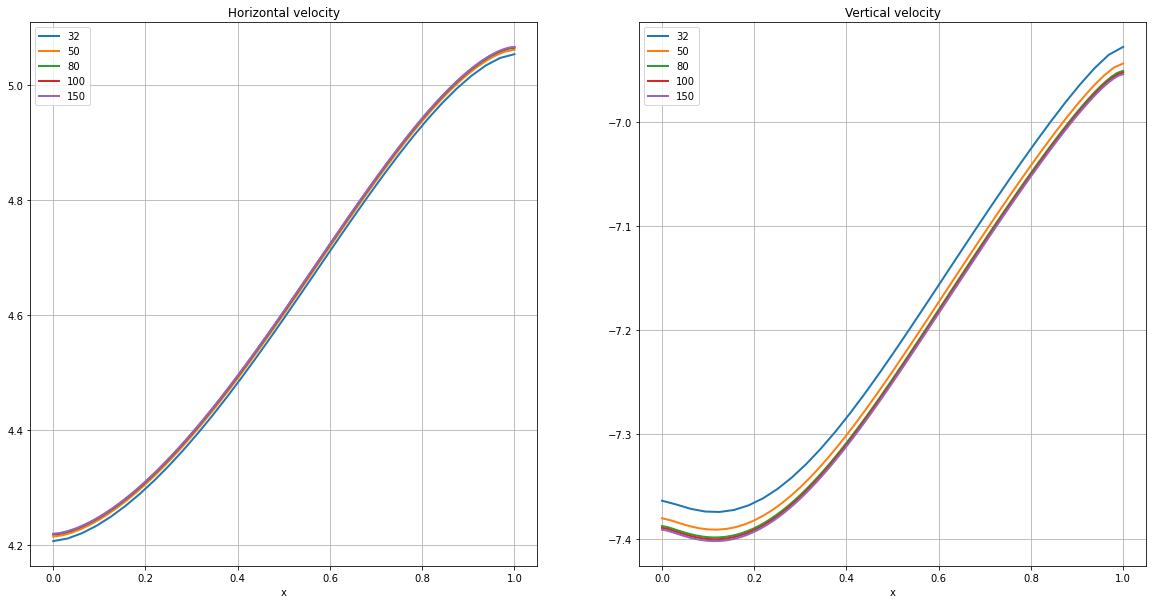

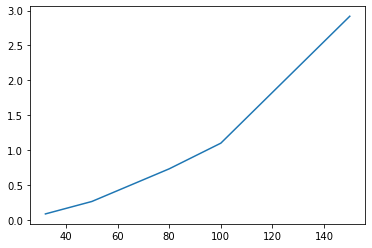

In [6]:
# Plot
fig = plt.figure(figsize=(20,10))

for i in range(len(sizes_mesh)):
    u_values = solutions[i]
    surface_coordinates = coords[i]
    velocity_x = [u_values[i][0] for i in range(len(coords[i]))]
    velocity_y = [u_values[i][1] for i in range(len(coords[i]))]
    x_value = [surface_coordinates[i][0] for i in range(len(coords[i]))]

    plt.subplot(121)
    plt.plot(x_value, velocity_x, linewidth=2, label=f"{sizes_mesh[i]}")

    plt.subplot(122)
    plt.plot(x_value, velocity_y, linewidth = 2, label=f"{sizes_mesh[i]}")

plt.subplot(121)
plt.title('Horizontal velocity')
plt.grid(True)
plt.xlabel("x")
plt.legend()

plt.subplot(122)
plt.title('Vertical velocity')
plt.grid(True)
plt.xlabel("x")
plt.legend()

plt.figure()
plt.plot(sizes_mesh, solve_times)

# If run in parallel as a python file, we save a plot per processor
#plt.savefig(f"velocity_plots.png")

## One function - Variational form and solving

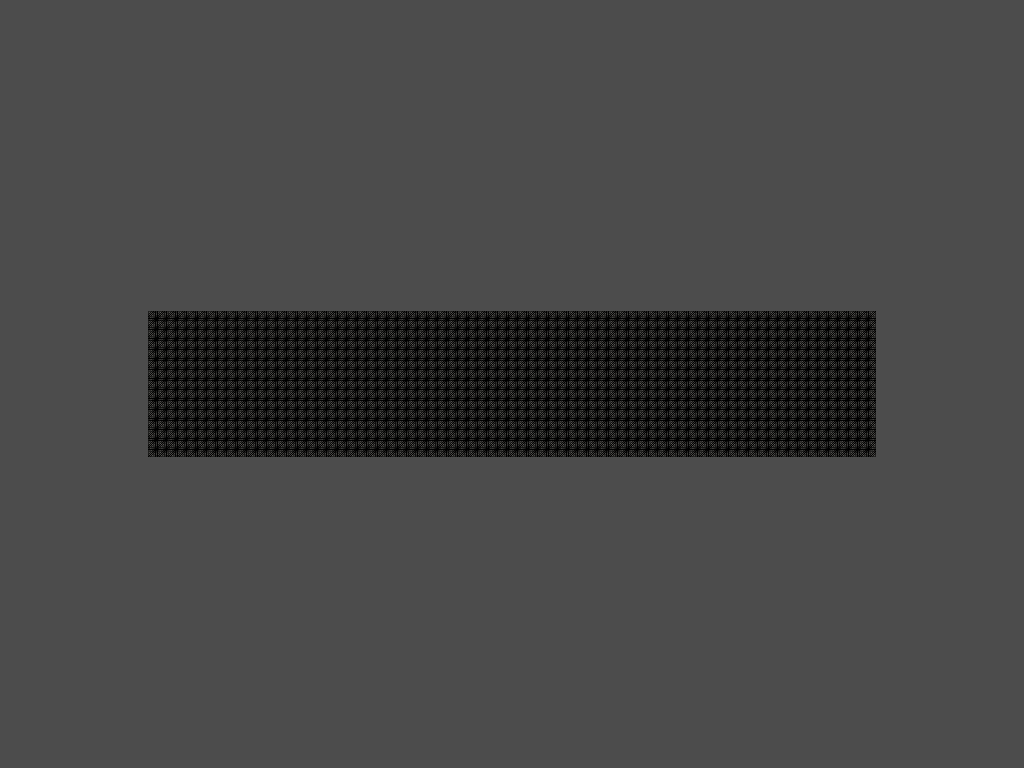

In [10]:
# Create the mesh

size_msh_x = 80*domain_length
size_msh_y = 80
msh = create_rectangle(MPI.COMM_WORLD,
                       [np.array([0, 0]), np.array([5, 1])],
                       [size_msh_x, size_msh_y],
                       CellType.triangle, GhostMode.none)
    
    
#Create the subdomains and space for Robin boundary condition in this problem

tol = 1E-14 # tolerance (we cannot use strict equalities)

boundaries = [(1, lambda x: abs(x[1])<= tol),   # Robin BC, at the bottom
              (2, lambda x: abs(x[1]-1)<= tol)]   # Neumann BC, at  the surface


# We now loop through all the boundary conditions and create MeshTags identifying the facets for each boundary condition
facet_indices, facet_markers = [], []
fdim = msh.topology.dim - 1

for (marker, locator) in boundaries:
    facets = locate_entities(msh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(msh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


# To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the MeshTags to file
msh.topology.create_connectivity(msh.topology.dim-1, msh.topology.dim)
#with XDMFFile(msh.comm, "facet_tags.xdmf", "w") as xdmf:
#    xdmf.write_mesh(msh)
#    xdmf.write_meshtags(facet_tag)

# Now we can create a custom integration measure ds, which can be used to restrict integration. 
#If we integrate over ds(1), we only integrate over facets marked with value 1 in the corresponding facet_tag

ds = Measure("ds", domain=msh, subdomain_data=facet_tag)

pyvista.global_theme.jupyter_backend = 'static' #"pythreejs" triggers errors --> 'static'
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

tdim = msh.topology.dim
topology, cell_types, geometry_pyvista = plot.create_vtk_mesh(msh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry_pyvista)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

figure = plotter.screenshot("fundamentals_mesh.png")
plotter.show()

In [11]:
# Gather coordinates of mesh points that are at the surface

facets_surface = facet_tag.find(2) # points at the surface boundary were marked with marker 2 (see previous cell)

fdim = msh.topology.dim - 1
msh.topology.create_connectivity(fdim, 0)

num_facets_owned_by_proc = msh.topology.index_map(fdim).size_local
geometry_entitites = dolfinx.cpp.mesh.entities_to_geometry(msh, fdim, np.arange(num_facets_owned_by_proc, dtype=np.int32), False)
points = msh.geometry.x

surface_coordinates=[]
for e, entity in enumerate(geometry_entitites):
    if e in facets_surface:
        coord1, coord2 = points[entity][0], points[entity][1]
        surface_coordinates.append(coord1)
        surface_coordinates.append(coord2)

surface_coordinates = np.unique(surface_coordinates, axis=0) # remove duplicates    

# Prepare the tools to find corresponding cells

bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)
cells = []

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, surface_coordinates)

# Choose one of the cells that contains the point

colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, surface_coordinates)

for i, point in enumerate(surface_coordinates):

    if len(colliding_cells.links(i))>0:

        cells.append(colliding_cells.links(i)[0])

surface_coordinates


array([[0.    , 1.    , 0.    ],
       [0.0125, 1.    , 0.    ],
       [0.025 , 1.    , 0.    ],
       ...,
       [4.975 , 1.    , 0.    ],
       [4.9875, 1.    , 0.    ],
       [5.    , 1.    , 0.    ]])

In [12]:
# We define the finite elements function space

#P2 = ufl.VectorElement("Lagrange", msh.ufl_cell(), 2)
P1 = ufl.FiniteElement("Lagrange", msh.ufl_cell(), 1)

V = FunctionSpace(msh, P1)
#Q = FunctionSpace(msh, P1)

In [28]:
# Define the class of boundary conditions 

class BoundaryCondition():
    def __init__(self, type, marker, values):
        self._type = type
        if type == "Dirichlet":
            u_D = Function(V)
            u_D.interpolate(values)
            facets = facet_tag.find(marker)
            dofs = locate_dofs_topological(V, fdim, facets)
            self._bc = dirichletbc(u_D, dofs)

        elif type == "Neumann":
            self._bc = inner(values, v) * ds(marker)

        elif type == "Robin":
          #self._bc = values[0] * inner(u-values[1], v)* ds(marker)
          # slight modification: returns 2 integrals, one for the bilinear form a and one for the linear form L
            self._bc = values[0] * inner(u,v)* ds(marker), values[0] * inner(values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))

    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type


version = "sum"

# Define variational problem: Trial and test functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define the source terms (based on tunable parameters at the top)
f = Constant(msh, PETSc.ScalarType(rho*gx))
f = Constant(msh, PETSc.ScalarType(0))

tau_fct = lambda x: np.exp(np.sin(12*np.pi*x[0]))
tau = Function(V)
tau.interpolate(tau_fct)

# Define the bilinear form
bilinear = inner(grad(u), grad(v)) * dx

# Define the linear form
L = inner(f, v) * dx



def forward_map(theta,L=L):
    """
    Forward map for the inverse model. Maps the coefficients

    Keyword arguments:
    theta --
    L -- linear form of the weak formulation
    
    Returns:
    surface_coordinates -- coordinates of points at the surface
    u_values -- values of the velocity at the surface
    """


    #-----------------SET THE BOUNDARY CONDITIONS FOR THE PROBLEM----------------------------------------------

    # Set the values for Neumann BC
    values_boundary_neumann = tau 

    # Set the values for Robin BC
    beta = build_beta(theta)
    
    r = Function(V)
    r.interpolate(beta)
    s = Constant(msh, PETSc.ScalarType(0))
    values_boundary_robin = (r,s)

    # Gather the Boundary conditions
    boundary_conditions = [BoundaryCondition("Robin", 1, values_boundary_robin),
                        BoundaryCondition("Neumann", 2, values_boundary_neumann)]

    bcs = []
    for condition in boundary_conditions:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)

        elif condition.type == "Neumann":
            linear_term = condition.bc
            L+= linear_term

        elif condition.type == "Robin":

            bilinear_term, linear_term = condition.bc

            if version == "sum":
                a = bilinear + bilinear_term

            else:
                a[0].append(bilinear_term) # add the modification to bilinear form


            L+= linear_term   # add the modification to linear form

        else: 
            print("Unhandled condition type")

    
    #-----------------------------ASSEMBLE AND SOLVE-----------------------------------------------

    # Assemble LHS matrix and RHS vector
    #print(a)
    a,L = form(a),form(L)

    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)

    fem.petsc.apply_lifting(b, [a], bcs=[bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    fem.petsc.set_bc(b, bcs)

    # Create and configure solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("superlu_dist")

    # Compute the solution
    uh = Function(V)
    ksp.solve(b, uh.vector)
    
    #-----------------------------EVALUATE ON THE SURFACE AND OUTPUT VALUES-------------------------
    
    u_values = uh.eval(surface_coordinates, cells)
    #p_values = ph.eval(surface_coordinates, cells)

    return surface_coordinates, u_values, uh

# MCMC

## Generating the synthetic data: "true coefficients" and the measurements¶

Values of the true coefficients set to [-0.12880844 -0.38654989 -0.357012    0.41749257  0.66138015]


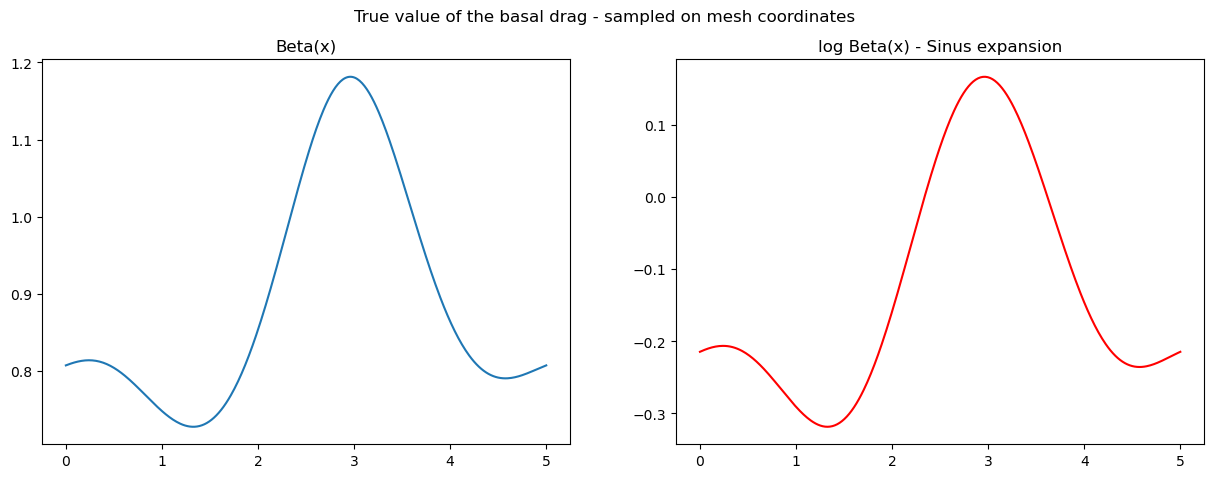

In [29]:
### Generating synthetic data

# Generate K coefficients following prior assumptions
theta_0 = np.random.normal(loc=0.0, scale=1, size=K)
#theta_0 = np.array([0.7, 0, 0, 0])

print(f"Values of the true coefficients set to {theta_0}")

# Build the true function
beta_0 = build_beta(theta_0)
interval = [(x,0) for x in np.linspace(0,5,size_msh_x)]


# Plot

plt.figure(figsize=(15,5))
plt.suptitle("True value of the basal drag - sampled on mesh coordinates")

plt.subplot(1,2,1)
plt.title("Beta(x)")
plt.plot([x[0] for x in interval], [beta_0(x) for x in interval])

plt.subplot(1,2,2)
plt.title("log Beta(x) - Sinus expansion")
plt.plot([x[0] for x in interval], [np.log(beta_0(x)) for x in interval],'r-')

plt.show()

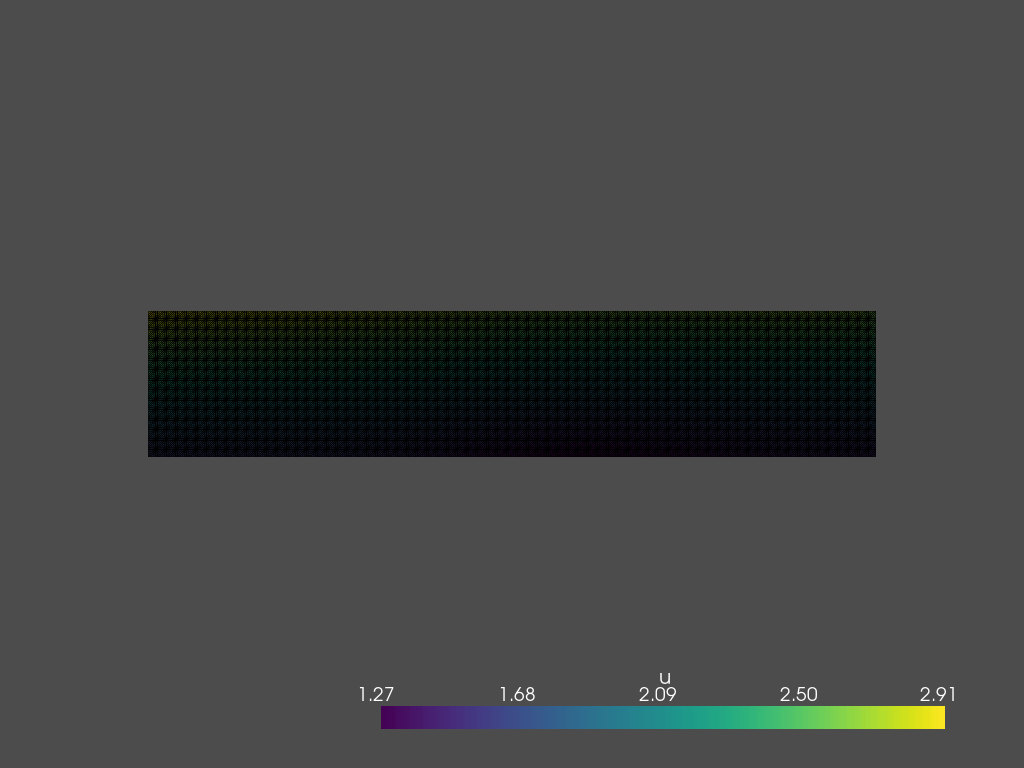

In [92]:
# We repeat N experiments of measurements with the true coefficients and noise

# Retrieve the true values according to the model with true coefficients

surface_coordinates, u_values_true, uh = forward_map(theta_0)
#print(u_values_true)


#-----------------------------------Plot the true value-----------------------------------

pyvista.global_theme.jupyter_backend = "static" #"pythreejs" triggers errors
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

# Create a pyvista-grid for the mesh
topology, cell_types, geometry = plot.create_vtk_mesh(uh.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Create a point cloud
function_grid.point_data["u"] = uh.x.array.real


# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(function_grid, show_edges=True)
plotter.view_xy()

plotter.show()


# -------------------------------Simulate noisy observations--------------------------------
N= 100
scale_noise = 0.01

observations = []

for n_obs in range(N):
    observation = u_values_true.copy()
    added_noise = np.random.normal(loc=0.0, scale=scale_noise, size=np.shape(observation)) # add gaussian noise at every evaluation
    observation+=added_noise

    observations.append(observation)
    
    

    

## Run the MCMC

In [93]:
# Auxiliary functions

def compute_loglikelihood(model_values, observations):
    """
    Keyword arguments:
    observations -- array, list of observations at the surface
    model_values -- array, outputs of the model (forward map) for the velocity at the surface

    Returns:
    loglikelihood -- int, the loglikelihood defined as in Richard Nickl's notes
    """
    loglikelihood = 0

    for i in range(len(observations)):
        observation = observations[i]
        #print(model_values, observation)
        #print(model_values - observation)
        #print(np.sum((model_values - observation)**2))
        loglikelihood+= np.sum((model_values - observation)**2)

    loglikelihood = -1/2 * loglikelihood  / (scale_noise**2)
    return loglikelihood



def compute_proposal_pcn(current_value, gamma):
    """
    Compute the proposal value for the coefficients of beta function for pCN scheme

    Keyword arguments:
    current_value -- array, current value of the Markov chain
    gamma -- float, step size

    Returns:
    proposal -- array, proposal for the next state of the Markov chain
    """
    #print("Current value: ", current_value)

    proposal = np.sqrt(1-2*gamma)*current_value + np.sqrt(2*gamma)*np.random.normal(loc=0.0, scale=scale_coefficients, size=len(current_value))
    
    #print("Proposal: ", proposal)

    return proposal



def metropolis_step(current_loglikelihood, proposal_loglikelihood, accept_reject):
    """
    Practice the Metropolis-Hastings step for the pCN scheme 
    
    Keyword arguments:
    current_loglikelihood -- int, current loglikelihood
    proposal_loglikelihood -- int, loglikelihood of the proposal

    Returns:
    boolean -- True if we accept the proposal, False otherwise
    """
    acceptance_probability = min(0, proposal_loglikelihood - current_loglikelihood)
    
    #print(f"Proposal likelihood: {proposal_loglikelihood}, Current likelihood: {current_loglikelihood}")
    #print("Accept proba:", acceptance_probability)
    # We draw a U([0,1]) r.v and return the proposal with probability acceptance_probability

    draw = np.random.uniform()
    print(np.exp(acceptance_probability))

    return np.log(draw) < acceptance_probability

In [94]:
# RUN THE MARKOV CHAIN

# Parameters of the MCMC
n_iter = 200000 # number of iterations of the chain
gamma = 0.00000001 # step size
scale_coefficients = 1 # Gaussian prior for coefficients



# INITIALISATION

theta = np.random.normal(loc=0.0, scale=scale_coefficients, size=K)
#theta = np.array([10,-4,5,3])
#theta = theta_0  #initialise at true value

# Compute the model and likelihood of this proposal
surface_coords,model_values,uh = forward_map(theta)
current_loglikelihood = compute_loglikelihood(model_values, observations)

# Useful tables to store values

chain = np.zeros((n_iter,K)) # store the values of the chain
chain[0, :] = theta

accept_reject = np.zeros(n_iter, dtype=bool) # boolean table we use to track whether the proposal was accepted/rejected
accept_reject[0] = True 

likelihoods = np.zeros(n_iter)
likelihoods[0] = current_loglikelihood # store values of likelihoods


#--------------------ITERATE--------------------------------------------------

for iter in range(n_iter):

    if iter % 10 == 0:
        print(f"Iteration nb {iter} done")
        
        # Save runs as numpy files
        np.save(f"Lchain_{n_iter}_{gamma}_{N}", np.array(chain))
        np.save(f"Llikelihoods_{n_iter}_{gamma}_{N}", np.array(likelihoods))
        np.save(f"Lacceptance_{n_iter}_{gamma}_{N}", np.array(accept_reject))

    # Get the proposal for new value
    proposal = compute_proposal_pcn(theta, gamma)
    #print('Proposal: ', proposal)

    # Compute the model and likelihood of this proposal
    surface_coords, model_values,uh = forward_map(proposal)
    proposal_loglikelihood = compute_loglikelihood(model_values, observations)

    # Metropolis step
    accept = metropolis_step(current_loglikelihood, proposal_loglikelihood, accept_reject)

    if accept:
        #print('accepted')
        accept_reject[iter]=True
        theta = proposal.copy()
        current_loglikelihood = proposal_loglikelihood

    else:
        #print("rejected")
        accept_reject[iter]=False


    chain[iter,:] = theta
    likelihoods[iter]= current_loglikelihood

    
# Final save as numpy files
np.save(f"Lchain_{n_iter}_{gamma}_{N}", np.array(chain))
np.save(f"Llikelihoods_{n_iter}_{gamma}_{N}", np.array(likelihoods))
np.save(f"Lacceptance_{n_iter}_{gamma}_{N}", np.array(accept_reject))

Iteration nb 0 done
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 10 done
1.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
Iteration nb 20 done
1.0
1.0
3.7608701731078126e-218
1.0
1.0
1.0
1.0
1.0
0.0
3.4520566935973747e-112
Iteration nb 30 done
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 40 done
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
Iteration nb 50 done
0.0
0.0
1.0
0.0
0.0
1.0
0.0
9.811854438540511e-173
1.0
0.0
Iteration nb 60 done
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
Iteration nb 70 done
0.0
4.322979404395057e-185
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
Iteration nb 80 done
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
Iteration nb 90 done
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
Iteration nb 100 done
1.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
Iteration nb 110 done
1.0
0.0
5.265893611386548e-131
0.0
0.0
0.0
1.0
1.0
0.0
1.0
Iteration nb 120 done
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
Iteration nb 130 done
0.0
0.0
1.0
3.696594326788522e-273
1.0
0.0
1.0
1.0
1.0
5.733235958669124e-283
Iteratio

0.0
0.0
1.0
0.0
1.0
1.0
Iteration nb 1200 done
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
2.007216281487914e-159
7.353283361160269e-189
Iteration nb 1210 done
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
Iteration nb 1220 done
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
Iteration nb 1230 done
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
Iteration nb 1240 done
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
Iteration nb 1250 done
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
Iteration nb 1260 done
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
Iteration nb 1270 done
1.0
0.0
0.0
0.0
1.0
1.1015030396367841e-77
1.0
1.0
0.0
0.0
Iteration nb 1280 done
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
Iteration nb 1290 done
0.0
1.0
2.4755042449325158e-52
0.0
1.0
1.0
1.0
1.0
1.0
0.0
Iteration nb 1300 done
0.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
Iteration nb 1310 done
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
Iteration nb 1320 done
0.0
1.079276861804082e-291
0.0
1.0
1.0
0.0
0.0
8.916629369299097e-108
1.0
1.0
Iteration nb 1330 done
0.0
0.0
1.0
1.0
1.0


0.0
1.0
1.0
1.0
6.447554528530775e-279
2.853965229018203e-60
0.0
Iteration nb 2310 done
1.0
0.0
1.0
1.0
1.0
4.139764714406328e-115
1.2064042480343181e-39
1.0
1.0
0.0
Iteration nb 2320 done
0.0
1.0
4.970038237182346e-148
0.0
1.0
1.0
0.0
1.0
1.0
0.0
Iteration nb 2330 done
1.0
2.2534062581225615e-270
1.0
1.0
0.0
1.0
1.0
3.7189362413913477e-116
1.0
0.0
Iteration nb 2340 done
1.0
1.0
0.0
0.0
1.0
1.0
0.0
5.208123562441242e-268
1.0
1.0
Iteration nb 2350 done
1.0
1.0
0.0
0.0
0.0
0.0
4.475680779101351e-115
1.0
4.673266754039487e-135
1.0
Iteration nb 2360 done
1.0
1.0
0.0
0.0
0.0
8.279031902596158e-176
0.0
1.0
0.0
0.0
Iteration nb 2370 done
0.0
1.625290902336443e-107
1.0
0.0
0.0
1.0
1.0
3.359824663699372e-303
1.0
5e-324
Iteration nb 2380 done
2.6487868286100505e-251
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
Iteration nb 2390 done
1.0
0.0
1.0
0.0
1.0
1.0
2.4608580648802683e-141
8.782588180504392e-123
1.0
0.0
Iteration nb 2400 done
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 2410 done
0.0
1.0
1

1.0
1.0
1.0
Iteration nb 3040 done
1.4278978905337637e-161
6.73441837102046e-310
0.0
1.0
1.0
0.0
6.303202412282043e-130
1.0
1.0
1.0
Iteration nb 3050 done
0.0
1.0
0.05777127008558297
1.0
1.6214349588390348e-68
0.0
0.0
1.1247614080094266e-278
1.0
1.0
Iteration nb 3060 done
1.0
0.0
1.0
1.6860734010456542e-220
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 3070 done
1.0
9.54510825858753e-13
0.0
2.1653446729017277e-224
6.8623039802146045e-71
1e-323
0.0
1.0
1.0
0.0
Iteration nb 3080 done
0.0
1.0
1.864808802528841e-46
0.0
9.501662052411016e-285
1.7757309870189577e-06
1.0
1.9031744308855358e-135
1.0
1.0
Iteration nb 3090 done
1.0
0.0
1.0
1.0
4.2491914726888466e-207
1.0
1.051917198558206e-228
0.0
2.422597822962966e-302
1.0
Iteration nb 3100 done
1.0
1.0
1.0
1.0
2.039752396036054e-122
0.0
3.208064314062225e-228
1.0
1.0
0.0
Iteration nb 3110 done
2.2169199319554316e-270
0.0
0.0
1.0
0.0
0.0
1.9760398760661916e-178
1.0
1.2154067014479575e-121
4.719748023926004e-72
Iteration nb 3120 done
2.3510893937225514e-

1.0
0.0
0.0
0.0
0.0
1.0
1.0
8.151464982159048e-68
Iteration nb 3710 done
1.0
5.542984844162745e-176
1.0
1.0
1.0
5.349924732066391e-81
1.0
1.0
7.519079582523079e-68
1.0
Iteration nb 3720 done
1.2139658621128615e-135
1.0
2.7375707545772502e-05
3.7733802221314234e-112
0.0
1.0
0.0
2.1692380657770468e-64
0.0
1.0
Iteration nb 3730 done
1.6542048168459977e-33
1.0
2.346438451428532e-227
1.7325606226024397e-21
1.0
0.0
1.0
1.0
1.0
1.0028798963562396e-153
Iteration nb 3740 done
0.0
1.4157593946360677e-86
1.7605013382940802e-10
1.0
0.0
1.0
1.0
0.0
3.4389725021153395e-159
0.0
Iteration nb 3750 done
4.108472427692196e-232
1.0
0.0
1.2268782626734603e-23
1.0
0.0
1.5089662856868437e-188
0.0
0.0
0.0
Iteration nb 3760 done
1.0
3.5638613371711456e-86
1.0
3.236474237026518e-279
3.9502387e-316
0.0
1.0
1.0
1.0
1.0
Iteration nb 3770 done
0.0
2.3629162937341144e-289
1.0
1.0
1.700364423932424e-173
1.0
1.6657191151575631e-06
1.0
0.0
1.0
Iteration nb 3780 done
1.482682681955347e-127
2.4405966909539676e-140
1.0
1.

0.0
2.8726222497332254e-225
1.0
0.0
4.707372975194145e-38
0.0
4.805733729529498e-279
5.881340497116132e-39
1.0
Iteration nb 4390 done
3.0137481885368165e-53
1.0
1.0
1.0
1.0
1.9491374268366008e-156
1.0
1.0
5.107016596154757e-303
1.0
Iteration nb 4400 done
1.0
1.0
2.2623226068899265e-90
0.1450619552530619
1.0
0.0
1.0
5.3113305729708916e-154
0.0
2.073788839528385e-35
Iteration nb 4410 done
1.0
3.1872714720754783e-189
1.0
7.780821891000447e-77
1.799120310157649e-207
1.0
1.0
1.0
0.0
3.804730141781869e-11
Iteration nb 4420 done
1.0
1.0
1.0
5.32489121851568e-224
1.1792527001818416e-175
1.1467175125593588e-211
1.0
1.0
1.0
0.0
Iteration nb 4430 done
1.0
3.8665438358713455e-293
1.0
1.0
0.0
0.0
7.145676593521521e-232
1.0
1.4803356923311327e-93
1.0
Iteration nb 4440 done
2.0049994392081e-59
1.0
0.0
1.0
1.0697860463741532e-281
3.9357905998154086e-264
1.0
1.0
1.0
1.0
Iteration nb 4450 done
1.2958028762821958e-269
3.232254174757399e-262
0.0
2.98139477606188e-309
1.1685380733982443e-109
1.0
1.29336820

1.0
1.0
Iteration nb 5050 done
0.0
1.2253088470003725e-25
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
Iteration nb 5060 done
1.0
1.0
3.6554341374597066e-118
1.0
3.20990321096216e-18
2.8465298613741706e-160
1.0
1.0
1.0
1.0
Iteration nb 5070 done
1.0
2.8415833075454438e-126
1.0
1.0
3.346675273799829e-61
1.5517140478574023e-190
1.0
1.0
1.0
1.0
Iteration nb 5080 done
1.0
1.0
1.0
1.0
5.3585282169807077e-76
1.0
1.0
0.0
1.0
1.0
Iteration nb 5090 done
0.0
1.0
0.0
1.0
0.007242209917837323
0.0
0.0
1.0
1.6713229430452184e-28
0.0
Iteration nb 5100 done
5.219660740600442e-92
5.4256690930419965e-193
0.0
1.0
1.0
1.0
0.0
4.7852292215449283e-197
1.0
0.0
Iteration nb 5110 done
0.0
1.0
0.0
1.0
1.0
2.913104626947313e-189
1.0
1.0
1.0
1.7316825140486218e-34
Iteration nb 5120 done
1.0
1.0
0.0
0.0
1.0
1.0
2.0429051239105084e-186
1.0
1.0
0.0
Iteration nb 5130 done
2.2316112305834763e-29
8.340620313301569e-46
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
Iteration nb 5140 done
1.0
4.189980451242648e-13
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
It

1.0
0.0
1.0
1.0
0.0
1.0
2.75554826808667e-310
1.847077784747903e-67
1.0
1.0
Iteration nb 5750 done
1.3811631029806546e-217
1.0
3.7083575768834054e-63
0.0
0.0
1.228629083889441e-56
1.6637174093131642e-296
1.0
8.284381438451289e-196
0.0
Iteration nb 5760 done
0.0
1.0
1.0
1.0
1.697276431185432e-157
1.0
0.0
1.57179027849455e-187
1.0
1.0
Iteration nb 5770 done
1.0
1.0
1.0
7.402533837647068e-178
1.0
1.0
1.0
1.0
1.0
3.176776221196492e-248
Iteration nb 5780 done
1.0
1.0672125847791858e-282
4.941807716623585e-133
1.3233187641717829e-278
3.5012391331026557e-192
4.193353398053195e-167
6.437584994677232e-164
1.0
1.0
1.0
Iteration nb 5790 done
1.0
1.0
1.0
1.0
1.0
9.559758305127914e-86
0.0
1.0
1.0
3.308908426769379e-58
Iteration nb 5800 done
3.5208374345964085e-191
0.0
0.0
1.0
1.0
8.444929401962581e-273
1.0
1.0
1.0
0.0
Iteration nb 5810 done
1.0440500998856503e-37
1.0
4.178651233319122e-57
5.02215147e-314
3.3057149026016916e-31
4.910526017933784e-25
0.0
1.0
9.72285908837109e-221
1.0
Iteration nb 582

1.0
1.0
1.0
1.0
1.0
1.0
7.703229674056296e-84
0.0
1.0
0.0
Iteration nb 6390 done
1.0
1.583516031528251e-22
1.0
0.0
1.0
1.0
2.9490516262808123e-105
8.506286276779384e-57
1.0
1.0
Iteration nb 6400 done
0.0
1.0
9.871377371569224e-269
4.299979345230436e-242
1.0
1.0
1.0
8.558713644816152e-217
1.0
1.0
Iteration nb 6410 done
0.0
4.962669756607613e-84
0.0
0.0
1.0
5.8041012920469014e-204
1.0
1.785527843533824e-15
8.976008028003844e-49
1.0
Iteration nb 6420 done
1.0
1.0
1.0
1.0
1.8445563440091979e-224
1.0
4.12919589020304e-227
3.6033578042329896e-15
1.0
1.7111745985378755e-249
Iteration nb 6430 done
1.0
1.0
0.0
8.39215829559405e-205
1.0
1.0
1.740526646832871e-58
1.0
1.0
2.545908832722714e-296
Iteration nb 6440 done
1.0
2.612402403039614e-125
1.0
3.480296915341298e-39
1.0
1.360598401872241e-50
1.0
1.0
7.801681779346718e-57
1.0
Iteration nb 6450 done
0.0
2.0611761010528387e-204
1.0
1.0
1.0
1.321781568133768e-236
1.0
1.1548174850036e-311
1.3845499069753742e-42
4.804419948515617e-184
Iteration nb 64

1.0
1.0
1.0
5.829910656154826e-244
1.0
1.0
0.0
1.0
Iteration nb 7010 done
1.0
1.0
0.0
1.7109503099462576e-131
5.7110673769381344e-95
1.0
1.0
1.0228973144957706e-72
1.26618556e-316
1.7561503884988477e-225
Iteration nb 7020 done
0.0
1.0
8.56916312101321e-194
4.5074661052328164e-263
0.0
1.0
1.0
0.0
0.0
3.223065204085629e-269
Iteration nb 7030 done
1.0
1.0
6.460331260782441e-11
3.5748680120830153e-237
0.0
1.0
2.307314902545075e-176
1.0
0.0
0.0
Iteration nb 7040 done
1.54604042307814e-209
0.0
0.0
3.882158056864685e-266
0.0
0.0
7.969093435227002e-29
1.0
1.904476336968141e-308
4.390074685680283e-109
Iteration nb 7050 done
1.0
1.0
1.0
0.0
8.503963555337223e-187
1.0
0.0
1.0
1.0
0.0
Iteration nb 7060 done
1.0
8.526167272623911e-11
1.128627275933676e-50
0.0
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 7070 done
5.630520432332463e-19
0.0
1.0
0.0
1.930548658248105e-60
1.2289883496665452e-05
1.0
1.0
3.952501291441677e-229
1.0
Iteration nb 7080 done
1.1256091081261556e-298
0.0
1.0
1.0
1.804836e-317
7.6293999

1.0
6.384027874067522e-238
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
Iteration nb 7670 done
1.0
1.0
1.0
1.0
3.710620154811398e-97
4.325554090671035e-154
1.0
1.0
1.0
1.0
Iteration nb 7680 done
0.0
2.612703035626409e-206
0.0
0.0
1.0
1.0
2.7999396982910927e-161
1.0
0.0
1.9383585339063704e-139
Iteration nb 7690 done
1.111147689649413e-198
0.0
1.0
1.1036782017747151e-30
1.0
1.0
1.0
1.0
1.0
1.48436547857448e-184
Iteration nb 7700 done
1.0
5.908484540642719e-230
0.0
6.866705368809747e-135
1.0
1.0
9.80162579998438e-115
1.0
1.0
5.013984920495654e-122
Iteration nb 7710 done
2.2327301107676225e-127
1.0
3.982910165231706e-176
2.857662792205424e-25
1.0
1.0
1.1897567787467754e-164
1.0
8.138949855522469e-250
2.1192006290883062e-266
Iteration nb 7720 done
1.0
1.0
3.928816473787342e-226
4.696645392455659e-219
1.0334688439236317e-46
1.0
1.226775350490567e-202
1.0
1.872991988138722e-100
1.0
Iteration nb 7730 done
1.1206251762666717e-125
7.143907821168088e-297
1.0
1.0
1.0
1.919868343032148e-154
1.1043525975881216e-

1.5597332274813733e-289
1.0
6.98406131291091e-60
1.0
6.53393907248844e-163
1.0
1.0
1.0
Iteration nb 8280 done
0.0
1.0
1.0
1.0
1.0
5.2969566268443896e-08
2.7844364639402296e-66
1.0147852567472607e-286
1.0
4.5000247317429454e-244
Iteration nb 8290 done
1.0
7.291303384543519e-128
1.89525837823471e-27
1.0
1.0
1.0
1.6371593683094336e-164
1.0
1.0
1.0
Iteration nb 8300 done
1.0
1.0
8.740319293369544e-171
1.0
8.754034555666727e-149
5.5091631858654185e-139
1.0
1.0
0.0
1.0
Iteration nb 8310 done
2.949158291979504e-309
1.0
1.0
1.7094992903751776e-144
2.717586424358889e-219
1.5019323088825384e-46
0.0
1.0
1.4342393265256788e-291
1.0
Iteration nb 8320 done
1.0
1.3729771584169315e-76
2.7700007696905804e-266
1.0
1.0
1.0
1.0
1.0
1.0
2.807991718195104e-07
Iteration nb 8330 done
1.0
1.0
3.4121522589107766e-86
1.2366322479182298e-247
4.7203097310584696e-37
1.0
1.0
1.0
1.0
1.2056384541433811e-86
Iteration nb 8340 done
2.3936715458406303e-177
1.0
1.0
1.0
1.0
1.0
1.0
2.400341947360372e-112
8.364624483711438e

0.0
1.0
0.0
Iteration nb 8900 done
2.5313963329006263e-206
6.8179322315199255e-273
1.697830656269796e-59
8.014149841216116e-53
1.0
1.0
1.0
1.0
0.0
1.0
Iteration nb 8910 done
1.0
1.0
1.0
1.041481746163883e-65
1.0
4.686652844521923e-25
1.0
1.1863032043415305e-238
1.0
0.0
Iteration nb 8920 done
4.996469991004982e-137
1.0
1.0
0.0
6.602704125098896e-252
1.0
1.0
1.0
5.1085155817510734e-18
3.4144071296123925e-210
Iteration nb 8930 done
7.359456714858538e-20
1.4377720732242354e-248
4.770107984406496e-210
3.326578269591746e-92
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 8940 done
8.128698592370028e-40
0.0
2.293162598820689e-203
0.0
0.0
9.83759922578624e-72
1.0
0.0
1.0
6.111003194573284e-65
Iteration nb 8950 done
1.0
1.0
1.0
4.4823569681247655e-287
1.0
2.521579571673702e-33
0.0
1.6266553321145585e-193
1.0
0.0
Iteration nb 8960 done
1.0
1.0
0.0
5.213889299493684e-05
3.741230291379033e-264
1.0
6.049567088562094e-119
1.811348293267543e-69
0.0
7.92684909497248e-28
Iteration nb 8970 done
3.6435201077069394e

0.0
Iteration nb 9520 done
0.0
0.0
1.0
1.0
6.33799428346482e-167
1.0
3.1770281424610348e-217
1.0
1.1351249118053975e-241
1.0
Iteration nb 9530 done
1.48807769125496e-250
1.0
0.0
1.0
9.303866066535681e-272
1.0
3.591280633216428e-157
1e-323
0.0
1.0
Iteration nb 9540 done
0.0
1.6128460405922082e-107
3.374452285238455e-195
1.0
1.0
1.5426122032391841e-65
0.0
1.0
1.0
5.6584897920986965e-36
Iteration nb 9550 done
1.0
1.0
1.0
3.76912285313905e-72
1.0
0.0
9.329789044035417e-163
1.2243378791570396e-230
1.0
1.0
Iteration nb 9560 done
1.0501982978407833e-182
4.177646778528268e-242
1.0
1.0
1.276467118119145e-59
1.0
1.0
3.425015657266501e-140
1.0
6.903074944015583e-28
Iteration nb 9570 done
0.0
2.9082679310731392e-58
1.0
1.0
7.700366002517229e-41
1.0
1.0
6.742283498091368e-219
4.661338791925461e-166
1.95045316533586e-37
Iteration nb 9580 done
1.0
1.0
2.757201407720043e-266
0.0
1.0
1.674154591427651e-171
1.0
5.849772898263825e-84
1.0
2.998506746776468e-18
Iteration nb 9590 done
1.0
0.0
1.0
1.0
0.0
6.

1.0
1.0
1.0
1.0
1.0
5.223296387390792e-271
1.0
0.0
2.8404223439239293e-57
1.0
Iteration nb 10120 done
2.544941810295164e-233
1.381084354642945e-138
1.5522590578909756e-77
9.658818565401185e-94
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 10130 done
3.192920726437978e-55
1.0
1.027714997245112e-185
1.0
4.7160890342165946e-52
6.000231313336935e-186
5.9784996870252406e-183
1.0
4.7888479328274793e-91
1.0
Iteration nb 10140 done
1.0
2.9066370474794505e-23
1.0
3.0658612492182413e-118
0.00015126747912770625
1.0
1.0
1.538920711399074e-104
5.988421651368724e-22
1.0
Iteration nb 10150 done
1.0
1.0
1.0
0.0
1.0
1.0
7.326883532863371e-217
1.303741073949548e-162
1.0
1.0
Iteration nb 10160 done
1.0
1.0
1.0
1.4194795828900834e-64
1.0
1.5103477762832317e-288
0.0
1.0
4.955405274912606e-171
1.707482859324132e-200
Iteration nb 10170 done
1.0
1.0
0.0
2.7600228115385077e-227
3.927538038554074e-166
0.0
3.395826864947023e-260
2.989626894139164e-87
1.0
1.0
Iteration nb 10180 done
0.0
1.0
1.8197550987485112e-281
3.22569

1.0
1.0
1.0
2.247215028573274e-67
0.0
1.0
0.0
1.0
8.049800671669613e-94
1.0
Iteration nb 10720 done
1.0
1.0
1.0
8.365953743129566e-96
0.0
4.848389471571024e-09
1.0
0.0
0.004470355374591933
3.147499173813906e-83
Iteration nb 10730 done
2.1860817861545984e-287
3.058470485590925e-253
4.7696827078882544e-200
2.074311883754013e-101
1.0
4.6325699117008096e-114
5.975862316691148e-242
1.0
1.0
3.995805361187021e-302
Iteration nb 10740 done
1.8624934700722977e-34
1.0
1.598694575452399e-279
2.561627541999877e-246
0.0
5.257680928459921e-38
1.0
2.8058582939544572e-127
1.5075676201540805e-172
1.0
Iteration nb 10750 done
0.0
5.36569740905755e-295
1.0
3.0593750694929046e-08
1.0
1.0
1.0
4.209666171818003e-183
1.0
1.0
Iteration nb 10760 done
1.0
3.0473067743193962e-207
1.0
2.3286890288104707e-286
1.0
2.4701324670224052e-234
1.0
0.0
2.8815142111499235e-251
0.0
Iteration nb 10770 done
2.451003395459354e-111
5.73129233398039e-274
0.0
0.0
0.0
7.571806742975087e-248
1.0
1.0
1.0
2.0442930247970197e-104
Iterat

1.0
1.0
1.029334e-317
0.0
4.895699849556784e-204
Iteration nb 11310 done
2.850823287259773e-187
1.0
1.0
1.0
0.0
5.648727923128222e-173
1.0
1.0
1.0
1.0
Iteration nb 11320 done
1.0
1.0
1.0
1.7440738723496532e-183
1.3687015225979226e-40
1.0
0.0
1.0
5.266933469667398e-292
1.0
Iteration nb 11330 done
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.588480436682455e-207
1.0
1.0
Iteration nb 11340 done
0.0
1.0
1.0
1.0
1.945432808672334e-133
6.899838084371142e-11
1.0
9.8079722369304e-47
4.2514939580363136e-284
1.0
Iteration nb 11350 done
1.0
1.0
1.0
1.0
8.045165290062616e-49
1.0
1.0
1.0
0.0
3.2567030577933213e-134
Iteration nb 11360 done
0.0
1.3492e-319
2.0449061329136958e-91
8.876078801739738e-173
1.0
1.0
2.3183398696768994e-68
9.410732725639821e-19
6.449800046622247e-193
1.0
Iteration nb 11370 done
2.503566289952655e-157
8.728660218238787e-156
1.0
1.0
3.641908693180302e-179
1.052508441305746e-225
0.0
1.0
0.0
0.0
Iteration nb 11380 done
1.0
0.0
6.20214036102797e-168
1.0
1.0
0.0
1.0
1.0
0.0
1.1099580268371237e-8

5.274068651609017e-39
3.4864525998700786e-278
1.0
1.0
Iteration nb 11910 done
0.0
3.6893348089189714e-112
2.628201248262806e-146
9.456302345586207e-309
3.16567695979839e-173
1.0
1.0
0.00012359058216693613
1.0
3.318048835939496e-70
Iteration nb 11920 done
3.6022687000312875e-46
2.3983549805753786e-176
1.0
1.0
1.0
1.0
9.303558238111041e-05
1.0
1.0
3.794008909313341e-85
Iteration nb 11930 done
6.073719956748316e-129
1.0
0.0
2.166992475778674e-21
2.5284484585626484e-222
1.2188863437238872e-196
1.0
1.7998968694405372e-304
0.0
4.017710391075211e-133
Iteration nb 11940 done
9.527870083700937e-138
1.4071262227702488e-100
8.827531019706389e-93
1.0
1.4477787080780323e-223
7.71541429469821e-294
7.26544653049464e-234
1.0
1.832978932711455e-26
1.0
Iteration nb 11950 done
1.0
1.1334803473882135e-224
0.0
1.0
1.3944208278442455e-222
1.0
0.0
1.0
1.0
0.0
Iteration nb 11960 done
1.0
1.0
3.7133126601753795e-178
6.874171602143188e-146
1.0
1.0
0.0
1.0
1.0
2.3595557729986333e-64
Iteration nb 11970 done
1.0
0

1.0
1.0
Iteration nb 12480 done
1.0
1.0
5.968752253161832e-08
1.0
1.0
3.865881070502386e-226
1.0
1.1522798242156941e-249
1.6252162314211203e-208
0.0
Iteration nb 12490 done
1.0
3.105353580629245e-08
1.0
0.0
1.0
1.0
2.3167770586347575e-240
1.0872140546265647e-121
9.957678054403685e-165
0.0
Iteration nb 12500 done
5.8453819638165984e-254
1.0
1.0791559970261006e-77
6.652032978121679e-143
6.6114361814256834e-133
1.0
1.0
1.3467433284328943e-263
2.909444386648801e-45
1.1229114176154312e-109
Iteration nb 12510 done
8.203816691720649e-98
9.613232748057796e-12
1.0
4.573613787597401e-103
1.0
7.849847567077728e-139
0.0
7.081131748047613e-58
1.1247666325056834e-290
1.0
Iteration nb 12520 done
6.488516120166407e-292
8.502835988708743e-84
1.0
6.780535851753351e-72
1.0
1.0
1.0
0.0
1.0
5.443579089671986e-97
Iteration nb 12530 done
2.874247901100849e-273
1.0
1.4111574670518578e-216
6.33276595295064e-147
1.0
1.0
1.0
9.458774793303624e-121
2.810896290433293e-112
1.0
Iteration nb 12540 done
1.0
1.64674089

1.0
4.817130027768218e-137
1.0
3.4323064010062527e-174
6.293820559906081e-72
1.0
1.0
1.0
1.0193034150610749e-45
2.3431206355529695e-120
Iteration nb 13070 done
1.0
1.0
2.9727592697428954e-239
1.0
1.0
1.0
1.0
1.0
2.755679511609218e-21
7.958261635503815e-109
Iteration nb 13080 done
0.0
0.0
1.2469289996936888e-218
0.0
0.0
1.3298843063083908e-49
1.0
1.1539905287627179e-107
1.0
1.0
Iteration nb 13090 done
2.3339317730799776e-260
6.853261675032001e-256
6.42788330616646e-39
1.0
4.30262262674019e-139
0.0
1.0
1.96842801933464e-154
1.0
1.0
Iteration nb 13100 done
0.0
0.0
1.0
1.0
0.0
1.149480399394286e-34
0.0
1.0
1.0
1.258427040090984e-34
Iteration nb 13110 done
1.0
0.0
1.4583695827630234e-17
7.0759317506029226e-09
5.150942099494067e-295
1.0
0.0
1.028833259228619e-262
0.0
1.0
Iteration nb 13120 done
1.0
4.555541762351436e-108
1.7148648155836215e-305
1.0
1.0
1.2150627522232172e-158
2.2575431525727412e-48
1.0
1.0
2.5128135698206067e-291
Iteration nb 13130 done
0.0
2.4665860966547465e-112
1.0
1.0
2.

1.0
8.60463485744939e-22
Iteration nb 13660 done
9.793608157386125e-201
8.100751764706474e-249
5.618782282580935e-100
1.0
6.964843910024479e-147
1.0
1.0
5.38533743296505e-11
1.4781638977681654e-240
0.0
Iteration nb 13670 done
1.0
1.0
5.478625248453337e-178
1.0
1.0
1.0
3.641976964386149e-27
3.2895518272815975e-81
9.443963542344728e-44
1.1707901641434118e-31
Iteration nb 13680 done
1.0
2.97352290832865e-194
1.0
1.0
1.0
8.006196807491207e-203
0.0
1.0
1.0
1.5557018301863186e-156
Iteration nb 13690 done
6.0732485536796895e-134
1.0
4.312193616130229e-67
1.0
0.027754683813439603
8.182008385146009e-133
1.0
1.0
4.379630691012018e-248
8.28485380352222e-59
Iteration nb 13700 done
6.201586121550643e-83
1.0
5.124732912615763e-78
3.5251642216688196e-184
1.0
0.0
1.0
0.0
1.7490651308843477e-54
1.0
Iteration nb 13710 done
1.0
1.0
3.65500236906065e-202
0.0
1.0
4.2457774635846444e-134
2.720334327907579e-176
1.0
7.257993134208678e-217
0.0
Iteration nb 13720 done
1.0
2.4263155803843457e-175
1.0
1.0
1.0
1.0

1.0
Iteration nb 14220 done
1.8881493114740527e-67
1.0
1.0
4.38968607900733e-06
4.331840516578931e-37
1.716101758840899e-55
1.0
6.683907761081053e-84
1.0
1.0
Iteration nb 14230 done
1.0
1.0
1.0
1.0
0.0027824412137756175
1.0
1.0
1.1772963202577655e-63
3.5671855984169905e-136
1.0
Iteration nb 14240 done
2.915192540094845e-121
1.0
1.0
1.0
2.3759188008715524e-06
7.379795417552756e-100
1.0
1.2535629541016097e-138
1.0040615669640608e-98
0.0
Iteration nb 14250 done
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
6.068302468692801e-10
4.5959921992607615e-208
Iteration nb 14260 done
1.2984217726754953e-44
1.0
1.0
0.0
6.285601750215659e-302
4.494025911356643e-200
1.0
6.736868034141648e-16
1.0
1.0
Iteration nb 14270 done
1.0
1.0
1.0
6.820295757077963e-127
1.0
1.612081475e-314
1.0
2.88125316006013e-118
1.7318809432018664e-75
6.363951354446744e-35
Iteration nb 14280 done
1.0
1.0
1.0
2.3138479933502165e-06
5.778477271219537e-123
3.813589206763684e-115
1.0
6.06898990247245e-10
1.0
6.3457247112811895e-52
Iteration nb

0.0
0.0
1.3305279213775773e-246
Iteration nb 14800 done
1.724822994995357e-97
1.0
1.0
0.0
1.548570125593315e-41
8.764473736915254e-258
1.0
1.0
3.8972428265453244e-18
1.3563402247765336e-101
Iteration nb 14810 done
2.721637866060272e-138
7.721013334887988e-107
1.0
1.0
1.0
1.0
1.4159822142883365e-97
0.0
1.0
0.0
Iteration nb 14820 done
0.0
2.0816640657607247e-12
1.0
2.051419250126185e-168
1.0
1.0
1.0
3.361128311590148e-261
1.0
3.6353965257335253e-259
Iteration nb 14830 done
1.455333371912514e-06
7.863434750269652e-268
1.0
1.0
2.1904154259697722e-52
1.0
4.155235192538298e-14
0.0
3.1050175316594962e-294
1.6221178528471666e-181
Iteration nb 14840 done
0.0
1.0
4.049526462820428e-210
1.0
1.0
0.0
1.0
1.0
1.0
5e-323
Iteration nb 14850 done
1.0
1.0
1.0
2.5775339473223535e-137
1.0
1.0
3.1628500107586776e-160
0.0
1.0
5.205280735673985e-38
Iteration nb 14860 done
1.0
1.0
2.5741404598658266e-141
5.130648635946098e-162
1.0
3.6286078059293405e-144
1.0
1.0
1.9547427289063333e-85
7.176848663577061e-77
It

1.0
7.189985120421245e-08
1.0
1.0
1.0
1.0
0.0
2.4961615260719066e-101
Iteration nb 15360 done
1.0
1.0
1.0
4.395299114249191e-143
1.0
1.0
5.005490811327592e-186
1.0
1.0
0.0
Iteration nb 15370 done
1.0
3.669047667049282e-216
1.0
1.5294442308320808e-37
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 15380 done
1.0
8.977758675008834e-56
1.0
8.971575015132602e-123
1.732564347001096e-28
2.3939901234055665e-63
1.0
1.0
3.7535720014666226e-30
0.0
Iteration nb 15390 done
1.0
3.878032868567846e-94
0.0
1.0
0.0
1.0
0.0
2.6882726539564512e-263
1.0
3.9703787910858466e-38
Iteration nb 15400 done
1.0
1.5227101402103785e-172
1.0
1.0
1.0
5.3090579228127086e-24
1.0
1.0924564950794197e-133
1.0
1.0
Iteration nb 15410 done
1.2640695661327986e-103
1.0
1.0
1.0
4.326937353531371e-259
0.0
3.952282123297645e-141
2.065291983995524e-43
2.276851495376803e-80
4.500211346438463e-261
Iteration nb 15420 done
3.4792356317434937e-181
1.0566946310970918e-188
4.125108639809664e-63
0.0
1.6810582765054357e-120
8.074862029625861e-19
7.53

1.0
9.53469877069479e-115
1.0
1.0
1.0
0.0
2.1807947695106384e-263
2.4906360630606146e-49
4.394159127488118e-298
1.1334872426503147e-106
Iteration nb 15950 done
1.0
1.0
2.1081780563800606e-07
1.0
8.68364258777827e-308
1.7051836597327923e-268
2.0914363215227303e-27
1.489481372640642e-107
1.0
1.0
Iteration nb 15960 done
3.086001937225766e-150
1.0
0.0
5.0841278965050214e-17
1.0
1.0024104873867569e-22
1.0
1.0
0.0
1.0
Iteration nb 15970 done
1.0
2.787620349427663e-24
2.3155068228397083e-57
5.595518345018159e-49
0.0
5e-324
0.0
1.0
7.195387758041984e-137
2.8490637455522514e-207
Iteration nb 15980 done
1.0
1.0
2.5202463873316145e-122
6.667065043998298e-166
0.0
8.555788238157099e-280
1.0
1.0
3.8311683100022933e-29
2.748799771498485e-85
Iteration nb 15990 done
1.1969691958669332e-20
1.0
1.0
1.626494267037106e-148
1.3388313999348794e-78
1.0
1.0
1.0
5.477971921634688e-55
1.0
Iteration nb 16000 done
1.0
2.788596447956398e-57
9.333033737674164e-212
2.701578430878942e-128
1.0
1.0
1.0
1.0
6.67302211239

1.0
1.0
Iteration nb 16520 done
1.0
1.0
1.2651617027264775e-39
1.0
1.0
0.0
1.0
9.172660724175267e-218
1.236934851271257e-301
1.0
Iteration nb 16530 done
1.0
1.0
3.529116438791477e-58
1.0
5.909714222369406e-97
5.084067211214587e-05
4.662784045591103e-57
1.1489170560201896e-235
1.0
1.0
Iteration nb 16540 done
1.0449891008273496e-83
0.0
1.0
2.9903259371321215e-282
5.989221321510444e-119
1.0
1.0
1.7253367878042415e-191
1.0
1.0849863862868575e-129
Iteration nb 16550 done
1.0
1.4503180535445733e-143
3.8017056217475104e-231
0.0
1.0
5.0287581506937816e-141
1.0
5.166088026143805e-234
3.8651540956763917e-97
1.0
Iteration nb 16560 done
1.0
6.457e-321
1.0
1.0
0.0
1.4986032001831078e-49
0.00014006960719530027
1.0
1.0
1.0
Iteration nb 16570 done
1.0
1.0
8.44662457834236e-236
7.848829225113112e-28
0.0
1.0
1.0
3.213274509818122e-20
3.5760970828232447e-32
2.4199368544128945e-182
Iteration nb 16580 done
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.632918719654385e-255
4.859252194318915e-173
1.6970002840611922e-117
Ite

1.0
1.0
3.2121497852171924e-82
1.0
2.2574178865899607e-74
1.0
1.0
0.0
8.732966751637312e-123
5.764551890882719e-214
Iteration nb 17060 done
6.239994776983097e-258
1.0
1.0
1.0
5.2167328308883306e-117
3.48525807514747e-195
2.8284109234374313e-267
3.161756211251126e-125
1.0
1.0
Iteration nb 17070 done
0.0
1.0
5.936404787067044e-31
4.659498684037102e-100
1.0
1.0
1.0
1.0
1.0
1.5761239532242886e-262
Iteration nb 17080 done
9.98324245644917e-209
1.0
4.487115969594949e-139
3.756851623347314e-07
1.0
2.1707289724484577e-214
1.0
2.393656278664288e-156
1.0
6.875028524732928e-305
Iteration nb 17090 done
1.0
2.001109946823108e-260
1.0
1.0
1.0
1.0
1.0
3.23218718438008e-183
1.2937986607677012e-228
1.0553293574423277e-254
Iteration nb 17100 done
2.366593609478733e-14
1.0
1.0
1.0
1.0
1.0
1.0499335569696166e-188
2.3639790179471708e-34
2.0263257259954053e-126
3.2413670298670916e-42
Iteration nb 17110 done
1.0
1.0
8.457668212380198e-250
8.814320291188407e-137
0.0
6.398499108144786e-109
1.588501713383298e-1

3.705310911819783e-116
4.645882582845504e-24
1.0
1.0
0.0
1.0
1.0
Iteration nb 17610 done
1.0
5.028803276187608e-208
5.10590260905512e-309
1.0
1.0
1.0
1.1900554671318287e-08
3.3848252183626824e-86
1.0
1.0
Iteration nb 17620 done
2.765975591713472e-135
2.095341795593183e-172
1.0
1.0
1.0
5.127665857731098e-08
1.0
1.0
0.0
1.0
Iteration nb 17630 done
5.8792804268300144e-58
1.863963513369239e-148
1.0
1.5839169512094805e-40
1.0
5.303848993061953e-121
1.0
1.0
1.0
1.5376955326594303e-89
Iteration nb 17640 done
1.0
1.0
3.97571539446858e-71
1.0793010893263496e-237
8.319367749944677e-258
1.0
1.0
1.5504922251115034e-70
1.0
1.0
Iteration nb 17650 done
1.0
1.0
1.9551365624945238e-162
2.1685684306147441e-88
1.0
1.0
9.300162680191026e-77
2.669307137184689e-159
0.0
1.9870054732115648e-295
Iteration nb 17660 done
1.0
1.3365080810605225e-179
1.1929788588688633e-64
8.848946796541804e-139
1.0
1.0
1.0
1.1474404430898887e-177
3.976434746437672e-152
1.0
Iteration nb 17670 done
7.109325934450191e-17
8.234567920

6.744721242235874e-185
4.952228585447654e-186
1.0
1.0
1.0
5.452013917804147e-250
1.0
5.36683891902309e-18
2.4362988997339046e-207
3.8058681135239448e-261
Iteration nb 18180 done
1.0
3.1568718059482914e-31
1.0
4.279197273221142e-250
1.0
1.0708771896836436e-210
1.0
2.7320868115640512e-123
1.0
1.1277736894521485e-06
Iteration nb 18190 done
1.7735821039696138e-63
2.0357367507722782e-83
7.333663006470717e-49
2.6353102532756753e-235
1.0
4.807903701818325e-45
7.309496176780217e-61
1.0
5.569896793289161e-94
1.0
Iteration nb 18200 done
1.8618762519017223e-37
9.53856096042183e-309
1.0
2.4317554106925285e-74
0.0
1.0
2.6965259895595464e-103
1.0
3.2953730221104345e-11
1.0
Iteration nb 18210 done
1.0
4.1167721224258897e-107
1.0
6.3903336448616445e-71
9.320546289450505e-82
9.954616324652848e-21
1.0
1.0
1.0
1.0
Iteration nb 18220 done
1.091372744581099e-108
1.0
1.0
1.0
1.0
1.334158843386784e-60
1.0
1.684495309285439e-73
9.5158447494803e-121
5.169842443946996e-176
Iteration nb 18230 done
2.044179906495

3.9401978178417164e-27
5.581982025832385e-23
1.0
1.677198741121641e-67
4.271588802173603e-227
Iteration nb 18720 done
8.196682306871695e-61
1.0
1.0
1.5457804816251754e-225
1.4126635586721813e-14
4.945057883547362e-78
0.00029147681055580546
7.678446866477758e-171
9.042006484315374e-231
2.0567437173393776e-124
Iteration nb 18730 done
1.0
1.0
1.0
0.0
1.0
2.423448059632515e-151
1.0
1.3213680729033386e-06
1.0
6.886485463847467e-170
Iteration nb 18740 done
1.0
1.0
6.658618529146354e-11
4.09944167565299e-27
0.0
1e-323
1.0
2.052124326927569e-15
1.9218233036990386e-23
2.5732927981949784e-201
Iteration nb 18750 done
1.0
2.855579943401668e-110
1.0
1.0
1.0
1.2678120619269963e-229
3.500029718975308e-83
2.3186726017002335e-12
1.0
1.2256939105450253e-78
Iteration nb 18760 done
1.0
6.040750431282886e-152
0.00010544159434053447
1.0
1.1477152868259246e-278
0.0
1.0
1.0
1.9038643980272634e-104
2.426699677720478e-94
Iteration nb 18770 done
9.125228238412793e-206
1.0
2.2948700433737932e-189
1.55827606271255

1.0
1.0
9.167485216022222e-112
4.7560178601119194e-21
1.0
Iteration nb 19290 done
4.836224603965991e-143
1.0
1.0
5.567422403557972e-276
4.225327078259313e-102
5.813897883037409e-192
1.0
1.0
1.0
8.553285502273893e-49
Iteration nb 19300 done
2.352088246548904e-226
1.0
7.463699256011076e-33
1.0
1.0
9.46105394742704e-19
1.0
1.0
6.133722461568632e-171
1.8414417996510568e-69
Iteration nb 19310 done
1.0
1.0
5.684677591081343e-212
1.0
8.932601753677263e-297
1.0
1.0
1.0
5.598709517798146e-73
1.0
Iteration nb 19320 done
1.0
4.6822212104149866e-169
3.203501899645781e-163
5.029036653803442e-229
4.493566115276745e-171
1.0
1.0
5.532536243619425e-29
1.0
1.0
Iteration nb 19330 done
4.052628917603e-201
6.73387023680812e-101
4.079198924644349e-81
1.0
3.5118047842911316e-260
1.0
4.88472472960624e-50
4.755452631962727e-66
1.0
1.0
Iteration nb 19340 done
1.3370836787202484e-163
0.0003568766239556118
8.7549910157545e-18
1.838553887283906e-132
1.0
1.0
2.5979924166560157e-29
2.304297191895296e-251
0.0
1.0
Ite

5.720044498318288e-112
1.0
1.0
0.0
5.211468576e-314
6.850080762655544e-165
1.0
1.0
5.007266005805428e-97
3.048752145738614e-88
Iteration nb 19850 done
1.0
1.0
2.2180149809461274e-243
1.0
1.0
5.713221045465772e-57
2.906996285148113e-87
8.101709504714989e-193
4.125104459608874e-37
1.0864303007782884e-32
Iteration nb 19860 done
1.0
1.7037150965188862e-131
8.419947169261595e-170
0.0
1.8378861411223727e-56
1.0
1.0853708608814354e-86
3.914854836620508e-126
1.0
1.1960503017440738e-08
Iteration nb 19870 done
1.0
3.206188212364943e-150
1.0771165659619083e-11
1.8611963236682567e-126
5.737622494457159e-65
1.0
1.7510438953683032e-37
3.1712356233611894e-238
8.484444901465979e-267
1.294927714528554e-158
Iteration nb 19880 done
1.0
1.0
2.772621842141192e-140
1.0
1.0
1.0
8.932497252164007e-62
1.0
0.1100773921571638
1.0
Iteration nb 19890 done
1.2581329889873947e-257
1.0
1.0
1.0
1.0
1.0
1.682668347811922e-127
1.0
1.0
1.0
Iteration nb 19900 done
0.0
1.3157107673974585e-131
2.1576636017213408e-70
1.0
1.0

6.2115341362038605e-158
1.0
1.0996924505446362e-142
1.0
1.174382255788643e-138
1.0
1.0
3.1624710713041077e-270
1.0
1.0
Iteration nb 20410 done
1.165650839635728e-203
1.9242126225254132e-43
1.4802405390097806e-56
1.0
3.474488059009424e-41
1.0
1.0
1.0
1.0
9.035423835326629e-181
Iteration nb 20420 done
3.893027155402884e-08
1.0
1.0
1.0
1.0
1.6715052115874985e-12
1.0
1.0
1.0
1.0
Iteration nb 20430 done
6.146936368721326e-111
1.0
1.0
1.4355696462648772e-13
1.0
2.188408914917284e-15
1.0
1.5346176842790737e-75
8.064320965045336e-176
8.47809197133591e-32
Iteration nb 20440 done
1.0
1.2263699655693487e-289
1.0
1.0
7.977392076539088e-182
4.5733199526212444e-136
1.0
7.841272017141788e-250
1.0
1.0
Iteration nb 20450 done
1.0
1.3506645221641952e-115
2.375827419131448e-71
1.0
1.6378314742376656e-30
1.0
3.455312787521849e-149
1.0
1.0
4.731470884171848e-207
Iteration nb 20460 done
1.0
1.0
9.307303439961186e-55
9.273176788532657e-309
1.0
1.5530549501256623e-176
8.42581525299573e-153
1.0
1.0
1.193665572

5.708639502208684e-146
2.5508422116775405e-101
0.0
Iteration nb 20940 done
1.0
1.0
1.0806883633649238e-84
1.0
6.436973759750842e-51
1.0
0.00262523489906915
1.55767703e-316
1.0
1.0
Iteration nb 20950 done
1.0
0.1151539721993227
3.1866475460015215e-24
0.0
2.8716157022584017e-52
6.537770960509529e-60
1.0
4.609340626064952e-41
1.0
3.2922166765037554e-205
Iteration nb 20960 done
1.0
4.549897997509558e-211
1.0
8.403596769857612e-27
1.0
1.0
6.583364624793623e-213
4.574592351013256e-12
9.342485285417836e-40
1.0
Iteration nb 20970 done
1.0
1.0
1.0
1.0
1.0
7.920016541475881e-120
1.4870522809954812e-48
1.0
1.0
1.0
Iteration nb 20980 done
5.95172492268706e-176
0.0
2.5672819867992623e-118
1.0
1.0
1.0
1.1199167947308221e-110
1.9856983205944086e-101
1.0
4.675089146257078e-151
Iteration nb 20990 done
1.0
1.0
1.0
3.173096067583301e-51
2.6557456686161993e-13
1.3477512337656792e-147
1.0
1.0
1.0
1.6875212970345596e-245
Iteration nb 21000 done
1.0
1.0
1.0
8.004719102404397e-197
0.0
1.0
4.4084379030396775e-

2.161452653695346e-75
1.6032196765001613e-70
1.0
3.463254714852772e-194
8.103731036581475e-79
1.0
1.2661848632588237e-40
5.798941488960248e-49
9.267925963125554e-107
Iteration nb 21470 done
5.2673941074221387e-101
0.0
1.0
1.0
0.0
3.845922132614075e-117
1.0
5.281702528646946e-127
1.7646807249664642e-179
1.0
Iteration nb 21480 done
1.0
1.0
1.1716042458043144e-146
1.1632148265047717e-69
2.7762575224124886e-112
6.353081947467751e-227
1.0
2.1519289478479187e-51
2.078381343801684e-15
2.7281817755409186e-76
Iteration nb 21490 done
1.0
1.0
1.0
1.0
0.0
7.887806341746939e-89
4.855495723961464e-95
1.0
0.00034885560351273417
1.900675499943156e-140
Iteration nb 21500 done
2.5011654220448008e-86
9.544366131653887e-23
1.7365528526358324e-110
1.0
6.667408699369054e-12
1.0
3.140275556054376e-250
1.6392567398697596e-213
1.0
2.671862715746916e-184
Iteration nb 21510 done
1.8064005774528355e-32
1.0
1.0
4.2295412604826555e-60
1.0
1.0
1.0
1.0
2.0848649079196687e-122
4.951796027636953e-111
Iteration nb 21520

1.0
4.0318572855087856e-43
1.0
1.0
4.486624670460351e-05
0.0
6.303931275017726e-168
Iteration nb 21990 done
1.0
7.2692368138489e-108
1.4841778600226443e-202
1.0
1.9556555385658422e-255
1.0
7.374304513727805e-225
3.1289938969334345e-52
1.0
5.089308724331534e-158
Iteration nb 22000 done
3.0810288812010025e-256
1.0
1.0
1.0
0.0
5.1686417119590194e-89
1.0
6.654294763828184e-48
4.495997296802083e-105
1.1311443915401147e-273
Iteration nb 22010 done
0.438911670509837
2.2289644569259892e-76
1.1418059109182508e-290
1.0
1.0
0.0
2.641017589611112e-286
1.3879053223168357e-16
1.2541368886314633e-120
1.0
Iteration nb 22020 done
3.268910592597358e-87
1.5458808717673168e-171
1.0
5.8624927842561106e-67
1.0
1.0
1.0
7.633105195763909e-64
4.0781592799566855e-09
2.0736335792498946e-174
Iteration nb 22030 done
1.0
2.4782788856527676e-159
1.0
1.0
1.1837534184843376e-86
8.388330142912255e-07
1.0
1.0
6.648939614449308e-275
1.0
Iteration nb 22040 done
1.0713370536744841e-154
3.6505008685336417e-134
1.0
1.0
4.463

1.0
1.0
1.4686851872757133e-50
5.2611104583977044e-180
2.7004327367265474e-149
1.0
3.1179934255414475e-18
Iteration nb 22530 done
0.012806791801249088
1.0
1.0
1.0
1.0
1.0
1.0
3.6716207947862635e-229
1.0
4.077662691685389e-58
Iteration nb 22540 done
2.427119336603228e-149
1.0
4.581123636555127e-90
4.340952525905786e-67
1.0
1.0
2.391916296847547e-292
1.0
1.0
1.0
Iteration nb 22550 done
1.0
1.0
2.638760303404827e-247
1.0
1.0338261888107155e-214
1.0
4.794328696439567e-19
8.385226798430742e-49
3.197635357392116e-220
1.0
Iteration nb 22560 done
1.0
1.0
1.0
1.0
3.46062619150211e-35
1.0156541498757011e-21
4.238977267230432e-186
1.0
1.0
1.9538931501830588e-91
Iteration nb 22570 done
4.224802058929205e-11
1.0
1.0
7.54990903564304e-83
1.0
0.0
1.0556580739442937e-238
8.933170910108494e-211
6.450816994968404e-20
2.806115145274603e-262
Iteration nb 22580 done
1.0
1.0
1.0
2.0482268013730708e-268
1.0
9.918116376298347e-180
1.4344447441297936e-178
1.0
1.0
1.0
Iteration nb 22590 done
1.0
2.2084180464706

3.4169708663087153e-85
3.831922192550229e-152
Iteration nb 23060 done
1.0
1.0
1.0
4.329676279489884e-214
1.0
1.0
3.2192348740024354e-86
1.1527530966018123e-181
1.0
1.0
Iteration nb 23070 done
2.428708820050804e-155
1.1528664633566387e-166
1.0
1.0
9.1487220713918e-149
1.0
1.0
4.288726668327775e-164
1.539544855986379e-28
1.0
Iteration nb 23080 done
1.0
5.637890472373644e-164
1.0
1.0
5.1813782273942e-71
1.0106448148532777e-48
7.474370127624549e-140
5.949645539818648e-16
1.2423633856472667e-64
4.401368572460104e-20
Iteration nb 23090 done
1.0
1.0
1.0492247122060364e-15
8.300444606548276e-220
5.430019641997366e-83
4.9805041923954176e-17
2.660021368673064e-27
3.349219643985603e-185
1.0995423541463813e-69
1.0
Iteration nb 23100 done
1.0
1.0
1.022953719997081e-134
1.0
1.0
1.0
3.1482264240833137e-192
1.0
5.668934567991311e-41
4.284683381411661e-48
Iteration nb 23110 done
7.175128906540688e-67
1.0
1.8203989183578763e-75
1.0
9.746724385325169e-88
1.0
1.0
1.476876768200119e-205
9.886562420153645e-

1.0
1.0
2.3872703616310412e-79
9.832145565582638e-183
1.0
1.0
5.388213468600952e-218
5.768344442118068e-85
5.788236511324725e-149
Iteration nb 23590 done
7.802250866403661e-176
1.0
1.4090227388308526e-304
1.0
1.0
5.449541664400138e-140
1.0
1.0
1.0
1.0
Iteration nb 23600 done
1.0
1.0
3.66565316097966e-131
1.0609652823438226e-27
7.26707162350545e-294
1.0
6.558300836016833e-213
8.760901290973199e-109
3.3770472254980904e-197
1.0
Iteration nb 23610 done
1.0
1.0
1.0
1.0
7.135645848262906e-235
1.0
1.932775429299969e-27
1.0
4.362771755035601e-95
1.0
Iteration nb 23620 done
3.681318958572427e-57
1.0
4.937875938558318e-16
0.0
1.0
2.265201671276543e-53
1.7151595942870167e-263
1.0
1.0
1.0
Iteration nb 23630 done
1.287374789441351e-155
1.0899750584233234e-64
1.173861080039463e-214
1.0
4.746188344568073e-106
1.2512663721939207e-152
0.0
1.6171953822716286e-108
2.1442276162019324e-45
1.0
Iteration nb 23640 done
4.651778454925811e-68
7.137277989746798e-203
1.0
1.0
7.425292766128494e-110
1.0
6.396012958

1.000296838930577e-155
Iteration nb 24100 done
1.0
1.0
1.0
1.0
1.0
3.5220881373292067e-143
1.0
1.0
4.802539091475387e-47
2.6511648271075347e-121
Iteration nb 24110 done
2.6800204921947524e-138
1.0
4.143285739748142e-177
1.0
1.0
2.445252223867222e-33
1.0224624265944151e-140
1.0
2.626011751204189e-199
0.5519188213190387
Iteration nb 24120 done
1.0
6.799764643152162e-227
2.5468492499721977e-185
1.0
1.0
2.823394860251475e-105
1.980169094041694e-87
9.726019497859718e-78
1.0
1.5714645698062366e-81
Iteration nb 24130 done
1.0
1.0
5.175297810648123e-75
4.677857005997184e-51
5.774913215564439e-105
1.648342044759771e-16
0.0
1.0
1.0
1.0
Iteration nb 24140 done
1.0
1.0
3.8893913858718426e-149
1.1654570090349717e-60
1.7801066077851912e-43
1.0
1.0
1.0
1.4988682681272497e-15
1.37954977634148e-141
Iteration nb 24150 done
1.9749168061924084e-162
8.866071141976222e-122
2.1900421680133423e-249
9.114106518010227e-14
1.818561334516123e-07
1.0
9.374622954243939e-46
7.248622547607454e-15
3.489760597309967e-1

3.739044771675738e-104
Iteration nb 24600 done
1.0
1.0
6.283529725622079e-14
7.211041070110399e-81
1.0
1.0
6.319374028804523e-56
1.0
6.480387596132326e-227
4.0995480148164687e-277
Iteration nb 24610 done
9.508070856262313e-78
0.00033712455417946366
9.439235369605816e-13
1.0
4.301400617941749e-104
1.0
2.315561103243713e-165
1.0
1.0
7.764742996819177e-174
Iteration nb 24620 done
1.0
7.118996693249496e-100
1.0
1.0
1.0
1.0
4.89360902723972e-121
1.0
1.0
1.0
Iteration nb 24630 done
3.218817556118879e-65
1.0
5.803695641981121e-13
4.7646521089859176e-46
0.0
2.857671811387584e-73
4.740092042141226e-08
3.2786284493140463e-146
1.0
1.8850960391527147e-55
Iteration nb 24640 done
1.503330035453591e-55
7.016881093306497e-148
1.0
1.0
5.8491139610350264e-167
1.0
7.65080841878138e-276
5.146382188526466e-153
2.809159076261135e-280
2.7235859393213472e-53
Iteration nb 24650 done
0.0
6.90739221022005e-128
1.0344302222640281e-88
1.0
4.3725662359371816e-177
0.0
1.0
1.0
1.0
1.0
Iteration nb 24660 done
1.0
4.31

1.0
1.0
7.678675566898039e-87
Iteration nb 25110 done
1.640139335767447e-199
1.0
1.0
1.0
1.0
1.0
6.045547245459219e-32
1.1370757344990003e-79
6.187696181105177e-129
1.0749020486530227e-64
Iteration nb 25120 done
1.4446656612944014e-87
1.0
7.140504399439091e-153
1.0
4.605353442855801e-260
3.7432717591390675e-71
5.439664471769e-126
1.0
2.03866101208288e-49
7.151305234432044e-45
Iteration nb 25130 done
2.690058834459128e-22
1.0
3.130326372781389e-214
1.0
1.0
1.0
5.713270940185334e-130
2.09917086285837e-150
1.0
7.387595727399711e-136
Iteration nb 25140 done
3.500907510731254e-212
1.0
1.0
1.0
1.0
1.0
1.0
7.833175042664294e-14
1.0
1.0
Iteration nb 25150 done
4.045248783595696e-40
2.1164772783148783e-40
1.0
3.3630759913825925e-21
1.0
1.0
2.9003927887818364e-75
1.0
1.0
1.0
Iteration nb 25160 done
2.4979474127046317e-24
1.0
1.6084491493438234e-222
3.373081349964243e-300
1.0
1.7599567049471873e-25
1.0
0.0
1.0
1.0
Iteration nb 25170 done
1.4288773859253144e-182
1.0
1.4577919007543516e-90
3.768981

1.0
1.0
1.6285208991783063e-49
Iteration nb 25620 done
1.0
5.45365952622475e-56
2.237451962904304e-112
1.519749177300115e-120
1.0
1.0
7.763102256287173e-166
1.4309689705355134e-70
1.0
1.0
Iteration nb 25630 done
1.5041100929223704e-13
1.734900798091273e-27
1.0
5.549253164220339e-99
7.487896902767033e-140
9.457371310245403e-250
3.003256948631793e-23
7.141151810904865e-172
1.5958882491746886e-48
2.881041728966084e-59
Iteration nb 25640 done
1.6582088737656746e-25
1.0
3.8972210793010856e-110
1.0
3.93898273973708e-65
1.5247207630474554e-82
1.7776371396990444e-78
7.337716918565466e-24
6.031560460019071e-39
1.0
Iteration nb 25650 done
3.0305728406102536e-98
1.0
2.5520367927459356e-112
1.7526044750894844e-150
6.94120026906101e-249
1.0
1.0
1.0
8.300632090965884e-154
1.0
Iteration nb 25660 done
4.2121836733620025e-05
6.294589804838892e-30
8.387812735250256e-24
1.0
1.9120695677635844e-144
1.1617642374379642e-25
2.2966613062195965e-185
3.407400125190144e-137
1.0
1.0
Iteration nb 25670 done
5.9472

1.0
1.564469471266115e-23
1.411338795807994e-19
5.967403476521083e-13
2.5835511824000324e-215
5.283960048e-315
7.971443666289027e-200
6.865506314086226e-07
1.0
1.0
Iteration nb 26110 done
1.0
1.639780600613107e-93
5.110072270346413e-17
3.2076550363610156e-109
3.2264251441869736e-82
7.962806801112447e-51
1.0
1.0
1.0
1.0
Iteration nb 26120 done
2.2251698010824694e-109
1.0
1.0
9.201420081273178e-11
1.0
0.0
1.0
1.0
1.0
5.357190872137419e-302
Iteration nb 26130 done
1.922406098745633e-186
1.79678210835204e-89
3.2502614493000015e-08
1.0
1.0
1.496596500369613e-114
1.5105009970333037e-08
3.5177310139423505e-107
1.0
2.2726555234991093e-60
Iteration nb 26140 done
2.784047195015762e-41
2.6642998960687987e-151
3.539235769865282e-23
1.0
1.0309913976940408e-08
1.0
1.0
7.412132125371833e-181
2.318930465181398e-168
1.2367933602445365e-51
Iteration nb 26150 done
1.0
1.0
1.0
1.0
9.635181980894927e-112
3.517144728483218e-42
2.3867309928180987e-63
1.0
6.633893073511559e-100
1.0
Iteration nb 26160 done
1.0

1.0
1.0
9.130049955135093e-263
1.0
6.955609767013551e-74
1.0
1.061929566371236e-65
2.7216432609020598e-192
Iteration nb 26620 done
1.0
1.0
6.147852648307376e-109
1.0
2.800130502745385e-107
1.0
1.0
4.50349698120697e-48
1.0
5.40375884932214e-22
Iteration nb 26630 done
1.3629472177497954e-266
9.577036748320136e-108
7.178874982138458e-102
5.217820367832945e-23
1.0
0.00010702220278445121
1.0
4.941100379595914e-15
1.184684666939161e-31
1.0
Iteration nb 26640 done
1.621491638439751e-117
6.827996887337377e-80
1.0
1.96881611034609e-157
2.6396138376520034e-90
7.079248205358864e-94
2.7702281215124826e-69
4.069271810327348e-73
2.4629515047378327e-14
1.0
Iteration nb 26650 done
1.425085503676605e-141
1.6652146839864232e-08
1.2469381259481464e-63
1.0
0.9016345584873384
1.982103289793898e-273
1.0
1.8713943461006246e-44
1.0
1.0
Iteration nb 26660 done
1.0
1.0
1.0132929876946447e-67
6.69926542786562e-75
1.0
1.0
1.0
1.2761414148757865e-81
3.005108155572699e-97
2.770519142928627e-108
Iteration nb 26670 d

1.0
Iteration nb 27130 done
1.6820161423794288e-24
1.0
1.0
1.851922104188272e-111
1.32257684541639e-74
1.0384998199399268e-40
2.1807136242020502e-43
1.2532656074901118e-44
4.73407504771732e-118
1.0
Iteration nb 27140 done
1.1512364710432887e-134
1.0
1.0
1.9998807674803247e-269
4.90071462130998e-214
1.0
1.0
1.0
5.766826483548182e-44
3.020139430653305e-193
Iteration nb 27150 done
1.0
2.869982865898704e-146
1.0
2.0276716867017422e-42
1.39571544894002e-14
1.0
1.8863647596908992e-35
7.053215805855186e-292
4.9018612094225207e-123
1.0
Iteration nb 27160 done
3.1408760305692296e-48
1.2993581832680358e-98
1.0
1.0
1.7068516477553843e-91
2.976249973136963e-144
1.7445759506251947e-13
3.0174103173888325e-133
1.362646783352358e-150
5.527831296818363e-97
Iteration nb 27170 done
2.6231314774183327e-161
3.889714931095811e-70
1.0
1.949736332288342e-217
1.0
1.0
1.0
1.0217967121321864e-68
1.0
1.0
Iteration nb 27180 done
1.0
3.066666778735536e-41
1.0
1.4015137734822035e-08
1.0
3.419016022085834e-52
2.06356

1.0
1.0
1.0
1.0
1.0
1.0
5.394763511301378e-196
0.06974212650048053
1.0
1.0
Iteration nb 27650 done
3.006546870673537e-82
1.0
1.0
5.158884213902009e-125
1.0
3.9094652112351106e-48
2.2357697069884657e-62
1.0
1.0
1.0
Iteration nb 27660 done
1.0
4.166757298371668e-39
1.0
3.84387503831941e-44
1.0
6.486284895897703e-16
1.5578263461582805e-134
1.0
4.09861571810762e-16
1.3161074806074756e-138
Iteration nb 27670 done
1.0
0.03078898342506186
1.0
1.2524969987980837e-104
3.5198282765948544e-62
0.00551068844993885
4.145293572009605e-17
1.0
1.0159081063140198e-12
1.7306075265078228e-46
Iteration nb 27680 done
8.882085573251586e-62
9.179936933992626e-90
1.0
1.0
1.0
1.1102402170377867e-241
1.0
1.0
1.0
1.6586290113043674e-56
Iteration nb 27690 done
1.6706754086889994e-131
1.0
1.0
1.5231074856314442e-50
1.0
2.619767407338794e-66
1.0
1.0
9.731530309279656e-47
1.0
Iteration nb 27700 done
1.9803341721341385e-68
9.693153196127592e-216
1.0
1.0
1.0
2.476914291436609e-107
2.884173959404784e-42
2.72239039969041

1.0
1.0
3.365796741421335e-74
3.0346161332432113e-28
7.11956340912282e-29
1.0
1.0
Iteration nb 28150 done
1.0
7.481679432199027e-158
1.6869832377576565e-151
2.4729820921088578e-18
8.9670931207965e-06
1.0
1.0
1.0
3.3593464931458865e-83
1.0
Iteration nb 28160 done
1.0
1.0
5.5416108529331065e-08
2.8595955514323513e-50
1.0
8.37811795404253e-14
1.0
4.462539942734021e-10
1.0
1.0
Iteration nb 28170 done
1.046458430438379e-142
1.0
1.1675446345258083e-221
2.9813112798634414e-39
1.0
5.286689697865909e-83
6.843912037858305e-96
2.6456811968441953e-60
5.147330153383258e-118
7.054111047140165e-93
Iteration nb 28180 done
1.0
1.0
1.9798216106630724e-104
4.8108778665646794e-20
1.0
1.0
5.789670967262312e-39
1.0
3.0733221963792984e-20
1.0
Iteration nb 28190 done
3.730286254195792e-39
1.541307847185176e-79
1.3211986022831597e-38
1.0
1.0
3.4808165237319293e-74
1.0
1.0
8.595411919078048e-194
0.012566949068065951
Iteration nb 28200 done
1.0
1.0
1.5312229942243192e-55
1.0
1.0
1.0
1.0
6.420123087533619e-166
1.

1.6341675807118932e-31
1.8836681373448474e-71
1.8909260839485045e-47
1.0
Iteration nb 28640 done
3.1169699144091356e-33
1.0
1.7733778787262005e-76
2.9303436853527615e-251
1.5071803349896013e-116
3.285945036684063e-59
2.3831501565625413e-142
8.427582549284538e-15
1.0
1.0
Iteration nb 28650 done
3.150826814162966e-68
1.4230441072770032e-152
7.579010750005297e-65
1.0
1.0
1.0
6.935867644694202e-267
2.919543844290723e-78
1.2541452754267382e-190
1.3910741753321672e-08
Iteration nb 28660 done
1.0
1.891561446730914e-17
1.0
1.0
6.308444219299031e-13
4.65601494982531e-90
1.0
1.2701645236634663e-08
4.868362342658044e-174
1.0
Iteration nb 28670 done
1.8307180046150397e-19
1.0
1.8848024814166417e-34
2.932780940534211e-53
8.940819100835755e-128
3.7698228428461336e-74
2.8127546161798777e-05
1.0
1.0
5.116613661769318e-17
Iteration nb 28680 done
1.7908079137969512e-163
1.64232964336517e-127
4.9260658319842605e-175
1.0
1.0
3.798709166102218e-42
1.0
1.0
0.020567863713228864
1.0
Iteration nb 28690 done
7.

3.0675539522126166e-82
1.3052702368199581e-123
1.178047728094594e-89
5.0392534190079945e-17
1.0
1.0
1.987454623786571e-173
Iteration nb 29160 done
1.0
1.0
1.0
1.0
1.0
2.693824577873761e-146
7.94832992182042e-14
1.0992017404093502e-199
2.4222367462884343e-103
1.0
Iteration nb 29170 done
1.0
1.8745825929594185e-169
1.0
1.0
2.0005041692043432e-06
5.023548876685852e-114
1.0
3.5834192405861475e-186
1.0
1.7767278275505808e-66
Iteration nb 29180 done
1.4368678868077687e-25
1.0
3.94660786868996e-146
1.0
1.1455664772564794e-22
6.398392245852085e-40
1.0
8.745778407639513e-47
1.0
1.0
Iteration nb 29190 done
2.298757530816964e-58
4.361939133815987e-199
1.0
1.0
1.0
1.0
1.0
1.3189781819534592e-175
1.329595807693621e-47
1.0
Iteration nb 29200 done
1.0
1.0473915051572663e-40
1.868703973071123e-33
1.0
9.05653867088911e-50
1.0
7.551695841016187e-45
1.0
1.0
1.0
Iteration nb 29210 done
1.3535186339674476e-65
9.992376371304278e-44
5.545657203524869e-189
1.0
1.7568599238964278e-127
1.0
1.0
2.748138605514907

1.0
2.162685969428547e-120
4.0231120727036465e-07
1.0
9.4700191328323e-87
4.605964132684348e-77
1.0
1.0
1.0
1.0
Iteration nb 29660 done
1.0
2.7014895593809985e-94
1.230069819812292e-75
1.0
6.525486086710717e-75
1.180121558669577e-77
1.4541206045287726e-48
0.00012949707954672157
1.4287093958614095e-84
1.0
Iteration nb 29670 done
1.0
2.9685441126169923e-28
1.0
1.808552712889461e-80
5.253841873841565e-172
1.0
2.0094634278461178e-57
2.176015813770063e-06
3.913633789608418e-83
1.4220544758241503e-76
Iteration nb 29680 done
8.889213460029787e-58
1.0
2.632931675518438e-120
1.0
1.0
6.017037728471712e-152
1.0
7.163758489303556e-23
1.0
1.0400120966699549e-119
Iteration nb 29690 done
1.0216051087665384e-79
1.0
1.9732488624383183e-35
1.0
6.039516906120442e-178
2.1202130879947694e-110
6.110190969116565e-05
7.824770563933035e-119
1.0
1.1135466326440577e-158
Iteration nb 29700 done
4.890713437659553e-57
3.901426463813162e-124
1.0
2.6502654820981127e-41
2.952864233974434e-40
1.6286261329405503e-37
1.0

3.5343815851496802e-15
1.810967991900158e-17
1.0
7.853412595585916e-71
1.0
1.0
0.00022141405071910908
9.447071552511941e-14
Iteration nb 30180 done
1.0
1.0
5.655203284964682e-95
1.0
1.3878943874434217e-86
1.0
1.0
1.5555848397918797e-14
4.725088562031779e-11
1.4326393484669756e-55
Iteration nb 30190 done
8.61978936961086e-14
1.25899796794445e-27
1.0
1.1365658739958107e-21
1.0
2.331981858746961e-87
1.0
1.0
1.0
3.14148601423264e-32
Iteration nb 30200 done
3.340953902391714e-73
1.0
8.728220645307302e-46
1.0
8.756460274388225e-51
1.0
1.0
1.0
1.0
2.2173614130353877e-28
Iteration nb 30210 done
1.677082701590091e-107
2.666830146471256e-162
2.8975283366713155e-57
1.2550474323385869e-100
1.0
1.0
2.149385280637184e-15
1.0
4.558579876595534e-05
1.3646879971988111e-34
Iteration nb 30220 done
2.097743020742677e-10
1.0
1.0
4.2797756992271363e-128
1.0
1.0
3.6782204131553823e-69
1.0
7.506146323773671e-08
1.0
Iteration nb 30230 done
1.0
1.0
3.2628657297797744e-30
1.1317561673623299e-20
0.188743650040059

1.0
1.0
1.0
1.0
1.0
5.446457354398518e-20
Iteration nb 30710 done
1.0
2.653435999582355e-171
1.0
2.010999266821433e-106
1.0
1.730412865625446e-105
2.5348046451540605e-81
1.0
1.0
1.0
Iteration nb 30720 done
1.227337813628143e-11
1.0
5.759699457407473e-155
2.1550081468371544e-76
2.198384296949711e-72
1.0
1.0
6.297010584072721e-09
1.0816884970786595e-108
1.0
Iteration nb 30730 done
3.224418457897105e-41
3.0086339588016162e-68
6.640679786139913e-200
1.0
3.557685648985603e-108
0.013417170790037722
6.130070789146976e-108
1.0
1.0
2.4075355711960953e-17
Iteration nb 30740 done
1.0
2.8073853395235228e-78
6.866450534243621e-44
6.777734881929875e-54
1.0
1.0
1.0
1.0
1.0
1.4942938339334638e-107
Iteration nb 30750 done
1.9497426063546203e-16
1.0
1.0
9.111687890535762e-38
1.0
1.0195674516977081e-50
1.0
8.680090559746821e-88
1.0
3.970018316415777e-81
Iteration nb 30760 done
1.0
5.412421550216053e-156
1.0
5.306934970506522e-50
1.0
1.0
8.82383829060087e-58
1.0
1.0
1.0
Iteration nb 30770 done
1.0
1.0
1.0

1.0
1.0
5.8723821987133084e-142
1.0
Iteration nb 31220 done
1.0
1.7730033413104275e-60
3.020601128190126e-73
1.0
1.6739742604176504e-71
1.0
1.0
5.621661353472119e-60
1.0663251957968575e-40
1.0
Iteration nb 31230 done
1.4912729912964812e-23
1.0
1.0
1.6443801418991391e-108
1.0
8.794227145509129e-69
1.0
1.1032797161992471e-41
1.0
3.1143216607102306e-40
Iteration nb 31240 done
1.6519357536678967e-10
1.0
1.456049276738513e-34
1.0
3.127945355348756e-95
1.0
1.7922534020183753e-80
1.0
0.00011718371350030369
1.0709249301324295e-17
Iteration nb 31250 done
1.0
3.0166746486044856e-44
2.1709802198286394e-118
1.0
3.3926748727319377e-13
1.0
0.08558098965616916
1.0
1.29631422501625e-31
2.9770435327533933e-153
Iteration nb 31260 done
1.4836536317121305e-16
1.0
1.0
5.820377702679368e-127
5.1796762248076525e-27
1.0
1.0
1.0
1.0
5.6912415419534346e-12
Iteration nb 31270 done
2.0955072041526478e-121
3.1296116803468884e-51
1.2918782986387251e-155
1.0
3.4256251842590926e-48
2.8126388963968252e-80
1.0
1.279061

0.05566679960168525
Iteration nb 31730 done
6.047916114584234e-110
3.2635623748043795e-43
0.0001689377923930714
3.7935309220295347e-16
1.0
2.6634803462200826e-16
1.0
1.828203166638269e-40
4.478848105954316e-115
8.358189910234917e-39
Iteration nb 31740 done
1.0002054334108768e-25
2.177635903586101e-48
2.9492967432634465e-70
1.0
1.9411815352853343e-35
1.2435916307044347e-60
1.019102390193483e-71
1.0328867568369154e-27
1.0
5.986315919919966e-46
Iteration nb 31750 done
3.365422475985058e-148
1.0
1.0
8.381007646121583e-81
1.0
1.0
4.136729423697204e-152
5.916424208471394e-20
1.0
1.0
Iteration nb 31760 done
1.0
1.0
8.667277984383067e-40
1.0
1.0
1.0
1.0
2.818117362063643e-10
1.0
1.0
Iteration nb 31770 done
1.0
4.2075619113007626e-60
1.0
1.0
1.0
1.0
0.05210906217376322
5.751647869862244e-06
1.918220880166895e-67
4.885885808211762e-06
Iteration nb 31780 done
1.0
2.825676524616689e-15
2.2253847107967702e-18
1.0
1.8238893398566304e-93
7.24915053849638e-24
5.054972313547061e-30
1.0
1.0
1.0
Iteratio

1.0
1.0
1.0
2.3314898667438084e-78
1.0
5.100605863646292e-24
1.0
3.3197206333320264e-126
1.0
8.84300534451808e-19
Iteration nb 32250 done
1.0
9.605585070488543e-10
1.0
5.54971358793957e-08
1.0
1.0
3.8293929997805954e-23
1.0
0.06269476059204429
6.325716712630953e-123
Iteration nb 32260 done
8.991338933709191e-114
1.0
1.0
1.0
7.003733238730465e-126
1.0
2.733375217972241e-96
1.0
4.4490026260828375e-52
1.0
Iteration nb 32270 done
1.0
2.3404262645391383e-88
1.0
1.0
5.2159274161127595e-24
1.000298480374024e-34
1.0
1.282525395841995e-67
1.0
0.007506331109583738
Iteration nb 32280 done
1.0
1.0
1.0
1.873399295135256e-68
1.0
1.0
1.0
1.0
6.340882454535823e-36
2.86743979840148e-35
Iteration nb 32290 done
1.0
1.0
1.0
2.580242761734651e-12
1.0
1.0
1.0
5.6774666680478236e-77
4.0931293721407314e-32
9.778742410883864e-43
Iteration nb 32300 done
1.6513603071386438e-13
1.0
2.7373743526948118e-130
7.504701325274761e-133
7.198717958157976e-68
1.0
1.0372765472362693e-19
6.085597522358501e-78
1.0
2.209076107

1.0
1.0
0.2817714459842735
9.636691537242068e-48
1.0
1.0471283062998141e-11
1.0
2.012340049581416e-48
Iteration nb 32790 done
1.3538787411253394e-23
1.0
1.69259290734299e-107
5.0592121909290196e-08
1.0975236237979322e-68
1.0
3.2539995564138485e-11
1.0
1.2698192385064726e-25
1.0
Iteration nb 32800 done
1.0
1.0
1.0
8.002504895795729e-91
6.3078820910911385e-62
1.0
1.0
1.0688088620268585e-83
1.0
1.0
Iteration nb 32810 done
7.792371417470283e-19
5.43397623281072e-10
1.0
4.730293983514311e-14
5.268643628253784e-61
1.0
1.0
1.0
1.0
1.0
Iteration nb 32820 done
5.826271589194267e-37
5.950600423722582e-25
5.853876088683327e-63
1.0
2.813567645191728e-99
6.924469821807279e-27
4.521935416392481e-89
0.0027514189379858325
1.0
1.0
Iteration nb 32830 done
1.0
7.106440499737754e-07
1.0
1.266709243331348e-70
1.0
5.307599818621434e-59
6.448796473770579e-31
8.417261140939381e-34
1.0
1.0
Iteration nb 32840 done
1.0
1.0
1.0
1.0
1.0
2.7706845639062055e-52
4.337194810234658e-16
1.0
1.0
7.647518723377156e-08
Ite

1.0
1.0
1.0
1.0
1.0
1.2657533135411045e-27
1.0
3.8370564626720666e-26
1.0
4.831171622222037e-38
Iteration nb 33330 done
9.509151849980166e-69
3.444143309295684e-111
1.0
1.0
6.611436911345088e-62
4.997108973911517e-39
1.5587839911967027e-15
1.7524565918080918e-99
4.29262582512392e-09
1.0
Iteration nb 33340 done
2.1836950862740487e-41
1.0
1.0
6.0586826178847114e-65
3.1536392296209068e-65
2.3531724738923526e-194
1.0
1.0
1.0
1.1290281230587196e-46
Iteration nb 33350 done
1.0
1.0
1.0
2.48145906844641e-18
3.710515627996054e-16
8.146420021266249e-103
1.0
1.0
8.540197415076593e-40
3.2154507234162093e-68
Iteration nb 33360 done
1.2200874746715774e-95
1.0
1.0
1.0
7.03815560978109e-94
4.7092026335813096e-32
1.0
1.0
7.124588202304935e-57
1.2659909293091382e-48
Iteration nb 33370 done
1.0
1.0
1.0
7.704140163141558e-16
1.0
1.0
2.8014479587431665e-67
2.529671994378916e-30
1.2006071504611654e-15
4.631500491929741e-16
Iteration nb 33380 done
2.770347870223404e-15
1.0
4.4125366420104384e-43
1.0
1.335044

2.9032643696388166e-61
2.0675986401465756e-57
2.616434167913073e-61
1.0
1.0
3.4832594396601086e-05
8.498765319645517e-05
1.0
5.08912527657789e-24
8.327275904909966e-68
Iteration nb 33860 done
9.356188640384033e-38
7.375747567861553e-47
7.96743149819174e-69
1.0
1.0
1.0
1.0
1.0
1.0
2.450355162133821e-70
Iteration nb 33870 done
2.2803184516510648e-91
1.5723518178556155e-55
1.0
1.0
8.092189686883068e-46
1.1349543958439493e-85
1.458152681433021e-28
6.4822150540931786e-74
3.535190344226293e-44
1.0
Iteration nb 33880 done
0.047189190193979595
1.0
1.0
1.0
1.0
4.000758181946236e-46
4.14875017014214e-61
1.0
2.435048935482305e-23
1.1461885175843994e-83
Iteration nb 33890 done
1.0
3.7705702378090606e-42
2.1908050134291632e-32
1.0
1.4877960154698428e-57
4.726008458978953e-60
5.767248855639317e-50
1.0
1.1163591265549332e-13
7.025291719235282e-85
Iteration nb 33900 done
9.818762924219094e-11
5.8480803561107e-41
9.167160626979774e-183
1.0
4.688718356299255e-128
3.8437462400745686e-42
1.0
1.44002707965

8.120239932076774e-30
1.0247824044290066e-25
1.0
1.0
1.0
Iteration nb 34340 done
1.0
4.6793259006764704e-11
2.9568767252491194e-15
1.0
0.0001636625508636236
2.0030250087951635e-08
1.7277373215187645e-92
0.00024042204135087103
5.713768812065436e-34
1.0
Iteration nb 34350 done
1.0
5.233425686292278e-16
1.0
3.2732025094857113e-53
1.925270694058028e-35
1.0
1.0
3.693054840803468e-79
1.0
3.0745282251177157e-89
Iteration nb 34360 done
1.0
1.3031523264938514e-17
1.0961620980404816e-51
6.283350452604423e-75
9.87858860055933e-10
1.0
1.0
2.3192421416031148e-35
1.5875491930102825e-84
5.162435266900877e-35
Iteration nb 34370 done
1.0
1.0
1.0
2.1283938725117143e-59
1.0
1.0
1.0
1.0
1.0
3.0298516603114636e-17
Iteration nb 34380 done
1.0
1.0
1.9676508684320675e-30
1.0
1.0
2.5915582598797445e-24
1.8159734859585105e-53
1.0
1.0
1.926144675565883e-11
Iteration nb 34390 done
1.0
1.2130734231868097e-05
6.661773327743409e-34
1.0
1.2412692770370635e-29
3.8976315561409034e-07
1.0
1.0
7.166071852403369e-14
1.0
I

1.0
Iteration nb 34850 done
2.0219515618712403e-35
1.0
1.0
1.4058938513130386e-67
0.020572395824444086
1.0
1.0
1.0
1.0
1.0
Iteration nb 34860 done
1.6852946333264985e-08
5.413159489023947e-06
1.9792237677209575e-52
0.00011528351594997574
6.19821081834984e-11
1.0
4.292934105122748e-44
4.821838070358547e-101
1.2158580153069693e-08
1.0
Iteration nb 34870 done
8.45652304249614e-09
1.0
1.0
9.601461159990621e-16
3.7765257806871035e-29
1.0
2.4015782808058947e-26
5.959274186826389e-40
9.921709315444123e-41
4.1733813395015706e-08
Iteration nb 34880 done
1.0
1.0814182814488672e-34
4.342084021324514e-24
3.0072768754054185e-112
6.131710024667661e-11
0.01430618420014735
8.024158240690356e-83
1.0
1.0
1.0
Iteration nb 34890 done
1.0
1.0
1.4844848835096764e-24
1.0
1.3499958624096515e-69
6.822732399143044e-36
1.0558491757830816e-37
9.263506479373824e-102
0.052909868659046067
1.690146228877024e-76
Iteration nb 34900 done
2.9287800018471173e-55
1.931968129263801e-07
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Iterat

1.0
1.405703126799274e-23
1.0378706528678669e-56
1.803065920160735e-40
1.758245106221284e-07
1.0
8.246109940650176e-07
2.7907210996853144e-19
1.0
Iteration nb 35360 done
5.135959769797882e-18
1.4069695123752011e-11
1.8802236351420206e-64
1.3011941320329638e-34
1.0
1.4620873749663611e-15
1.0
1.0
9.863179309777822e-29
1.0
Iteration nb 35370 done
1.0
1.0
2.982092097268428e-40
5.734690576737688e-69
3.379797038233445e-52
1.0
1.9836492542187297e-18
1.0
1.0
1.1225807644720195e-51
Iteration nb 35380 done
1.0
1.5966864541204689e-16
3.129301255118326e-63
3.2184982692881985e-47
5.083848381313554e-30
3.6156491844546254e-08
1.0
1.0
1.0
8.814112922453455e-15
Iteration nb 35390 done
1.0
8.434479899396649e-56
2.2144544970936648e-43
1.0
1.6964847269420246e-20
3.6169188032873774e-28
4.120181228176328e-11
1.0
1.0
1.7788660982742366e-05
Iteration nb 35400 done
1.0
1.0
4.024541637410669e-67
1.1654731744582658e-33
1.0
8.281314817377883e-09
5.111113945412171e-06
1.0
4.1487286167825054e-21
1.0
Iteration nb 35

6.761879829515468e-38
2.064685918772295e-07
1.0
0.008083912601560455
Iteration nb 35860 done
4.2287713283961103e-10
1.0
6.502131911756364e-12
5.568450431274705e-40
4.986164927408847e-34
1.0
3.8064799121614815e-15
1.0
1.0
9.974972695352574e-47
Iteration nb 35870 done
7.30312061750057e-24
1.885949114853594e-99
1.0
1.0
7.079672168812214e-56
1.0
1.0
1.0
1.0
1.0
Iteration nb 35880 done
2.0162298550634196e-70
4.003725410137967e-14
1.0
4.458319616427218e-18
1.5661814897518136e-10
8.011740779311665e-55
1.4918707933574912e-13
1.0
1.0
1.0
Iteration nb 35890 done
4.167407935504508e-59
7.220458402727416e-55
2.341996289928803e-16
9.399546531842822e-36
1.8140312514772783e-41
1.0
1.0
1.0
1.0
1.0
Iteration nb 35900 done
1.235682553069045e-16
1.0
1.0
7.282248967277897e-30
1.0
1.0
3.5400069220778014e-16
1.3392594947745177e-48
5.810541166229023e-37
0.34740064455735775
Iteration nb 35910 done
0.0010189025351950785
1.3624409110774424e-20
1.0
4.438952684615046e-70
1.0
1.0
4.419504663469078e-13
1.0
1.0
2.202

1.0
1.0
Iteration nb 36370 done
5.1398239808443955e-74
5.455105775629985e-25
7.696695752999932e-21
9.086616683494474e-29
1.8381321845420297e-20
0.05852132215029105
1.3183785217272276e-27
3.263466463033922e-28
0.6703941642391634
3.9319033488303725e-27
Iteration nb 36380 done
0.000329899447238727
8.693045936455151e-08
1.0
1.0
1.0
1.0
1.0
0.00013693570105431573
1.0
1.0
Iteration nb 36390 done
1.0
1.0
1.0
7.968610160812369e-11
1.0
1.0
1.482315993485079e-43
5.4345692475895115e-37
1.0
2.3648830632379657e-52
Iteration nb 36400 done
1.0
1.9089796380717046e-51
1.0
3.553526081926807e-15
1.0
3.459530326335174e-23
1.0
4.413531971930636e-15
1.0
1.962493172422255e-47
Iteration nb 36410 done
2.5690319765378985e-22
1.0
1.2529597975105673e-55
1.0
1.0
4.783707545706277e-07
1.0
4.186987718910654e-43
1.0
2.3139522298889626e-09
Iteration nb 36420 done
1.0
8.613305118285065e-90
3.463435944293903e-27
2.7856311298321187e-13
1.0
1.2884629634871377e-21
1.0
1.0997615126803399e-25
1.0
1.0
Iteration nb 36430 done


1.0
1.0
Iteration nb 36870 done
1.0
2.1557440754587782e-14
1.0
6.472264630495894e-29
1.0
8.182428714131095e-19
1.0
9.846457718371825e-09
3.628739739795432e-07
1.8027637180476914e-12
Iteration nb 36880 done
1.0
2.0732679911564454e-34
0.24713334671210133
2.735745462768785e-30
0.44844700315649144
5.307410567653902e-40
6.370021728542033e-17
1.0
1.0908746797147633e-23
7.085755565539435e-26
Iteration nb 36890 done
0.1796137723724187
1.4806182287620437e-29
8.458169987887991e-12
1.0
2.026716123190204e-06
1.0
1.0
5.585748071345173e-32
1.0
4.186653020816212e-14
Iteration nb 36900 done
1.0
7.115007674478926e-17
1.0
1.3087057199486575e-36
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 36910 done
8.824786837814971e-05
1.0
2.545235665905098e-31
1.0
1.0
1.0
2.9580557402032815e-19
1.3610340252030123e-18
1.0
1.0
Iteration nb 36920 done
1.0
1.0
1.0
0.0006351539771559899
1.0
1.0
5.353835255832248e-34
6.561550005663953e-05
1.0
2.5035332228175857e-07
Iteration nb 36930 done
7.387383427576785e-11
9.43531498757644e-17

8.198559044226875e-08
2.6131550797745557e-28
2.0038126748857943e-13
3.125798771498655e-32
0.065486064664477
6.837142216669459e-13
Iteration nb 37380 done
1.0
1.641262390574379e-23
1.0
1.0
1.0
1.0
1.5831035355794935e-15
9.787623511077509e-09
4.1730586822378095e-28
0.005100491425452402
Iteration nb 37390 done
0.7990600605415409
1.0
2.68500846558699e-23
4.007553247268157e-18
1.0
3.339997731315064e-16
1.0
1.0
1.0185472050631259e-07
1.583373485083476e-26
Iteration nb 37400 done
1.0
3.253671970311306e-08
3.24460014951084e-05
8.0511882459271e-12
1.0
0.00023934087613437663
1.2510761612570463e-11
3.5740528248893175e-17
1.0
1.0
Iteration nb 37410 done
1.0
2.1083785322019395e-36
1.0
0.015106852468774216
1.0
2.699481220984965e-22
1.0
1.892977859771273e-21
1.0
1.0
Iteration nb 37420 done
9.234892388803395e-63
8.474294898181791e-23
1.0
6.476703316925711e-22
1.0
6.010622024788069e-37
1.0
2.2097397152639803e-06
2.946536947007933e-19
1.431011603357493e-10
Iteration nb 37430 done
1.0
9.816428336692423e-

1.0
1.0
1.0
9.211412933131442e-13
1.0
1.0
5.220578836116347e-22
1.4392051331668228e-29
3.286110837538495e-07
1.8336851162690498e-19
Iteration nb 37870 done
3.618400649457677e-22
8.271743935570032e-10
1.0
4.378391976156665e-15
5.855154244265717e-13
1.0
0.24686387128559492
4.530248193512634e-06
0.0001818494532929711
1.070433526487449e-16
Iteration nb 37880 done
1.6737064028286173e-27
3.1536347842416432e-21
1.0
1.0088086072372564e-13
1.0
1.0
3.125261639861077e-11
1.0
1.0
1.2005434225766757e-15
Iteration nb 37890 done
1.0
7.239061428241274e-06
1.0
1.6110895828017745e-07
3.120695000193027e-19
1.0
5.639946690996511e-37
1.0
1.0
1.0688704674484085e-23
Iteration nb 37900 done
1.0
1.0
0.00010820022358633036
1.0
1.4561196715004324e-34
9.583963072593979e-11
5.837758765910618e-66
0.0045843019138588105
4.217583929691447e-21
1.0
Iteration nb 37910 done
8.090493340753967e-18
1.0
1.0
1.7562730683975102e-09
3.331635796628027e-17
6.664737789684104e-05
8.517620685818888e-15
1.0
1.778290111433433e-06
1.408

2.9995960342635996e-33
0.013623511609302252
1.586838922472187e-10
1.0
1.0
5.26521457970185e-20
1.1459114536692854e-18
1.0
2.6035038505001258e-12
0.2604235450479375
Iteration nb 38350 done
0.0037949529392598946
4.786436008485909e-10
1.0
6.100064895085543e-30
1.0
1.0
0.9671597213651778
1.0
9.440648106976475e-06
1.0
Iteration nb 38360 done
0.003001098284043842
7.869261373167784e-51
1.0
1.896999871071982e-10
2.942386576067764e-16
1.0
5.6142483019361434e-11
1.9509241908241944e-08
1.0
1.0
Iteration nb 38370 done
2.053453886060529e-30
1.0671654537410944e-07
1.2544161191442402e-35
9.429299227281487e-18
1.0
0.19599818279068956
1.0
2.560443477273358e-12
1.0
1.0
Iteration nb 38380 done
1.0
8.922108468872064e-21
4.523951616811137e-10
1.0
0.0011877091605864008
1.0
1.923199985144625e-12
1.0
8.950065980765647e-24
0.000599809714786257
Iteration nb 38390 done
1.0
1.0
1.0
0.0025592482662859834
2.2838932396537964e-09
1.0
0.1901585684154587
0.05068237159850148
1.0
3.783719058661154e-26
Iteration nb 38400 

3.829173189307919e-19
1.0
0.00011106276575990193
2.2504514844953918e-17
3.429856787016338e-16
4.835964610242092e-06
1.0
3.663193825160589e-05
1.0
1.0
Iteration nb 38820 done
1.0
8.198088146165984e-21
7.040021793214466e-05
1.0
1.6306741838550776e-25
1.0
0.004009389126846319
0.030029523579983144
4.2707744531466083e-08
0.0004976587107195257
Iteration nb 38830 done
1.0
5.912530459524938e-16
1.2097385959738199e-05
1.3543367400180562e-09
1.0
1.0
1.0
1.0
0.00023476581317505424
1.0
Iteration nb 38840 done
4.743402603277691e-13
1.0
4.0847750771896984e-10
1.0
1.0
1.0
1.0
1.184003721671556e-12
1.185536098321499e-15
0.0004220628294169856
Iteration nb 38850 done
8.395981056120275e-15
1.0
0.009382423611999233
1.0
2.528866526926317e-06
0.15414657660038292
5.699784383807452e-20
0.0030276062205748296
0.6710865117550912
0.03827189891310642
Iteration nb 38860 done
1.0
1.0
5.539398193544747e-23
4.366533654399744e-07
4.507437129538461e-07
2.7656451845277623e-07
1.0
1.028982956977611e-17
1.0
0.0007218821631

1.1635152977904124e-08
1.3777651139618102e-05
0.004035781058379782
1.0
0.00016189855957245573
9.762456854665966e-19
1.1989341615366903e-09
1.0
1.6056248591415426e-06
0.5756831731937497
Iteration nb 39280 done
1.1598088036031034e-17
1.0
1.753671457121679e-05
1.0049417338521192e-13
0.008359957875855507
0.0007394187258471435
0.7376390671575751
1.5630838165725496e-05
1.0
0.0011929035868371216
Iteration nb 39290 done
0.007605554759320787
2.374544691471662e-18
1.0
1.7812302604879601e-12
1.0
1.0
0.25016290664144114
3.0827117053929076e-11
1.0223322591558072e-15
2.6764811188754573e-17
Iteration nb 39300 done
0.0007811660623146231
1.0
1.0
2.1506145489221196e-05
1.0
1.0
2.1106470707518125e-13
1.0
1.0
0.1942845264271323
Iteration nb 39310 done
2.2731375226610522e-12
5.807152456360687e-21
0.00265360570339203
0.009272043536003437
9.015049052086004e-08
1.9690788503070833e-08
4.6227373175453997e-07
1.5582548859639828e-07
1.0
1.0
Iteration nb 39320 done
2.1998410785118743e-09
2.6726850368520903e-06
4.8

1.2485676408228874e-06
1.703983302728708e-05
1.347482495390805e-06
1.0
0.00011350467988778366
1.0
4.241890681168023e-23
0.045069242120591956
0.059977257732159756
2.8792372866107345e-10
Iteration nb 39750 done
1.0
1.0
1.0
1.2139681831638762e-05
0.40568586645611543
0.04956990732785879
1.0889564260996302e-07
1.0
2.6432853076893496e-06
1.0
Iteration nb 39760 done
3.486641407189067e-17
1.0
0.161616033051372
9.724344435748774e-12
1.0
2.14119238512215e-05
9.472488963523399e-17
2.967578271382616e-10
1.4285038593835286e-12
1.0
Iteration nb 39770 done
4.2117238436798157e-22
1.0
1.0
1.0
1.0
1.692506244356763e-05
2.5309382980907434e-11
9.264346602202182e-06
1.0
1.019589662815179e-09
Iteration nb 39780 done
4.120427155588786e-12
1.0
1.0
1.0
1.0
0.0001387156734902722
1.0
6.424956946202834e-15
2.4044531946542494e-07
1.0
Iteration nb 39790 done
0.5087108072702817
1.0
9.295981896880351e-26
1.0
1.0
4.861800001994792e-09
9.973476371477446e-05
1.357026686728884e-05
1.0
1.2843041045183275e-15
Iteration nb 

1.0
0.22663269123895763
3.8946584860349664e-12
1.0
1.0
Iteration nb 40200 done
1.0
1.3584947880016952e-05
9.301084492213683e-13
5.152748194393694e-07
7.009507736299048e-05
1.0
1.0
0.09699439023884697
0.04328641895286098
6.0813204795454916e-05
Iteration nb 40210 done
0.003759982288955593
1.0576676478721883e-08
0.004989449446587242
3.4887210544521204e-11
2.7097712903338178e-08
2.0403853101117194e-10
0.002680477057572029
1.6449586291461106e-07
0.0005711096997211962
1.4319248942655824e-08
Iteration nb 40220 done
0.0009666649631961734
0.000100084995457816
1.0490257597544955e-09
9.74159864277251e-17
0.00013985610114478216
1.2606141723433323e-13
2.148761340438005e-14
1.0
4.007015635393233e-07
0.0016886994137110497
Iteration nb 40230 done
0.26952146744234917
1.0
1.0
4.3009182618436643e-17
1.0636990994126694e-09
0.0002652330183996853
0.008202508510082905
2.0606424629019082e-18
5.795500032827477e-05
1.0
Iteration nb 40240 done
2.7300999780570443e-07
3.3024916124064514e-07
4.381933397543791e-06
4

1.0
1.0
2.4597327343737875e-06
0.2123444130055018
1.2082318984137963e-07
1.9193499268786882e-17
1.0
1.0
5.959374756401336e-07
9.542470700085285e-07
Iteration nb 40660 done
2.4391784485690713e-12
1.7407692990203478e-12
1.0
1.5183114972671433e-09
4.139936750742869e-19
1.0
1.0
1.0
5.553651568099708e-19
1.5137437744561887e-21
Iteration nb 40670 done
2.0526610987458495e-07
9.156136816009117e-13
1.0
1.0
7.124726574089026e-22
1.0
1.0
0.0007529740245054762
1.0
0.5935407294694537
Iteration nb 40680 done
1.0
1.0
0.1669309516209729
1.9448686854316393e-15
5.8479930797704365e-21
0.33441307250639407
2.7365575126954352e-08
2.228123334345803e-07
7.043176768373951e-16
6.794648833152087e-16
Iteration nb 40690 done
4.323101938955397e-11
1.0
1.0
0.32204253318098874
1.819640918637608e-48
7.104332250732546e-10
5.802065248448776e-09
5.238505050306379e-07
2.630718153291084e-25
0.003489290811360318
Iteration nb 40700 done
1.0
8.127119963792661e-16
1.167728569705359e-53
6.844067202785508e-07
1.0277800195338785e

0.000934689448396992
3.131763646235597e-10
1.0
1.5492138888321048e-30
1.0
1.0
1.826203978000848e-05
7.258370764391708e-11
1.0
0.009658652120667199
Iteration nb 41120 done
6.810404101428784e-07
7.881722970640401e-24
1.0
0.6511291763214878
2.579223123660958e-06
1.3645366897025357e-23
3.4496036619082557e-06
5.969854712310399e-06
2.107473192044828e-10
1.0
Iteration nb 41130 done
6.332445554686726e-18
1.0
1.0
8.775372117681742e-06
1.5045312076773724e-26
2.415112668846492e-12
1.0
1.0
1.0
3.3103477720459208e-19
Iteration nb 41140 done
7.16386050674782e-07
0.49241747736155067
1.0
2.024442593486858e-15
9.141510722478297e-09
1.0942940089816753e-10
0.47259249218462845
8.13267290924788e-12
0.07674800326021858
5.827760982954885e-09
Iteration nb 41150 done
1.0
1.0
1.0
7.11567507431972e-09
1.0
7.020900468277367e-21
3.2100339574542427e-09
1.0
1.852132694904422e-05
5.2343776328870695e-09
Iteration nb 41160 done
0.0001961421574817143
2.8618350363667454e-12
1.0
1.224970397441099e-41
2.577925291329042e-06

5.38175638733393e-16
1.0
0.00042847954010617116
6.363856431576547e-10
6.169669149097304e-12
4.169328906094044e-06
1.0
9.2851744248999e-05
1.0
Iteration nb 41560 done
0.3270893733153653
1.0
5.4283045189759084e-17
1.0
1.9649337191486186e-10
1.0
1.0
0.07681580653153706
0.018298315125780232
1.0
Iteration nb 41570 done
0.033369634361277156
1.0
1.0
0.0002192501759168424
1.0
1.0
1.0
4.7469448888689336e-08
1.0
3.2105677744594485e-13
Iteration nb 41580 done
2.9843973731743325e-20
5.5142021924322765e-11
1.0
8.537797366100653e-16
2.0524616799363317e-15
0.2148498331303411
5.5883087321522566e-09
1.0
0.017664154039447048
1.0
Iteration nb 41590 done
1.8229601157052336e-20
1.0
1.0
2.154877449431751e-29
2.3581817737511274e-05
1.0
9.6314933541947e-16
6.598992197552049e-08
1.63316123532331e-08
2.5139474930201704e-14
Iteration nb 41600 done
0.00019624202129533554
1.0
6.432700287403935e-09
0.05973782763150638
1.4413645174753051e-06
7.185686983571369e-06
2.363925645103266e-15
0.016155864276899322
2.91273697

1.0
3.772576366656289e-06
1.1243279999141968e-07
1.1424136531353763e-07
4.386634355291065e-20
1.0
Iteration nb 42020 done
1.9683535255916262e-15
1.0
7.686845822878004e-06
1.0
1.1044298531439085e-23
1.0
1.0
0.10062372679489655
1.0
0.08275781142844618
Iteration nb 42030 done
3.726814829616083e-06
0.017430901935911437
1.0
0.0010095081147999162
8.278589443613181e-34
6.586346701999033e-12
1.0
1.0
1.1147617575909063e-05
1.0
Iteration nb 42040 done
7.202546247226571e-07
0.06424335434488844
2.1313712534756605e-08
1.0
1.0
3.097751657969581e-07
1.0
0.019800036799470126
1.0
0.007383672219348584
Iteration nb 42050 done
7.269220815344289e-08
1.0
0.39341845301742406
1.0
1.0
1.0
5.0525231293237616e-05
7.981199386778567e-28
2.062598786682415e-22
1.0
Iteration nb 42060 done
1.0
1.0
2.6695989952955105e-05
7.794583032531317e-09
1.09515747408943e-12
0.002271211574015084
3.382563865863485e-05
1.0
5.481774643864228e-15
1.0
Iteration nb 42070 done
3.3809234395665015e-30
9.339433641035209e-07
4.40307745024988

5.1721324999931474e-08
6.290015913062445e-08
5.970979469547335e-14
5.306604329784477e-07
2.539055816133807e-06
Iteration nb 42480 done
1.0
1.0
0.005152729141213167
4.609258722756143e-06
1.0
0.5608155173619063
0.01572279079311462
5.37052661702854e-09
0.0034096232601616185
4.296883368355279e-18
Iteration nb 42490 done
9.846373994161939e-05
3.9393210936866485e-11
4.549016869363904e-13
1.0
7.142121274590708e-07
1.0
4.4017798075818066e-35
1.928193302352597e-13
1.0
0.26553780527035675
Iteration nb 42500 done
1.0
1.0
1.7051075603350124e-14
1.0
0.000257539532186607
3.273791233154164e-13
0.30346847959587736
2.1268723328811678e-23
8.396010574935429e-05
1.0522726109907287e-06
Iteration nb 42510 done
2.255975008301768e-06
1.0
2.0576764965040865e-20
0.00012501685686609298
2.661282573593457e-21
0.0021012316160812796
1.0
0.042472844085312454
0.003505364417263032
1.0
Iteration nb 42520 done
1.0
0.00039494040538612396
7.462371668122915e-06
0.0001356789856398675
1.7471798467152295e-06
0.9382394387138756

9.772676924554004e-10
1.0
6.590240278638801e-07
3.944693413813464e-13
5.91628337932628e-08
1.0
1.9557085103798304e-07
0.013503617399233668
1.0
3.959571863995354e-12
Iteration nb 42930 done
1.7452540662405195e-07
0.0006268617092236062
1.781223053005817e-08
5.542135944892422e-09
1.0
0.0011647645118621963
0.19446781275629607
1.0
7.370360696028336e-06
1.5049272138378598e-11
Iteration nb 42940 done
3.665129064904424e-17
0.41668135840399906
1.0
1.0
1.0
1.0
1.384879932343736e-19
3.0325516098927443e-16
1.4373979394958232e-14
1.0821694621721207e-06
Iteration nb 42950 done
1.378752044281639e-06
4.6518596312379735e-10
2.1248407376648413e-11
1.0
2.3981495343647018e-06
1.2932307584156442e-13
0.12125709197925266
7.509277233227693e-12
1.0
1.0
Iteration nb 42960 done
0.0010872952956448288
1.8239249381258068e-20
0.0001805253167497525
4.5248849376877615e-12
0.05582744238499742
0.00014261790825117706
1.0
1.0
1.6703097282252574e-12
0.6654331882896791
Iteration nb 42970 done
1.0
1.0
1.0
9.52192219825602e-0

2.5424927079695506e-09
3.741541131350206e-05
0.0011672984518883295
5.821372279635179e-12
0.9590849589521099
1.3801614047350983e-12
5.281714585169779e-33
1.0
6.732399528855959e-09
1.0
Iteration nb 43400 done
0.00036347765961717465
4.510057757984162e-06
8.396908961589767e-10
1.0
0.028229609610646866
0.6362058573517364
0.12452497823528075
1.249318311872616e-10
7.516724729132516e-17
1.0
Iteration nb 43410 done
2.265737617827192e-23
1.0
3.6166393493453773e-28
1.0
1.8832780199356044e-05
1.0
1.234423577296976e-10
2.129499469970761e-07
0.12813883960360378
1.0
Iteration nb 43420 done
1.7940651759184185e-09
1.0
1.0
0.0001102842007060524
5.001625974248489e-10
3.415752491980604e-08
1.0
1.1333651296928378e-08
1.0
1.0
Iteration nb 43430 done
2.9949765534075074e-18
1.4456498113158767e-08
7.115756497626773e-20
0.012775042447298764
1.0
0.05047512996590551
1.9081692220683977e-19
1.0
8.803885460121903e-09
2.353210964051774e-14
Iteration nb 43440 done
2.1137918482383696e-07
6.458401733164807e-07
1.0
9.401

1.0
0.012985853079340878
5.534092366472625e-16
5.01295968120882e-31
Iteration nb 43850 done
0.017124180464578573
0.07017105678622786
1.0
1.0
3.588694688668104e-06
1.0
1.2900919777899363e-19
1.0
0.1784949240456113
0.06086697392205367
Iteration nb 43860 done
6.193696044729896e-11
2.706781275232435e-15
1.0
8.100217239793857e-08
1.0
0.5025145181264161
1.430159755985692e-10
1.0
1.0
2.9249411047564853e-12
Iteration nb 43870 done
1.5093433366990676e-09
1.4656783072555016e-08
0.0014056743980967923
1.0
1.0
0.007467451409666796
1.0
4.6378031195478525e-15
1.0
0.15973730303958658
Iteration nb 43880 done
5.1979677858505944e-05
1.0
1.0
4.539838492897968e-22
0.14409105085764723
0.0452385167828886
7.785107741173104e-06
4.727172889733529e-06
0.0001532119083768521
0.00767020920163993
Iteration nb 43890 done
0.3682497930577864
1.0
1.0
0.8992205999826337
2.0059049420153498e-08
1.0
0.20159123945868954
0.0074744952112209264
1.0
1.665943629976886e-05
Iteration nb 43900 done
1.008882420312285e-06
1.0
1.0
1.16

1.0
1.0
9.818410606393497e-06
Iteration nb 44310 done
4.404703181471313e-06
0.001909595371418695
4.0680605168118876e-07
8.637273118880052e-10
2.660179283747051e-07
1.0
1.4676661519987661e-09
0.02603275350609594
1.0
2.0559747540874932e-08
Iteration nb 44320 done
1.0
4.4559017208921386e-05
1.0
1.0
0.6494373974346351
0.03924189853049394
9.677971299182663e-12
1.0
0.3795344332608932
0.000772546821089642
Iteration nb 44330 done
6.429185328427374e-15
1.0
1.0
1.0
1.3612222037994572e-07
1.322006954227258e-09
1.0
3.1000731442017808e-06
7.760114433271706e-11
1.0
Iteration nb 44340 done
1.0
0.028416636649679885
8.770059654692403e-07
0.4965632186072682
1.994551378847154e-26
1.0
0.00018627258274635458
1.0
1.0
4.455350056088987e-10
Iteration nb 44350 done
1.2267142108057353e-12
5.0106174803613686e-05
2.0862797162435486e-05
7.366572359270128e-20
3.2142409236567398e-06
4.245234410388363e-08
2.1685273915372382e-08
1.0
3.0975717682202e-05
1.0
Iteration nb 44360 done
0.0006522915577120672
1.0
1.1522536519

4.09084050589621e-15
1.0
5.273029229201777e-06
8.233935108163032e-15
1.0
1.0
1.0
3.923828507181288e-08
1.0
Iteration nb 44780 done
1.2516030420905183e-47
5.599996862306111e-05
6.733459063248636e-13
1.0
3.3979074665506204e-10
1.598326420318146e-42
0.00029674871874716736
1.321328929879713e-13
2.8158486620902676e-17
1.0
Iteration nb 44790 done
8.620410168530678e-29
3.3235445358930277e-13
1.0
2.5951022893391766e-28
1.25652457886755e-07
1.0
9.98435563304683e-31
1.3851797308359679e-11
1.0
1.0
Iteration nb 44800 done
1.0
0.5254054152720546
5.395218853780141e-07
0.04625824574736078
0.004865358458608147
1.7946919502925242e-16
3.342437411347734e-05
1.0
0.0041343964259001565
2.513973703137389e-07
Iteration nb 44810 done
3.1904080802720526e-28
0.0030156371556243535
1.0
5.198690263822643e-06
1.0022544835721702e-08
1.0
4.846694041270991e-14
2.1574652155476512e-08
0.019168540521748878
1.0
Iteration nb 44820 done
1.195074993033116e-06
1.0952281709235544e-08
1.0
1.0915988311943968e-12
1.297166113278313

2.8590432899496702e-05
1.0
1.2996222587888258e-05
0.0020439871665154795
1.0
0.013157608192766651
0.25523330027322133
2.53661004686538e-05
1.0
Iteration nb 45230 done
1.908812906196723e-08
0.025915714926637294
9.423282404843313e-14
1.0
0.0054476978629754156
0.005892644454486464
1.0
1.0
0.0001901156644150299
8.69792185140682e-11
Iteration nb 45240 done
8.601851862746744e-06
2.892951653673756e-09
1.0
1.0
1.0
5.174917183145233e-20
6.045625564525876e-09
1.0
0.004257727893763437
0.00010044849596382024
Iteration nb 45250 done
5.429814420424884e-07
9.02024881991203e-07
0.002174866708228927
1.0
2.2318077097214655e-07
1.0
4.2911733199707125e-09
7.684187304708485e-46
0.001114484501925637
1.0
Iteration nb 45260 done
1.1021865407849717e-15
1.0
0.009436763605391396
1.0
1.0
2.9305456922590963e-19
1.0
1.0
2.437920135929984e-10
1.0
Iteration nb 45270 done
1.0
0.00014165847990505213
1.4079721846545055e-10
0.22692329458615887
1.0
5.881675215037796e-10
1.0
1.0
6.804047774737631e-08
1.0
Iteration nb 45280 

1.0
0.0008250039656034501
1.0
8.659287333838433e-08
0.015108603000576032
Iteration nb 45670 done
8.486978012847242e-21
1.8119659535612941e-13
1.0
1.0
0.02711333812828993
1.0
5.193333620017089e-06
1.3530525913987968e-28
0.007272579126682239
1.0
Iteration nb 45680 done
8.433124756771806e-07
1.3851405714636862e-11
1.0
6.7962832670481e-15
0.03774070216185563
9.519542078897819e-05
1.0
4.81742806178604e-07
0.0002511122076252025
1.0
Iteration nb 45690 done
1.0
0.00011984671478514793
1.0
0.028841465990586707
1.0
0.031179435677640824
5.220547245292696e-08
1.0
1.0
1.0
Iteration nb 45700 done
2.112984339204303e-19
1.0
0.6808303035524328
8.205401226225937e-25
0.002495697117544298
0.00018918397124537928
7.004013010386078e-05
5.4192545729197806e-05
2.3996090855900616e-13
1.0
Iteration nb 45710 done
2.2022595612904288e-06
4.202530643033602e-19
0.005593201505666126
1.0441848423980593e-08
1.0
1.0
0.0020709213643508983
2.684759854908137e-14
2.487675205369271e-05
8.038049211852599e-14
Iteration nb 45720 

1.331273132170506e-19
2.528970515054007e-10
2.9263814728848886e-37
6.093504728524218e-28
1.222861088901146e-10
1.0
6.766339795723506e-24
1.0
8.87926850140032e-18
8.440068782666363e-06
Iteration nb 46120 done
1.0
2.8359452790165016e-08
3.254797024605307e-14
4.676732849951395e-07
1.0
2.6431747633544424e-07
0.0008534989149865096
1.0
1.0
1.0
Iteration nb 46130 done
1.8064581327932302e-27
1.0
7.214142590010627e-13
0.04464648687019675
2.543394703744533e-14
0.029863991876001923
1.0
1.0
1.0
1.0
Iteration nb 46140 done
0.00038561409135423694
3.112778887764705e-26
0.0016948369992058339
9.00921294656239e-11
0.02668331335805193
1.0
1.0
1.4522783317618798e-06
1.0
1.0
Iteration nb 46150 done
0.00019581341316622823
1.4403304132099055e-09
1.112435440309702e-15
1.0
0.3526709843886736
0.10600179195386601
3.055580685059129e-05
0.010478809398479273
1.0
1.0
Iteration nb 46160 done
0.07028140500725072
1.931642348988545e-11
1.0
1.0
5.914279332411062e-09
0.17774102489140953
1.0
2.054064015447094e-06
1.0
1.0
I

0.006535532249613685
7.254107316061987e-07
1.0
1.0
2.0872406645354286e-10
1.0
9.047060211579595e-05
Iteration nb 46580 done
0.8379479589603442
1.0
8.820367658677199e-10
0.001867222005898913
1.0
1.0
1.8740866083835068e-09
0.08588874090666627
1.0
1.0
Iteration nb 46590 done
1.0
1.2419885859053485e-05
1.0
1.0
5.8211991472474115e-18
0.008226480127813717
1.0
1.0
5.025298878273848e-09
1.0
Iteration nb 46600 done
4.7107807649726703e-14
1.0
2.7099836547266392e-15
0.0004163199417751092
5.351520261170446e-05
1.109878746562363e-18
6.9987610124516e-10
1.0
2.0975016332653427e-14
1.0
Iteration nb 46610 done
4.749359018623632e-05
4.911701855592454e-08
6.454907693175837e-14
1.0
8.898461316677926e-09
1.3818252858612633e-05
1.0
1.0
1.0
0.0015945723867620797
Iteration nb 46620 done
5.71720623776976e-11
1.0
1.0
8.320159235316091e-11
1.0
2.4857718207906187e-15
1.0
1.0
1.6337639095740476e-12
5.209024288206858e-07
Iteration nb 46630 done
0.007223990053626821
6.005667704929153e-07
1.0
2.897330422582921e-17
2.

1.0
Iteration nb 47040 done
1.00586096416694e-05
1.3222062697807444e-06
0.010562340562072746
1.0
3.5013736316914356e-33
9.900389141958424e-19
3.9233176955827826e-08
1.2775878238575477e-16
1.5031391498159476e-12
2.920659195041206e-08
Iteration nb 47050 done
2.3437067621600986e-09
1.0
1.2714779702281828e-05
1.275966025567026e-12
9.66196976334392e-06
1.0
1.0
1.0
6.023063955852492e-08
0.001581183665407225
Iteration nb 47060 done
7.317074048210272e-12
1.0
1.4749231319722753e-05
1.0
1.3639949013522183e-05
1.0
3.306618337580176e-05
9.702690281090146e-11
6.1099360055083625e-25
0.4311433265406908
Iteration nb 47070 done
0.0029999960113946734
1.0
9.253986284923896e-08
1.0
1.0
1.503417363121552e-07
1.0036883434339993e-05
1.0
1.0
1.0
Iteration nb 47080 done
0.047399351307710724
4.732678666735912e-17
1.0
1.0
1.4203782334939172e-16
3.2353975978866013e-10
1.0
1.0
0.27141584069258784
2.095598383091714e-06
Iteration nb 47090 done
0.003780201080592065
1.1380073984923761e-20
5.310642178725031e-05
0.00021

0.6822460675921865
0.0003423818400042242
1.0
0.12986843933812142
2.1447430102329628e-17
1.0
8.82117223706948e-08
0.014021576914226466
1.0
1.0
Iteration nb 47500 done
1.0
0.003377689528104138
1.8459669419881765e-12
1.5437637531449536e-21
1.3971164392333665e-31
0.00017682683498065029
1.2020867698672308e-05
1.1091487965270953e-17
0.0003068762282614788
3.026936709534095e-13
Iteration nb 47510 done
1.0
9.351798538966605e-08
0.05292124978594779
1.5049220185018258e-05
8.313039042567876e-32
6.876463674379678e-30
5.131735045132073e-10
1.0
0.018406487870869025
1.457892647477419e-07
Iteration nb 47520 done
4.5133442084749765e-12
1.0
1.0
9.746365824733913e-08
9.579885963683369e-08
0.028535600785309017
1.0
0.0005575435603483678
9.996916825846494e-08
3.189853651750489e-06
Iteration nb 47530 done
1.0
1.6282783000970378e-11
1.0
1.5954627810758215e-06
3.0243253274124914e-05
8.364816316102304e-16
1.2811390725890633e-14
3.211620683334604e-08
0.00012730431152636903
1.840913630766041e-27
Iteration nb 47540

0.5806774759234845
2.031688691119994e-07
3.241493218089465e-08
0.4515887496978993
1.0
1.0
1.0
1.0
2.4743497586011335e-25
1.2489680478424375e-10
Iteration nb 47950 done
0.46369430068736717
1.0
1.0
0.00041497325007289226
1.0
1.0
2.068166262413093e-05
9.002623008933166e-06
1.0
0.8000384688234373
Iteration nb 47960 done
1.0
1.0
4.681859768557026e-09
1.2601123456720668e-10
1.096942611232414e-15
1.0
3.5988944757615728e-06
0.25125777969934504
1.0
1.0
Iteration nb 47970 done
2.3138528566817813e-09
1.979393224905e-06
0.0051782394759396925
1.3790229969189218e-09
4.352983526685606e-05
1.5586573889895152e-07
1.0
1.0
1.0
1.03128574183419e-07
Iteration nb 47980 done
0.000572226787158687
1.206950366092389e-07
6.52013173246511e-07
1.6236182270943316e-25
0.8381032828501223
1.0
1.0
1.0
1.0
4.866138058097326e-15
Iteration nb 47990 done
1.0
5.085719978914808e-05
0.0011420199799689118
9.170851345474354e-29
1.0
1.0
1.720199352749632e-05
1.0
1.0
0.0013663425423192925
Iteration nb 48000 done
4.224015239986516

0.16287140181370285
1.0
0.5870476298741284
1.810401481918064e-10
5.196508812675813e-06
0.9771549129658984
1.0
4.9944559836926715e-15
4.118266931440628e-11
5.1200549534404904e-05
Iteration nb 48400 done
1.0
1.0
1.0
0.00019512934637038647
0.00037503930078865724
1.0
2.336647195775873e-07
2.3625202735507914e-12
1.1844440626992254e-09
3.582269547770347e-12
Iteration nb 48410 done
1.0
7.755270572481141e-14
1.0
1.0
0.058260092861422065
0.0003427705987753739
1.0
1.0
1.0
1.0
Iteration nb 48420 done
8.958584673070548e-12
3.882660870372269e-14
1.0
6.82443405448288e-12
1.0
1.0
1.0
0.001015537447394715
1.0
1.0
Iteration nb 48430 done
6.470919087878903e-29
0.017042275874593362
0.013452607656799537
1.0
1.0
0.00017352102540561118
1.1930986804467736e-06
1.0
1.0
1.685874926079025e-08
Iteration nb 48440 done
1.0
1.0
1.0
0.0004588092028780413
9.769508827017144e-05
2.9155124098346945e-06
2.186807328190655e-05
6.651050434100225e-05
1.0
7.097761035374121e-08
Iteration nb 48450 done
1.0
7.667380159427359e-12


1.0
Iteration nb 48860 done
0.020380456682385327
1.6000216348287165e-05
6.201390129523053e-10
1.6973153425239497e-09
1.0
7.344570718817591e-07
1.0
0.010546847410130195
1.349791343396742e-05
9.577037542444406e-09
Iteration nb 48870 done
1.0
0.4159463559903974
2.186640522174926e-05
9.424911907141584e-08
0.013294615887779441
1.0
9.529196893270121e-13
1.2915282400402475e-07
1.8024853648432183e-29
3.3399220981925765e-16
Iteration nb 48880 done
1.0
1.0
0.9103861007450998
1.0
1.0
1.0
1.0
1.2267678542445363e-07
1.3027370496654088e-08
3.879893899537518e-11
Iteration nb 48890 done
1.0
1.0
1.0
6.666397439053584e-22
2.026359105863239e-20
1.0
4.902893197107943e-17
5.456084187700303e-09
0.1865850735765044
2.3250645722020493e-14
Iteration nb 48900 done
4.009860483455627e-25
1.0
1.7858638568056733e-06
0.04049294979825592
0.011925330488269823
0.005473038829621533
1.0
2.5104200650068093e-11
1.0
1.0
Iteration nb 48910 done
1.0
1.0
1.0
1.0
6.311724261677456e-14
5.894331886991537e-05
1.0
1.0
6.422651926368

2.792454326863988e-06
0.7763815457346749
1.0552220621507522e-05
6.469627803110186e-07
6.44348545621514e-22
1.0
0.00024181303660962674
6.74983255684772e-05
1.0
1.2284517130695885e-09
Iteration nb 49330 done
0.0031368055875179253
0.006103973531391835
0.42198765882851563
5.937581077866198e-16
0.023415585985342692
1.0
8.289575962818516e-16
7.969622624194677e-06
0.19492865567006348
2.0959537840406167e-09
Iteration nb 49340 done
0.2748445173987931
2.008204146961843e-06
1.0
4.007643040972457e-14
1.0
1.0
0.4574887025986334
1.0
0.00045372391965058947
1.0
Iteration nb 49350 done
1.0
1.863265015767149e-12
0.0017743521370122935
4.308887066599893e-09
1.0
0.678228408992863
2.2464929190930987e-08
0.1385982985911978
0.09191121700357932
6.736672662329185e-06
Iteration nb 49360 done
1.0
9.547707495171712e-16
1.0
1.906511057623829e-07
1.0
1.0
1.0
0.0005255540027409815
0.0002532090973735326
0.001208390169151801
Iteration nb 49370 done
1.2430861668306912e-06
4.0785894375021036e-08
1.0
1.0
0.266551966708951

0.0038257931024163632
0.0013920300583654774
1.5896899126669644e-07
1.0
1.0
Iteration nb 49780 done
6.957391673397696e-07
7.806869781821765e-13
0.13900787447688803
0.002367861361246167
4.880851354504112e-06
1.0
1.0
0.03901487604056414
6.873687473921258e-10
1.0
Iteration nb 49790 done
1.0
1.0
0.00764286744960516
0.24169786455691453
0.0005913334606748313
4.10426202833712e-05
1.0
1.0
2.8090864061374596e-23
1.0
Iteration nb 49800 done
1.0
0.0005098412667719124
3.2491913288337267e-13
0.005984101542503627
0.00010575754693929957
2.0186461987847435e-06
0.00029032253191398473
2.137617880383972e-30
1.0
0.029100774326656063
Iteration nb 49810 done
4.661143204301339e-05
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.2897572585446234e-06
9.600505811318591e-09
Iteration nb 49820 done
6.743417820036746e-16
1.0
7.883813919101849e-06
1.0
0.0005554943322428631
0.00011059813360467123
7.566045750223363e-11
2.628965032442802e-26
0.0014302850072563835
1.3474944741357155e-05
Iteration nb 49830 done
3.268191087799273e-07
0.019

3.236377569300006e-11
1.0
1.0
0.00010100499964575847
1.0
0.0036706291485826418
1.0
Iteration nb 50260 done
1.0
0.01339679954311274
1.0
2.5755861410846672e-08
8.299425263159743e-05
5.660650008569137e-11
1.9936428590545347e-09
1.0
0.0006613469638960848
2.6128983200256434e-05
Iteration nb 50270 done
0.00017186846400550827
5.3344595574940036e-08
0.044231823616217046
5.394845597900167e-05
6.532257517670211e-08
6.205862448571992e-07
0.017322562449312566
1.0
0.7033808122681322
6.762615100623767e-05
Iteration nb 50280 done
1.0
0.6212398055209729
0.005480681266800261
2.8521039627763548e-09
0.00029029321147863095
1.0
0.0022359416396051457
1.0
1.0
1.0
Iteration nb 50290 done
1.0
9.493765911191456e-38
1.0
0.008479746092058952
1.0
0.07962348028997358
4.9417408254675784e-11
1.252053735180263e-05
5.774691209747697e-08
2.601261714805285e-07
Iteration nb 50300 done
3.3677555459289234e-13
1.0
8.167601658017146e-05
1.0
1.0
0.00014901343400619118
1.0
1.5067078940997113e-07
1.0
0.0013771789649807836
Iterat

1.0
0.7026731770005621
1.0
1.0
1.0
4.1994346235525366e-09
0.00802307194221703
Iteration nb 50710 done
3.461612867638504e-05
9.797831216797639e-15
0.00013062852971706718
1.0
9.236496190359404e-09
2.927148223521227e-13
4.704004883476094e-10
1.0
0.46572302545518307
0.006106660659293549
Iteration nb 50720 done
1.0
1.5639168077111812e-15
5.413347788762752e-08
1.0
0.009907996953837496
1.0
2.1935684724424643e-10
1.0
0.06914256557839686
4.953176249241844e-16
Iteration nb 50730 done
1.0
1.0
6.76999450132343e-13
6.797072150767955e-23
0.00016049212260082596
0.004414158164634196
0.0019185052595703921
1.0
0.10166739934028472
1.0
Iteration nb 50740 done
9.356572193957448e-13
1.1095808121715807e-13
1.6386906248659366e-14
1.0
0.00035051034877249006
5.973884075250374e-08
1.0
0.00012744109739776122
1.0
0.01557675284576811
Iteration nb 50750 done
6.284532796053616e-05
0.01209498934858691
1.0
0.00039280915581406194
0.00026254478756910474
0.00392477135486377
5.679714104600625e-06
0.10944776513638897
0.0318

1.0
3.542472980883221e-08
0.5256433910633176
1.0
0.0003849959546368552
1.0
Iteration nb 51170 done
1.0
0.00033363246865166163
0.010461255152783405
3.541013194969111e-08
9.20833884174943e-07
1.2097684558533252e-07
1.0
0.0002594136636598759
1.7277135889931761e-09
4.218646378846281e-09
Iteration nb 51180 done
1.0
1.1203806927188069e-17
1.0
0.0006226045242490761
2.840814657685813e-16
2.8279391491990312e-06
1.0
1.0
1.0
0.01593622537311745
Iteration nb 51190 done
1.0
8.95326006806073e-13
0.09093150198993376
4.305558773470718e-10
0.28461956021660845
1.0
2.5343135504336356e-11
1.0
0.00042173792996138437
0.00015081580837752575
Iteration nb 51200 done
0.019009915550147548
1.0
1.0
0.0639363575947502
1.0
1.0
1.0
9.922856507242925e-12
1.0
0.00035507532973447995
Iteration nb 51210 done
3.3087213534847934e-06
1.349724426053887e-07
0.00633714888924506
3.35807328894453e-07
1.0
0.007028789155816371
7.464108532034699e-10
2.250046853128118e-07
1.3588352554717318e-15
1.5541014854406041e-15
Iteration nb 512

0.4536641280272788
0.012111295945960927
1.0
1.0
8.249631620282017e-07
1.0
1.0
2.455441105888225e-07
Iteration nb 51620 done
2.9808659069868784e-16
1.0
1.918303613936076e-06
0.011333731763454364
1.0935550798085337e-35
3.0476286231527834e-10
1.0
0.00019294131615930026
2.068666091440575e-10
1.0
Iteration nb 51630 done
0.0024276048888396146
1.0
1.7440561188073695e-05
1.0
3.547749725606148e-05
1.0
3.3766075884128768e-09
6.212416573753432e-08
4.053763468777676e-06
1.0
Iteration nb 51640 done
2.5222118257812335e-07
2.595878297892888e-07
0.0002946298390792995
1.0
1.0
1.0
0.0772057831362685
1.0
0.00011698980777117779
2.906451100894454e-10
Iteration nb 51650 done
1.0
1.077349844124139e-08
0.5408489524949841
0.00016159335453599306
1.9887354389537784e-15
1.0
0.1664820567132104
1.0
1.0
6.2583949666555495e-09
Iteration nb 51660 done
4.5592127358062545e-09
3.603271994208542e-08
3.12087350419009e-16
1.0
1.0
1.0
1.4352336792252414e-06
1.1956787288587003e-09
3.2399246104104515e-19
1.0
Iteration nb 51670

2.0235137244592107e-05
1.0
1.0
5.2091467582996015e-11
9.849964660320958e-07
1.0
0.007638101750037506
Iteration nb 52060 done
1.68437349093081e-52
7.396911221429858e-09
1.0
1.0
1.0
0.0004144249254096072
0.002325933579529758
0.05136097348239214
0.003920646157467667
4.8520805426198815e-05
Iteration nb 52070 done
2.450069143193696e-05
3.5400760415191967e-15
1.0
0.012452691341105613
1.0
1.5337412170566524e-07
0.005743884801351231
1.0
0.0010739249764559684
0.01457043932029671
Iteration nb 52080 done
4.2621317250455096e-08
1.0
0.0005881553012363043
9.87936276268367e-12
3.37916000864597e-07
1.0
3.267666082674129e-09
1.0
1.0
0.0061023109299904454
Iteration nb 52090 done
0.7742422465903163
1.0
7.107714875501099e-08
1.0
1.0
1.0
1.5023291023923064e-06
3.059342190939093e-06
2.8276441443839696e-31
0.0010172559148553333
Iteration nb 52100 done
2.1510501776782485e-10
3.517238591199907e-08
7.460238787665564e-35
3.4435015475432537e-10
1.0
1.0
1.1997461159997179e-13
1.0
5.00812703390432e-10
1.0
Iteration

0.0061885440840819695
0.06393571795364289
1.82540002709531e-10
0.0022080274449489666
7.767920171407697e-05
0.03984282850527993
1.609333223422701e-05
1.2761079588407743e-34
1.0
0.02003605854438016
Iteration nb 52500 done
3.470445726071969e-06
1.4364839357586061e-09
0.002167188300881354
0.004000629895962378
1.0
6.222483821578553e-15
1.0
0.0006009679827110772
2.423657839820409e-05
1.0
Iteration nb 52510 done
0.11541523870228994
0.17822325741457595
1.0
1.0
5.2541836821241943e-05
0.08183513169146388
1.2105996501840156e-16
0.8093429160259958
1.2959244898097907e-08
0.02635137660155072
Iteration nb 52520 done
1.0
1.389092259236445e-22
7.104143924203835e-08
9.084043854486745e-12
1.0
1.0
1.0
1.0
0.2791561697568763
1.0
Iteration nb 52530 done
0.001016370419041282
5.6558620213696776e-05
0.09314684820692457
1.0
1.0
1.0
0.0008367945898949628
1.3796192169254076e-07
1.0
7.131507786858317e-11
Iteration nb 52540 done
0.00017547461582168
0.0010669369315893247
1.0
4.6760678022847576e-05
0.8802246362912637

2.502121113888071e-08
1.0
1.4623730119217625e-05
1.549809518700306e-05
1.0
0.12857766599995696
9.752118949811183e-21
Iteration nb 52950 done
1.0
0.13292711272250704
2.7498181461498484e-07
0.19682360862587675
2.679108264630577e-08
1.0030516832656098e-08
3.141166036201946e-05
0.0013233036958075098
1.0
0.0016204210688474001
Iteration nb 52960 done
1.0
5.785070011999785e-05
1.0
2.093286362405317e-16
0.001852105814880348
3.7380371776667006e-05
1.0
1.0
0.4179827712185483
1.4939168962234948e-26
Iteration nb 52970 done
5.489126176681503e-05
1.0
8.981265593173116e-05
1.0
9.768998563534037e-06
0.05843432305541084
8.454418078036473e-05
1.0
1.0
1.1961865001900614e-05
Iteration nb 52980 done
1.0
1.0
2.774011039405434e-19
0.034571579663620004
0.0014829651655061846
0.0014233320262535822
1.0
1.0
2.5739637038509365e-05
0.14266772554406693
Iteration nb 52990 done
1.0
1.4340111888488107e-05
0.02663014216137042
1.0
0.014842521901949117
1.0
4.137519386239742e-08
1.3952434296757254e-19
1.0
1.0
Iteration nb 

1.9801532980293832e-08
1.5309458122262126e-11
1.0
5.422344661237032e-12
0.0004630226224675892
1.0
8.558378191088747e-10
7.044890969627222e-20
1.0
2.475612486282666e-15
Iteration nb 53400 done
1.0
0.0031702864958022686
1.0
1.0
1.0
4.5623990307154234e-09
0.0036281392061747663
9.96400292799619e-08
0.014446425764938875
1.0
Iteration nb 53410 done
6.6996721620435e-06
2.773314287251555e-12
1.6549017911142314e-08
0.004952961504851989
1.0
0.003127445037931632
1.0
0.5836160557909509
0.0014597636156861318
1.0
Iteration nb 53420 done
7.809340875257756e-14
1.0
5.373329115954491e-14
1.0
7.829356692720637e-06
4.288001132910823e-12
1.0
1.0
1.6893329786535713e-09
0.004189836732281069
Iteration nb 53430 done
1.0
8.870603709968585e-07
0.00019050100870914534
0.22543099454679658
4.9903448835144825e-06
1.0
1.0
2.8255144391071666e-05
0.0011447466808645291
1.0
Iteration nb 53440 done
5.290543235122752e-09
2.872343525943829e-07
1.0
1.5170751028397102e-09
1.0
4.271291932689783e-08
3.9235938852409787e-13
1.0
0.

0.10283268794504127
6.75377221993452e-10
2.17181013784758e-12
5.2924920211706886e-09
1.5167560565733923e-08
1.0
0.0003003269904624893
6.720297661100732e-22
3.5324099261357887e-10
Iteration nb 53840 done
1.0
0.0032395654915248753
1.0
5.343846896480786e-09
1.0
1.0
1.0
1.0
0.0002713744576861979
9.612988100811913e-10
Iteration nb 53850 done
1.0
0.00013209844230052038
1.0
1.0
2.4644199468512952e-20
0.38417304835816685
1.0
1.707908530959714e-08
3.2718165425284915e-05
5.410304826336239e-10
Iteration nb 53860 done
2.5197091389888932e-23
1.0
0.4384443784793377
2.2588339979786346e-08
1.845622140203019e-06
0.027419211552560576
2.76527959472511e-20
2.4293353494708375e-23
0.012729104915343816
1.0
Iteration nb 53870 done
8.541581252814731e-06
1.8315274979077444e-16
1.0
0.013446575715114454
5.335693783785095e-06
1.0
1.0
1.6616512985613773e-14
8.406158624404529e-13
1.0
Iteration nb 53880 done
1.0
0.01618594821804272
1.0
0.023625289220949287
2.369733639817242e-11
1.0633544908081396e-05
1.0
1.0
1.0
0.17

2.4549136361807097e-12
0.0701680454608038
6.888123678329905e-09
1.0
1.0
1.0
Iteration nb 54290 done
1.5437288264280473e-18
1.0
1.0
1.0
4.2402700707173354e-10
0.1716361182978535
1.0
2.976944014603184e-28
0.00010897509448773951
1.6941272435078172e-07
Iteration nb 54300 done
9.711017529779155e-08
1.0
0.0390011225952594
1.0
1.0
0.030126178113766406
1.0
1.0
1.0
1.2916026494732648e-22
Iteration nb 54310 done
1.5525447003987717e-08
2.0761549710591874e-07
6.198280533496116e-08
0.10679265931462793
2.6514200168613015e-07
0.24945083383027045
1.0278996215124713e-05
8.420037823813374e-09
0.03900412637017939
1.0
Iteration nb 54320 done
1.0
1.0
0.0017840642238729433
0.0036540830968987727
1.6220218749996095e-06
0.00014079860268830188
1.0230507995828562e-08
1.0
3.08501617154281e-25
1.2438951284475174e-10
Iteration nb 54330 done
1.0
0.00012627418857795501
5.927698035840262e-10
0.0037765850253959213
5.563461057244562e-16
1.0083987190386044e-18
1.0
4.007592176703754e-14
1.0
1.0
Iteration nb 54340 done
3.2

1.259205368059218e-10
1.0
1.0
1.6225046468399954e-05
Iteration nb 54730 done
1.0
0.0002434771039072894
0.004481778199537495
8.116553988945723e-15
1.0
0.8338397474815904
1.0
0.009138881000291588
1.4473425205361854e-10
4.099902809697534e-06
Iteration nb 54740 done
6.820235337160668e-23
0.0016349885658758295
2.3481212645639985e-13
1.0
1.0
0.3006022992823553
0.004467856110212752
4.323714418537878e-06
2.054855231108509e-05
0.006349438279032156
Iteration nb 54750 done
0.00038034919426489956
9.100015161765858e-13
0.005926765272606496
1.0
4.016109527603995e-10
1.0
3.559144297167568e-14
0.002943116003712481
0.005245345484546979
2.770482939450946e-16
Iteration nb 54760 done
0.0019496466310652645
1.0
1.7750056275927557e-06
1.0
2.4170332631325486e-05
1.0
1.0
1.0
0.7367779061382955
1.0
Iteration nb 54770 done
4.3381564036493005e-05
1.0
1.0
6.098550167917726e-14
1.0
0.0547493770880531
1.0
1.0
1.0
1.0
Iteration nb 54780 done
4.382296952561224e-15
3.328011118012681e-10
0.0037728457019277025
1.0
1.0
1.

8.7778061954854e-15
0.00027925026845999836
0.021775050326300616
1.0
0.30814838966473507
0.8640286508098813
1.0
1.9782584370979167e-06
Iteration nb 55200 done
4.873075103845458e-07
2.1632607389995707e-06
1.2741558824734652e-06
0.001010668262963389
1.0
1.0
2.210789285645907e-05
1.0
1.9485745562930035e-11
0.00023689745442911063
Iteration nb 55210 done
0.003706472389424487
0.011556664442469741
3.9549088333288544e-16
9.65815051253342e-10
5.059728213502171e-10
0.6994938996028718
1.0
0.10007260134191401
0.0011263902694354806
1.5324744450079854e-12
Iteration nb 55220 done
1.0
1.6513630296796478e-06
0.959723107247864
1.0
1.2578474627936398e-08
1.0
0.00024693934520101616
0.05644008433056642
0.0002454062890316751
0.7517276389220202
Iteration nb 55230 done
2.2853473986161305e-19
0.00034064231248494953
1.0
5.951106707647353e-06
7.054487732708649e-11
0.01047509110094309
0.3111056229588653
0.13957426712433524
0.034354625531198946
9.8052460351815e-06
Iteration nb 55240 done
0.0002261774505106232
4.072

1.0
1.0
1.0
1.0
1.0
1.0
0.007479452108960928
0.00031484333914032214
0.5755843356859967
Iteration nb 55660 done
0.2123844227555478
0.005369291886277784
1.793931637447356e-15
0.0002601186111977154
0.010378390071630822
0.0951415247109769
1.0
1.276666358556048e-08
1.179477680989674e-07
0.0026421801266002945
Iteration nb 55670 done
7.695703908786404e-06
2.4778540602077713e-05
4.085542149740141e-08
3.8540267514215055e-12
1.0
0.02883862032559758
6.851896621550406e-10
0.013546724716049443
2.3163339045509677e-06
5.459032252967224e-14
Iteration nb 55680 done
8.997096494202914e-13
6.6333200065814596e-12
5.248810239820027e-16
1.0
1.0
0.45417003597240574
1.0
0.0005062687480432067
1.0
1.0
Iteration nb 55690 done
0.0011838735055745193
1.0
1.0
0.005391892447554714
5.8527009433227906e-24
1.0
1.1692304700045467e-09
1.0
0.32899269964496247
1.0
Iteration nb 55700 done
4.1049043430334036e-26
1.0
1.0
1.0
1.0
0.0019396093627908372
3.2445107572434106e-05
1.0
4.9331080792816277e-14
3.090965980881296e-11
Iterat

3.263999150632052e-17
9.547960115376997e-37
Iteration nb 56100 done
9.46799500197158e-08
0.012646274668568226
8.352563514915284e-08
2.4897435427290258e-33
1.0
0.09559708035623274
1.0
2.7824451725102455e-18
0.3170458680923793
0.04150995173897541
Iteration nb 56110 done
1.0
2.3019588912938387e-09
1.0
1.0
2.5703950850090668e-12
0.1594305653011123
0.009519757269248665
1.0
1.0
0.0070985604752424524
Iteration nb 56120 done
1.0
1.0
1.0
1.0
1.0
1.0
0.00019335477407124142
1.8532367273044898e-05
4.271637383622376e-05
1.0
Iteration nb 56130 done
1.0
1.0
0.6367911956582002
2.0365557491758e-21
1.0
0.0014322885063430858
1.0274231021357484e-16
0.29137968435849204
0.00016094705152377113
0.00014577680458412463
Iteration nb 56140 done
1.1283703338781898e-12
3.7775383868134575e-14
0.9227615602060266
2.6333287347044e-07
1.0
0.049882119347653624
2.21812356115773e-07
0.0023100511290344815
0.0005958705640236134
1.0423928307500839e-11
Iteration nb 56150 done
0.12384779651463589
1.0
1.0
2.602239675657303e-17
0

1.0
0.00038619584035657386
1.8792883658845853e-11
2.9234808783143186e-06
2.033333561832718e-09
Iteration nb 56540 done
0.9860856275710518
0.27862474254400593
1.3374065188444511e-12
0.9763109724393475
1.0
7.752568061649822e-09
2.0916009245572427e-08
1.0
6.331885737347948e-08
3.3311831477376734e-08
Iteration nb 56550 done
6.096326100644921e-05
1.0
0.0001456546853981154
1.0
1.7287183925339165e-06
1.0
0.0027079310678409176
0.0969845047985365
1.148866650750065e-05
0.5237382980521373
Iteration nb 56560 done
4.869156167967575e-06
1.0
3.3501111170744756e-12
0.0003510779148075267
1.0
0.001995911733591725
0.5934786442820419
3.6384590739908793e-13
2.8521922395003713e-11
0.03715396781614918
Iteration nb 56570 done
1.0
1.0
0.6810105434600507
9.741891943790022e-15
1.0
6.4815795489586486e-18
1.3293626718881761e-17
1.0
2.7966375485795858e-12
1.0
Iteration nb 56580 done
1.0
1.0
1.0
1.0
5.403841838657776e-06
8.662932654166638e-08
0.00013553042348994263
1.0
1.0
1.0
Iteration nb 56590 done
0.0101653044707

1.0
0.014446332707537889
0.000593592274967023
Iteration nb 56980 done
4.516540546946478e-06
1.1091042366722647e-16
0.14607886337957396
6.0703120267758e-21
1.0
1.285945458281549e-23
0.004054362546689165
5.660882530103358e-11
1.0
0.01828945758799622
Iteration nb 56990 done
6.703900798270741e-05
1.0723600644889908e-09
0.040478382910570036
0.0002617797619881462
1.0
1.0
1.0
0.0012006205708741974
0.47694887318104184
3.416821990337275e-08
Iteration nb 57000 done
0.000407401163332493
0.002466435331925371
0.3163291920305505
1.0
1.0
1.0
0.04149705819840635
2.956506310156928e-11
4.984442441556233e-11
3.842708391749824e-28
Iteration nb 57010 done
1.0
5.185756074223281e-09
0.018066953051525784
0.025213832724979093
1.0
1.397297802606199e-08
1.0
0.11747376232583419
1.0
1.050315435193885e-06
Iteration nb 57020 done
1.4571233800358876e-08
8.432424434604101e-07
1.1200977881465717e-07
1.0
1.0
2.2487585880375342e-06
1.0
0.39367330976989445
0.002120775238927374
1.0
Iteration nb 57030 done
9.422947736061673

1.4354193597851739e-11
9.551568056007615e-08
1.975773765401214e-06
Iteration nb 57430 done
2.799956234534914e-13
1.0
1.8880123461697707e-09
1.0
1.0
1.0
1.0
1.8641084146636605e-08
5.5776787780987385e-08
1.0
Iteration nb 57440 done
1.0
0.3991890242596084
2.0247230576310603e-12
2.7522811084583157e-20
9.692373459813692e-08
1.0
2.7238735232385697e-29
1.0
1.0
1.0
Iteration nb 57450 done
1.0
0.19311883431934054
7.753854160455243e-07
4.211515148828447e-09
1.0502844435391068e-07
0.006008416055322629
1.0
1.667970936941923e-06
1.0
1.688632179747217e-14
Iteration nb 57460 done
1.0
4.667675576915711e-13
1.835474882803732e-11
1.0
0.0006266674432010475
0.03769410244677142
1.0
2.7665361023950278e-05
0.003775005879116354
1.0
Iteration nb 57470 done
3.299205615860644e-15
0.002603250783970861
1.2926209259814661e-08
6.3668563387617244e-15
0.0010209406679435721
1.0
0.332575625450976
0.0017402975492128584
1.0
0.0005003326930509304
Iteration nb 57480 done
1.0
0.2996492961268599
3.330093106284105e-08
1.0
1.0


3.4096317815226504e-28
1.0
0.006499770732249981
0.0007289452467953647
0.00015266721576253937
Iteration nb 57900 done
2.2685087731221654e-11
8.986560001217069e-21
6.189614701420653e-06
1.0044788054295339e-07
9.764073450478538e-12
0.00013977369851189093
7.307991456980933e-23
1.0
1.0
0.01252539662084415
Iteration nb 57910 done
2.285207986116219e-09
1.0
2.7190404990919392e-14
8.252586619591577e-10
0.2876883973360119
1.404981239153534e-07
4.582515769787688e-08
3.2271080758311068e-25
0.004449655406856703
0.010030087210839369
Iteration nb 57920 done
1.8389953082521236e-06
1.8433208790234872e-12
6.049602080615439e-05
1.0
0.14473477069030571
4.8426223754653676e-17
0.00012716558888191444
0.46197251846944326
1.0
5.395345153266516e-05
Iteration nb 57930 done
0.6884774559608857
2.2304673226757377e-05
1.0
1.0
0.3359119620564028
2.327136949505042e-09
2.395608077563866e-05
1.0
0.3105282397330642
1.0
Iteration nb 57940 done
1.0
0.022580369112373783
0.003356302397915319
1.0
0.004974539774516044
8.606428

3.524655679033656e-14
2.3851426227422464e-15
0.24462106199707387
4.630436479053231e-09
9.991241249158786e-12
0.24902524570905438
3.0988683093783195e-11
1.0
0.2521445971601964
Iteration nb 58340 done
5.343003955268477e-10
2.9597807098335076e-05
1.0
1.0
1.0
1.9173000604630302e-11
0.2534688547281308
2.3236806519560707e-06
1.1271533330462539e-08
5.096548473461391e-05
Iteration nb 58350 done
5.049843790540056e-09
7.01798772927699e-14
1.0
1.0
1.0
1.0
0.020480362024848278
3.1801336937152674e-16
5.561056589244918e-15
1.0
Iteration nb 58360 done
1.0
0.17823610255290706
1.0
1.0
1.0
0.00011705087726734519
1.0
1.0
7.639689569815974e-05
8.298777956540956e-22
Iteration nb 58370 done
0.05121714967471069
1.0
6.4505045337047015e-06
1.0
3.456067224019543e-06
6.679729396321844e-06
9.389162233612232e-09
1.1790180507447057e-13
0.13891067644210411
1.0
Iteration nb 58380 done
1.0
4.239006938520634e-07
1.7892037465998536e-11
1.569602638916235e-08
0.2224524620324071
0.009612055807052594
0.14001131109019133
0.0

1.1089571356744464e-14
1.9399439871450937e-12
1.2432567226523288e-07
2.380394473209284e-07
0.0005018499699152818
Iteration nb 58780 done
2.322049566336487e-07
1.0
1.0
1.0
7.719446919037971e-15
1.0
4.3152215498230234e-23
7.938212586513182e-08
1.3136306605756882e-08
1.0
Iteration nb 58790 done
0.05302479085416984
0.112767706400455
0.8556563733675056
0.1186796593038049
0.12298600864750742
1.0
1.0
0.17984445695864776
1.0
1.0
Iteration nb 58800 done
2.656210348621185e-09
1.0
1.0
7.379141452161782e-05
0.03596858907800277
0.04355071771874251
5.803478982769564e-14
1.0
0.0005056714683378227
1.0
Iteration nb 58810 done
3.7512785197579565e-16
1.0
1.0
1.0
1.0
1.0715695223653895e-08
1.0
4.6463599907126705e-11
1.4771817592468463e-20
1.1079910801400472e-06
Iteration nb 58820 done
1.0
0.00021480958161158343
1.0
1.0
0.2051287960062715
0.00809060041687609
9.904575646153081e-08
1.0
1.2662681649234783e-07
9.00957576501371e-06
Iteration nb 58830 done
1.7323549853173688e-06
1.0
0.13930517051184768
1.0
1.304

2.7745930412537354e-07
1.0
1.0
1.0
Iteration nb 59230 done
0.3510831335453586
0.2779137762243999
6.194905242862625e-15
1.0
5.001533154841759e-08
7.521895431782593e-05
1.0
3.732492178407794e-16
1.4249699204188335e-10
5.315995098479022e-09
Iteration nb 59240 done
1.0997610034344865e-12
1.0
1.0
0.49928772796561843
0.0034801561199415587
7.713991711671027e-09
0.00021107980585490676
0.8362039345528727
2.959307736598414e-06
1.094526541240115e-12
Iteration nb 59250 done
1.0
1.0
1.0
7.328597772474818e-05
0.0008089375934005025
1.530783053261855e-07
0.04557128869104751
0.00012080968854898778
1.0
1.739954925564783e-16
Iteration nb 59260 done
1.0
1.0
1.0
1.5656889144603194e-05
1.0
5.881033906808369e-13
0.006987283646155206
0.004611324051913415
1.0
1.7267365147227531e-06
Iteration nb 59270 done
3.3069147120421937e-09
1.0
6.264865871229586e-08
0.00207451201679258
0.1843580479621863
7.264104245414732e-22
0.00568861820722245
1.0
0.00013806820973035904
9.188837006964065e-08
Iteration nb 59280 done
1.373

1.0
Iteration nb 59660 done
1.5533280285178024e-10
0.0016612799373574762
1.0
1.0
1.0
0.004252057094846778
7.98759711595162e-12
0.17828173932266
1.0
0.00013623783866520121
Iteration nb 59670 done
1.0
1.0
0.0016867869274447577
0.007401979404261909
0.0004753803465771158
6.796946832146981e-06
1.0
1.0
2.474444958747002e-08
4.100097651985286e-32
Iteration nb 59680 done
0.7632136810222405
0.044943312583496785
1.0
1.0
1.0
4.155172702327898e-15
1.0
9.836315059986487e-07
0.2859100407369339
2.6794605768324944e-07
Iteration nb 59690 done
1.0
0.021515747695960877
0.060311952165336774
0.0010695075708720807
3.422474079556117e-05
0.010118989670493066
0.0015966809284970096
2.247554520368155e-14
1.0
1.0
Iteration nb 59700 done
0.00010427727136358474
0.00368615006844968
0.0034135508962368235
1.0
3.665053565325159e-06
0.15805402259796741
1.0
0.0010635370108743735
1.072786874879002e-12
1.0
Iteration nb 59710 done
5.733479496354079e-06
1.0
0.010312580234776901
3.8362076074242023e-10
1.0
1.0
0.00138702052581

1.0
7.875249232890128e-20
4.25560028211614e-12
1.0
1.0
1.996672813552661e-07
Iteration nb 60120 done
0.5267126089223417
1.5464975598295864e-08
0.010340126303794592
9.691137527453432e-13
2.13803157114925e-07
0.007979428018110668
0.0024909832651404465
1.0
1.0
0.2280395401065517
Iteration nb 60130 done
8.663907853760425e-07
1.2930814177194504e-08
0.0002446415898044021
1.0
1.2381061563328153e-16
5.554242772508623e-29
1.0
0.0002599157588040602
1.3979083386560119e-08
1.0
Iteration nb 60140 done
0.7967733531556032
3.253262713261003e-07
1.0
1.0
1.6469938434732936e-10
4.2319644302429815e-05
0.011483870309392163
1.0
1.0
6.593961805751489e-06
Iteration nb 60150 done
1.0
0.0001688578169411327
2.263146074723328e-07
6.285537903029751e-10
0.5278175194411039
1.0
1.0
0.0001002115022243429
7.762534780365854e-07
3.223676766232078e-18
Iteration nb 60160 done
7.707424873961992e-17
4.0433500568562557e-05
5.3749501254473984e-27
1.8157358225030885e-07
8.661246838420945e-06
0.10094022598623624
1.0
1.0
0.000726

1.8174698757715983e-20
4.862435648435436e-09
1.0
0.13829852423644157
0.0004908862038424145
3.785780992944266e-18
2.333965606394865e-09
2.6171877789778473e-10
1.0
2.512145147590837e-09
Iteration nb 60560 done
3.939284630495512e-05
1.0
1.0
0.00010133678570906294
1.4596040881253492e-09
1.2103693379439949e-12
7.814164550516287e-05
1.0
5.915916198797956e-31
1.0
Iteration nb 60570 done
2.3294281751505455e-05
1.3070094012495117e-07
1.0
0.03969310081570711
1.0
1.0
0.01126292120220158
4.253601105854851e-13
3.6049708739800918e-12
0.1086854933911256
Iteration nb 60580 done
1.9737031799686332e-15
5.84514014493171e-15
1.3552443938662988e-07
3.885325649973587e-07
0.03564201854751762
0.01273078473132357
2.5465535622659866e-17
0.30787720223102255
7.784392606677195e-18
0.00017134585427676805
Iteration nb 60590 done
1.0
1.2436854127740861e-05
1.0
1.0
1.0
0.0003179475282214677
1.4526000396089194e-06
0.00013252824958185912
1.0
2.394334091004463e-07
Iteration nb 60600 done
1.0
1.0
1.0
4.85775422887261e-10


1.0
0.001642229648805497
4.683067437735309e-05
Iteration nb 60990 done
0.00015799883676664403
0.010183282967111932
2.331986626732655e-06
2.3786214511157998e-07
1.8489405102507717e-08
0.00015956962383246144
0.00011532249418984756
1.0
0.0008882714959883009
1.0
Iteration nb 61000 done
5.982208991958935e-05
1.1943879412551655e-07
1.2285943456552283e-13
0.035902884880779404
1.0
6.418298791133793e-06
2.3247661603613934e-11
1.0
2.661669843794097e-06
0.024621885813339794
Iteration nb 61010 done
0.21893137985189537
0.0037848094481403097
0.0227355252542886
0.0013733076716151127
0.5634932189652673
1.0
1.2603615906544774e-05
0.11888474248540487
0.11082786968952772
5.531649132198175e-05
Iteration nb 61020 done
0.169249068530435
1.0535418810218427e-10
6.474921989628193e-05
1.0
1.0
6.568934338104169e-07
7.10823673334156e-31
1.892424259913395e-05
3.4357722885952207e-06
1.0
Iteration nb 61030 done
1.439304428736537e-09
1.0
3.6125488060123635e-09
2.789394518879931e-06
0.01608808190768305
0.0008871245171

0.002626685020208908
0.002314933568326749
1.0
Iteration nb 61430 done
1.0
2.0000988447319225e-08
0.0007420100464600782
6.979793939231365e-05
0.19529194639808697
2.0924878694872023e-05
9.190426543467593e-05
0.07299678712072248
6.152974816280735e-09
1.0
Iteration nb 61440 done
3.9618233305116615e-11
5.986777625843102e-10
9.815227783789726e-07
1.1219508377509737e-14
2.4461342228280907e-19
1.0
0.0015325632608834973
9.819380506900665e-27
0.0011658739465006053
0.0007927449649059094
Iteration nb 61450 done
0.0921708641087229
1.0
0.08833476749098418
2.9060207636406507e-06
9.954092468010212e-13
0.003575329382886436
6.748834519803186e-21
1.0
4.252283475600488e-06
7.231149840119924e-13
Iteration nb 61460 done
5.9254982304113836e-05
3.4020387933063436e-05
1.0
2.1017204640797798e-13
0.038234220387507734
0.005607006837009477
8.909739776637673e-09
1.677387298921505e-09
0.00011231757218712231
0.6643877482303229
Iteration nb 61470 done
4.90645712095713e-07
9.277043294509763e-08
1.4869847992091266e-07
0

1.338777650714836e-18
1.0
0.014847260119153858
2.100106536962194e-09
0.001994189115398913
Iteration nb 61860 done
1.0
5.785237596084424e-10
0.24380394096953575
2.967364987708855e-05
4.082694053322971e-27
3.9354189431135975e-15
1.0
1.0
0.020040325205941362
0.6840670619937965
Iteration nb 61870 done
3.3954296092334744e-16
2.4304272366542315e-06
0.0002151505447642864
1.1059766056839913e-05
1.0
1.7623223838614148e-11
1.0
1.0
0.02435519373468533
1.0
Iteration nb 61880 done
3.93152552655476e-05
5.54433368382674e-05
0.0019593388461218554
1.0
1.0
9.588840246688851e-10
1.0
1.0
2.1356270409801922e-06
5.22464827177409e-12
Iteration nb 61890 done
0.02175121504250653
6.290465176517506e-06
1.0
0.011071036878570473
1.0
1.6900546146071697e-07
1.0
1.0
0.01708885692236263
5.05566703923043e-09
Iteration nb 61900 done
1.0788043917815027e-12
1.0
1.0658366750881903e-10
0.003838986766190727
0.004124256605769481
1.0
5.648992041314218e-36
0.0001107911614661684
0.05209090182575893
1.0
Iteration nb 61910 done
3.

1.0
0.000647972777510195
1.0
8.641701667309092e-10
0.15661087592716885
1.1075407109511158e-05
Iteration nb 62300 done
0.00016083310210418566
0.0003237207980426337
1.0
4.7741693110363674e-09
1.0
0.1659137547216384
0.0019867953416970335
4.43507573299144e-07
1.2774819571323552e-12
1.4515370903857863e-17
Iteration nb 62310 done
1.0
0.00021096130167624257
0.0022364901649402254
0.06739407560090617
1.0
0.00021569405989835635
0.2365690415126871
6.7539658330575794e-12
6.053214627806195e-12
1.0
Iteration nb 62320 done
0.0706306277175507
3.69996536287107e-05
4.4273181664540206e-12
2.6412481851246777e-05
1.8497117110959048e-11
7.191895949691916e-06
1.0
1.6776801546076555e-05
1.0
1.0
Iteration nb 62330 done
7.076143300937168e-10
7.695434777921619e-05
1.0
1.0
0.12373722528745326
2.2085523445727855e-06
1.0
0.0015032100116942932
0.07373084475211025
1.0
Iteration nb 62340 done
8.922144346275382e-26
0.011109256425803751
5.532400833653009e-08
1.0
0.00021664321266142117
1.0
4.974729245889232e-14
1.0
1.0
5

1.0
9.831595964352115e-14
1.0
1.0
9.037419166610127e-05
0.1913732317701399
1.0
1.716819838898438e-08
1.0
1.3735020248497403e-06
Iteration nb 62730 done
0.0019501121509756557
1.2481869861061056e-07
6.0203004752822684e-18
0.01848332042407356
0.0035409138095732094
1.0
1.0
9.277382450232788e-08
1.0
2.9330335935800925e-05
Iteration nb 62740 done
1.0
0.0010037078846907813
5.399823660889844e-12
1.0
1.0
2.2636995423632737e-22
0.00016988679266020243
0.07436588720657036
4.168735911956443e-09
1.0
Iteration nb 62750 done
0.01314301170513699
0.00010613915079818951
1.0
1.9166833552439713e-14
0.16605720434639396
3.383004926294146e-05
0.00015016465287158597
3.752295290089357e-14
4.756203186834565e-05
6.533946832599587e-11
Iteration nb 62760 done
1.0
1.872572181531407e-12
3.31458196430732e-06
1.2864106286838523e-07
1.9789584726957365e-09
1.0
2.8128333540132795e-05
7.593336148253478e-06
4.709701690348173e-19
0.0012699499731957567
Iteration nb 62770 done
1.3145294487587441e-05
0.01685709769411237
0.00025

1.0
4.260160535226663e-06
1.1867521651246213e-14
1.0
2.2318325461841646e-10
9.56392938348395e-10
0.0435064200921405
Iteration nb 63160 done
4.0368560614083016e-11
1.0932285112380958e-09
0.049423904687913904
2.098514434002076e-29
0.002558819000915488
0.020663680470135518
5.282256493946005e-17
1.0
1.0
1.0
Iteration nb 63170 done
0.00011147404854459072
1.0
1.0
0.010001637552866672
0.02360911564023099
1.4839419104717868e-09
0.22002529128579323
7.993199747151148e-05
2.0217596778402564e-05
1.0
Iteration nb 63180 done
1.0
0.009216222757446145
8.678352794150727e-16
0.003524018496408254
0.046563776805454316
1.0
1.0
0.0029382947783468823
0.3076085365842687
2.1668806225738434e-08
Iteration nb 63190 done
0.0006233537487871431
0.0004951663319289446
0.004394562096104154
7.02785413228297e-07
1.0
1.0
1.0
4.286251002036766e-26
1.0
0.2423536066260292
Iteration nb 63200 done
0.0009383139897764867
2.1319720579503815e-24
0.007813312268887087
3.7768309740463714e-05
4.5690205038082095e-08
8.831085746687327e-

1.0
2.8338922091854124e-13
0.0024012632774784077
1.0
3.8900346965966365e-05
0.20820747409590804
1.0
1.0
5.695261647492454e-10
Iteration nb 63610 done
1.9825116678289285e-21
8.562961945232477e-13
3.7415242339610983e-13
0.00639502282284806
0.01864232523097001
1.925006154788438e-05
1.0
0.5051597070457375
1.0
0.3318121711107524
Iteration nb 63620 done
1.0
0.00042042948519248634
0.0016777961177908678
0.0011898270000989526
1.2578193387522114e-10
0.0004816973870336833
1.0
0.0010285292579354387
1.0
8.600277893334401e-19
Iteration nb 63630 done
1.0
1.0
7.2002637838790024e-06
5.422106064564754e-23
8.297018941312521e-10
0.05898254478738144
2.4224613058812863e-05
1.0
1.0
8.637850624035558e-28
Iteration nb 63640 done
4.53489731304645e-06
0.00017323787148947517
1.0
0.019866276599990018
1.5097286460678243e-06
1.0
1.0
2.066613394640887e-07
7.749155122116238e-08
1.0
Iteration nb 63650 done
1.0
1.0
0.014371297292679464
0.30248607815232254
4.615159556354246e-43
0.03241169140779774
1.3614195436591501e-10


1.5854546567767272e-16
0.009196534200529415
1.0
0.00043246357644339205
Iteration nb 64040 done
1.3959898580939592e-06
8.266295800165825e-06
1.9229956359582056e-08
0.011457437891389416
1.0
1.0
1.0
1.0
1.0
2.0435128663718774e-06
Iteration nb 64050 done
1.0
0.41820480490463763
0.002913653292595504
0.4146559562993134
1.5827711765217077e-06
1.095744973190104e-08
0.0012853799314825843
0.06078738744295422
1.0
1.0
Iteration nb 64060 done
1.0
1.7948530070192184e-20
0.028835535813213277
0.00014327781581034693
0.00021641802498258467
6.359441431274532e-07
1.0
0.20069742143190947
0.0016557272155073484
4.653517549225497e-22
Iteration nb 64070 done
3.566925565062636e-05
0.24058623764412135
1.6784108512403556e-20
1.0
9.14734038581716e-25
5.785931319586295e-25
1.0
1.0
5.512925356705775e-13
1.0
Iteration nb 64080 done
1.6673438881410897e-29
0.00013680322398563688
3.381268823406596e-09
8.317759300005827e-10
4.57436071318891e-06
1.9142829885303012e-06
1.0
0.01845148200608105
0.006644083636411957
4.1468359

1.0
1.5348280688163287e-05
1.0
0.001172163390267035
3.571993934920699e-13
7.012252313772527e-05
2.4379698256089717e-06
4.4195106739575065e-12
3.015218398381744e-10
0.32722362949259476
Iteration nb 64480 done
9.526954619496778e-33
2.8942147217718103e-07
1.0
1.0
1.0
0.010918545703243765
3.2558876215749504e-16
0.12770432215624705
1.0
1.0
Iteration nb 64490 done
0.0716267486123449
3.519184955009782e-05
8.362881502143865e-07
2.8022804717857322e-05
4.577729030070578e-09
3.65612493658555e-07
1.0
1.9120039305762414e-16
0.11699710757925227
7.575614147741242e-13
Iteration nb 64500 done
1.0
0.012104240642467836
8.405084317399483e-05
1.0
4.808093117483289e-09
1.0
0.0007442482256961878
1.0
8.270370663933901e-05
0.8106341350409552
Iteration nb 64510 done
0.006110114315029363
4.2084736891758376e-11
0.22979128579034214
1.0
1.0
1.0
0.03421024207301466
1.0
0.0005755398347912713
0.04489275661963754
Iteration nb 64520 done
9.321416767709815e-27
1.0
0.0038881656295706377
0.006708070305937748
1.597923029252

0.009574864003018956
5.851618408715074e-05
2.2189797185599998e-07
0.00021554320473311073
0.0011642871872546486
1.0
1.3052196638477773e-12
1.3244490366410582e-07
Iteration nb 64920 done
0.0006686322066793037
0.005412524018691185
0.17377814967453012
1.0
1.0
1.0
1.0
1.0
0.22870552695108176
1.0
Iteration nb 64930 done
7.015196326023005e-09
6.050237597352854e-20
0.2175351020767281
0.6154456850545762
0.2353666078393986
1.0
0.3159292299074087
0.6163138683577096
0.0006187263013979681
1.0
Iteration nb 64940 done
5.809155839304497e-20
1.0
0.0747217633198903
1.2174642751271224e-28
1.0
1.0
5.970697755296657e-05
9.930433551966915e-17
6.687773868942865e-07
0.0006685460507108088
Iteration nb 64950 done
0.06562954382774064
1.0
1.1521920220599906e-05
0.2672238592803253
3.2937581051442443e-09
0.0001659498504441381
5.513137538178751e-06
2.364346454471258e-26
2.4952119394743306e-05
5.290010641919069e-07
Iteration nb 64960 done
2.3209430215260214e-05
0.8718331463261283
0.15952079201504824
1.0
1.0
1.0
6.518

1.318074924370065e-06
8.247588488902032e-07
1.0
5.317321159081032e-09
1.08199384348357e-14
0.0772816095746195
9.631382564552004e-25
Iteration nb 65340 done
4.431556447555136e-07
0.015617930181790382
2.6606903438276253e-07
0.07355946813012719
6.579086498206906e-07
0.012652964278802652
1.0
0.0017492832108878121
6.647020987226858e-05
2.358702243329907e-06
Iteration nb 65350 done
0.000295714568574032
0.17400658931941917
1.0
1.0
1.0
7.256849888819125e-10
0.018907506261742663
1.0
1.0
0.0062111659560303975
Iteration nb 65360 done
2.7067765631027958e-08
1.0
1.7154400954138425e-06
0.0002625943820091457
0.0033715890346928262
0.00022043944665192718
2.1855963687266334e-12
0.005613292710075843
0.08479935378715311
1.0
Iteration nb 65370 done
1.1180355483892047e-07
3.6198844557016656e-10
2.9493032507334627e-08
4.2235020141756356e-19
2.0629075876736897e-07
0.05576817690393921
0.8161110525188018
0.012655259925579714
0.0004898975204808726
1.0
Iteration nb 65380 done
0.0805715242305348
2.6299507154353185

0.2999224492287145
1.2528208592244434e-14
0.00038121727636525706
0.0023896928160064826
0.19059702798145842
0.4485728113025048
3.26610170503443e-05
Iteration nb 65770 done
1.0
0.11668597853958373
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.14460475303200918
Iteration nb 65780 done
5.010315806157383e-08
1.6942320091531512e-05
0.012611653034208165
0.7308862157895202
2.9943626344096673e-06
2.2101931217810014e-05
1.0
0.015778747389140944
1.0
9.670145162755989e-05
Iteration nb 65790 done
5.768048695087248e-08
0.0039373711351563786
1.0395533339316994e-16
0.00044177195116821926
4.48840574545926e-06
0.0010115561166354863
0.00017121587846036042
0.0348567117610819
0.002159916578612064
3.85016885651607e-19
Iteration nb 65800 done
9.990266398440853e-06
1.0
1.0
1.5197595952788233e-34
3.066783990318201e-10
1.0663816545052656e-10
1.68469320367901e-35
0.026093686239310448
0.00012037249414473745
1.8891599974583408e-05
Iteration nb 65810 done
2.7975240999606164e-09
0.004564391407573443
2.641473667092173e-06
0.00444482

0.09851771509371657
0.10772648970206286
1.0
0.026925815785835455
Iteration nb 66200 done
1.308273218327811e-16
9.581292363006129e-15
2.8641926418648184e-06
1.0
0.003099486061684809
4.004197248372603e-07
0.06514772299186708
8.562732451228107e-05
0.30934742542971044
1.0
Iteration nb 66210 done
0.008414970461546467
1.0
4.239684213657469e-11
0.02464233733124164
1.0
0.13564745438929401
1.0
2.438961459103869e-07
1.0
3.389294033171051e-06
Iteration nb 66220 done
1.5055942706190443e-06
3.4108772787744165e-10
1.0
1.0
0.18458282106941432
1.0
0.005091529292159998
1.0
0.021014003439830464
0.5884966061626803
Iteration nb 66230 done
1.0
1.0
1.0
0.00018857178056393573
1.0
1.0
1.0
0.03758189430419369
0.0013410245918754865
1.0
Iteration nb 66240 done
1.0
1.9213700157596648e-05
0.035450296835753244
0.0005054153978966444
1.154779006090445e-16
5.2625445226838245e-06
0.0005141160539719964
1.5143832676194365e-06
4.313223061144602e-07
6.829855429569071e-11
Iteration nb 66250 done
2.339845475468089e-22
5.6066

1.2397589820337528e-06
Iteration nb 66640 done
0.002347322612694519
3.6955180807927358e-09
0.024019249096572503
1.1929263579407595e-10
0.028498654399824744
0.2831483443442372
4.57319129722209e-06
0.04169358610458005
7.479318364173656e-05
5.6320254577492445e-05
Iteration nb 66650 done
2.0193807911795184e-05
1.0
1.0
4.137768875083572e-21
1.0
0.0035167802305251725
0.001464396724953555
4.6324042980850947e-05
3.2067973136289746e-07
4.733240578719649e-19
Iteration nb 66660 done
0.000849813595855896
2.0738736981444303e-30
0.0045040061103126545
0.1885660905078762
1.0
3.711065169089166e-17
1.3377744285928677e-07
2.100731233213174e-11
0.00893624189017992
0.11281398426649124
Iteration nb 66670 done
2.586704922836478e-06
4.384308486422969e-28
2.4174088643026566e-06
0.017602327966259514
0.1103553491603804
3.471057319526471e-25
7.870984402068317e-36
1.7065592191076483e-14
1.0
1.6065859907134445e-13
Iteration nb 66680 done
2.003057426422137e-05
1.0
1.768394858298e-16
1.0
0.08154908468494204
1.2392743

0.0011519527747551842
8.756994813456406e-26
1.0
0.0011085578338496326
0.0059159522875102495
2.030045865524514e-05
1.7417024894835254e-10
0.0060090227419424755
1.0
Iteration nb 67070 done
0.0016235911149432764
3.0982848744533756e-07
1.0
0.08786965534091305
0.010039999162849905
0.032495312057767206
0.005465986920700209
4.180718523292778e-15
0.518935245764171
0.004455164037631997
Iteration nb 67080 done
0.24192389617399135
3.6601705349434817e-07
5.171914332229624e-20
6.051718819572151e-07
1.697543365042891e-15
0.01773695163026198
5.662029177326607e-11
0.016517464244284717
1.0
5.1659088133668755e-14
Iteration nb 67090 done
1.943494266894096e-09
5.982089059401849e-17
1.0
1.0
1.0
0.030136140411048964
4.190075454305727e-11
6.313518905007893e-08
0.07800079496684592
0.0007113798208579081
Iteration nb 67100 done
0.00011169953855488373
0.009225554367667975
1.0
9.933849600546011e-06
1.0
0.004199134071420106
1.038345597077337e-23
0.007863760003795309
0.06050655733288135
0.15626065907646786
Iteratio

1.0
1.0
3.8699777401737034e-08
0.08115856570216952
3.479841035540479e-08
4.867994464559613e-06
4.62781513727739e-05
4.299830637315746e-15
1.0
Iteration nb 67500 done
0.3728703029207767
1.0
1.0
0.005423865946891886
0.004867712954089455
0.5341295663473316
0.013449006157449336
0.0039519861642981
2.7806180489909313e-24
1.0
Iteration nb 67510 done
0.015011359486932366
1.0
1.1022407372791755e-13
1.0
1.0
0.5922194730789428
0.3599498436794163
0.037935867071834856
0.0011587646717859832
1.0
Iteration nb 67520 done
1.0
0.03260839408614021
1.0
0.00029012790276897567
0.06803652457096628
0.005473630958964253
0.30958123573489577
2.3412919601014395e-10
0.5304045709857859
0.0006878817768657643
Iteration nb 67530 done
1.0
0.0025915382270645976
6.47185385141395e-05
1.0
1.0
7.927876638126234e-10
1.0
0.0005113103877102415
7.895595505234942e-08
0.7061345939055979
Iteration nb 67540 done
6.571270007235306e-15
1.0
0.01624261432562422
0.042822986134095624
0.0010682901021196217
2.875026334981708e-07
2.684226339

2.35359771891459e-05
0.1268246110005228
Iteration nb 67930 done
2.3942988285550725e-10
0.4546828426382531
0.00019197569504970168
1.0
0.03887163593157102
4.0402284096527784e-12
1.7447247038811734e-05
0.2488092544489481
0.11078495799614561
0.02034537118587163
Iteration nb 67940 done
1.0
1.0
0.04696052444760845
0.0012363125902828942
0.07696546533830777
1.0
2.5690103115168307e-08
0.0029563678620701003
0.02262665822813149
1.0
Iteration nb 67950 done
4.725678603071815e-08
0.00033760104504133295
3.351921901229522e-24
0.00011083622233963406
4.106770347024334e-07
1.3537432740881985e-12
1.0
1.0
1.0
0.0005964411724946104
Iteration nb 67960 done
2.4490858168948906e-14
1.0
1.321815903337801e-05
0.0010827107454023557
1.0
1.0
1.1071074189507694e-07
0.003449448818062359
1.0
1.5387146234916958e-06
Iteration nb 67970 done
0.479820963793579
0.0010417742399591553
0.004352417515060727
1.0
5.174774845935986e-05
1.354595315913978e-08
1.0
0.004635219583631262
0.1699090645062013
0.12089897131683873
Iteration n

8.19797668870383e-06
1.8621553078457e-10
0.0008142923458518017
Iteration nb 68360 done
1.0
0.00012796882181917256
1.0
1.6038279941426469e-15
1.0
0.007340961261967088
0.00031213111701898873
1.0
1.0
1.989735592458308e-07
Iteration nb 68370 done
1.0
0.796064354270989
0.00016145584305222852
0.021799798165631986
1.0
0.0005142398572411663
2.2199431991981627e-06
0.9890177527256897
0.002269562807577576
0.003840068754155256
Iteration nb 68380 done
0.009511047320269413
1.0
0.007782366922624743
0.055394798496684626
1.0
6.130807326390242e-06
2.2522132172132213e-05
3.8392369003081324e-15
3.433577434016229e-32
1.0
Iteration nb 68390 done
0.20899473703594718
2.4929316428789415e-05
1.0
3.990920015843552e-07
1.0
1.0
3.730808247750002e-06
1.393476370912318e-05
1.700206097447362e-07
0.0072965263662532216
Iteration nb 68400 done
0.01081791456904537
3.3132085093849136e-09
1.0
6.822576363431619e-05
1.3895519140583489e-15
0.013030796537108794
0.05626809863951344
1.4139524722879498e-23
0.07947467681176877
1.0

9.729918500179686e-09
Iteration nb 68780 done
7.016081898181145e-05
1.0
0.053491079915901484
0.0030908600704115086
0.8551138026379899
0.12110685241761375
0.0005681792385386507
7.461343746145066e-10
6.328070786523587e-12
5.700501201452907e-07
Iteration nb 68790 done
0.00023408669580785775
1.0
0.2201635363159335
0.009368885558908543
0.0001676493162663938
1.0
1.0
1.0
0.8444579742553128
8.25881250528642e-08
Iteration nb 68800 done
0.00031875407537743203
1.0
0.04355337220250511
0.18409563983190683
1.0
0.06739989377376172
1.312279430267246e-26
4.885704203776656e-06
1.0
1.0
Iteration nb 68810 done
1.0
0.009651510616694987
1.0
9.806991209209833e-11
2.6976895070959273e-15
3.0947123696636927e-09
1.0
1.135093428161978e-05
1.0
0.0018435645373018896
Iteration nb 68820 done
0.005596224245935201
5.648026147774141e-11
3.9135416311382856e-06
2.2532469963454765e-06
1.0
0.0008338983402844853
0.043104845398505516
7.083818479754798e-10
1.9275854660949186e-11
0.022330077210483072
Iteration nb 68830 done
0.3

7.242092415621283e-06
2.3416071540540268e-08
2.4671848885758033e-09
0.0032059797222342952
Iteration nb 69210 done
0.07815680585674091
1.4077052662922926e-06
0.02355055753897652
6.993858882821293e-06
5.140457815565761e-10
0.041093391486577854
1.0
4.2573330722322575e-05
0.04574070945282297
4.190272057715189e-07
Iteration nb 69220 done
3.877265777754533e-15
4.800563960671264e-06
0.0005131251466051737
1.0
8.368519924703795e-07
0.6015817874234967
0.0056086109253647085
0.008053870511544001
1.0
1.0
Iteration nb 69230 done
0.14050265939333192
2.0820880134397665e-08
0.19963163612806273
0.0773111956472121
0.5648198373183125
0.11640976218493307
0.009472101792382675
1.0
1.5132188396913222e-12
0.7919959238325011
Iteration nb 69240 done
0.07336241558454767
1.8085721574471713e-09
5.425681708913912e-12
8.265625897776053e-13
1.7062026300093366e-05
0.0001254177409839375
4.017568721971527e-07
1.0
1.7151619370268346e-05
6.594996366708113e-05
Iteration nb 69250 done
0.10232708641596217
1.0
1.0
2.6467974177

0.09730244909433985
3.345038615399647e-05
1.0418758099625602e-09
1.0
0.0007393880416211997
1.4946213858300176e-05
9.495626988457083e-05
0.007810129955212784
Iteration nb 69630 done
0.1716009260961768
0.017212203178464974
5.2652901641560073e-14
4.523847909349689e-11
1.0
0.006136365465808225
2.1033408103338568e-05
0.17374130307900032
3.044730358936975e-05
1.0
Iteration nb 69640 done
0.1104857305666965
0.0455468043105383
1.0
0.1428405152606203
8.100687580628325e-06
1.0
1.0
0.9895461726061318
0.38911556945191
0.0013251993542779679
Iteration nb 69650 done
1.0
1.0
1.0
2.7488839352318195e-29
2.990497648794569e-38
0.00027754184723291427
0.005478514033732937
1.0
1.0
1.0
Iteration nb 69660 done
1.0
2.150250255227781e-13
0.18800611347366658
1.9185476690947227e-05
1.0
0.034264347093182344
0.17685807787644064
6.18170337731891e-08
4.952948663600436e-05
3.649794247008778e-12
Iteration nb 69670 done
6.245545974861739e-20
5.980189932248424e-17
0.0005790582262126579
0.4312810388035967
0.0715129286295649

0.0006951164874927141
0.07031408342274284
7.780257423057301e-11
8.087046259648252e-18
0.06865848577224606
0.48234495021219576
1.0
Iteration nb 70050 done
1.0
1.7689818357057304e-28
0.0021646226810206537
5.309263126033032e-07
0.7054614742889541
0.0001645412722604894
0.0027676973338918716
1.0
1.067163300644476e-07
8.465538057406043e-35
Iteration nb 70060 done
0.004160947740042584
0.0005981512487441897
0.00010024980100920045
1.0
5.17591548016845e-05
0.011234389344566007
1.0
1.2404409791743386e-06
0.0037937041539283195
0.0002007939963410958
Iteration nb 70070 done
6.382773057750734e-17
1.0
0.14374583334896035
9.081964424418492e-11
0.0006551038812839382
1.0
0.4138728925585632
0.00019935951040801606
5.947183036396335e-20
0.001241842035560165
Iteration nb 70080 done
1.0
5.818353336411113e-10
2.5912329545338123e-05
3.202179769770763e-06
1.2922269026565802e-06
1.0
7.64814001853551e-05
0.01484776932883298
1.0
4.93248769182745e-09
Iteration nb 70090 done
0.0002655580143446792
1.0
1.0
0.0055435997

1.0
0.0003431079275844127
0.009865665881164803
1.0
7.879066938718008e-33
3.9611745373115616e-05
1.0
1.0
0.1256865722937787
0.0009194367279640679
Iteration nb 70490 done
1.744005536134927e-11
0.015325727704230324
9.24726960908863e-14
0.9285073713956463
1.409395176084941e-11
1.0
0.02202823241751879
0.15561193341067495
3.061265636984334e-11
1.0
Iteration nb 70500 done
1.0
1.0
0.0010505920848477676
1.0
0.0013350620979549973
0.00012291038008524475
8.614297755159441e-10
0.02497636295780809
1.0
2.4867808677171837e-11
Iteration nb 70510 done
0.010047799212600272
0.00023207300979541384
9.73851702704138e-05
1.0
0.006111894952162831
1.0
1.0
8.349945779105777e-05
0.27881759399994205
0.0005871876374393668
Iteration nb 70520 done
0.002093541423574857
6.071771673894109e-08
1.0
6.079760639600185e-08
1.0
1.0
3.581892235817172e-14
1.0
1.0
1.0
Iteration nb 70530 done
7.14946241086847e-27
1.8963323218141893e-15
1.0
8.366370596877956e-08
2.440721724455794e-09
1.7507231898531912e-08
1.8964308715375224e-15
2

0.000917340522471972
6.481956606159147e-25
0.3563732859803488
0.00014781410821349415
1.627610837389863e-05
1.0
1.9697815499865835e-05
0.0024800983462072304
0.002191570527221822
0.1149901604331051
Iteration nb 70920 done
0.6660619948257273
1.0
0.0005078782264919875
5.293480233862368e-09
4.036153612862399e-06
1.0
2.6041307814752703e-15
1.0565049557363094e-10
0.6619934886545666
7.214330732681374e-05
Iteration nb 70930 done
1.2537251405728453e-12
1.0
1.0
1.661604697221523e-30
0.026994194774115694
0.0024053750863412488
0.03361804122950979
2.122968385314006e-33
1.0
0.26409856900904416
Iteration nb 70940 done
1.0
0.0002418761421858606
0.10987085476884083
1.28998324992555e-06
1.0
0.00021268181605293214
5.735732625501993e-05
0.003522910983825678
0.008387363433902032
0.00014919307977412835
Iteration nb 70950 done
1.0
1.6112086831333113e-06
0.09335636711719593
3.5072533555501e-05
1.0
1.0
1.0
1.0
3.219684213983561e-08
1.6460755767297042e-19
Iteration nb 70960 done
0.016737761959154898
1.8242824977

3.811521767511402e-05
7.929157664211436e-15
0.006091065179528991
1.0
1.0
0.012074189292525348
1.57951596353399e-09
3.122489753061838e-05
1.1541923591587001e-06
0.14365100885999807
Iteration nb 71350 done
1.0
0.021214391623631604
2.485556792639843e-13
1.0
0.7608467125868559
1.0
2.6352504134579095e-05
1.0993590783425755e-06
1.699569253581257e-08
0.13528635277646914
Iteration nb 71360 done
1.6396748554920354e-05
1.0
1.6870992352362537e-15
1.0
3.579869391379501e-09
0.004002075549854149
6.324739172814223e-28
1.0
1.0
4.5821537069911565e-08
Iteration nb 71370 done
1.0
0.0014485626337950987
0.08413420791147758
7.76167385717295e-20
2.14696466990895e-11
0.005883259011880331
0.5476248540622451
1.0
6.112523849522725e-13
0.0002864813927412937
Iteration nb 71380 done
0.9938609498133373
1.0
0.06976274138369108
4.8384859027440336e-05
1.1204288016612825e-06
0.00039564476095401183
9.557794426106169e-05
0.019565623641843617
0.047334326938942704
1.0
Iteration nb 71390 done
1.0
0.0021709654502552367
0.9263

0.002731573565924757
0.03886012735601071
8.369175000942254e-08
1.0
1.0
1.0
3.893972627133599e-08
1.6854916848272074e-06
0.007364688456896151
5.076085425559558e-17
Iteration nb 71770 done
2.0677490236854766e-11
0.10786271423652993
0.009030214770671929
0.010735169443126134
1.0
1.0
0.05243522869458185
0.531757065481011
1.0
1.0
Iteration nb 71780 done
1.1466638987092495e-05
0.0042932895179346574
1.0
0.1419635280675444
1.850446199835113e-05
5.059692274683631e-05
1.0
0.0005214027861732117
0.05706430423420113
0.12329437386565954
Iteration nb 71790 done
0.01975101354762282
2.822951805878526e-05
0.7996638476159652
2.7044658231857328e-08
0.08574204684967637
0.10659702124094265
4.895219189674063e-10
1.0
0.3755856086944976
2.414255432013819e-28
Iteration nb 71800 done
9.724967026336933e-09
1.0060449134927714e-05
1.0
0.02073556559895099
0.4370289997684412
1.0
0.0017469384696515186
0.18202863802883487
0.02833890797896619
2.068564512156209e-08
Iteration nb 71810 done
0.07634625940515624
0.00139472574

2.4237852233773812e-14
3.276035228161537e-06
1.3471446802343828e-09
1.2999865625724077e-05
0.006958394149736579
0.00030411590268560886
0.011995899672256241
1.0
0.6215093945769372
2.554476837862537e-06
Iteration nb 72190 done
0.039693637918390645
0.0011239415568635852
1.0
0.14653966634216423
3.3622548904956725e-15
1.0
1.0
1.0
0.36768597014722065
1.2979928156735267e-05
Iteration nb 72200 done
0.001311298961264488
1.451567833308951e-18
0.7702991646245343
1.0
1.0
1.0
1.0
0.0425735663663306
0.030554760251354205
0.001145549444009673
Iteration nb 72210 done
6.782921373694594e-05
5.791372124878956e-10
1.707172637923335e-20
2.6408616164583777e-05
0.0013672170259709613
0.004941641894252438
3.751044302583269e-07
2.445216006945535e-17
0.0006819844808725514
1.0
Iteration nb 72220 done
3.645090808014447e-08
4.259283761168549e-15
0.585433929701505
1.0
1.0146992957929502e-05
0.018770981690526847
1.0
0.3008307056078762
6.780733042328947e-11
1.0
Iteration nb 72230 done
1.0
1.2213446052738865e-08
0.05384

3.70676460976152e-14
0.0009155936743925796
2.7053302281879207e-06
0.08405734938487235
1.0
0.6479816931536826
6.767222472522879e-15
Iteration nb 72600 done
9.943106606978574e-07
0.0004589117596287873
0.0541417512292441
1.0
3.583545746116873e-11
3.5941327220934623e-07
1.8060794635912254e-09
7.779562119791468e-09
1.4300550646631822e-12
1.0
Iteration nb 72610 done
2.8739930375910403e-13
5.811467159495495e-05
1.0
0.0007212540757500212
1.0
6.87506677504588e-10
1.463496845370225e-05
0.0023084136303350333
0.6620586010712209
0.0030482929430857186
Iteration nb 72620 done
0.01304075923855207
0.0048979768281769125
0.0003685848087667667
0.0006356396866755356
3.974392564786721e-05
0.04460951002529893
7.315324877462395e-18
0.0024427939532060145
0.00033777392147943104
1.0
Iteration nb 72630 done
1.3878971655478059e-16
1.0
0.05785608410420364
1.0
0.0005201521768912355
0.0068853523629100796
1.0
1.0
0.0009221462905042835
5.639476640433627e-10
Iteration nb 72640 done
0.0024075628580661674
1.82251051448212

0.0003455788724453209
0.06747175436740675
4.753444396839166e-07
0.00023552225703850794
0.30435945719610097
2.255774378500502e-34
1.7523680810637853e-08
Iteration nb 73020 done
1.830111077268575e-07
7.371970898958484e-09
0.04416465696165502
1.0397463884963838e-11
0.023843992057253852
1.1626197325773636e-06
3.782437196353644e-08
2.7262786154030747e-09
4.479740529115926e-15
8.219513218005499e-30
Iteration nb 73030 done
0.9171545618611553
2.051631461027608e-05
1.0
8.745897880500524e-08
0.7952127018026391
1.3191068802642363e-05
1.0
1.0
1.0
3.733731942631505e-16
Iteration nb 73040 done
1.0
0.9321199575061105
1.0
7.808413780716127e-11
1.0
1.0
0.0004113779642093002
0.06423525934910662
1.0
1.0
Iteration nb 73050 done
0.4281237104756415
1.2988983937167699e-05
4.184396257426633e-10
0.23942039197799703
3.301482411292668e-08
1.0
0.41310521877608475
1.0
0.0004616454363385259
3.066157992497845e-07
Iteration nb 73060 done
1.0
1.0
1.0
0.02349596139144824
0.0036271079396035183
0.027446965391981586
0.052

0.0005503529437169266
0.5721321859587618
1.0
Iteration nb 73430 done
0.07059686757940631
5.420864499965695e-19
1.0
5.4987547914950975e-14
1.0
0.005207630880098748
0.03927429595867291
0.002631049954643731
0.005297629181974241
2.0374602090193518e-22
Iteration nb 73440 done
0.001701697738422655
0.0002431692491230588
1.0
8.012749772120496e-05
1.0
1.0
1.0
1.0
0.008743073240846007
6.112222237958006e-15
Iteration nb 73450 done
1.0
1.987277471935863e-08
1.0
4.855380928240365e-12
0.00012914907259758203
0.04413723608642086
1.0480189678604446e-13
0.4112815246355785
2.4834117119148325e-11
1.0
Iteration nb 73460 done
0.0048426101434460075
1.8466460701488562e-06
0.0001342560700105458
6.106939693746756e-07
0.24232157526650738
1.0
1.0
0.11199712277251615
1.668014682319954e-10
0.12695285164417508
Iteration nb 73470 done
0.04216918753895979
0.0030329892210260254
0.07535696493838445
1.0
0.7349871340917877
0.048826871582581734
0.10521579421471285
6.681688479409282e-16
4.795393724310382e-05
1.9089799168763

0.01306969554659304
1.0
1.792373155131155e-14
8.050404847640374e-06
0.0009797232013363595
0.004315092112795031
1.0
2.7348953744569404e-08
3.6432540229060533e-09
5.159936872813125e-07
Iteration nb 73870 done
1.0
1.0
8.609453431878368e-14
0.09314838964943796
1.0
7.623024604440702e-13
0.08599887373986646
0.43675627369940706
1.909410537567539e-05
3.8220573807531366e-19
Iteration nb 73880 done
4.5720015631085694e-23
0.00023600436667760375
0.0012588568004411188
4.261482504059581e-10
0.34607376332653417
1.0
1.0
4.304534949786434e-09
0.018898185326773558
0.013870127758233198
Iteration nb 73890 done
1.0
0.004562664189086442
1.0
2.7538263629518342e-09
2.5639149173057296e-18
0.00798859532446107
0.00017588722284864227
1.0
0.004911457875341601
0.07721728321821422
Iteration nb 73900 done
3.704142596740773e-20
0.004953282364706564
3.712625560988673e-05
6.094329965294065e-14
1.0
1.98397575874447e-05
0.001044713300513308
0.0836359401443432
1.0
2.6093397019318418e-08
Iteration nb 73910 done
1.0
0.238929

0.0002126502591474781
0.00204513080826343
0.00010196310222605031
Iteration nb 74290 done
0.11101939556216378
0.03855759994733775
2.7043207647532624e-05
0.040677979676835396
0.30585194051587733
0.00034620242402048695
1.0
1.0
0.005663940168153793
2.3753605540823767e-14
Iteration nb 74300 done
0.0005827359868176915
1.425460243946999e-23
1.0
0.27504792992003857
2.828795062866779e-05
1.0
1.5588052969500906e-11
1.919086465309211e-30
2.285163747097506e-21
8.195168608064148e-06
Iteration nb 74310 done
4.0437645799656462e-22
1.0
0.16010577503480405
2.873241571108121e-05
4.9707203337449006e-09
0.06574572208224808
1.0
5.3514369860155154e-05
1.0
2.2362084573701455e-12
Iteration nb 74320 done
0.018123623241288873
0.0005148438012030584
1.0
1.0
0.0842336733453635
2.286165900086485e-13
8.922051795306784e-10
2.3017446964417356e-06
0.05688255157666851
0.007012171688783847
Iteration nb 74330 done
1.0
7.2266047837881215e-06
0.007050791979861269
1.0
1.0
0.009341294814938837
1.0
1.0
1.0
7.739321925442366e-1

1.0
1.0
2.983471153860656e-13
1.0
1.0
8.286736928269557e-05
0.9492951889068104
0.004726456664832679
0.18969854918233217
0.01586094840153427
Iteration nb 74720 done
1.0
1.7966841062185643e-05
0.06824457929659555
0.0015151554724997978
0.004641793838809524
0.753978005778008
0.0051190516183226425
1.0
0.0027053705782829084
0.6923420282485306
Iteration nb 74730 done
3.222874897515232e-10
0.0005375052251616122
0.006429516429726763
1.0
0.0011878258905472481
0.0044412956930500215
0.21645051331919352
0.11043376431425835
1.0
4.899255341745909e-34
Iteration nb 74740 done
1.0
0.0001422694376470267
1.0
0.12680714819132127
1.0
1.4891465783797878e-10
2.5287240392236752e-08
0.07644288067710514
1.6854172433485696e-10
1.0
Iteration nb 74750 done
9.912351579808018e-08
1.4565257001881723e-05
2.224695266737901e-06
2.680441418143135e-09
1.0
1.0
1.0778714974451164e-06
1.0
6.082208543473463e-10
0.1541382690663529
Iteration nb 74760 done
0.04216722890021004
0.7767105911221031
0.7325329211520405
1.0
1.5036923915

2.7205050819027274e-20
1.0
6.8872771953265434e-09
4.0415011448558417e-14
7.29101348989526e-38
0.8846381636779356
1.1675948812412517e-06
1.0
0.025303544270585406
0.1354264147580674
Iteration nb 75140 done
0.06949130350655289
0.1364543009382587
5.112984579918551e-15
0.3480178978423809
4.076105356750616e-05
1.0
9.672897866843633e-07
1.0
0.18079913235320233
0.0005395007550859468
Iteration nb 75150 done
1.0817040389641733e-07
0.33534716998290476
1.0
8.007783521346629e-05
1.0057486211706271e-13
1.0
1.0
1.0
9.387656821322315e-06
0.0003001468672941487
Iteration nb 75160 done
0.012805184622957504
1.669826498854624e-08
1.6881270465644207e-07
0.008968170407947177
5.95155246996509e-05
0.11745809214928392
0.000824410908594753
0.05183190364457929
1.0
3.99235566988332e-05
Iteration nb 75170 done
1.0
1.0
2.7644214591393253e-09
1.0
1.0
3.179452031129992e-05
1.0
0.0034307112777005612
2.2922213193222226e-05
1.2272196944756588e-05
Iteration nb 75180 done
0.10397085342928165
0.0011432467449495529
0.0018909

0.6566718435238784
0.0040509289590816315
1.0
1.0
0.7283212707275137
0.0038634805456907676
Iteration nb 75550 done
1.0
5.99996975441458e-25
0.0009785681310796597
1.3122794617480787e-05
9.83827955524932e-05
1.0
7.604800252365178e-13
1.0
0.37055350174103896
0.002733526254494071
Iteration nb 75560 done
1.4879719658342895e-05
1.0
8.386809564754277e-05
1.0
1.1651411871360162e-17
0.9103743398334246
0.04179325861763887
2.046810518285504e-25
2.0585386407984006e-08
0.8365849671238349
Iteration nb 75570 done
0.000853328443313124
0.048774904958572826
1.0
0.0031602103548431545
0.14095620320682928
9.270953039084635e-09
1.0
1.1738739961737805e-06
0.043509753222685806
0.41362507627266715
Iteration nb 75580 done
1.1611283434451485e-29
1.1097641333437048e-05
1.8849173170453425e-16
0.39145954017275975
1.0
1.0
1.019076668165554e-11
8.12211092681247e-06
1.0
4.647560006384833e-07
Iteration nb 75590 done
1.1784880452631182e-14
0.05146026264752454
2.3174055765984252e-10
1.0
0.22591551712314425
0.7302860599826

1.0
8.122873572260761e-15
1.243277734841183e-05
0.0004250520946686702
2.129787609273126e-09
5.6437898645500665e-68
0.08196122265742932
0.3047104819431146
0.06975883217241212
Iteration nb 75970 done
1.0
1.5340409866267666e-09
1.0
0.022475451737920482
5.487828667789175e-10
0.10247841717245905
2.878520647780028e-07
1.0
0.18801708441292259
0.00854528076961988
Iteration nb 75980 done
0.8755027011632772
1.0
1.5506050980298541e-19
1.8082738438047896e-05
7.379036714069607e-05
0.001027073362412975
1.5907511949834035e-16
1.0
5.321639910993624e-05
2.7638207273176574e-36
Iteration nb 75990 done
0.037826939168417596
0.3899998357411998
1.0
0.0017730592203663484
1.0
5.1938929028110855e-12
0.14638219289548976
0.19567754688788644
0.0021562015376533415
2.3586828721293515e-29
Iteration nb 76000 done
0.0003029581431747115
1.0
0.016753435315951422
1.390234726992149e-05
1.1411619534680246e-21
2.7744692592155486e-05
0.7039056714778711
0.010002265952866336
0.001623425107340818
1.0
Iteration nb 76010 done
2.24

0.4083353023117895
0.013274933297558699
1.4914434124641293e-05
0.010244504014083266
Iteration nb 76390 done
1.554633040041304e-13
0.10914343772483155
0.4190057848870862
0.25541253043772366
1.0
0.00014214797984579653
0.0006713090463485256
1.0
1.0
2.6125571363622378e-08
Iteration nb 76400 done
0.026650774751732692
3.5001837919913523e-06
0.1999182495670806
9.251878856669793e-17
4.585989243411868e-15
0.2425795386612462
2.721120539875712e-12
1.0
0.0038581783754130876
0.04785749095615612
Iteration nb 76410 done
1.932439930848043e-24
0.1681526807740433
1.0
2.375964226871397e-09
1.0
0.0037207469169851766
0.010065973076390358
1.0
0.00017334483140305537
6.068484232277562e-10
Iteration nb 76420 done
1.0
0.0011949220851285199
1.0
0.0008755984136018613
0.08119755514118761
0.8724243663752366
0.050092169887166894
0.30787277676987956
1.750986386688937e-05
1.0
Iteration nb 76430 done
6.7645236101590555e-15
0.011530653927245168
2.773495870975546e-09
3.5610985025611677e-06
0.00012946068960006962
0.017234

0.06675170383918996
0.0005174498634689265
0.0022452516647831927
2.0542238439577376e-05
0.070981014295004
1.4400132189543196e-05
0.5757573206239021
Iteration nb 76820 done
0.006920332816612007
1.0
1.3456008485039217e-10
7.488127991725462e-06
7.190751860421302e-12
1.0
1.0
1.0
1.7218053197986431e-06
1.0
Iteration nb 76830 done
0.2249152840679913
2.92516771642518e-05
9.427475787180822e-05
1.0
0.2693252459975107
0.005711875838977133
0.006579033065111201
1.0
0.03379260591194659
3.5707893500970797e-07
Iteration nb 76840 done
0.008111774818904991
1.0
1.0
0.34458232188832866
0.2892067645982669
1.0
0.007127995019016505
5.789885472130359e-10
0.053599183143103094
0.014606758866709509
Iteration nb 76850 done
1.0
1.225532619361494e-07
0.00014596113954734341
0.0005838235227658903
0.43464777122068293
1.0849051111639319e-10
0.5526787056275764
0.02524845500283499
1.0
0.03975736132018683
Iteration nb 76860 done
0.000638025237116524
4.166659565545396e-10
0.0022188961923169923
5.327921717463251e-10
0.05372

0.8398591722321985
2.756271268692681e-13
0.17788921953403725
2.654918252399983e-43
Iteration nb 77240 done
2.1009916438059646e-16
1.0
0.3625393693296105
0.013982596953662225
0.14070167090276245
0.0693275811991236
1.0
0.005087930346095382
1.0838106905761025e-11
4.410891034047613e-19
Iteration nb 77250 done
1.0
3.844109037708767e-05
9.735901937097083e-17
0.00036731654253643284
2.5868677926109458e-11
1.0
5.3218573506868864e-05
0.019043196725697903
2.2845486080399978e-09
1.0
Iteration nb 77260 done
0.8865876906264443
2.4713865219743374e-18
3.2525803885779833e-07
2.6863250788958735e-08
0.00035099462764235425
0.16187541682445952
0.06920623135500605
0.0013795131099105789
0.00010388822338446832
1.0
Iteration nb 77270 done
0.09445573673702712
0.914206101993191
1.0
0.002749002623090381
1.0
2.074588694587532e-11
0.21758765756774087
2.3789886930098937e-08
3.592016938373331e-16
0.0009100803531054444
Iteration nb 77280 done
0.0006943163457124423
1.0
8.80136445075176e-09
1.0
0.0022874123406567354
3.7

3.751548347010497e-05
1.0
0.0016547562037680353
1.0093120691569484e-05
0.026098283770160272
9.704445220775332e-18
4.051741811793005e-19
Iteration nb 77650 done
1.3887120816124038e-11
8.261492633699847e-12
0.04922672665745413
1.0
9.20974923692199e-09
0.012701618143482312
0.14932384833846127
0.15084124143744848
1.6484022301665806e-12
1.0
Iteration nb 77660 done
0.05881924286433597
0.0533874216801607
0.03870296067919411
0.25596490261137456
7.652893261251855e-14
0.031733208587418786
1.0
1.0
2.838928093112138e-05
0.020231713639697477
Iteration nb 77670 done
0.028782392870610726
1.0
0.0016724576696844418
0.035659964611527144
1.1122605913570437e-07
0.16914940086733393
0.0013428613131295935
0.0012759433146035354
0.0113649355212697
1.0
Iteration nb 77680 done
0.013493578326059602
1.0
0.053488065990000944
0.46860301431302903
5.767348857771175e-06
0.0018490589014081035
4.536186882102452e-06
0.0005250715340607703
1.0
0.6826610979690919
Iteration nb 77690 done
1.0
0.4625125398653335
0.0004245303170

5.965952054056687e-09
7.19372609569723e-09
1.0
1.0
1.0
1.0
Iteration nb 78080 done
1.2952302430934887e-25
6.058854037224463e-08
1.980118870670057e-06
1.0
0.002681479586480571
0.002218674423069313
0.005624278320542303
0.15101336963034143
4.9695866504149214e-14
7.081680093254276e-07
Iteration nb 78090 done
1.0
1.0
0.0994031439191713
9.522162819793716e-12
0.020960085619541453
5.024861761719379e-05
5.689653583044339e-07
0.007118601995114044
1.0
1.0
Iteration nb 78100 done
1.4016932192844219e-18
0.15877173284376064
5.1826795415811065e-14
4.0735584404713224e-06
1.0
0.014044084014972957
2.8189010044634162e-05
0.27307836699895244
0.785497511508023
3.5006813365810594e-08
Iteration nb 78110 done
2.004598835941088e-05
0.20524652439591662
0.004502171863379562
0.004272282955565199
1.9663855000306904e-06
3.1228958106452833e-06
1.0
0.00397150570477489
0.5969225964377877
0.20697773285350848
Iteration nb 78120 done
7.496202954785028e-24
1.0
1.0
0.10273659375453396
0.7209154303717838
0.42139744869856016

1.0
1.8310542186789677e-09
8.004290462240962e-16
0.4844077447384303
1.4489908377813415e-05
1.0
5.127035121743024e-05
0.02612088442599615
1.0
2.7839140972422226e-12
Iteration nb 78490 done
0.04993197551634785
1.1322068375499997e-06
2.9725069328680766e-09
1.0
0.9988644235181136
9.104815807294472e-37
1.0
0.000345123829401172
6.728465884455477e-08
3.644786759146403e-10
Iteration nb 78500 done
1.0
4.045966860536773e-13
0.28238554947488115
4.54326768817679e-08
1.0
1.0
0.06161920571424907
1.594252955403981e-30
2.7280584232077243e-09
0.0028120391128955984
Iteration nb 78510 done
4.544440296836331e-06
1.0
1.0
0.0013272767071132734
3.425880455606359e-08
0.0005688656671869385
4.423950083625577e-17
1.0
0.021980839331203345
1.0
Iteration nb 78520 done
1.0
1.0
1.5797052339423107e-06
3.289680313619553e-13
1.428939357711918e-07
1.0
6.994216038102778e-05
0.10088694675454561
0.0918520428924413
0.0034958190284983554
Iteration nb 78530 done
5.123794703245084e-06
1.0363961393674505e-06
0.059584318970128634

0.04254582543539422
1.4504334674117108e-07
1.0
4.973791671805576e-13
0.04514907142135224
2.9438857124736643e-05
1.0
0.0006817030937862752
0.007301952235831016
Iteration nb 78900 done
1.3380327070584383e-11
1.2091173298915391e-05
1.0
1.0
1.2710971889275171e-06
1.0
1.3578050954869655e-06
0.0005666746174385295
0.16835360911709352
0.03987455135917903
Iteration nb 78910 done
0.00012829195205299595
0.39190186254085957
0.08699100968764767
1.0
0.7202847094980265
1.0
1.0
1.0
0.0005264173600706279
1.288557233017178e-20
Iteration nb 78920 done
0.51068205084044
3.261272292136203e-05
1.0
1.0
0.05868333178794972
5.0489760245639424e-12
3.849385864497113e-07
0.0061854298067933414
2.050769434331117e-17
0.00013806661027544517
Iteration nb 78930 done
1.0
1.825743758597217e-08
6.900296983499766e-05
0.0007332466446116841
4.749492064486095e-06
0.23529385491757912
1.0
1.0
0.00023705179089016483
1.0
Iteration nb 78940 done
4.964642019007677e-09
3.7478136585788106e-05
1.6473513100438494e-11
0.43566593378154334

1.0
0.0001973111670691971
1.0
0.002369324730797153
0.08164482294708318
0.05052176483766201
1.0
2.613735695004171e-09
Iteration nb 79310 done
0.0009865822024859611
0.07084596375123163
1.0
1.8177514760439744e-05
1.0
0.43074222542371876
1.0
0.06735148376503497
7.893689693804341e-10
0.004395452642961174
Iteration nb 79320 done
0.5850764029191532
0.02592523338449173
0.0013903796007199926
0.29941175014322513
0.05496674579867995
1.0
1.0
0.21110057154573922
0.0009782394216829584
1.0
Iteration nb 79330 done
2.8784746586546813e-07
3.9639826783819785e-08
0.04431763056186975
0.6089101135142623
0.005817911072223875
0.8956662781755377
1.0
0.007728483527618224
1.0
0.014064078735369454
Iteration nb 79340 done
9.387111906996758e-27
0.008667861545057172
0.2531919091832141
2.6424075105005703e-29
4.8290461634342596e-05
5.4577923582266014e-11
3.0289785654814997e-13
0.009925347051528186
1.0
0.07082634067686314
Iteration nb 79350 done
0.263929048366616
0.2183569310807804
1.0
0.006969194606492172
0.0001975606

7.48201276610103e-07
Iteration nb 79720 done
0.6243832515363171
0.006484787016169769
2.4250669160677277e-19
1.0
1.0
1.0
1.0
6.2569152985320526e-12
0.0018505446983868897
5.84703663104707e-06
Iteration nb 79730 done
7.999235976561541e-08
6.846061976794367e-06
0.18826817269709406
1.0
1.0
0.014812353611157101
4.105174241986115e-05
0.00017369439508190774
1.0
7.508086125362099e-29
Iteration nb 79740 done
2.2387116749217984e-05
0.007897105334194817
0.003041966347424602
1.0
0.00019488586404542345
1.0
4.962694467921685e-18
1.3465008437459664e-08
0.011167444786493794
0.20747776097949286
Iteration nb 79750 done
0.0007855516406702954
2.040585083116097e-06
1.0
0.7137231402678503
1.0
1.5851120484521006e-09
0.13663607144704643
0.0017554283265868807
1.0
1.0
Iteration nb 79760 done
0.6922549234187569
1.0
0.0003504527916587675
0.0036578194270399135
0.05453185096068163
0.01956142865520213
0.5595941712006296
9.084271614166719e-16
0.06742619844033008
1.0
Iteration nb 79770 done
1.0
0.042739333996434044
1.2

0.06848631266539679
Iteration nb 80140 done
1.545553874603123e-06
2.624393668581039e-11
0.0029306896807120204
1.0
0.29109354593766923
3.4270987855863127e-06
1.0
0.05531035180842026
1.0
1.4811593455632303e-16
Iteration nb 80150 done
1.0
1.0
1.0
1.0
0.5460097548794295
0.010467361875706405
1.0
5.099829276588077e-08
0.23731982040960464
5.81896005330657e-36
Iteration nb 80160 done
4.1287669280386094e-07
0.036663925344508616
3.6044449910067125e-15
0.7452963497130414
1.5584190020805997e-06
4.164441928600507e-05
2.7706446229865887e-39
0.06645419424733055
0.23944153782593505
0.016907768787315463
Iteration nb 80170 done
8.003162514435183e-16
0.3239971438236754
1.0
2.6198756999990665e-12
0.17869497700878886
0.0006191825391290098
1.0
1.4495152775877815e-22
2.201857401330995e-06
1.0
Iteration nb 80180 done
1.0
0.23540542137906303
0.00023692790464392764
0.011770178982602965
0.5864648867905947
0.03018614186008522
0.40107718835774353
8.730182722077353e-06
1.0
1.0
Iteration nb 80190 done
1.0
3.10207965

0.004107995065501974
0.04726667872300514
0.0017058801697714934
1.5588952569064893e-11
0.708424240161782
6.2494917505175464e-06
1.0
1.0
6.651645670280519e-08
Iteration nb 80570 done
6.280042004688611e-07
1.0
0.004116410603166941
1.087505363169237e-14
0.0024593268871677936
0.16841630158894833
2.9759760901148736e-06
0.16541838592568534
0.1429280786534354
1.0
Iteration nb 80580 done
4.065661955046971e-12
6.807530474587762e-13
0.0005784108806480151
0.14362615005399124
0.213252156247994
0.23723042024627294
9.570537944449904e-06
1.0
0.00030506264862315214
5.493087510973081e-07
Iteration nb 80590 done
5.575717230693241e-13
1.0
0.0026534675150672094
1.0
0.0010543465232661564
0.031340597366385455
5.867015421215015e-13
0.07223150462089638
1.0
0.4755917600178713
Iteration nb 80600 done
7.556243068959345e-15
1.0
1.9496202280153332e-05
0.0055857265243720545
0.4316845829640132
1.0
1.2399695442643943e-13
0.08039035062624154
2.3077931570383285e-07
0.00895918748143582
Iteration nb 80610 done
2.085449411

1.0
0.049441889406382035
1.0
1.0
1.0
0.6639893920395263
0.04669680849821963
1.0
0.00023521805857335484
1.0
Iteration nb 80990 done
2.2454303317303926e-14
0.04711641697818773
9.456460698879792e-09
0.3263763368449072
0.005546119989731707
0.003602381100784749
1.0
1.0
3.7384261676004735e-07
0.007938648907357456
Iteration nb 81000 done
3.074296726690425e-08
1.530734682797348e-09
0.45034941160889547
0.7280998847915054
1.0606379451050174e-05
7.570200387796845e-05
0.17500286067326168
0.774828781041588
0.6757035891997488
0.030691738053193036
Iteration nb 81010 done
1.4160288359471199e-08
2.93154181814353e-17
9.292964450604037e-23
1.0
0.004827999290700194
0.18571260615057839
5.5509827532720145e-09
0.3505376414470378
8.85183269317487e-09
0.008061947092099968
Iteration nb 81020 done
0.00019147904284891624
1.0
0.8564656818198151
0.31080485928738916
3.850449886595093e-11
1.0
0.017135207664021254
0.630990014856936
0.7973358383041386
1.1637206831458187e-07
Iteration nb 81030 done
0.0001000429925417864

1.0
1.0
7.040357306318024e-25
1.0
0.043388381301348186
1.0
1.0
Iteration nb 81410 done
0.017432177105478272
6.563225214718795e-05
4.0010991744104144e-12
0.00014556534010394547
7.975489505952834e-18
0.1492926430431723
0.3968497112250793
0.9067386417139369
4.020598444533466e-06
2.00923829878009e-06
Iteration nb 81420 done
4.989729490964352e-10
5.253418909427971e-06
4.859745687382203e-07
1.0
0.05473920821208791
2.6610651820413483e-06
3.9065594534087177e-07
0.0003942719363693557
1.0
0.06775949917479328
Iteration nb 81430 done
0.001767726533783018
9.28594761125888e-08
4.06782613568567e-06
0.03990037600589867
1.0
0.6118194964328251
0.0007093919949863352
1.4016475337139462e-08
0.06435351247119454
1.0
Iteration nb 81440 done
0.0005509347211162568
6.593214056794357e-12
0.1727290763634697
3.806268302483565e-10
6.409138424838666e-09
0.4330345144141093
1.3935949971049572e-07
1.0
3.0089274324254133e-09
1.0
Iteration nb 81450 done
0.09800116813703191
5.432862078250507e-10
0.0002296920813029442
1.0
5

0.0001743825017231724
0.4303964285399049
7.706795453166192e-05
3.956601388397447e-05
1.0
Iteration nb 81820 done
3.629853933161694e-06
0.5433212184264972
0.11934064438765248
1.0
0.01823601718215397
4.795754137778308e-05
8.619068673893363e-06
1.0
1.0
0.3688613347727081
Iteration nb 81830 done
8.163375395405539e-10
1.1914043252028294e-20
0.21112109164024234
0.18634784472821694
0.0005769320326992418
0.007714836572238986
1.0
0.5817493428493472
3.534437129958368e-06
0.0007811031965654391
Iteration nb 81840 done
1.0
1.0
1.0
6.051937269043752e-13
1.0
0.010552331848329712
9.343494880845623e-08
0.04115895488841948
2.0339446859328344e-19
1.8437033430591422e-10
Iteration nb 81850 done
0.5755616073092977
0.0021545515114705714
7.440951057220464e-05
0.08068458919848881
2.4193002899992032e-06
2.574781904322361e-11
0.0100028714085046
0.5826735222113166
0.008087898122778471
1.2774090095664054e-11
Iteration nb 81860 done
1.0
1.5193548118389853e-20
3.4654587445041487e-11
0.00360700134889536
0.00157776171

6.565768819239241e-06
5.5070499651094905e-05
0.2392396996467337
0.6136966476327641
0.008226767829691704
0.00635419984755155
Iteration nb 82240 done
2.891237213108418e-41
9.71929538214323e-08
1.0
0.03637896168287989
0.0005776112110987637
1.0
6.490275850683633e-13
0.6486279646474115
0.3845996486433408
0.3120356682372286
Iteration nb 82250 done
0.030719377699470522
1.0
2.413187180379391e-06
1.8027215583456766e-15
9.208332925060478e-07
0.4110812349022397
3.597732305739261e-06
0.05410337199558343
1.0
1.0
Iteration nb 82260 done
1.8864807363828283e-25
0.0019751083108995016
3.4941154893068477e-06
1.0
6.9538729802272635e-15
1.4068463482186821e-15
0.008606860014183924
0.7301208262562836
1.0
1.0
Iteration nb 82270 done
0.05111317969762865
1.0
0.0036401929762239424
1.0
1.0
9.974249312315551e-06
0.015976971433107293
0.00012789374130231366
1.2367747841368179e-12
0.00010642163418454912
Iteration nb 82280 done
1.0
0.37789977752512494
1.0836015268951122e-12
8.527511445532613e-19
0.01808710532087437
0.

0.11042234460421005
0.738352261896386
0.028082317854711165
1.0
0.029166065644450647
1.0
0.6612002727667189
0.009361752622936256
0.5080559381867915
0.9365140138928056
Iteration nb 82650 done
4.767989817223661e-08
2.9695547841855606e-13
0.010932089180721158
0.24352464834586757
3.5123384389977234e-05
0.011626873425685283
1.0
0.2349579759827288
0.0001199214870714915
0.04236376081732721
Iteration nb 82660 done
1.717985818917781e-10
9.972145986729275e-06
0.007282399042372784
2.1119445366011142e-05
1.0
1.0
0.05179580910880135
4.701805770207504e-10
0.02349295204615952
0.10257068201858083
Iteration nb 82670 done
0.011805357659738792
1.6432609591372255e-19
8.5118548779998e-12
1.9414840479070322e-10
1.0
1.0
1.0
1.0
1.0
1.0
Iteration nb 82680 done
1.6288099999005445e-05
2.4754894739622835e-08
0.12400936965596714
0.07370352353566494
1.0
6.727758626803043e-08
0.4376371448529411
2.869930943227898e-13
0.02908099566689683
0.007301109326096192
Iteration nb 82690 done
3.4323987828859506e-05
1.0
1.0
0.225

0.00033532408225421073
0.3303419809586662
1.0
Iteration nb 83060 done
1.0
0.239467781847903
0.0006757586409986648
0.03717653663309329
8.486862830340012e-12
1.0
1.0
0.25864676814264215
0.03983600949012602
0.023798263255430555
Iteration nb 83070 done
1.0
1.0
1.0
0.014174867989246397
0.06050689753811278
0.035763053629672435
1.0
1.0
0.030794966157506036
6.073521336547002e-18
Iteration nb 83080 done
2.4479898056852455e-05
0.12597032309900477
0.14340669762181826
1.11223353764839e-06
1.1236817453428121e-07
1.597139102909864e-07
3.1198886371629545e-10
0.29952711986499664
0.03002189574087237
7.541619779482998e-15
Iteration nb 83090 done
0.0022821009825055825
0.9307291861227052
7.815782854880895e-05
0.11266504894584357
2.9140257577350103e-05
1.0
1.0
0.0065700659050264305
3.96342810126395e-05
1.0
Iteration nb 83100 done
1.0
1.0
0.42913467610511274
0.0008142177384427423
1.2791731574559873e-10
2.7226651432881755e-18
0.0002936066425683741
0.26312256801570655
3.3450773955096846e-09
1.0
Iteration nb 8

0.0042235573498339285
0.005107054566427347
1.780078102757437e-08
1.0
1.0
Iteration nb 83470 done
0.7539818032126685
1.0
0.1888783216006328
0.16915112484642675
0.11396721567603142
1.0
0.16968151380662191
6.455439587652299e-06
0.0004423976668188637
1.2478768615671527e-09
Iteration nb 83480 done
1.0
1.0
0.16508564125392777
0.07600858410658022
3.22265482005321e-10
5.921039159032431e-07
1.1390453885110321e-14
0.00037574473549338116
1.0
0.0028404285467318402
Iteration nb 83490 done
1.0
1.0
4.948585074393679e-05
0.0039811338405740335
0.0004584799591524371
0.312663817902776
6.497133545628415e-08
0.40532804417983653
0.29737088238888193
1.0
Iteration nb 83500 done
0.9327724675065584
4.086803187419115e-05
1.0287763695832504e-07
0.001433525061300013
0.6747263367276092
4.0099377845629334e-05
1.0
0.18120147744438184
1.0
4.149366078520935e-09
Iteration nb 83510 done
1.0
1.8000974219016235e-18
1.0
7.426336786573885e-05
0.1887939284683929
1.1413959963938301e-08
0.1531588751903843
1.0
1.0
3.350394693108

4.3860540920918884e-11
0.20177462775156418
9.39623740337114e-13
0.0375764750567305
Iteration nb 83890 done
0.6294904291355409
4.957275283365885e-17
1.0
0.015358495890228353
1.0
0.0003359499648353578
1.0
0.16994406666731518
0.005412470848040462
1.0
Iteration nb 83900 done
0.09410269945745377
1.0
0.005884952743022117
4.430327915025818e-05
0.12832967889858307
0.8164018513202825
0.15882423461787784
0.1702722693595192
0.18639525211759264
1.5003989383546428e-46
Iteration nb 83910 done
0.0002514553109871643
1.0
0.08954150895078053
1.1036853018374178e-30
0.02762117679929075
4.947806383118573e-14
0.010256088047113407
1.0
0.0011022187438848262
0.386656359163288
Iteration nb 83920 done
1.0
0.0015210696242169816
0.021673215921385987
0.2742966900257348
1.0
0.20672777371587162
0.00034278649222369413
1.0
0.7216530940845773
0.014749860022822206
Iteration nb 83930 done
0.010826872788149772
1.398001413845525e-08
1.0311957846147064e-05
7.81204396487469e-06
1.0
0.23277169529289865
1.0
0.002765119695162122

0.00043643528735903586
1.0
Iteration nb 84300 done
0.059690041998286536
2.7292705618901038e-08
2.534121584483868e-07
1.3283385813999255e-07
8.546196245157531e-10
4.087915242155927e-06
0.4578340468801322
4.3751892697150644e-07
4.506021065606755e-05
0.0022643129095778255
Iteration nb 84310 done
0.1719607154730383
0.5245284738261146
1.1107963489932574e-06
0.9705246673900307
1.0
0.03543144045130221
3.0592738907177026e-07
1.0
1.0
0.0016271772109073726
Iteration nb 84320 done
1.1071220293817943e-26
1.2684817822211088e-05
0.0016790799296565102
0.0010651373668079157
4.6514488707999526e-12
0.0023387592214426686
0.039206850956497404
1.0
0.17442424721619998
0.00020042771818061254
Iteration nb 84330 done
0.7144289077949375
0.22039018062495355
0.0033914249703213325
1.0
0.005409127701798073
0.04537656743869055
1.0
0.2349242201421219
0.019691103855964148
0.010975740658128532
Iteration nb 84340 done
2.975179097696872e-09
3.010259788234652e-13
9.579965677755168e-11
0.00013613230592402
4.43467174294864e

1.0
1.0
9.472846260093675e-19
1.0
1.383171258707691e-13
0.04384015491240792
2.6467149236713616e-11
4.65131646739835e-08
5.222015209313137e-07
0.06521561007009885
Iteration nb 84720 done
0.021052325071304813
1.4609213164061065e-07
0.0012182753536712962
0.5085081345529703
0.013611242385963212
0.04066650019571876
3.519462035399181e-05
1.2581941646236598e-10
1.0
4.031829647275708e-06
Iteration nb 84730 done
0.0003211451730420689
0.06976452989678489
0.5676380018354356
1.0
1.3335766357028345e-13
0.00411963681970191
0.05994493554428419
0.13447982356332516
1.0400692578267897e-09
1.0
Iteration nb 84740 done
1.0
0.03153621183755797
0.014322201296393946
0.0449787522609689
0.01662036465981973
1.0
1.0
1.0
0.49780256767136516
0.0003871006191338316
Iteration nb 84750 done
1.0
9.36088280237675e-11
1.0
1.2211017888233733e-05
0.02326030022514377
0.2268112087246873
0.005137134853485824
0.0003567010801060228
0.43082516514482605
0.00260443268895295
Iteration nb 84760 done
0.48641308828160557
0.033549547895

1.4799347824502973e-05
3.1259793866770396e-19
0.05802894644764046
0.8449659003654858
0.1481771009042875
4.80435310706755e-05
0.6901808042467517
0.02006901649224388
7.565888709233358e-06
Iteration nb 85130 done
1.0
0.18566939698552576
1.0
0.033236484900821796
0.003068558752729417
1.0
0.05632025839115016
8.621269696960139e-06
0.0020549709641801733
1.0
Iteration nb 85140 done
2.4622983684777157e-06
0.022720000436302644
1.0
1.0
0.0006906892977844877
0.011061531207074853
0.0033295725923516376
0.1721458084965
0.01968301216645927
0.015487419437830028
Iteration nb 85150 done
0.006164304997702437
0.24306803302394173
5.1235316738198894e-05
0.037232758033905994
3.7405975276912394e-08
0.404656555145614
8.674857195960509e-05
0.18764048190341973
1.0
0.14543940447562675
Iteration nb 85160 done
0.06579782140063971
0.21883411359713717
0.001054430476260174
0.024149969662053926
2.5527191148020035e-05
4.1987056627306506e-17
1.0
0.02125259872827024
0.005071955694948377
1.5101840856312323e-10
Iteration nb 8

8.414599583541612e-05
0.0011071912396718462
0.46434537671820175
1.0
0.4548390126361034
3.772356796271112e-12
0.0003295939669912405
2.549988126171325e-19
0.036196101090016294
1.4355651826894887e-08
Iteration nb 85530 done
1.0
2.9206540458955554e-15
9.385421195772213e-09
2.0956615332878636e-23
0.4008907705151028
1.0
0.012172829197083063
0.9640645610203704
0.809268961955945
0.6875793876374864
Iteration nb 85540 done
1.0
4.326707668686343e-07
0.5513648313789943
1.0255835499665887e-11
1.0
0.0004780874999005869
3.040113199407548e-20
1.0
1.169684089600353e-11
1.0
Iteration nb 85550 done
0.0064193844706383505
0.3615252809873912
0.0006693875501314783
2.385960131655072e-19
0.07113621582256266
0.19019622442570355
1.0
0.032996296330047394
1.0
4.3286573129783776e-07
Iteration nb 85560 done
1.0
9.131530643288944e-21
0.00027363618130294185
0.145682473671764
0.15826326587385556
1.0
0.00024596738423906324
5.304745051237565e-07
1.0
3.7465489663971556e-13
Iteration nb 85570 done
0.0028736195299400133
1.0

9.92566316395225e-05
5.7729524879157666e-08
Iteration nb 85930 done
0.01699086561313114
0.15534333295026717
0.004326065244330149
1.0
0.0323284851550003
0.0001802199311276152
0.28573719580641255
1.0
1.0
0.019575533455749795
Iteration nb 85940 done
0.21812098251935844
0.005921084774699299
0.14263861810789716
0.13943841623043252
1.0
1.0
0.0009015102530552645
6.561924922774281e-08
1.0
0.03495574528708891
Iteration nb 85950 done
0.2524580644397065
0.3005966696841255
4.403797529289294e-06
0.00010057605206172113
0.014327845249160075
0.5879178791043974
0.000407231559312941
0.8205835218647809
1.0
0.059056261833333255
Iteration nb 85960 done
6.222901890229366e-09
3.094515224887362e-05
0.00017354618893737503
6.4233535429348204e-15
1.0
0.008334931576349049
5.062538286671315e-06
0.033789023591423314
0.03604818315344901
1.5039627477083907e-10
Iteration nb 85970 done
9.620136968779025e-14
1.0
1.0
1.0
0.9215279894811942
0.01956863293091075
0.00019290123015580337
1.0
0.2121869894216517
0.00942818145114

0.26652905615966244
0.15767200994382588
0.0021631219669828753
1.6937821754401817e-05
0.08386301126270952
Iteration nb 86350 done
9.071738383326374e-31
1.0
0.5434136801785612
0.046214049444854695
2.682608413402109e-06
4.135409399093886e-06
0.00016391132151876982
1.4925521401326914e-08
3.635638932110465e-16
1.0
Iteration nb 86360 done
0.00032892331880671975
0.1246825026174519
0.23642803239857008
0.15234228792107357
4.0255710595611965e-10
2.6959766490052524e-13
0.006466995440232507
3.921129196072616e-07
1.9927024788540653e-15
1.0
Iteration nb 86370 done
1.7791963309825166e-06
1.0
0.01841475002989602
3.1685731810145256e-15
0.0023773656314237607
0.45657387022716545
0.0005632652189883764
0.5312978082996135
1.0
0.46596591438251755
Iteration nb 86380 done
2.0613763682456427e-10
3.1894416265756182e-12
0.008735254725751117
0.38520701207191616
0.4721375232598789
1.7542587395434724e-05
0.3299963787579708
1.0
0.005881957788388426
0.08030442022216194
Iteration nb 86390 done
1.0
7.93843619821313e-16


0.00046702090339825086
6.645762516156949e-05
0.00027421617309867404
0.7743104279632153
1.0
0.16179738480938774
0.0001427359551980129
0.0004815339156827793
2.338099012335805e-05
Iteration nb 86760 done
2.8121733887821815e-08
1.0
0.07671041904538915
2.3533731531049235e-27
1.957685748007682e-09
4.669687938294687e-07
0.22012488540802191
2.128751137142025e-05
0.0002953680795383047
1.0
Iteration nb 86770 done
7.169100793093579e-06
0.1675807802267337
0.6661393670047997
0.4529148158448494
1.3002248791190615e-05
0.0009263947611096379
4.94963742087414e-07
0.41505509067795726
1.0
1.0
Iteration nb 86780 done
0.010673681477529832
0.07440827303664195
0.26109131321617457
1.0
0.5755394599611519
1.0
0.0002147578880623525
1.058692961647121e-11
0.1667644858616768
5.422869695233183e-17
Iteration nb 86790 done
1.0
0.0005144659359223803
0.18833628316453355
1.0
0.449596857208855
0.00014220743802400646
0.0007074775571091552
0.044654234379933926
1.0
1.0
Iteration nb 86800 done
0.9379035175137227
1.0
4.24845427

1.0
0.4941274391352265
0.034628048097075245
3.55733738408833e-23
Iteration nb 87170 done
0.4933972445066276
0.1478490177540102
1.0
0.013370890595362995
0.0012252579691020202
1.0
0.0002601544584611386
0.000436208709807607
0.08374147348013143
0.15649564268261731
Iteration nb 87180 done
2.5051343601623304e-05
1.0
4.385062661513464e-16
0.20036282648798998
0.7893791964562245
5.966476413080465e-08
9.60720162521605e-17
0.0039897685075746024
5.328864593604884e-09
0.027130001983276305
Iteration nb 87190 done
1.0
1.5403933456673733e-11
1.0
0.19952780070074205
0.0036701327164487116
0.018711359870271598
8.849650475122641e-07
5.527025096838931e-12
0.3749343147077639
5.759328969598185e-09
Iteration nb 87200 done
1.0
1.959998925638875e-62
0.21937944069515372
9.928453410612809e-06
0.8615580527014406
1.0
8.326279002044787e-11
0.005095920345750109
6.091627315690882e-25
6.41528091607592e-16
Iteration nb 87210 done
0.004434039009097494
0.8128745219683807
1.8678130641225213e-06
0.07079967627477696
4.418547

1.0
0.0001547310897658056
0.03412005510157545
0.047504721865262715
0.24241364930009454
1.0
Iteration nb 87580 done
0.7919908597672185
0.0744787577105148
0.0031773554375142676
0.001153342432932359
0.9074061648031607
1.0
1.209304271997661e-10
1.0
0.41156191469837755
0.2713125764605131
Iteration nb 87590 done
0.0001652729475046067
1.2580310181404007e-24
0.05632819832528978
0.010405397676090755
2.8011247011873313e-12
0.0005942265337599437
0.3334593461609679
0.19834686664104342
4.5615543949923856e-18
0.0680246215584661
Iteration nb 87600 done
3.062336313418835e-17
1.9277474715099917e-05
7.569857162699232e-11
0.9337059063974029
1.70249465599685e-26
0.8427875053020736
0.03446232017121887
6.557940939768488e-16
0.17766238664033895
0.06514067062882281
Iteration nb 87610 done
0.014551407757826257
0.000567958495855032
1.4336234406940996e-10
2.511354092496776e-08
0.0007271596997459708
2.5876102398323984e-20
1.0
0.00820475809133248
1.0
4.11223387276351e-06
Iteration nb 87620 done
6.79931637206708e-0

0.0010267023637083948
9.623007701018965e-13
0.0012955207351685884
0.00021734525299766763
1.4428240761224036e-11
0.7740519571542547
Iteration nb 87980 done
0.05480125785500289
1.4524646450302756e-15
1.2497112737042532e-07
1.0
1.0
0.054283758492700396
1.0
1.0
1.0
1.836198579371903e-11
Iteration nb 87990 done
1.0
1.0
1.0
0.0008691392501313095
1.0
2.7814389382136243e-05
0.2634063173457109
2.613840124210898e-13
0.04545772785304436
5.063075949037789e-06
Iteration nb 88000 done
0.10248397985460146
0.02387297111643121
0.00023375456953220045
1.0630372731933946e-11
2.1766123785769808e-08
0.12877710779112683
0.255419735054316
0.008958573543889447
3.207031139017577e-10
2.6614798112711037e-17
Iteration nb 88010 done
0.00033967161737266394
0.045479600905269986
9.133188672642193e-07
0.3188533828090014
1.569803466584977e-11
8.5173358188604e-13
0.7728530839321848
5.104073293094413e-05
0.0002644140900071499
0.798046116165117
Iteration nb 88020 done
0.038215991202415985
4.866747412814966e-07
1.9380396159

0.5852876721826072
0.0002099457946004632
0.16780022936223998
0.00834650387587167
0.0007024674136436728
0.17876371076272007
Iteration nb 88380 done
1.0
1.0
0.00015962070678403426
0.00015266965125748273
4.835434640977821e-05
1.0
0.038942332213868086
1.3359344145892966e-05
1.0
0.003797874169084877
Iteration nb 88390 done
0.00021946594355644588
4.7266878635349006e-12
1.0
2.388501699742948e-09
9.74314724551282e-10
0.158714621658794
2.640299530310985e-05
1.9737822827678071e-10
0.19672154390288832
1.0
Iteration nb 88400 done
1.0
1.6627761119925225e-05
1.0
6.607391953511908e-13
1.0
0.09574740357668218
1.0
5.030854748901379e-05
0.03960068076193256
0.02849128122664109
Iteration nb 88410 done
0.15350400655045449
1.0
0.00012477124486742414
5.413697517055236e-06
0.22889749712856447
0.0022660920877287036
0.2204270248205524
0.9635421162422864
0.16097973020139075
1.0
Iteration nb 88420 done
0.45131053949806976
1.0
1.9675133784647953e-11
1.9616590902778934e-05
7.182150666445123e-07
1.5315621399442908e-

0.005377108417337533
1.0
0.9602828312368176
4.586097203019901e-10
0.13240361016335042
Iteration nb 88780 done
2.4120218148883292e-05
0.0005296754328152735
8.620893791972401e-21
0.001562993535348265
2.5479743981988037e-05
0.08668502523758519
3.2484131345374446e-05
1.4984636058691576e-06
1.0
1.0
Iteration nb 88790 done
2.3353402404415935e-13
0.04201805272906284
2.3196510612369332e-23
0.004075598730544409
6.3259343570089165e-25
4.015345322119298e-05
0.007891131401534125
9.242067075968588e-08
5.4644510989340624e-14
2.2725564234831594e-07
Iteration nb 88800 done
9.737419140465288e-26
0.9756493247564637
0.6070957681557437
1.0
5.702562463019791e-11
0.12649524603562717
0.017964038281221544
0.005478637389723286
0.03176065689074222
0.00682746679872959
Iteration nb 88810 done
2.432163526061345e-06
1.2787595409432974e-07
0.013509176369997078
0.06781195475248625
0.00010182826597497714
0.00027370720072338213
1.5731438668126904e-05
0.04357530866542151
5.3616916118306754e-05
0.022162123681568387
Itera

0.00015113909882384706
3.987084634735211e-06
0.00015409560443711316
1.0
0.8003563319196988
0.09013737008474934
0.010716386949725586
1.0
0.5495813866556121
Iteration nb 89190 done
0.24825117868617885
0.00021974318251599586
1.0
1.692309708240687e-08
0.022639263258151843
1.0
3.444425295059031e-13
0.07662526801562632
0.025703160511484097
3.079914864095878e-16
Iteration nb 89200 done
0.0004955633424610047
0.14974043482642013
1.0
1.9845571777572694e-05
0.16102735280360037
0.0002901959995912815
1.0
0.09610121937664283
0.027344967976564032
0.27769417101065913
Iteration nb 89210 done
0.5224209827685504
0.0020695469856660356
0.0006595508938429052
2.7953636309611228e-08
0.5366909060640654
1.0
0.04279636177695736
9.150077917392529e-10
0.09665152698611551
0.05489719359599316
Iteration nb 89220 done
0.006377413633048237
1.5555554774461418e-08
0.0019348302187706674
0.5397677062830887
2.5085873876770088e-05
1.8351145491271142e-20
7.448791989317079e-08
0.0066586212245593685
0.031330347694646175
0.05493

1.0
0.005113720948020996
3.7635279274947865e-17
0.21171626290176737
Iteration nb 89580 done
0.0007299408903346932
0.011265651393591076
1.9579403171733242e-05
1.0
0.19668819927371128
1.0
1.926838595480987e-06
6.3638444521842905e-06
0.03632092920519377
1.0
Iteration nb 89590 done
8.252199953762502e-17
0.660010541374063
0.029360665770029996
2.440482830495145e-27
0.15238247187282677
0.045634757896577664
0.03531900413740354
0.23091507431169264
1.7139502419244172e-08
8.189542872893294e-08
Iteration nb 89600 done
6.66863704510069e-10
1.0
1.0
0.059176195465290946
1.0
6.408356809786337e-19
0.29076996837707186
0.10952352612138945
0.15543796873885202
0.2610696223094788
Iteration nb 89610 done
0.9387560863939777
0.003769666315205533
1.0
0.2038574579980929
0.18068914266140376
1.0
0.04194968185384725
0.19545029169084327
0.101135031437532
0.11370935899650272
Iteration nb 89620 done
0.4284023832417174
0.014302579862694263
0.0006067712830152878
8.911384731843462e-07
8.14332794279911e-05
1.0
7.674189656

9.319581742119163e-08
1.1694657330111584e-09
6.8976092096905805e-06
0.001016271321356127
1.0
1.1870022806300643e-11
0.011266824614029537
0.27680366891014396
Iteration nb 89990 done
1.0
1.0
2.8265821889426405e-06
0.006906356498224818
4.420613089896618e-19
2.8704545989502815e-08
1.0
0.00016042378592246025
2.9326350198960268e-09
4.488304867419737e-06
Iteration nb 90000 done
0.009086086688374696
0.8917097883057021
0.026947940447165045
0.015845952148867103
3.4863009004959102e-09
0.5173420394608939
9.998797676315008e-12
0.013674711738538443
5.097326221004252e-09
2.8501649789131302e-05
Iteration nb 90010 done
0.17377260695890998
0.0024687745258251386
1.0
4.9758122978370245e-05
0.01006726614656329
0.2041846219323153
6.568669982756163e-05
0.12557220868959193
0.698101559685237
1.0
Iteration nb 90020 done
0.0012805153856667105
0.030905076913389777
0.11258782468578424
2.3002391580481183e-07
0.21059952061037696
0.224377633733961
1.0
0.0011655065801941095
0.05803763762547378
2.0441704739090404e-05
I

7.575166469522336e-07
0.0021322853006156776
0.006297293169381055
0.03230763788620914
1.0
0.00042556889508333035
0.013434469158633541
1.0
0.03053466152537297
0.010155349388384426
Iteration nb 90390 done
0.0508008285782607
8.78368424392585e-11
0.00027919936071711335
7.60218227962145e-05
1.0
2.88797615488629e-11
0.009933936985538684
4.254673845751603e-06
0.018327358010451374
0.03008713189985505
Iteration nb 90400 done
0.011820205155832608
1.0
4.756348640272769e-16
1.0
0.1575216098709232
0.00227444937650264
4.939724205216812e-10
0.016624512611228433
0.007708589966738013
0.00028365611785416005
Iteration nb 90410 done
1.3905082767847033e-12
0.005029977908428032
0.00024677798368231323
0.25878179836215626
0.023299782827069918
1.869035291063522e-18
0.042530473092915216
0.07635731829682947
0.22922189896369874
1.0
Iteration nb 90420 done
0.410026929945411
0.3951779254141136
0.14483692201327628
9.954883231899161e-06
0.753605284070833
2.927507127424711e-19
5.740088593397443e-06
3.6672740474935784e-

0.7908999529787513
0.000690893259225607
4.0592242555292433e-11
0.0717409351981236
Iteration nb 90790 done
0.0012851975107274587
1.0
0.24745719330759688
8.318730583038063e-12
0.1503404752011506
0.0005586487203077732
3.719299352470253e-05
1.0
9.16470921333676e-05
1.0
Iteration nb 90800 done
0.012880313940514795
0.45708178062315863
0.712437994488332
0.019797552855942157
0.0075847637108399
1.0
2.305523717743816e-06
1.0
0.00014257962047851367
2.2048541342856915e-08
Iteration nb 90810 done
4.391427391378451e-08
0.021252630375949023
0.5234493868518406
0.09794857812932634
0.07978105452694705
1.0
0.08107619615064948
1.0
0.07151784025474386
1.9281106674500657e-18
Iteration nb 90820 done
1.0
0.370870338505062
0.009812385871661848
0.00042473248790536047
0.0021928727956012483
0.0008506568763873551
2.8545460801935772e-11
0.003226035615239703
0.4523274031623576
0.08344073696275915
Iteration nb 90830 done
5.908959426298275e-07
3.638780725087596e-05
0.4183107336203505
0.0017622023622423325
0.0954663014

2.8129506013447236e-20
0.008562355061019331
0.2183659115700407
0.27767143197094724
2.6002275188254883e-09
0.1577073254584697
5.262460052118592e-21
1.2329100074088338e-18
0.5928249140761849
0.2344235674573485
Iteration nb 91190 done
0.0035905356734478983
1.0
0.31230676503049465
0.13844342308604862
0.00022936389425610922
0.1277652975892544
1.0
1.0
0.00017164255545077262
0.15613884223934585
Iteration nb 91200 done
3.5675343249917057e-07
1.254886059025115e-05
0.00046205914339594823
0.2900455558691662
1.0
1.0
0.014854345630897891
1.0
0.00812436389740108
0.794730615842504
Iteration nb 91210 done
0.0005855166448177463
6.074393835975702e-06
0.03449379007222633
4.7377013484761306e-08
0.2607252821367164
6.763713891332002e-13
0.07684038643777436
0.003255847990539853
1.0
1.0580921521481263e-11
Iteration nb 91220 done
0.8287606625945657
1.0
1.2087114551757824e-14
0.009815989500437109
0.010984440682881381
0.012546039766824188
2.1213495307370146e-06
1.0
0.018056296741973094
0.009881663800592203
Itera

4.813351199673297e-07
0.08978854250071532
2.839891048670488e-06
0.13414683560913165
0.6694009805309606
0.8366017847965793
1.2985779274386643e-05
0.532909535025109
Iteration nb 91590 done
1.0
1.7551906658587863e-09
7.871963194830043e-05
1.0
0.5718128927500852
0.31618570718600336
1.0
1.7310876869849713e-10
7.525319388565844e-06
0.009657608047985409
Iteration nb 91600 done
6.823621828542855e-16
1.0
1.0
0.02038948973540842
0.00010617877449236584
1.0
0.0482471667892406
0.10338631685356929
0.26314413731217356
1.0
Iteration nb 91610 done
1.0
0.0007169292315007967
0.015659107594768042
0.03246905832725825
1.0
0.0036478441118894893
0.9279057912610886
0.311965239193448
0.25135325224092386
0.9228592254904155
Iteration nb 91620 done
0.0288955821230661
4.684190758442954e-08
1.7282945796304357e-05
0.008290216482553228
6.191267604213221e-06
1.6074600585053219e-15
8.287427422118026e-11
1.9253870756740687e-09
1.0112221072290053e-13
2.325624645644881e-08
Iteration nb 91630 done
0.11479683802408842
0.0010

3.4880748540245343e-12
0.00023189975646726555
8.357665353349856e-05
2.4460923487609163e-06
0.15098765486806687
1.0
0.0007325613492713891
1.0
Iteration nb 92000 done
0.0008626478363170679
0.17609318052894066
4.112092739315951e-07
0.00013512154016079135
0.01889495182017334
0.0017252530674320855
1.0
0.006960296953723101
1.869587694189793e-08
0.0007816465365079396
Iteration nb 92010 done
0.10857136513449878
0.6532278820478776
4.630309156773231e-10
1.0
1.3442626958722665e-07
0.013135749871908037
8.318485914348144e-06
0.0019152328322953917
1.3910110735272184e-06
0.019036684873111772
Iteration nb 92020 done
2.950357578080445e-09
1.5860001705602392e-05
0.8229330254977958
1.741554671647126e-11
0.00752552903608501
6.459291466867122e-11
0.47553895941991936
1.0
0.002674691052523301
1.6504494537723298e-06
Iteration nb 92030 done
0.0010079998032707029
1.7042852525624843e-05
0.0030890665689260726
1.0
5.719061354260758e-07
5.403576283369903e-10
0.14854882192540608
1.0
1.7532021855814556e-20
0.00069350

0.23374880547087945
1.0
Iteration nb 92390 done
0.37017749364929825
0.013872074209510414
2.452545482803606e-17
1.124056684682808e-12
0.15248644971627298
0.02715080414576889
1.0
5.165082510134041e-07
0.37136381722585227
2.4348697830709624e-09
Iteration nb 92400 done
4.45977991881324e-19
0.00354922236114859
0.4953186711207643
0.03657897514800061
1.0
4.7507066543304935e-06
0.00011787696713919693
4.05438968084089e-07
0.010836309058254251
1.3693659526837318e-16
Iteration nb 92410 done
0.18241347279414563
0.11441640471494566
0.002626213163658012
0.4036578071279179
0.004651152346623583
1.0
1.2920350023472481e-06
1.473784143391941e-06
0.06105529486049622
7.366405827022854e-12
Iteration nb 92420 done
0.5874090753062082
4.047715344641616e-14
0.0026555479942537994
3.573137555488305e-21
0.000827479174784843
0.0006980208984719056
1.0
1.0
0.1633785833312684
1.1515043454736635e-10
Iteration nb 92430 done
0.00012927156221183975
0.11736366489299441
9.021937118222606e-11
0.9997567282484453
9.41804619500

1.0
0.7037498665547113
0.012199462588088288
1.0
6.6825718955271286e-09
0.0055969750375492455
0.049023693396223825
5.247902849792325e-12
0.009377560068858821
Iteration nb 92800 done
1.0
0.0002870319100500803
0.10488130098427206
0.11652962009963175
0.0005601397867798304
0.5461048462893645
1.1568004006559635e-16
1.433310373754271e-07
0.06144677600335278
0.2460568548715623
Iteration nb 92810 done
0.2738942628133946
4.1204108009431037e-07
0.251520735280857
8.801310421650763e-10
0.004589808877251061
0.049871874879594706
1.0
0.0004525736065031578
2.1549843579099812e-07
1.0
Iteration nb 92820 done
7.047560681362504e-05
9.53255186796616e-05
0.19235394353387425
0.14209650134873203
9.561842577857641e-21
0.0054777926717119296
3.667724375610127e-08
0.04359553340832649
3.172960220235115e-06
0.005002112176554246
Iteration nb 92830 done
7.084750143769847e-18
0.01639160478119839
0.0007699103703525632
2.584368656073091e-10
0.06419239089128599
1.0
1.0
0.28242064283895274
1.0
1.0
Iteration nb 92840 done
0

2.1471717231025898e-08
0.0013065896445580033
0.016266348698081697
1.0
5.289180957997692e-16
Iteration nb 93200 done
4.081477410578913e-07
0.3146182131575987
0.8950118336984341
1.686100168905307e-13
1.0
0.01492145409638734
9.496809147791753e-10
0.021104021992036606
0.7880079483649979
0.005773969286713934
Iteration nb 93210 done
3.3708484826497843e-06
1.0
1.0
0.03362308054657543
3.899387116784881e-06
1.4346294183746923e-18
0.05275907868597987
0.16512355735120596
0.2426713575071625
0.00087326113492794
Iteration nb 93220 done
1.0
0.00018746117134281527
1.0
3.0862844815375173e-06
0.8609268732222373
1.0
1.0
8.05037437446924e-16
0.5003110609981253
0.0011195478141553966
Iteration nb 93230 done
0.8536895252904079
1.0
0.008037624037256772
0.03288987246157172
0.005073253359401579
0.008989940676961843
0.02472185600153204
0.0014334906825907092
0.17099150503907132
0.0006338041026645685
Iteration nb 93240 done
0.16087771263558523
0.6296833940376013
1.0
0.051629915362119166
1.0
0.09037798953520992
0.3

0.016470924695239482
0.015082582822658668
1.0
0.04848111542443092
1.0
0.08386611321401057
0.15474971631527848
0.31688491300611127
0.2591145708071891
Iteration nb 93610 done
0.16234378917053893
0.3134292508423623
0.019533320404129476
0.00010169498083557277
1.0
0.09667365675627605
1.822595096274648e-05
2.079652512691229e-09
2.6721402985315078e-12
1.0
Iteration nb 93620 done
9.809845205269539e-10
5.065807585178099e-06
0.007295338765001173
0.09844036424373315
0.01323874052694157
6.42779864280069e-07
0.27306445392849427
1.6849068878710754e-13
0.006399762332287149
0.0571928298726294
Iteration nb 93630 done
1.0
1.0
9.241648658122404e-14
0.0013997419156592144
0.04453860852718349
0.12391355782609646
0.163015053821556
4.692181121696986e-06
1.0
2.345975309399916e-06
Iteration nb 93640 done
0.011774373010902301
2.7148311281056776e-07
0.10714973067136999
1.1048908214410728e-19
0.09025985096528613
1.0
1.0
1.0
0.19685752241602025
0.7405741862252035
Iteration nb 93650 done
6.846203357408822e-09
0.5981

0.4539315766969227
Iteration nb 94010 done
0.08174354682718186
9.950469373250502e-12
1.0
6.256868290134377e-06
1.0
9.47967621131786e-05
0.0009287242854846202
0.0009651818434126761
1.0
2.8830031865603015e-05
Iteration nb 94020 done
1.0
0.002272372615090317
0.1932394268491311
4.0955401297125084e-05
1.0
0.00026001873433727983
0.2780538699389937
0.08588524354659016
0.7142570023000905
0.07026543424434648
Iteration nb 94030 done
1.0
0.0026365299028582234
0.07437921411421719
1.0
1.0
0.967463480935231
3.5836483815595436e-05
0.5535384534230858
0.00016949241848877904
0.019439228172187323
Iteration nb 94040 done
0.01409937425299119
4.458229721029064e-06
0.09312874419754606
0.10326355519072138
0.12116179343806288
7.133922108379075e-06
5.798661077688759e-12
7.800508474338029e-09
4.208400297786616e-07
0.04516371310636049
Iteration nb 94050 done
0.0040233069059423966
0.0072062991800560024
0.26125119888910714
0.610547151863292
0.003740016691303917
0.09328349526833463
1.0
0.03230672447433312
0.01052405

0.00012251344499337893
0.01684078012657547
0.0477201002688961
0.8656822259678755
0.9190508656058277
0.5062168772358685
Iteration nb 94410 done
1.0
0.0018823516730353317
1.0
0.08415047793410142
0.01600310139523782
0.00019902618975730271
1.0
1.0
0.6766861818157737
1.0
Iteration nb 94420 done
0.03544778125991044
0.17501453512328777
0.4909686171425056
0.0031640449585996744
0.004189515994993453
1.0
0.4792260482956936
9.199603053200808e-05
0.313431584395656
0.5289632932990374
Iteration nb 94430 done
0.008133826990164926
0.0025901465013859633
6.149716486735653e-05
6.604053395066344e-06
0.1701039943913961
0.373332013962988
0.024613662962605552
1.0
8.655846068254188e-08
0.0030524446456134577
Iteration nb 94440 done
2.297135179515175e-05
1.0
1.6187771556985477e-07
1.0
0.10596983464533079
0.7515464829436815
0.05836353176483068
5.0589186764465926e-06
0.38961816166423063
1.1461293699255879e-06
Iteration nb 94450 done
0.0015577047557867201
0.024888970122453082
0.33429269847175697
1.0
0.6917325471806

0.007759095175188611
0.006615980241821489
0.0038888478304911454
0.0019369816920141933
0.017922563808733204
1.0
0.0025224704956660635
Iteration nb 94810 done
0.0012501255232723603
1.0
0.02578983382266342
2.270920023926319e-19
0.001141774313804166
5.2744753190272584e-05
0.08619875536357866
0.002286305423366101
5.434651591629397e-15
0.04904248094938265
Iteration nb 94820 done
0.06485742341559415
4.4062160099845686e-05
0.007193009168467887
0.37431849730587335
0.31469419551329497
0.19510792869435903
0.4183852459306501
7.505937938950444e-10
0.5798351534298162
1.0
Iteration nb 94830 done
0.213074627373779
2.0205189123729413e-10
2.4027647385892973e-05
0.00017394476167143812
1.0
1.0972386313317835e-15
1.0
0.1274123905044027
2.188616977101133e-09
0.00033944502710134283
Iteration nb 94840 done
1.0
7.092861739294167e-07
0.09297308211321506
3.2486526804730114e-07
6.813855976857218e-06
3.4549566827649863e-07
0.5733700399079368
1.0
3.2965131244673714e-17
0.00019252234887423184
Iteration nb 94850 done

0.11842738436686188
8.233268577311049e-25
0.5890301900627641
1.0
0.0005114018300979522
0.24266168194909823
0.7582559350050042
0.02140418584122764
Iteration nb 95200 done
0.0003322773104752054
1.0
1.0
0.15761847631251735
0.04411628285148029
1.0
1.0
0.10401663990244008
0.3240937301404549
0.03350875195240381
Iteration nb 95210 done
0.1254001462603577
0.24784597403943723
0.1962877083072039
0.38368979416895305
1.0
1.598014112003313e-05
1.0131848904655538e-06
0.0005459923962114135
8.66082945838073e-11
4.82806040037313e-07
Iteration nb 95220 done
3.783195176897629e-08
1.0
4.1044454470018995e-16
0.004156232564749999
1.0
1.0
1.0
0.4341969150576585
1.9726148901116567e-16
3.95300458302553e-17
Iteration nb 95230 done
1.0
0.011429298340158598
0.011922788827630494
1.0
2.3155864710686385e-06
1.0
1.0
2.5564630568763777e-05
1.0
0.011168093591979943
Iteration nb 95240 done
0.010102519796829317
0.37398987658255495
1.5707197060957443e-14
0.0033731198909057744
3.1231981217642987e-13
1.7990540165948985e-17


2.149761777540242e-11
0.003015363818422837
0.17058609820981693
3.157778420310623e-09
1.0
3.495669540980403e-08
0.0008793824792504608
0.03353446893870181
Iteration nb 95620 done
1.0
0.7410948940234632
1.0
1.1036331358015135e-11
0.000325871302210723
0.004810283683786631
1.0
0.016602632664726714
0.757751836893326
0.10182595547439355
Iteration nb 95630 done
1.0
9.538752814920633e-10
3.9730361066314983e-10
0.012072850368073746
1.0
0.003496502849637413
1.0
2.356865178681918e-09
0.5453932839737456
1.0
Iteration nb 95640 done
0.34892017509417944
0.08692422041841982
2.932860924121419e-10
0.543977263951296
3.4342881539823476e-05
0.6819906446525745
1.0
6.023531575772292e-11
1.3248258571163682e-06
1.9734580285231813e-10
Iteration nb 95650 done
4.22337536979469e-09
0.20567772730344808
0.0319780766543319
0.003041935705864711
0.0012214819948838912
0.3632981455263948
0.7824853208508742
1.0
0.008030348850271067
1.0
Iteration nb 95660 done
0.03525393094716717
0.025478623100624813
0.6061729658738343
1.50

2.521671369446043e-07
0.18625100963626942
1.0
0.060443238640176374
0.3024156336991484
1.0
0.8644923767292517
3.4753984693952094e-05
5.286250415558593e-06
0.10558581568390438
Iteration nb 96030 done
1.0
0.3831191489159371
1.0
5.710867902208458e-05
1.3720985278739176e-08
0.04069747189094796
0.1967001041326288
0.5821978990213559
0.657081272479306
0.00793850391526557
Iteration nb 96040 done
0.6306049511230534
1.2795311478119328e-10
1.403251507321713e-10
1.022216798255809e-18
8.617549039413153e-10
1.0
1.0
0.0025704504543276933
6.077579045628721e-09
0.06208483534512082
Iteration nb 96050 done
5.711698139953959e-27
0.0475127131006387
1.0
1.5320933403440365e-06
1.0
0.1476824939230141
0.709666679189451
1.0
3.2566402823306897e-07
1.0
Iteration nb 96060 done
0.9816365462528888
1.0
0.40540469654583694
1.0236116356435343e-11
0.005507613479503176
0.7699546757438871
5.591687464266036e-07
0.2967345058492511
0.30273787956466897
0.0029668988832649693
Iteration nb 96070 done
9.824420236144193e-06
5.96339

1.393059814391712e-05
1.956664182989012e-06
0.049813912503634115
1.0
4.96057617062566e-07
Iteration nb 96430 done
0.08863159696142633
1.0
0.5269037754290616
1.0
5.19555306090001e-17
0.20461850668466242
1.0
6.123862831209319e-08
0.0036360343712633354
0.6981732265537519
Iteration nb 96440 done
0.0005786566935370321
1.0
0.05554194831387526
0.000938614761009559
0.4328392358300082
1.0
2.837696745121971e-12
0.4976882263594036
2.397966982487638e-13
4.885581123728366e-09
Iteration nb 96450 done
0.460097209924275
1.8053553172618162e-09
5.004974578967266e-05
0.1372810949629739
0.00031943504614809
0.055737645692038706
1.0
0.030086472653681418
0.002275256919850307
1.0
Iteration nb 96460 done
4.0975768424680365e-13
1.0
0.05176114283906828
0.5375377824894466
0.02785717455582191
0.18203580395117464
5.623837055937224e-07
1.0
0.601904043675629
0.0021636925168275582
Iteration nb 96470 done
0.0032177555835129785
1.456712099061351e-32
0.023344157978690126
0.2401906554962638
3.327488640896293e-11
1.0
7.630

3.272834899220598e-13
Iteration nb 96830 done
3.206324584504291e-14
6.01727780467459e-08
0.006070516562077066
6.45484292236452e-12
0.0026366798606724732
0.2374752632003664
0.011841736882393808
0.04567062637265245
0.25668250251494473
8.00967585300171e-06
Iteration nb 96840 done
0.238243598064876
4.041015945556687e-05
0.20133561905523792
0.014925351878614686
1.0
0.031882386716297964
0.9091229899826745
1.0
0.033216986453682255
0.07896384280589046
Iteration nb 96850 done
1.0481117753298816e-23
0.6052063242099716
0.8229808744078552
0.0008028628604154434
0.03660884499539115
8.47206056771723e-05
1.268272295113915e-05
1.0
8.786345653108701e-07
0.8507530703215895
Iteration nb 96860 done
3.199355810925575e-06
5.056287637191216e-07
0.14935962360229535
0.000189475405625678
2.2465072641451664e-05
1.0
1.432312133410944e-13
0.002945671890554329
0.09437444464410179
0.0003904291161247008
Iteration nb 96870 done
1.0
0.015104767050139058
4.927633365521379e-05
0.09429875514392597
0.09739827247334236
0.165

8.501853650193503e-05
1.0
1.0
0.4336379553357866
0.03759117642784693
4.879170723843719e-13
0.032435312288180314
1.0
Iteration nb 97230 done
0.04420914106816379
0.012874743567870108
0.2205923032973018
1.271068924499254e-13
0.00037352613091243833
3.737951121050372e-11
0.18395351581078798
0.04923283483849801
0.49415396377567106
0.00315580290905978
Iteration nb 97240 done
1.0
0.0022335366530668753
2.268711505556181e-18
1.0
6.7041443481013765e-06
5.551482065508587e-06
0.0014289999917064479
1.0
1.0
0.00017010362144361646
Iteration nb 97250 done
0.0028869349699769996
3.2503694945164883e-09
1.0
0.8972306884874378
2.7163775169440493e-09
1.0
1.0
1.0
7.59370145760293e-18
1.2829676819434115e-08
Iteration nb 97260 done
1.0
0.23899122606231565
0.0001063834007929805
1.0
1.0
6.932082437123264e-08
0.7030230189279199
0.09613607852263446
0.054980817925362274
1.21019527981694e-06
Iteration nb 97270 done
0.004683293300986076
0.004594222731504161
0.09880201865526275
2.0116126009043592e-26
9.71856185164978e-

4.741573510014725e-05
5.530140565789884e-08
0.8432737304052433
0.05125463287928532
0.000640133158828555
0.13301176344850035
4.3998394915195845e-12
0.0013899375191269452
0.014386270032501805
0.18702270919426234
Iteration nb 97630 done
0.06630852841574708
9.475539980377134e-06
1.0
0.6394044578939653
0.18157889102161195
0.15022336673972894
0.10722288541911608
4.4786179063275066e-05
0.08489200292630804
0.00011254890630466527
Iteration nb 97640 done
0.01220300043420852
1.0
0.13317872737751354
0.5223591222997327
3.901762239757691e-06
1.0
3.79386638913861e-36
0.01988243310626306
0.7682670661860161
1.0
Iteration nb 97650 done
0.5213147422537311
1.0
0.24562749240386497
2.9344797781053905e-08
0.00023371387046902559
0.000606366067983868
0.0023266645441462792
0.06982659887769857
0.8443960548858547
1.0
Iteration nb 97660 done
0.0002471689294297742
0.28769219591194195
1.0
3.9735070981205805e-06
0.28657278634886113
9.953977531431724e-09
7.694757538423005e-06
5.57974605703742e-23
0.07528281981888374
6

0.14068164203030667
0.014073954780400593
0.6213501708177445
0.04223614234342574
1.0
1.0
0.11258447127519731
0.1609412268736811
0.017941965011041523
0.31357617565279433
Iteration nb 98030 done
5.768634415972054e-06
0.27226616122358965
1.0776643337182104e-05
9.02746553773036e-06
0.04375865707866837
0.07463110325885979
0.40418499967730276
6.931687402607064e-18
0.5585995567029788
3.222980315259484e-17
Iteration nb 98040 done
0.1629975186894619
1.0
0.049248901868211355
2.684278191875839e-11
1.0
0.023869885285920416
1.0
0.001053311205546877
3.7629867722163674e-16
0.10777727737643591
Iteration nb 98050 done
0.02814214569260358
1.0
0.21619293297231068
5.782242961161928e-14
0.02644433720687294
5.930116434252326e-05
0.00023096330819566806
1.0
0.1527680080729253
0.0001379963037127592
Iteration nb 98060 done
1.0
2.3989234623991655e-14
0.0007485889868850413
0.00038073005583115244
1.0
0.5312946619903011
0.0006553278410815781
0.07902940656927232
0.00025096304343358305
0.00022126192624925456
Iteration

1.0
1.0
0.5651633389472748
0.009686641749266037
0.37793087776679524
0.6571012934702285
Iteration nb 98420 done
1.7289254689752265e-07
0.001065938532042718
0.2677551405148292
3.7473228500217575e-27
3.4500151284642945e-07
0.05043419880889162
0.28866367712294877
0.10337272841410941
1.1487669003113269e-12
0.00015245405703072295
Iteration nb 98430 done
3.5657672407601615e-09
0.00020887387502398886
0.864719050040247
0.26187223555260075
1.0
0.554944995569063
0.1135677750586185
4.409244142425524e-17
7.321659000555723e-05
0.3834104170314801
Iteration nb 98440 done
0.002811759279401525
3.742459511411637e-06
0.00045333388656188493
1.0
1.7236640791111042e-05
0.0007199300180035565
1.024067305647273e-09
0.08487622187449063
0.0069104263683981305
0.03368782786224869
Iteration nb 98450 done
1.6792585440203644e-05
6.219604936942496e-06
0.36077306232922673
0.00016826923241750443
2.1073090575580784e-15
1.4458341010695853e-05
0.00045424076786017764
0.005395192487384429
0.0003062250915711683
0.5738699504598

0.007446196736054786
5.3850883827614015e-05
0.5353386436618727
9.790887697320646e-19
0.012256500525031841
1.0
6.383919505531327e-11
1.0
6.848049896395522e-05
1.0285531157311258e-11
Iteration nb 98820 done
0.49453601439440464
9.048084121862244e-06
0.015361479316833295
4.756743130102058e-06
0.009192754081393955
0.37953557649039255
1.0
0.18832259925814077
4.1186493839942e-09
0.859727550714537
Iteration nb 98830 done
0.852771164077727
1.58982070839611e-11
0.0054058793323359606
5.790486722852599e-09
0.012112660243735345
1.315655398968275e-06
3.46907669743317e-12
0.002054949951309383
2.0598391916852912e-05
0.0011296442060875983
Iteration nb 98840 done
0.41518448493949783
1.8497478342220416e-11
0.11005070407991659
1.0
0.16789934465122902
0.5551794122107353
0.0007587628471067945
4.0796993729013124e-26
0.3366096351087552
0.42286384582871156
Iteration nb 98850 done
0.2054830360132677
0.00022385999173759913
0.01474567347732388
3.7792640828787395e-10
1.0
6.579737464643048e-05
1.6972541259794552e-2

3.729935133339574e-05
0.3783945026067454
0.6278751152802171
0.43018795950069416
1.0
Iteration nb 99210 done
0.017935804204853353
0.0005645135184766792
1.0
0.0005915606184730023
4.175509547564783e-06
0.008877921462779933
0.425587228504404
2.62922392452082e-16
0.0002186336839918037
4.5727594851652315e-08
Iteration nb 99220 done
2.9161669301464512e-15
9.544235195191028e-09
0.44859257657310114
5.354807288974592e-07
1.0
0.7748954025328371
2.788194610104919e-14
0.0018374732890867247
0.09645974703133592
0.4115479906109093
Iteration nb 99230 done
0.0006093284995507458
0.04466206767355719
0.0002528857585973722
0.01101700746551105
0.014686675112909223
8.23996517520506e-13
1.0
1.0
2.668623717831329e-30
0.33878298836895404
Iteration nb 99240 done
0.00076654634881733
7.339361334999817e-07
0.0524841320675424
0.7681156826252208
0.30308428412707106
1.0
0.4787464835702133
0.003913540338811712
0.00018007163588591884
1.1078600374627452e-05
Iteration nb 99250 done
0.04781418919850832
0.07853582191808901
1

0.0004234729341734849
0.12102185385379088
Iteration nb 99600 done
3.356869137806414e-05
0.00023591855348109096
1.0
7.010403720864351e-34
6.673712479427753e-22
2.1319496908991924e-09
0.5541628502754983
0.007290759266489375
0.004480674868940463
0.002703882672087636
Iteration nb 99610 done
1.0
0.00391570737477325
3.566012979783933e-06
0.2598112901164849
0.08971446445670868
0.07559664777768349
2.352239269966741e-13
0.08461583703201381
1.0
0.04433419474180095
Iteration nb 99620 done
0.11484715534357402
0.051460729272606864
2.0129162254645253e-06
0.03948359388082559
7.182770942513362e-06
0.006561508695993478
0.007202101417581309
0.03733641878658222
0.05237777559471689
1.0
Iteration nb 99630 done
0.4459143015231164
0.7971770306819081
3.5657130533257837e-07
7.21332119318542e-18
1.0
8.602295686035513e-06
0.381109988830127
0.30878016362134875
1.0
1.0
Iteration nb 99640 done
0.09538460655100688
0.0021097327478217494
0.012020801358318825
0.1281329029826489
0.01973542315705525
0.8364964307503944
3.

0.020671697035362903
0.31224275530637785
0.0015277571758701347
0.00725110045306604
9.520884302959997e-05
0.10066514600463404
1.0
0.0002566794762792292
7.711291499698519e-08
0.03139971613865064
Iteration nb 100010 done
1.3939065862808207e-08
0.051166111428705335
0.018326320148078064
1.0
1.4039884630555697e-05
3.8501096052976105e-07
0.012801183824614083
0.04883721280570026
0.008670030554443924
0.4531518555961233
Iteration nb 100020 done
1.0
0.4884616655794588
0.0001559693836602682
0.002897637500844293
0.01902339979450187
3.8058032089708414e-05
6.82561265829441e-05
1.0
0.5643024262204662
1.0
Iteration nb 100030 done
0.3068042460359311
6.339049263736115e-20
0.007218910181277938
1.0
1.6946855550961578e-06
4.801688193547431e-05
3.5870095427364336e-08
1.0
1.0
0.0024536805105659144
Iteration nb 100040 done
0.40618046342803327
0.24666779955223528
0.13158094538014617
2.3032624810039264e-05
8.63249067531156e-06
0.014727327103455225
1.0
1.0
0.03094270331384918
0.30295087690295125
Iteration nb 1000

0.0022865412649551702
1.0
1.0
0.5362679003120129
Iteration nb 100410 done
0.07025329587612199
1.0
0.05204736822720097
0.17045197675855814
0.009117516830295814
1.0
0.21541577662168415
0.0038017698631371364
0.014256258170787182
1.0
Iteration nb 100420 done
0.056450418595727074
0.5787793812567951
0.0001903061337560471
0.7307924216650343
0.6349801095702234
4.140046410464741e-07
0.27087865938322203
0.23087817506263802
0.01582086317078268
0.04058693537062096
Iteration nb 100430 done
0.07410046927835469
1.23845237952908e-05
2.0822290383298463e-07
1.1695696177255353e-14
0.43817347217444036
8.630694816861992e-08
0.022666909874311577
0.06616817329135172
0.39293240738051916
0.11287965274843749
Iteration nb 100440 done
0.17032980327369554
0.17935356779856615
4.207997241416731e-08
3.4180478571533096e-16
0.6512377051049377
0.24882025633044108
0.00013770468979667046
0.00016515647480048887
0.008115657859539337
0.010866858052290545
Iteration nb 100450 done
4.283204123935441e-27
0.9397858602312734
0.002

2.5165860452822723e-10
2.638860863376784e-10
7.269405823175114e-06
1.0
Iteration nb 100800 done
0.2968270687732771
0.015456183568724382
8.043104715161504e-07
1.0
1.7622380197430577e-13
0.050906043249836844
0.4199593248882784
0.08996940419546047
0.9628436141476756
4.864043278779253e-14
Iteration nb 100810 done
0.08690311264435299
0.011405881851939026
1.0
1.0
1.7803592043564656e-08
0.2643478094093736
0.4519659107493286
1.1943837976153838e-07
1.0
0.8048315034489502
Iteration nb 100820 done
0.8326315517062322
0.29989873261875
1.0
1.0
2.307105766881623e-09
2.8039540082475566e-08
1.0111311570066561e-25
0.6529026171208206
0.03731433682631336
0.0004780073201414355
Iteration nb 100830 done
0.10290340746767901
2.589033811513826e-18
0.2722835611985564
0.002740519699497802
0.06706815943335571
3.4626537938281014e-05
3.054686031563128e-14
1.0
0.7293473162288604
1.0
Iteration nb 100840 done
0.6460018168889013
0.0007884613028675474
9.85112649452508e-11
0.08860992796297205
0.1778600069654847
1.54892477

0.021283628479819714
0.3919518733089378
1.5545296054259603e-05
0.2213783893221478
0.6135537623359426
1.0
1.0
1.6003156034735844e-14
0.01664215954953127
0.11082584495314393
Iteration nb 101200 done
0.20005683064762456
0.005391677766488126
0.343930635713924
6.539276535877196e-07
1.292090485780885e-06
2.9069198030999956e-05
0.41489212777657763
4.246823015111904e-12
0.06248262749717417
0.4096397072475032
Iteration nb 101210 done
0.2274788735349097
0.2888285814135477
0.0005080787123855968
1.1169463453933243e-06
9.906569673178174e-08
3.726593523587975e-13
0.01805311676869729
1.0
1.0
0.00599663779069293
Iteration nb 101220 done
0.5584019371514249
0.3089635507243346
1.0
0.2896129956330715
3.754599552621747e-11
0.0096009683447058
3.129376330218631e-11
0.11123952200856137
0.06872401261634362
1.0
Iteration nb 101230 done
1.4355597144490591e-08
0.0007504721874275276
0.750351199475809
4.1293088934758466e-07
0.005361598029168401
0.03801435550008322
1.636601115042818e-09
0.016458320459724875
0.001557

0.0047188881680545755
1.0
4.341739026254458e-14
2.251213418252836e-13
0.02677216337450548
0.8947229090571501
0.0026237425473934596
0.5334092575686901
Iteration nb 101590 done
0.00021593699589414985
1.0
0.010502034785073146
1.0858318546050958e-05
3.82005750010833e-06
3.709343626412572e-16
2.5605199032657247e-13
0.010242616612400657
5.303552355607161e-15
1.0
Iteration nb 101600 done
0.3902947564809599
0.002711087386317446
1.0
0.004023392301090208
0.03681681193425174
1.0
0.03222800567190771
0.0796273473661096
1.0
0.2704577592109431
Iteration nb 101610 done
0.01043607533674349
0.09981468280632123
0.021838819142292208
0.0017137942985475537
2.6063919927397143e-18
1.0
2.7947051100293063e-07
0.026094211439373245
1.0
0.06914159627968387
Iteration nb 101620 done
1.9987447197518007e-16
0.31460900018399823
0.0017391114615867742
0.00018254787064225106
0.036054518831448085
0.06074873378677034
0.3681318954756926
1.0
1.2257849122975429e-08
1.0
Iteration nb 101630 done
1.0
8.029756752529812e-06
1.0
3.9

9.154450821135074e-17
2.1616876475637022e-07
1.0
0.021630519857337136
0.1721277656008241
0.5855785262018871
8.108926881248519e-20
Iteration nb 101980 done
1.0
0.08329030249873531
0.28934495900659446
0.38067915988565487
7.272490951381954e-07
4.8907956692278875e-06
0.23445385789627965
1.0
5.431966385151927e-17
0.35999465143248344
Iteration nb 101990 done
0.028095018939729603
1.6582542341302655e-18
3.178576622289043e-07
0.00042475774605403555
0.2758169612605707
0.06416672087031848
1.0
7.355460595564269e-07
0.012153226548192703
1.8784791676281455e-05
Iteration nb 102000 done
0.002748360493033309
1.0
0.7688865198582663
0.5005624119528673
9.365704156349368e-07
5.230849813036742e-17
0.004427401191822974
0.009490846897784516
9.94366596942584e-05
0.7045039222355629
Iteration nb 102010 done
0.005220615834181127
4.6849516408713095e-28
0.6068256873971993
0.31302781998280493
0.33449046499007656
4.8018346888884775e-21
1.0
0.269001273981612
0.02331468578118088
1.0
Iteration nb 102020 done
0.773816632

9.944171787319807e-07
Iteration nb 102370 done
0.028291242816856764
0.25763264640792677
7.562206458114757e-05
0.1072149810343075
1.4488372856966866e-21
6.734375124185227e-06
0.007052851711193185
1.2176077458480925e-48
0.29708862834844224
1.0
Iteration nb 102380 done
6.541765168245819e-11
0.007448150289773871
1.0157370258832501e-12
0.03654646796851948
0.0002453123655428361
4.0846883393096184e-05
5.448736199557377e-07
0.21551725790579718
1.6266760484452494e-15
0.15842494106865154
Iteration nb 102390 done
0.00011293926234548489
1.0
0.16206898025265767
0.0027382382307579735
2.348299596076626e-10
1.0
0.3365679927995024
1.0
0.4585873082562288
5.83624544752566e-35
Iteration nb 102400 done
0.5038854341279035
0.31512326071616936
7.533904084736807e-13
1.319860065241029e-29
1.0
0.2707601028864333
0.9087043274585896
0.6413085057480324
0.00208805801525484
0.025044569992821914
Iteration nb 102410 done
2.3177350826418265e-11
0.0001142186969838129
0.003135971601091462
6.543283411143591e-08
0.035433681

1.0
5.098299075980917e-06
0.6534012190278226
0.22256596720422772
0.0022129738137717818
1.0
6.996521007573469e-05
0.19472047650822927
Iteration nb 102770 done
6.474820161579265e-12
0.008268760129406773
0.20773338234945454
0.727118053092067
2.825878997651831e-08
0.011579184953507031
0.8601159325303381
0.12879279150595907
0.0028425620057015337
0.0009531587320055272
Iteration nb 102780 done
0.02603143026276196
1.931276357587816e-09
0.0004047792735001566
0.004514080764208685
0.39274922438515564
1.0
6.0673572809125414e-09
5.384335603492923e-15
1.0
0.34641161696121414
Iteration nb 102790 done
0.02315869806214367
0.1665822464500257
0.08069694142800506
1.0
2.3462338107610697e-07
0.09188710233450108
0.07518371578518664
0.0011877582427504312
1.0
1.0
Iteration nb 102800 done
1.2924067668004765e-06
0.22171683444215953
1.9302355137861624e-11
0.6866766999278248
2.1011881365057644e-09
0.06538389388511603
0.0032496536418734475
5.839535744116652e-06
1.4531689372452111e-09
1.0
Iteration nb 102810 done
1.

0.46757251430378727
9.55662958838834e-11
5.776136767088181e-09
Iteration nb 103150 done
0.9901243831303456
9.436390020400197e-08
1.272611557024711e-31
8.637166718494813e-11
1.4778422984975496e-12
0.002048143270444519
2.38104308467376e-13
0.00464118208906114
0.00012839485433779546
0.17497627479374353
Iteration nb 103160 done
0.0003801727265479513
0.8732375247396541
9.69271541417138e-11
0.020629424459587146
0.6072092828350749
1.0
2.2548942137664824e-05
0.17085821638925155
0.5775906622531976
0.0091601225802298
Iteration nb 103170 done
2.0285318370432947e-06
1.7888522929343043e-21
7.510499851722328e-22
1.7853529876903591e-10
1.0742688262527189e-41
0.1642720799405995
0.06537528840407134
0.0890869057795778
1.0
0.0614224410552241
Iteration nb 103180 done
6.493177124066718e-12
1.704545374991601e-21
0.02570497917682703
0.6300176201471581
2.4285999583980154e-07
0.00024684892960263953
0.04418790593513124
0.004409037727882978
1.0
0.29327135631589835
Iteration nb 103190 done
2.945705654621837e-09
1

0.37703903418973866
3.1114315013088414e-11
1.0
0.3977857652778136
8.782009235627279e-13
0.7698866287041566
4.205596860695504e-05
0.001647217556383558
3.19398739287171e-15
1.0
Iteration nb 103540 done
2.474283526143352e-14
0.9396165217519928
5.545889619302175e-10
0.03580369658026729
0.5477247928184229
2.3301619929112977e-05
0.055106814874004276
0.8414993982307498
5.5564630161445505e-05
0.8579855917458789
Iteration nb 103550 done
1.0
2.0389039713283014e-08
2.4305051489404423e-18
0.1197712769083201
0.39123315842631556
0.08294921465803227
0.005118381243728334
0.9091913637732731
0.016697584558059378
2.834112556861594e-09
Iteration nb 103560 done
2.033157520205145e-11
3.478155892505199e-08
0.004178744551012358
0.010930213866757736
0.20340497492683643
4.666827985677936e-12
0.00039841624074553843
1.8691957976376996e-10
1.0
0.009414930524802478
Iteration nb 103570 done
0.06054923380405804
0.7782144499280602
0.024758086727758567
0.4766910775246026
0.1595370631586486
0.0002289190917776262
0.01051

1.1644712211364716e-17
2.394309177655917e-34
0.5074512245001523
0.7079927279695095
0.00024059033252762945
0.26208639956607666
8.97149893489663e-05
8.022793551187862e-12
1.4242577537412274e-07
1.9570617863480655e-05
Iteration nb 103920 done
0.00015131122431532546
0.9738663545558405
0.005985603876330325
8.499158901245612e-07
2.1642808699987648e-16
1.0
1.3640651849362837e-07
0.37023066489105183
5.062903962672291e-14
1.0
Iteration nb 103930 done
0.19579017409943947
3.299736853670963e-11
0.9909293256855733
1.777954133641118e-08
0.08008387694608557
0.6354429915440362
1.0
1.181073610218477e-09
9.278026896505612e-10
1.0
Iteration nb 103940 done
0.13093002893593503
0.001662822378195391
0.0014954863244317444
4.745103066976562e-06
3.3138655944776015e-05
9.999944482643715e-06
0.02500305112212522
2.18852763080145e-11
0.0003005705492375834
1.0
Iteration nb 103950 done
0.05543152997837839
1.0
2.2599172851373593e-20
0.0008538158884641686
0.03171475362269486
0.00032720946220817236
0.0022811017183425562

1.0
5.60669490468744e-14
Iteration nb 104310 done
7.117908880520298e-07
0.4115747888649653
1.0
0.13338295935604289
0.937449899871838
2.296250302067524e-17
0.3058455983537667
0.15409578286838213
2.5888977506619613e-27
7.870079216289147e-11
Iteration nb 104320 done
0.0014669610431332478
1.1155517137140568e-06
1.4959186900332304e-06
1.0
0.0704426946987916
1.0
2.56249982490152e-18
1.0
0.67086720088666
7.857668036930492e-11
Iteration nb 104330 done
4.0304907607561447e-19
0.5143017728092937
2.4148616576876286e-06
0.024104452580415055
1.0
0.11127568392320972
1.0
0.0005117980109941702
0.024038531556711783
5.621540791299934e-07
Iteration nb 104340 done
0.015226335894321217
3.3889731851430656e-09
0.45777303047390006
0.34025234158635875
1.0
0.8667977946496881
0.0029245898801380063
0.00022099324550258354
0.002764764810583223
0.012124447604642362
Iteration nb 104350 done
1.0
0.1334154181458227
1.0
0.000101944396012355
2.216367222442217e-05
9.36650245494591e-05
3.811827916915256e-05
9.18460733827056

1.0
4.1531571971092915e-10
1.260880065218929e-10
0.036836628591472166
0.002391881123239171
1.0
Iteration nb 104710 done
1.0
1.0
0.04958979479257339
4.917186153662711e-10
0.0009106238944290616
0.00018762347234609056
0.0034694701941881674
1.0
0.25464030071912386
0.0003419942164882597
Iteration nb 104720 done
0.16760022703530653
1.2355572518661848e-12
0.3275612803454876
0.06591279762954375
0.568860349752919
1.0
0.00422812560150245
1.1253239507184886e-07
1.1204402966268814e-05
0.6725037074087471
Iteration nb 104730 done
6.800579987555346e-09
0.9821979487030608
4.25556047631467e-09
1.8497790900923693e-14
0.008241393742801521
7.697247223815677e-09
1.0
0.07008892999171286
0.06775396173552706
5.21010801051931e-19
Iteration nb 104740 done
1.0
0.5099663968741788
1.0
0.7735205245387263
0.0018783311694583432
2.4973418321034447e-07
0.17987740983481854
1.1285249127619413e-08
0.8173045283371324
0.0023279624376743467
Iteration nb 104750 done
1.0
4.601843638493029e-21
1.0
1.4573281231256928e-06
2.51887

0.26235537089740313
1.0
0.45120252519644755
Iteration nb 105100 done
1.0
2.965255678846264e-10
0.3654607410743455
7.517624392535553e-12
1.0
0.0006814638949313623
0.13069606514639295
1.4354034856956852e-22
1.22130645653713e-17
1.5494039968079953e-05
Iteration nb 105110 done
0.008052985852686436
0.0041705459333728455
0.05352791408828354
2.935067219728755e-08
0.7148115746327974
0.09699507380779208
1.0
8.340066624110937e-06
0.010240389363187299
0.0072242211449267514
Iteration nb 105120 done
0.000154654493438367
5.865089422848629e-10
2.220467896120978e-05
0.6040699836209823
0.6392832311798035
7.991368751419015e-06
0.0025805003705973266
0.006167445930759837
1.0
0.0003106164284893186
Iteration nb 105130 done
0.11712424974090303
1.0176983659185005e-07
0.023950041144436073
1.720242143835232e-14
1.0
1.0
0.018076930648971427
0.0025524503543581578
4.162264667824209e-07
0.6373927763948966
Iteration nb 105140 done
0.016817310492688003
0.1605462698316477
3.180507220275032e-23
0.39007998133526883
0.10

0.003202680366643237
9.368316089048458e-08
0.009091243869451966
3.5235262212807224e-14
1.2249490873611531e-05
0.5604025622427231
4.1808821737569566e-10
0.4613180304810623
0.018074351746018978
1.0
Iteration nb 105500 done
0.41507561586578967
9.95769596528403e-05
0.00015234811597857948
0.0009222825832173308
0.007973617165222331
0.003720398808899523
0.1512564863875824
0.026502399869248985
0.02180051940028691
1.0
Iteration nb 105510 done
1.0
0.39372487237152615
0.08463790687679608
4.601226581906098e-05
0.1282203837372299
0.0011474961429906345
4.316963135637481e-11
1.048320892085236e-13
0.27790862711988895
0.458113848900178
Iteration nb 105520 done
0.0005009020760991763
2.27547133641611e-12
1.0
0.00044893087085098534
0.09614943167951961
0.006183233186839844
0.10956695526246554
6.375187609913958e-11
1.0
0.0840387824442498
Iteration nb 105530 done
0.09892708993323789
0.9907055762797307
0.0011138589912178792
0.005993570702824995
0.935104145166934
3.414228731354332e-06
0.14707893000602237
0.072

1.0
1.0
0.2908394199473401
4.533707882085171e-05
0.028103227795723055
2.193036803190461e-12
8.317527239648014e-31
5.540619874459175e-08
0.014420685925937185
Iteration nb 105890 done
1.0
0.7884182139940842
0.16778910423962698
1.0
7.56832642927533e-09
4.193382019840377e-05
6.678687851388078e-06
0.2783009239068154
0.2930393862258551
0.3522300488738381
Iteration nb 105900 done
7.0073851839605804e-06
0.0028460665777544514
8.55285668544156e-07
1.0
0.4490659993398582
0.03705353355542915
1.0
0.0009154922228416274
0.0186206290027403
1.0
Iteration nb 105910 done
0.7111821973395601
1.0
0.6657803001371133
1.2288474600456949e-43
1.0
1.0
0.341850715396178
2.038277823635452e-08
0.5561726763020196
0.014911152270867213
Iteration nb 105920 done
1.0
0.597642915734759
0.19670886832523896
2.5277234313742537e-05
0.18608921714538237
0.12099740004023361
1.0
0.0012624533221298794
0.20203284908482524
0.5860008896373822
Iteration nb 105930 done
0.00019356259724593819
0.0005440709568379313
0.02749752243203527
2.4

0.349696490381585
1.0
1.0
2.73937692685648e-07
3.827345519125636e-06
3.725410736473261e-05
0.0004642815705123647
0.007088343541992808
0.024471469157488223
0.462670508194508
Iteration nb 106290 done
1.0
0.9090941850440399
0.7776745793819223
1.2778965504996762e-23
0.2426342860628118
0.0012427599941754333
7.390720160468637e-17
5.809339853550114e-09
7.209393396174955e-18
3.8272955181376074e-05
Iteration nb 106300 done
0.7887989017987457
0.24758231289860233
1.0
0.5751351583552603
0.5302479905975397
0.11829896727889679
2.709145757611677e-05
0.9400913060365549
1.3754019035339003e-08
0.018998681380931054
Iteration nb 106310 done
1.0
0.45854051409697216
0.24103868735223472
0.00291567799224234
1.0
0.9138562860390163
5.293143867401163e-05
0.7463803129826171
0.007859864852633267
0.0018464135921610308
Iteration nb 106320 done
0.030977098147184103
0.0013886070197186996
0.07133586930786998
0.4045234418600632
1.0
8.519966914180493e-08
1.0
0.00019689660278602466
0.29499134022195567
0.000511258666441076

0.021020626767368083
0.0010648339132297846
1.6822939578949053e-07
0.7675932092888021
3.3078860116608123e-16
1.0
8.872455792826904e-14
Iteration nb 106680 done
8.400907398662648e-09
4.010439093168408e-11
1.0
4.195896972670765e-08
0.12579362816709586
0.0002996814087570869
7.648217610078467e-05
0.014867757090557982
1.0
2.9255130787018225e-16
Iteration nb 106690 done
6.9105106080716145e-09
0.027977590188844464
0.04690112177023803
1.0
2.143478085981983e-17
0.00021805441508119405
0.0016642140021777708
2.163208245578415e-08
3.085520723714777e-14
4.052908028932445e-10
Iteration nb 106700 done
3.786329674983469e-20
9.31914206678412e-08
0.40958374069150955
0.061063690365408735
4.944868894791303e-05
1.0
0.11977867215643989
0.0004576836424315521
1.0
0.3780131081618656
Iteration nb 106710 done
5.12769732810961e-05
3.957974438977635e-05
0.2996526408907121
1.68979174133404e-11
1.0
1.2912064203245182e-05
2.340724675086011e-09
0.0945077104308002
1.2391111709507233e-07
0.2949874750790015
Iteration nb 10

8.291057409997015e-09
1.3408526792756144e-07
Iteration nb 107070 done
0.07791391384164385
0.4954351702868501
0.010753425114747688
0.1967386338029144
7.025059857957973e-07
1.0
0.2645671207204969
0.0013493353528136935
0.3460207538257709
0.3331311627520471
Iteration nb 107080 done
0.18852429644790078
0.062171451178283994
0.289608882750286
0.4015512389325602
3.147127780755053e-08
0.22680349846270392
1.0
2.6947641393088455e-15
0.000703797417717726
0.0007387826248475773
Iteration nb 107090 done
0.020009293537741713
0.33374146869076415
0.8785241237033546
1.0
1.0
1.1277740595796196e-06
0.7672517516349847
3.385296552148361e-07
0.026227028891468444
6.989567550416144e-09
Iteration nb 107100 done
4.140534342289495e-05
0.005746358532787135
1.0
0.05997016000393247
0.04510108833251146
5.3862141142801365e-09
4.062481425981551e-06
0.04581453959892781
5.6201124899671605e-06
0.10990855313142883
Iteration nb 107110 done
1.294071811208398e-09
7.109324038963026e-05
5.8284127415684694e-12
0.02403362238261102

1.0
0.0001688039443595005
1.6496751721239014e-09
7.126133945827179e-19
6.902919679958232e-14
0.0033128117585044022
4.926692286993014e-15
0.041360406700180104
0.13156299631518928
0.4557095591659034
Iteration nb 107460 done
0.0015280810504234123
0.00020874540857886977
0.3635966788938262
0.2533627501348832
2.16515783587568e-06
1.4687964334711089e-19
0.026788684489637837
0.0006429864761818105
3.813038458207865e-05
0.00017629526732097862
Iteration nb 107470 done
9.235332977037891e-20
0.003642480169669754
0.15601440429507607
5.1788908901853025e-05
6.242495529968342e-08
1.0
0.0016667281813718304
0.0052902862271170985
0.00016131221283396566
0.0010946468380099552
Iteration nb 107480 done
0.14689396566618096
0.01382780207997463
8.501505513073353e-05
0.02113462983222767
1.0
0.0005266335154038439
0.0024290763306849612
0.40499538299201604
0.29226118900792464
1.0
Iteration nb 107490 done
3.2924482839105276e-07
0.06504260549470785
0.00017588379925729912
1.0
0.063267914861436
2.2733928870463597e-07
6.

0.008343390673020984
Iteration nb 107840 done
1.0
1.0
0.17980720466241762
0.6162074890412159
0.027020636242757277
1.0
0.4418530955773442
0.006951096942944079
0.23834681925017911
1.0
Iteration nb 107850 done
0.557636623261011
0.006434545721909103
0.5857780829150449
0.6772851386598688
1.0
0.19354220302181563
2.9120945881211544e-06
4.80418031032893e-07
0.40213911406522185
0.6479573216935407
Iteration nb 107860 done
0.0029179820101613405
1.0
0.041100575858705274
6.22752411209208e-07
1.0
1.1279522553630645e-09
1.0
0.3682552960450413
6.799412966095908e-05
0.00011772050941845665
Iteration nb 107870 done
0.09640246140573255
0.0018555563598492636
0.020952789306049074
1.4694480464899759e-05
0.4624062690567967
7.346740487652724e-11
0.009671166324252889
1.667727849868851e-07
3.063495831671507e-13
0.011469212621625206
Iteration nb 107880 done
0.3683367998960706
0.05538606266871463
0.0585134057976721
3.181066347267344e-05
0.0038490981853273754
0.01632850569893496
0.00483295898721659
0.86215941970350

0.012292980933966498
1.0
2.748369390412405e-06
0.11773766074898549
3.288477305652838e-33
0.005212058836032268
1.4558314961896807e-15
0.557766516532196
1.8882859948452957e-06
Iteration nb 108230 done
7.597621969336461e-10
0.0007984530899749793
0.00018808303284538274
0.0005704861138023929
1.0
0.0011095272198742962
0.3852236027199935
0.000982200496805434
0.10480300738445911
1.0
Iteration nb 108240 done
0.002552746292656896
0.06949652768191011
4.09514561498067e-07
0.0004289655190524118
0.44079244391416905
4.591640358158672e-05
2.5744529131693374e-06
0.39611049711435314
0.01206219113866962
1.1376265534535419e-13
Iteration nb 108250 done
0.045837202556964086
0.1111934513932418
0.21288912826524087
0.010751314328825132
0.13805327649196777
0.4059784124262119
1.0
0.0014962094999754632
0.0588625374403031
1.1802335647138332e-07
Iteration nb 108260 done
0.08815660631403939
8.713983794245969e-09
0.0027573700891470295
6.177800929232723e-14
0.691011579652654
0.0009059844361211769
1.5411406716801606e-0

0.2719669800299363
Iteration nb 108610 done
2.548808792223586e-22
6.065914983153296e-43
2.1347256204636044e-13
0.0061689427540940435
1.0
0.3278748181062927
0.2696524655499153
1.0
0.3447900714410822
3.693520613523144e-08
Iteration nb 108620 done
3.137033837854199e-10
0.6236061591685129
8.343996058982798e-13
0.9047050558308675
1.0
1.294582633641144e-16
0.000764927815843281
1.3152030168871957e-06
1.0
0.23940995027978995
Iteration nb 108630 done
0.9462754320827457
0.3101560990609198
0.15146575387883124
0.019330712282441403
1.0
0.4837693871907964
8.789117450689224e-21
0.23934300078394735
1.0
0.00014424364765694645
Iteration nb 108640 done
0.31190920054016785
0.009051745922571821
3.9726266020856623e-16
0.30371398979338454
1.0
2.011745924287907e-05
0.22872058373423718
1.0
0.9336344065248668
3.1543371842597234e-07
Iteration nb 108650 done
0.22096328903359974
0.5176654609291169
1.5241758720366554e-07
0.00014752603711136344
0.2575795309747752
1.0
0.3798822241132406
0.03362791603267377
0.75708398

0.1818736933678589
8.897626458666546e-21
0.9278839603762807
9.347409373085614e-06
1.0
Iteration nb 109010 done
0.038186074729529375
9.332726423306816e-12
1.0
0.12980281172813546
0.5228382130658475
1.0
1.0
0.21187105504023004
1.0
1.0
Iteration nb 109020 done
0.7997790520510653
0.005653071048651018
4.748701164063938e-06
0.709772623445967
0.08004934110472692
1.0
0.005200494268757819
0.9263415834073437
1.0
0.36344610506499475
Iteration nb 109030 done
4.143157142814635e-09
1.0
1.0
1.0
1.0
0.17268098106686064
0.0001621366442652207
0.701175044159917
5.166201440324105e-12
0.038780528079853785
Iteration nb 109040 done
0.0014360061306462175
1.9647315076122961e-16
0.6185047158868764
0.3581863862136669
0.1432403285242902
0.02913789629269853
0.44830045002908486
0.0001507370666984661
0.6019430822808745
0.021100723742819235
Iteration nb 109050 done
1.7887681861591576e-05
0.2632486908371951
0.22859508680293997
0.146609629257585
0.6122711972689022
4.177002903359118e-05
0.04010633540735273
0.00234492172

0.023202869141926825
0.02729169785532113
3.7568954751710854e-05
0.040000907097578114
4.2177910546321384e-15
0.0466803745583761
1.0
1.0
1.0
5.661801360230031e-05
Iteration nb 109410 done
0.0003448653519691633
0.8134127471321503
1.0
1.887454298016105e-25
0.004448029802865279
0.9637681543524942
1.0
8.835802196558634e-32
0.11359964208774813
1.874639008021093e-06
Iteration nb 109420 done
0.49715099444962446
4.0427117846175884e-07
1.0458819404592862e-05
0.0015811277520702486
0.0005001822099477883
0.0004950703059072706
1.0
0.192883180639032
0.04398303335453782
8.363287448720657e-06
Iteration nb 109430 done
0.028692841613112263
0.23096042684630935
1.0
0.9655708281346128
2.647026597711857e-06
1.3446915909429364e-10
3.631885803088045e-07
0.5185503121475934
3.1435400273376787e-16
0.31554973095341193
Iteration nb 109440 done
0.0013306041673611898
5.483963274179959e-07
0.30569520850048615
0.03849218246501386
0.020930064577337416
4.194315363635695e-14
0.07485641255736589
0.27155246305785863
0.093755

6.995899220612487e-06
0.4067826249335064
0.4932528872461329
0.3352107019160036
0.08865610964195801
4.795183986179256e-06
4.3920101151590616e-05
Iteration nb 109790 done
0.06091634710998897
0.13823645026402465
6.012942648782209e-05
5.586530977127696e-07
0.8724313142869271
0.06551420036727242
0.01819467512104002
1.1657123271536114e-06
1.0
0.007792655243345667
Iteration nb 109800 done
0.16703190471578158
0.3876518575594139
0.2505933163719991
0.6273587206391203
0.010608524207115638
8.363542807833384e-18
0.0011985211008434288
0.16199691194005036
1.8475135655225273e-06
4.3547084389051166e-08
Iteration nb 109810 done
0.005721001104233779
1.0
1.0
0.0028950677710581152
5.90098122885662e-06
0.3868810762184859
1.0
0.04763139294254264
1.0
0.0024636468680034173
Iteration nb 109820 done
6.544636732153965e-07
0.03807798316158516
1.0
1.0
0.15965875947536728
0.00015830740181251558
2.046526508506731e-08
4.443182881339649e-15
1.0
0.02932826284835758
Iteration nb 109830 done
3.6289743553923336e-09
4.03848

0.2354471886813605
0.017447642686059604
Iteration nb 110180 done
0.00034345593928303535
0.00032198433042091067
0.9292249427348039
0.0007035861939786498
1.0
1.6536594807043506e-06
1.0
0.0002750088810010902
0.5041528349851847
9.341840882276029e-11
Iteration nb 110190 done
9.379837957480372e-08
7.856458832617758e-13
0.8019473651352366
0.32540838861534155
0.0034479801565808553
1.0351012996297965e-05
5.0628672986888565e-05
0.6158706516750229
0.00031205647951663637
0.00933845178389129
Iteration nb 110200 done
0.9156098428909983
0.00010928602695433477
0.0003851450425435105
0.6640388381589672
5.747665737462123e-09
2.1734794019891775e-09
0.3103126695223697
1.0
0.001087546231700324
1.0
Iteration nb 110210 done
0.4397623928887901
7.559917516714494e-24
0.05581043803430053
0.08872231671711879
2.364868549737202e-13
1.0
1.7548936688261339e-10
6.943576592079872e-21
0.08553993077194995
0.1407883511195388
Iteration nb 110220 done
0.6557363572860837
0.1440435183090177
0.0008188100535843817
0.413591906957

0.000550774995843605
0.15015441822990236
0.28843137672337577
1.8652199176131136e-18
0.3445904974348913
0.00035254253497161715
1.3480942850853004e-13
2.4499713535079085e-12
1.0
1.2940884372183147e-18
Iteration nb 110580 done
0.026672723898096565
0.0006151719961120756
0.5216876472518533
0.06872741042159114
3.7848503529695025e-05
0.003815578010982746
0.1700569710705387
5.63161336043117e-07
0.5796159887976224
0.011940248944844519
Iteration nb 110590 done
1.9006478415306364e-08
0.08038168450276699
1.5192422624381076e-05
0.009087512501488627
0.0002774515164363785
0.035236851733989286
0.0010942044713932403
0.0029831488577936227
1.0
1.90766273610979e-14
Iteration nb 110600 done
1.0
0.580640310771673
1.0
0.07161742932625362
6.360813779765819e-07
0.003284333800847202
1.0
0.1697557419337924
2.0252775859132842e-11
1.2357298589796428e-05
Iteration nb 110610 done
4.497505165166159e-05
3.0981179259283907e-11
4.645377700207445e-12
0.005948493664685808
1.0
7.21734344363701e-05
0.044727657384182905
0.17

2.0595702472531182e-08
1.0
3.655611894744177e-08
1.1535046945700924e-09
0.07032455891891122
2.1668954611400977e-08
0.06344898325834025
1.7430286104824088e-16
0.6162113696837207
4.034778557904978e-05
Iteration nb 110970 done
0.24541200319701278
2.8015419270844437e-13
0.01697267951705549
0.006302153443160287
2.005199835051506e-12
1.3140036673973267e-07
0.11351272119475403
0.001081229136573896
1.0
0.011560420884586935
Iteration nb 110980 done
7.622749916223544e-11
0.00045414002674303884
0.19843003839490156
0.012336219808869809
0.10055333098589518
1.0
7.320820099090072e-14
6.554667663406492e-08
0.0023678705704266684
8.691437348581492e-06
Iteration nb 110990 done
1.4326569926425128e-08
7.88988723686888e-05
1.0
0.09569855406054979
0.3457299541326494
1.0157964838225271e-09
2.437744874741926e-09
1.0
1.0
0.03096274892596043
Iteration nb 111000 done
1.2127953315878004e-07
2.2397492457503306e-10
9.144394632500706e-05
1.0
0.7931462312937105
0.01074440933607177
0.18715033238352344
0.999743120671105

0.8109492085371814
6.18919323813856e-13
8.314236222039616e-49
0.9941407264632356
0.3620675915057852
1.123825685377563e-07
1.6345539143172505e-17
0.05476518930773759
5.138014021222577e-13
1.0
Iteration nb 111360 done
0.6501695068278798
2.820591692012892e-10
0.00017923644473163202
2.3486822074582438e-07
1.1134084587036416e-19
0.00606907737300604
0.029946739058023263
1.0
1.5449476993465844e-08
0.44667788552208365
Iteration nb 111370 done
2.6068016069668246e-35
6.836607836740608e-08
1.0590380508732755e-12
1.0
0.16105747058850226
0.06401538430702583
0.09074542255801221
0.3885487046852661
0.015575313413910418
0.34428109999866335
Iteration nb 111380 done
1.0
0.4591350234187427
0.015118539405183712
0.19469947841865112
0.0011555369244080984
1.0
1.8324826057196268e-06
0.009392082444447551
4.558984938948901e-21
0.0016139934558224139
Iteration nb 111390 done
0.18755887957988693
3.273634679645279e-13
0.33797878375415874
7.941117933897295e-06
0.04831163849977478
0.0012093292802430396
0.0150246344272

1.8043175707637993e-06
0.1695889896596012
8.620879006432297e-08
2.1456934764027515e-07
Iteration nb 111740 done
0.40153933515985235
1.0
0.011498272738122954
0.0012462709060448544
0.09742780180165714
0.24558212562479778
0.9917755545815529
3.268006301463242e-18
0.6923568811767051
0.01634433717931656
Iteration nb 111750 done
1.1259948913718253e-06
0.09390729149151904
0.9153444819535357
3.0132074355304923e-20
1.0
2.360664238047288e-10
1.0
0.00025052311386236946
0.005670607877128973
0.04121793366105428
Iteration nb 111760 done
0.09779441763951695
0.002634141773144685
0.2524833460674986
0.00041866022769036646
0.003018849058258731
0.06726116200037534
1.0671656454903013e-12
0.7664339246993905
1.0
0.0008791681626792749
Iteration nb 111770 done
1.0
2.6866148830677217e-07
0.29463643359536146
1.652449508429309e-05
0.23284978016013358
0.006858541661947901
1.3655772553723062e-32
1.0
0.024941484656583166
1.0
Iteration nb 111780 done
0.3757577503453838
0.7299850996394799
0.16510119349477764
5.68970495

0.019268045031630418
0.0037065175244481775
2.305841193518497e-09
0.4553536293683153
0.008863042096448464
0.4148931995490274
0.046470539317960406
1.2508631310279779e-05
Iteration nb 112150 done
0.0010243586382722757
6.687201208075373e-13
4.281808183809156e-18
0.7705359010747935
2.0840812648144072e-06
2.2516967179095513e-16
0.0017013443805986078
7.43006150190112e-06
1.0
4.0790934719599795e-08
Iteration nb 112160 done
7.181831792437106e-10
0.46519513875585555
0.0635214787878285
9.720952068801111e-08
1.0
0.6823557579794026
0.8257531238015546
0.0013657160062301834
4.474780370506275e-10
0.8608588224254917
Iteration nb 112170 done
4.022432685928136e-08
4.988625616466616e-07
1.0345713555787406e-12
0.009435582413555807
1.0
0.12269818748388682
9.687442545759294e-09
0.008598965969927552
0.5767586601212705
0.33435238989699206
Iteration nb 112180 done
1.0
0.0030031905251577925
2.0474671540816112e-17
0.11465015940615578
0.979643588933955
1.0
2.503425650264372e-06
1.0
0.011809609389179496
0.000297269

6.36054065636626e-07
0.0019162937172240671
0.15616196820917483
0.1501751442878004
8.73999489274345e-14
Iteration nb 112530 done
0.18510015003208952
0.015999427228892447
3.297396950828116e-08
0.6335886604862008
3.649961663366795e-07
0.24127779902624627
0.19079504798201838
0.013787508260293256
1.0
1.0
Iteration nb 112540 done
0.08075067296443908
1.0
0.028715858026898612
1.0
0.15709813894013422
5.336624869957016e-06
3.7032099692266305e-07
1.0
2.1542137894438453e-05
0.2011471819389556
Iteration nb 112550 done
0.11445012852718296
8.639398547607963e-08
0.022712113039872486
0.34395423085501003
3.191901425342164e-09
3.826615047186995e-11
6.694593110933475e-08
0.02546712050036947
0.6694069973005188
1.0
Iteration nb 112560 done
0.09934923481839456
5.830943238153021e-05
3.2205886654874866e-11
1.0
0.8099090270130389
3.3494220512199996e-06
0.02405890317979687
1.0
0.001087560743828939
2.089922611940182e-06
Iteration nb 112570 done
0.6798308742855442
1.0
4.990822383399964e-13
1.6998909590008002e-06
9

1.4320624286122927e-12
1.0
1.0
1.0
0.4288332849423216
Iteration nb 112920 done
0.016350670093006194
0.07393602517484732
1.0
0.6434599015211132
1.1605284958299636e-09
1.0
2.0702400720087764e-05
6.482499105877287e-11
1.0
0.006809778441910252
Iteration nb 112930 done
4.44710786178367e-06
2.2694930198238982e-23
0.0004121027398814256
0.37268360147720564
1.030452360115215e-13
0.01657989366407822
1.900408913755005e-18
0.9649367384867531
1.0
0.0016298697153046904
Iteration nb 112940 done
1.0991916200190805e-07
0.08056234501602906
3.033050397000717e-17
2.5645483258479563e-11
5.420770667881288e-06
4.994189981779315e-25
1.0321379845324023e-16
0.048182277673597534
1.0
0.024806734320073784
Iteration nb 112950 done
0.005334940631161981
0.10183391523667285
1.0
9.022792857224434e-23
6.952607541585616e-14
1.0
1.2397704025852332e-13
3.456985403019318e-10
0.0030184162537188635
0.0002860446814389049
Iteration nb 112960 done
0.18489962993379105
4.417010733870916e-06
9.836470720296673e-19
0.4328204021255680

5.76148110962875e-05
0.0003579856255075282
Iteration nb 113310 done
1.0
0.3387762811799212
3.8397922844982295e-06
0.7888032117305737
1.0
0.00798307832857093
6.002978541259313e-08
0.8259086128493627
0.46243959684865327
0.3176794202751989
Iteration nb 113320 done
0.1271253657175493
1.0
1.0
1.0
1.0
0.000355430936793804
1.0
5.675283680875167e-05
5.109746381633526e-05
0.23684016906260347
Iteration nb 113330 done
0.05994178746366761
1.0
0.002467345986671892
7.089707238720573e-41
0.0510972718854092
0.0317375068077818
1.0
1.0
0.23831877314076072
1.0
Iteration nb 113340 done
0.003126836420724707
2.2546036494107246e-15
3.9110980404321127e-07
0.05227335903508258
0.8688711099962105
5.885661907270819e-06
0.0047842729351863155
0.8709844858791875
4.818053833049855e-13
0.5652248562223374
Iteration nb 113350 done
0.7936682087472074
0.10830014842376169
0.004135771242231077
0.00013959160397130366
1.0
1.0
0.0022891553367140388
0.00034072604272588253
0.3530176418610064
0.0004947616898528968
Iteration nb 11

0.0006548590751604827
0.01896420635344515
0.22139976675484496
0.3264000566987678
Iteration nb 113710 done
3.8227096186406196e-05
0.43093454489256855
0.0016783054972175798
9.127841225975903e-05
0.0002068278389631422
0.5656529451053056
0.004341217513116713
0.0010211067998618308
1.91530826743615e-16
0.36625111361432877
Iteration nb 113720 done
0.022531899468618232
1.0
2.962932394035435e-05
0.0007270284247335164
0.37529274041724503
1.0
0.4482786060927827
3.637997542187277e-18
0.2745060719694866
0.015557928476369014
Iteration nb 113730 done
0.18175810826664562
1.0
2.8487055620125976e-11
0.5368023094260552
0.793260035727287
1.0
1.004944739216487e-08
0.5256741776954322
8.818335929568304e-11
1.8252275429615697e-06
Iteration nb 113740 done
3.932107662780026e-11
8.970012286258668e-08
0.529252568068444
0.3628579855601036
0.3572402660651005
1.0
3.4193292315833e-13
0.6073775765137831
0.09493340725874613
3.0963857218708354e-13
Iteration nb 113750 done
0.2753440598701625
4.936586969040321e-06
0.01371

4.130144227949424e-05
0.9906738638181279
1.598352724203575e-05
0.004699670205575256
0.00040864086097160547
Iteration nb 114100 done
1.0
3.008324990343678e-13
3.942531213329888e-05
0.19214122727372532
0.4379914650070203
1.8429400981933905e-15
1.0
5.118513233258527e-07
1.0
1.0
Iteration nb 114110 done
0.07742463482225657
0.3126389309482373
0.047910150769262784
0.009276296905887865
0.0019445297577530467
0.04779562191152119
3.274115408653615e-05
7.231443087918354e-16
1.3808930957450542e-20
0.004003217461881897
Iteration nb 114120 done
0.4956172412237716
1.0
0.06144086867669418
0.002807995166434493
0.00027937540539147565
5.8637729521980303e-08
8.85209142701286e-08
0.0007703640276244269
1.0
0.7477633396985024
Iteration nb 114130 done
0.0028488390251164937
0.08347003159656681
0.4909647680436371
0.14619134873905293
0.0007444879693086641
0.16846810228694037
4.4579053398153125e-06
0.00023128174042998562
0.1627468489449962
1.0
Iteration nb 114140 done
1.3280291647687551e-07
0.002425132643269551
0

7.594962651798472e-07
0.48763555797936814
0.007101800862557984
Iteration nb 114490 done
2.4118641762164155e-14
8.711464496028008e-12
2.280975806878562e-16
1.0
0.30943770700915585
0.11051516133901959
0.008859610404911
1.8805040409502045e-12
0.006470797099077825
0.0004799137114020676
Iteration nb 114500 done
2.6284235920428985e-10
0.06922395768987515
1.0
1.0
0.02248279107289117
2.3251998842357786e-06
1.0
1.6571841700255065e-17
0.27240762030050125
6.5264480581041925e-21
Iteration nb 114510 done
0.036022767432070356
5.964907166484384e-13
1.0
1.6265166437665883e-06
3.066119412539053e-08
0.011564202510319319
4.3577708676278444e-13
4.037623742656394e-12
5.85126253595213e-22
1.0359577669398658e-05
Iteration nb 114520 done
0.8151887344655384
0.12887356499949942
4.55094247583341e-10
0.0007918663244698323
0.6137022174150227
0.5539996867852216
0.01434015298177472
1.0
0.057963063107292906
2.4983157933094074e-05
Iteration nb 114530 done
0.014675540684103955
7.344830797484166e-13
2.036178120278279e-0

1.0
8.480997551404314e-05
1.0
0.24570321709653387
0.8077430428462004
2.206740720958545e-08
0.005570389630194892
Iteration nb 114890 done
1.5095960980772565e-05
2.0145618966334507e-10
0.3420783262576748
0.0002764569634057909
0.0039030651046000416
0.164043435927594
1.0
5.1427626529701436e-20
0.0007893684251950409
0.07029779590377107
Iteration nb 114900 done
0.002334985299517883
0.6954179630981909
2.3628673296303633e-14
0.0014819941073426358
0.002816129171704512
3.8809717842608755e-10
0.03999369808329949
0.002336176184814434
0.17836252301787858
0.42482537835861756
Iteration nb 114910 done
0.05515058155738819
0.2440801506559367
0.0009175628409664468
0.003255320846024103
0.302888352697851
0.5729954754010679
5.258389142544594e-06
2.2195192889102624e-06
1.0
0.0465804090787169
Iteration nb 114920 done
1.0
0.0005695129016887337
1.027342476624981e-05
0.009377241548079698
1.0
1.7342824696103582e-09
5.701286396198575e-06
0.11655361015576983
1.8781183221361236e-10
0.03538940125794967
Iteration nb 1

0.6428896917097789
3.688704716494081e-05
0.242244514360614
0.05894993860056362
Iteration nb 115270 done
0.009207493200622226
4.20060017763165e-15
0.02668561878814763
2.9940490850910947e-05
0.0011222876176309319
0.02788428384345725
1.1163527757658028e-19
1.0
1.8432693690207667e-06
0.46744473718646995
Iteration nb 115280 done
0.5587653400662401
0.08537847315716496
1.0
1.0
1.0
0.00014311811805800122
5.1584638980416655e-06
0.037943187352156266
8.03314925680314e-13
0.028867795722152798
Iteration nb 115290 done
0.00016456926602713908
0.6344197913141071
0.7563453481597965
1.160851394324709e-09
9.254262081445513e-19
0.0011384457652453106
2.409443529916836e-19
0.5914459795098489
0.25535315552349164
1.0
Iteration nb 115300 done
2.4852245465466136e-09
0.6019404527642574
2.1954464236258287e-19
2.6253499060160213e-05
2.951785532014705e-07
1.3663003347799508e-17
0.05007788731161217
0.026961091401877784
1.236996236465581e-07
0.8801810589314405
Iteration nb 115310 done
7.621795685053435e-09
0.14056096

4.3301592960235076e-05
8.682602063210351e-07
1.932723302866235e-13
0.2177958700089889
Iteration nb 115660 done
4.5493910170020346e-09
3.268903419898986e-06
0.5898399662875943
0.5249075182394792
0.006252675057680573
0.740840214909773
0.024788348472809026
0.0022594029585410527
0.9831004156192096
3.5127403339213863e-06
Iteration nb 115670 done
0.04419832506326488
0.0009797204992323715
3.276424290137502e-07
1.2118665554158235e-05
9.919648300231442e-07
0.5546356534109002
0.08860835448757566
0.05126318783911294
1.049313950896131e-05
1.0
Iteration nb 115680 done
3.329691782901779e-17
1.0
0.038313828224688956
9.59700713941177e-10
1.4948002553602926e-17
0.0009066090289317076
0.1444442462262653
0.20197999778578296
0.0001080016658009446
0.005545047781964241
Iteration nb 115690 done
0.6307308600280004
0.08594668325205143
0.0008630808558788884
1.0292415274081103e-18
3.1012002126881807e-19
0.3930985599766014
0.007179518425957517
0.2879670579333527
1.0
3.5781207590011687e-10
Iteration nb 115700 done


0.5898028997858968
Iteration nb 116040 done
0.707522478243235
0.2797601625352696
0.0010934034486235551
5.921426461406047e-21
1.178291533350336e-11
1.0
1.793883541190747e-09
0.09427512110335755
1.0
0.00036916143628483905
Iteration nb 116050 done
0.005295773392935004
0.05146938521086338
1.2181634731712657e-09
0.2502758852282376
0.2049717958834101
1.0
0.013171149857545642
2.059782162023475e-12
0.009568251119215136
5.6995322763617305e-06
Iteration nb 116060 done
1.0
0.5848105155562472
1.1657772008192591e-05
0.40358197518767663
0.03144923194218186
1.4869871696881955e-05
0.004649274563013078
0.7053963463238722
0.5762552422099501
1.0
Iteration nb 116070 done
0.003451122548154329
1.6568473239901429e-21
0.21010020523810338
0.14194722918493238
0.03485485950954075
0.0009098620706599057
0.01385712944774297
3.8807115150627086e-10
0.016487826101515432
1.0
Iteration nb 116080 done
2.294241695059709e-05
0.0008184049123907391
0.2503769728510445
0.004467448439819902
3.833347513641416e-13
0.3169626467722

0.49030555240823337
0.11153094482881816
5.398150818814514e-06
0.2918173644966403
1.5163134394536637e-05
6.506668406129824e-08
0.40502480422599474
3.6743280196461063e-08
3.1180882452453443e-11
Iteration nb 116440 done
0.014737669118897267
1.0
1.3249892784710907e-05
0.013268739847451177
9.906825207559661e-19
0.007254913814132131
1.0
0.0021992890897093104
0.40185861628931085
1.7934518305851835e-08
Iteration nb 116450 done
1.0
3.228962779473408e-20
0.18771227589249692
0.38562532403909766
1.372480309557117e-23
1.2150470655591068e-08
0.1746993972405378
1.9289655290428807e-05
0.0001531495225408214
3.4354396387956904e-28
Iteration nb 116460 done
1.0
0.00022410821476067364
0.00027717324613376715
0.01645952997234588
0.008407090593806881
1.0
0.5366383275547119
3.231973547181109e-39
1.0
6.878103854499464e-20
Iteration nb 116470 done
1.0
1.0030669626560569e-08
0.018638352659490397
0.00040691539389904515
1.3552937231562827e-07
0.00010391836751373509
1.0
0.040691513192267444
0.0860606070689843
7.1541

0.0001647235692887448
0.19956014960169174
0.7745884890106258
2.3774688140510958e-07
2.3359172000474604e-05
0.04529228260847258
4.2439418977568725e-22
0.002456830283987359
5.824267179213674e-06
0.0018089888812841271
Iteration nb 116830 done
0.17419353241210583
0.0393514117150682
1.0
1.0
1.0510896968324291e-10
0.3669828173786542
0.6342456406526772
0.45367636934135036
1.0
1.582064309410908e-09
Iteration nb 116840 done
0.5423942912138809
0.6392635053391035
6.086132598920181e-06
2.32167733143097e-19
0.03250532593860682
1.0
0.9528935284236287
0.5956893055316557
0.004429712705191038
0.12830074318656495
Iteration nb 116850 done
0.6532738027733792
8.98014498329112e-08
0.37571702948889046
0.008112058071076227
3.101855238552725e-16
0.4436201899394017
0.02120818710792336
0.003748820205032005
1.6044221232828546e-05
0.8313222930334001
Iteration nb 116860 done
1.0
1.1357421288265808e-08
0.29220601534846946
0.002991781469522626
0.04795683486138261
2.3410397041943575e-11
0.008672212029612023
0.00034867

7.733179298334935e-05
0.6948784295161958
1.1321392899711907e-06
5.278906142978374e-27
0.002258240069601817
0.1409033107461581
0.009070270478064425
0.0005795347383484021
0.7728406479334929
9.295608846338418e-09
Iteration nb 117220 done
0.0120136957616668
0.27406629207783295
0.1652076107298929
0.005165425774314813
3.1744328797588534e-05
0.0007265886082664733
0.8034436221570999
0.1368499067070663
0.7114275978738237
0.0007947297952038144
Iteration nb 117230 done
2.558048706463955e-07
1.336781469939979e-06
0.49403190212007786
1.0
0.2199556017358284
0.0004451907074599004
1.0
0.25878673108594574
1.0
1.978238534958453e-18
Iteration nb 117240 done
1.0
1.0668230819999866e-06
9.490633807632785e-09
1.0737138930141565e-08
0.00033344772922716347
8.256336084217851e-06
1.0
0.1807511167902777
1.0
0.2675306205084792
Iteration nb 117250 done
8.890928917918394e-14
0.0005343694089836583
0.9184069456681784
0.0007424424436354388
1.0
0.44909222077503586
0.010756589646759362
5.198330636628734e-18
0.65461415944

0.0012377148751810687
1.0
Iteration nb 117610 done
0.4985113383942051
0.006440961173068865
3.576148340593325e-07
0.4272681515875347
0.0010389277747379728
0.0030885090775510686
0.008613761637766611
1.0
3.016302541469678e-06
0.05095079272036624
Iteration nb 117620 done
5.6316674488207876e-08
1.0
9.737571897204525e-38
0.17982825281097103
0.010745020938763929
0.04511183340994686
1.123565528880005e-16
4.1256114895630505e-05
2.688980347835968e-08
1.58134873115224e-09
Iteration nb 117630 done
4.0145470542315157e-07
0.09947113484887583
5.498646979756355e-13
2.4060824741854405e-16
0.4295453350033766
0.10785013179437308
0.989458151092967
0.0009795180271110662
0.10743126467587501
0.08824051978694386
Iteration nb 117640 done
0.014831976177222081
0.11465492824543454
0.7877532708971114
2.2714647139748654e-15
0.0205782529162292
1.5498099244741172e-05
0.11203419651971788
0.0004767737016050916
1.0
0.5233128881401651
Iteration nb 117650 done
0.08944671840475357
1.0
1.0
1.7785194002789984e-10
0.025571927

1.0
0.20072524271182743
0.005123504788894201
0.0518602859823061
1.993234638206738e-21
0.6798313543976657
Iteration nb 117990 done
0.9325161915915465
8.801342760059946e-06
0.22583346756939765
0.06632145026286732
0.006886047737236983
0.5668205295960976
1.0
4.264870764406657e-10
1.0
0.01966678329831931
Iteration nb 118000 done
0.6277211917507772
0.00022148847987758184
0.1079689397825994
2.0807438043966207e-20
1.0
1.0
9.50334319371714e-06
3.6007341172951076e-06
0.009912587434359145
4.9451903302064345e-17
Iteration nb 118010 done
1.0
0.4569225288315895
1.0
0.21771776591066244
6.148840876810471e-08
2.7909394755309705e-05
0.014895481748134579
0.5398105981814711
1.2210211688926059e-13
1.0
Iteration nb 118020 done
1.6892969994898465e-07
1.0
3.2838171705646964e-23
0.3687585649627954
0.5396157604739579
1.0
0.26445367705848777
0.8583240049063784
2.298445961306972e-17
0.009000635161710045
Iteration nb 118030 done
2.6031083418398327e-09
0.2856647211701888
0.18748215068628332
1.0
0.2623435676965079
7

0.29063770058153265
0.4889676440840461
1.0
1.0
1.0
Iteration nb 118380 done
0.35509813671127516
0.0042645440112402165
0.0021113609069756062
7.96022899295942e-11
0.21580609750121119
1.0
0.000516179555911439
0.04837590640303861
1.1973673677952416e-07
0.182058917142296
Iteration nb 118390 done
0.12468476659202887
7.138086852019437e-05
0.03122821758876282
4.774492537582355e-11
0.4447216496109982
1.2178457133983329e-05
0.4264567895149024
1.8299741427794157e-08
6.47513882971695e-09
1.4164161762679927e-12
Iteration nb 118400 done
0.6214264887658383
0.03160939343649237
1.0
0.07033665443842482
0.00011705050452780656
4.856963055563382e-06
0.24478526033356404
0.28706856094455235
0.03135545954957293
0.8601458011431922
Iteration nb 118410 done
7.188935079562643e-23
1.4250171309032865e-11
6.495563792836166e-29
1.0
0.2643671825845512
0.010487151097562613
1.0
0.9508407449947042
0.0159085613239128
0.9431997646843129
Iteration nb 118420 done
0.0026726358478774697
0.01090033998698517
0.03643407981035235


1.3656909250611225e-17
0.0015340567216971155
1.420186406458663e-05
4.690389667293823e-15
0.0038042794029653614
1.0
1.0
4.37413327667489e-08
4.1746356990394246e-05
1.3425584725309934e-05
Iteration nb 118780 done
0.00020741623365872882
5.174143649662055e-05
0.34835033702344553
0.06298028115234494
1.0
4.386257356071711e-05
8.213588530634822e-05
0.3572868813309486
1.0
0.28382337141363057
Iteration nb 118790 done
5.140028866554591e-06
0.002155560812101829
1.0
0.7570987079589984
3.1256395266246795e-13
8.34265035047333e-10
0.5714454994431291
0.05114385120163342
0.0003392800284464859
1.0
Iteration nb 118800 done
0.16935492287750126
0.32625838457776807
3.358095441263562e-05
1.0
9.43354565549218e-15
1.552303155180965e-06
8.274365179553626e-09
0.4346251629096477
0.020130582105892945
2.8010098964038693e-16
Iteration nb 118810 done
1.2484446194193475e-06
1.0
0.8143570981744355
0.0016502330924264342
0.0001713665499858753
0.016344720351788394
2.1815502558987574e-22
1.0
0.006388320893725792
2.41791761

2.554901662584588e-11
0.0001910217274051102
0.0002079332995234272
0.001005066387407194
0.031267168091917444
1.5680916334628935e-22
3.146865305739166e-10
0.06346508953231492
0.00033836090188179744
5.603190685787647e-05
Iteration nb 119170 done
0.011939993305330378
0.3261032276528361
0.2958809771906052
0.13774513258159496
1.0
7.682471346217748e-05
0.002491934160718057
3.613365557557829e-20
0.16196820903001066
1.0
Iteration nb 119180 done
0.6488739793530496
0.060587936967610466
0.0038935201793193572
0.0009658874029053297
1.0
0.3919355020680299
2.196606962894627e-19
1.194942715735715e-15
1.0
0.017543814088580793
Iteration nb 119190 done
0.18822453506935027
4.210055870895379e-09
0.002308353145846069
4.7937451096838977e-08
0.299135762753615
0.7137781044697196
0.0067955339577086835
1.0
0.0006273323684998814
1.0805732065039009e-11
Iteration nb 119200 done
4.817327565243276e-33
1.4115207476720083e-07
1.0
0.011538633509902524
0.05086609806165745
1.0
0.5845415917964295
1.6463267333101147e-15
0.14

0.0846743301609212
Iteration nb 119550 done
0.16889065849243418
1.1984285125531571e-06
1.0
0.0008715091661359403
0.0076739246845230645
2.8383819734506944e-10
0.1275165481176852
6.600530814628844e-05
1.0
1.2546332744408193e-14
Iteration nb 119560 done
0.00011211842347117768
0.19882144907898264
0.8762747083846968
9.851488966658732e-09
0.004498749591222542
0.9954717153715937
1.0
2.4751866337400976e-08
0.004218575813751666
0.02040405335516027
Iteration nb 119570 done
4.966222298038718e-06
2.7121677545937202e-05
0.0028267568215094253
1.1150081663776691e-05
0.20757429783890788
0.04820258521966475
0.18387614799568996
1.0
0.0011658151959100696
5.0932440001149205e-06
Iteration nb 119580 done
0.0002048957329455647
5.074328583309236e-16
0.12027785859443649
0.004129347023221091
6.410161079331164e-08
0.004676534182507917
1.0
1.1417984498391615e-06
0.28454932731320765
1.0
Iteration nb 119590 done
1.0
0.15296094597910695
0.10323176425302012
4.423200687742974e-07
0.0021077921617022204
0.00158826121909

0.20087176626767567
0.40448523594453367
0.14519632570009275
2.040534669241034e-06
0.022978433374551913
Iteration nb 119940 done
3.406395915404943e-06
0.06644348884651094
1.0
0.1323046942969033
5.758710814014217e-06
0.00048029635623633997
1.006969302573861e-08
1.0
0.00010358117690414816
0.4425216122561137
Iteration nb 119950 done
0.00011361488022896937
0.0874387362078066
0.01288278634217894
9.230922895581474e-19
0.03350212614265042
5.246129087949802e-16
0.07498958555238829
9.598634703774759e-05
1.0
0.0015845114236113897
Iteration nb 119960 done
0.002379278051802023
0.00016322824851283324
1.765395585942645e-06
0.015211750370171244
0.9866836661588209
0.004303646792310452
0.5494941350766565
0.06967151409698012
1.0
1.6040791442656175e-05
Iteration nb 119970 done
0.020400302714093505
7.205456883640921e-10
4.4971984646739164e-05
0.04148475478523945
0.6905679039899674
4.985665623514016e-11
1.7923056222255988e-05
3.824289269502113e-06
0.34450628039489667
0.0720733775065635
Iteration nb 119980 d

0.004710737763898837
Iteration nb 120330 done
0.04003683374156624
4.481094990402701e-16
7.80245713712521e-08
7.173753200611084e-10
0.001332203105098022
0.00011246096535545508
1.0709799346352163e-16
1.0054465012186545e-06
1.0
2.5065652055102563e-08
Iteration nb 120340 done
6.014950329866122e-10
1.4118593168767577e-08
1.4496454888076172e-08
0.06824348806921678
0.09869785226429739
1.3053061206430098e-08
0.047303574758190296
1.0
0.6537860619390095
0.0036116470286432388
Iteration nb 120350 done
0.02315562845341685
3.1469385808277368e-06
3.6689653969551073e-06
0.0010021119756732154
0.8942728148326521
0.09079471216180197
9.581777339683e-05
0.8537485729037236
0.20938742434128343
4.093134144894501e-07
Iteration nb 120360 done
0.0032708656451804754
2.3276963358914544e-05
3.778592860758907e-08
1.0
0.6084141159521662
1.0
1.0
0.17445020172711692
0.05362512683496539
0.16509406462541693
Iteration nb 120370 done
8.100257837188406e-16
1.9905824475375262e-11
0.7911851533841336
1.0
0.016370475729882424
1

0.0010994636610254318
Iteration nb 120720 done
0.06875316048672207
0.12986949866414174
0.004301980213736792
1.4172415585693755e-08
4.5234790219872786e-24
0.5297613373011952
0.04494978917537504
0.0023441892815433416
0.0922342513111356
1.0
Iteration nb 120730 done
0.17655708892147953
4.085522457853963e-05
2.8885166268204285e-09
3.3572707923216036e-18
9.440011980368542e-05
3.327729963237453e-06
2.3654104852225385e-06
0.012193878824006068
0.10700413854616883
0.1432028200748153
Iteration nb 120740 done
0.0489469099947881
0.00024698866665399136
0.06658803235898071
0.48031802138503565
0.013445923325053875
1.0
0.5884516743620506
1.0
0.028014095985379003
0.00027503214305103676
Iteration nb 120750 done
1.8587547569798153e-15
0.00750550542793081
0.03798206252340848
5.732522155415861e-14
0.2643890023590155
0.00027648566021694
0.0002656104564071368
0.19623883944329298
0.0002555003538483179
6.466393278827134e-11
Iteration nb 120760 done
0.011740931131610066
1.0
0.0006622130011958568
7.83045642174058

0.01528077556857418
1.0
2.266419470077593e-09
1.6137075559599866e-12
Iteration nb 121110 done
0.3833598631010026
0.6754222048686148
3.6754371184401253e-06
0.001112053626129063
1.2814413365204918e-11
0.03647164558007125
6.275090334615428e-06
1.0
1.324979012770328e-07
2.869523043912763e-08
Iteration nb 121120 done
8.584724068366785e-05
0.11314113336780678
0.002838669596085115
1.0
0.2782084372876439
0.526673569218594
0.5251815382015559
0.001373216002672011
3.20005351889171e-06
7.659575917487169e-10
Iteration nb 121130 done
0.08868050984551654
0.11554141885879936
0.002174000135538747
0.014079746891674289
0.6199064621200042
0.002688161281991782
0.7690762976082016
0.007709532814672507
0.19210924063347073
0.7315025171911351
Iteration nb 121140 done
1.0870995383703172e-12
3.050974497043765e-26
0.4454279456628298
0.16707660963143606
4.5525832076996214e-08
0.5027223474543933
0.0059278167828365515
0.21497213514190314
1.0
7.904499279673612e-07
Iteration nb 121150 done
6.455849780680148e-08
1.0
1.0

1.0
2.4194568090668473e-07
0.19824563226093994
9.384544528087766e-11
0.046713274370585686
Iteration nb 121500 done
1.0
0.05361311999691676
1.0
8.884229177955856e-08
0.0014805357822827417
2.545711086156302e-07
0.0510195970443005
0.05436764308784574
0.00589579653847849
2.4358571631065705e-11
Iteration nb 121510 done
3.241953504413207e-10
0.05924041328653564
0.46344120175467235
1.0
1.0
1.4454015673840704e-07
1.0
2.3093389282609073e-13
0.0689890143205144
0.027756644685875805
Iteration nb 121520 done
5.542694623477959e-06
0.00012108172563012421
0.10098608445462945
0.012985001675527012
2.7520905473722812e-09
9.989235676454378e-08
3.4305085767024107e-13
0.016313781942926552
1.8832641473358867e-07
2.9983088750759796e-14
Iteration nb 121530 done
0.00013579980641449915
0.006614853135041094
0.44433139015214274
0.7692494471114047
5.678407191932398e-07
0.026246698388808692
0.013423589728993178
0.3396629402262239
0.16257167321384242
1.0
Iteration nb 121540 done
0.2113545193332268
1.2141927742221373e

0.4363233391968532
2.6339346963696797e-05
0.27401685035903
1.0
1.0
0.23890025054738742
1.0
0.004304001844815983
1.0
3.281560117253894e-09
Iteration nb 121890 done
0.5587004259275484
0.001549816636887216
0.047979381923195175
0.028442819117383163
3.972210410759183e-08
0.001934653810623702
0.1818788449280169
0.1497972560115177
0.3429409527658104
0.5456909189794091
Iteration nb 121900 done
0.01915473416717349
0.32575672767838093
1.0
1.0
0.20693901582469812
0.22665375546286523
1.0
0.0058234335593459405
0.14968415678079244
0.03556244511581781
Iteration nb 121910 done
1.0
0.022390005079477526
2.3466487067459896e-11
0.0900436423314199
1.0
0.006568449670742865
0.04286947408531602
0.7284712455184089
0.3946540242254045
1.0
Iteration nb 121920 done
0.05129477559689042
1.3464119511571265e-08
3.51980444935632e-14
7.797899122667111e-07
0.002671298245728745
0.016322509047593026
0.02429791096443816
0.25952523381166537
0.0006756251160968046
1.0
Iteration nb 121930 done
4.084014683296253e-08
0.0020160012

0.4868586570840711
0.43047252714753614
0.046590765260157124
3.139964093111341e-08
0.7821968690804973
1.571855685733405e-08
3.32179108723767e-06
0.003299476601699587
0.2298005542230669
3.550213055261245e-07
Iteration nb 122280 done
9.444970969153795e-06
0.0009568034366817466
0.0031904146218203113
0.39271795534673
2.0720302384640353e-07
0.8627416754735995
0.6087984577258496
1.0151570727858642e-13
9.979783645352504e-09
0.0007530306507781625
Iteration nb 122290 done
1.0
1.0
1.387997961957796e-10
0.4056125802438176
2.3486751432174536e-05
0.2962526877367895
0.2625968569324975
5.2285782778533316e-05
0.7873223527527654
0.0005757588888309591
Iteration nb 122300 done
0.5526370176026623
0.33715170066774514
1.0
0.05038436802043482
2.4850026169755073e-08
0.026299690338879373
1.0
1.440133122554987e-20
1.3193809782798062e-08
0.10354638577822563
Iteration nb 122310 done
0.003051319504352952
2.955829087516979e-08
0.4912703329554219
0.464992840312252
2.3736010998178657e-07
0.36867535498272375
8.62191326

0.007966794599708484
0.23106994611531256
0.0006388854140311549
1.0
0.0584024745845797
0.10647701687261661
0.024014020608987576
Iteration nb 122670 done
0.35327693329329746
5.863840204464031e-13
0.23168458516484947
4.978074915875328e-06
3.6600433193118325e-09
1.0
1.7231703460334393e-09
0.001121421368417152
0.0404169049710694
0.8258183444907162
Iteration nb 122680 done
1.1442165251112074e-07
1.3724305367508527e-10
0.00011204173815277895
0.003180805629247594
0.0007259530386384944
0.012814938116143008
3.854749939652942e-06
8.985172480643543e-25
0.4175612945622231
8.520755141741991e-07
Iteration nb 122690 done
1.3660355230224025e-24
4.996304735671097e-05
0.14310018365012417
0.004601556499549365
0.34162453517570707
1.1859370210060248e-11
1.0
1.2828658119711889e-09
0.05209977233507496
0.6405675711389135
Iteration nb 122700 done
1.4365514195693802e-21
0.4460458003888367
9.895238848069143e-20
0.0008351239451695916
0.5468292092189565
1.0
3.3806195352966515e-11
3.69962497447971e-11
1.523855525910

0.011737509504186072
1.7322723733621274e-08
7.745607088637395e-08
0.231092328848586
2.5394158154473367e-15
0.5939213492273857
1.1965892781559421e-14
0.8431466905099041
8.671514507287531e-33
Iteration nb 123050 done
1.749170791271637e-11
1.0
1.0
0.011011490218360198
0.2981666974994037
0.6525141538882804
3.582825206980322e-05
0.43464318798455415
0.36935755389870817
0.001588077195147991
Iteration nb 123060 done
0.4032074975527816
4.563526559989867e-11
1.0
0.7240635890430496
0.13494834873226677
2.1278187995107104e-06
0.00024205919403879738
1.0
0.0074544089517955886
0.0008247444616049803
Iteration nb 123070 done
1.0249951206283455e-17
0.8962238611773642
0.0001072909634471873
0.030428230014280785
1.0
0.7840445280613532
2.68588332573595e-13
2.3918480098078235e-13
0.3220157403636873
3.0293226622626565e-05
Iteration nb 123080 done
0.0011691253816398686
0.16606163202150506
2.1872319159965478e-11
5.003509495430315e-16
1.0
1.0
0.2781500575168014
1.0
0.7638982070647273
2.303133041711432e-11
Iterati

0.7537106877234804
1.599196318721878e-07
Iteration nb 123440 done
0.018804053169395173
0.07212716690190747
1.0
4.5926065582832346e-07
8.943149403976789e-06
1.0
1.3384751316969997e-05
1.0
0.05352104610468273
0.5993854961523394
Iteration nb 123450 done
0.05124862321525902
0.20859329456564288
0.6597050709050585
5.684019960630232e-12
0.2575374996949487
0.014813127855644646
1.0
0.041073830491452426
0.0020882056759470983
0.0020681281433189815
Iteration nb 123460 done
0.7955887078613175
0.016222236280018426
1.2673421430929925e-08
0.7091822380519192
5.605259207282662e-05
9.519398670696325e-08
0.00033900425487623807
1.0
0.0948176313916429
1.0
Iteration nb 123470 done
0.04587631421459277
3.097580938188822e-05
0.0006046209566089787
1.1535496240859491e-06
1.0
1.0
1.3014916037967664e-14
0.2665571569870348
1.0
0.6006571429009984
Iteration nb 123480 done
2.3736299966484238e-07
1.0
0.7230388866773032
0.4955107025061364
0.0015149812956096627
1.0
6.010143858404265e-08
3.254860114387054e-08
6.06235762472

1.0
0.02076895328625773
1.0
0.000444040591967951
4.240450431028894e-17
0.0001907523982143487
0.284625187172751
Iteration nb 123830 done
0.010218040015538036
0.12299249800598828
0.32099394494702466
0.6599312722503011
0.8099104498226701
0.4419841541613375
7.5088506312570275e-06
3.399953170483818e-15
0.0606878928152669
7.838902686164834e-12
Iteration nb 123840 done
2.399519266446349e-16
0.30906555262256996
2.3483583783335828e-09
0.32950835769621434
0.11694174327393406
0.05696289022846893
0.00014314399596163872
1.0
0.040936480524175624
1.0
Iteration nb 123850 done
0.0011449550679169824
7.50827936607853e-07
0.24452314329434444
3.8392350632545216e-05
4.758493114096533e-10
0.9949729561749917
0.5659438649738116
0.016098401043354804
4.9832411200703955e-08
6.60199952979287e-13
Iteration nb 123860 done
1.0
0.004574253421241241
0.6473059953522539
2.1023796244478166e-09
0.0008352124861984384
0.01733354222950607
1.676906327930179e-05
0.038125653906677555
1.0
0.2477525084654916
Iteration nb 123870 do

0.07078350228850501
6.377011811963583e-07
Iteration nb 124220 done
0.03550345997705825
1.0
0.03204063288319875
0.0007876699886943816
8.418288579612696e-08
3.88275860828673e-12
2.652978543542949e-16
1.3091729205528769e-16
0.03821352183663538
0.4967453679361802
Iteration nb 124230 done
7.733145308178364e-19
0.040966685245137587
3.347809299345133e-09
1.0
0.006140379268250826
0.2241231810752161
1.0
0.00016243080005731662
1.0
2.31328105431334e-16
Iteration nb 124240 done
0.26128333542298704
0.017173923137874286
1.0
0.5334221973822907
1.6167718931823372e-11
1.6869541730753023e-13
6.557667871975977e-11
0.04327889633915331
1.584144381381104e-76
0.9426155787572449
Iteration nb 124250 done
1.052515550755428e-05
1.0
1.1038982225551205e-13
0.6072297197816736
0.08764646336143157
0.018953362324083962
0.020446615853119382
7.239259677237036e-22
0.44908970050403485
0.303443513516388
Iteration nb 124260 done
0.1333128849668788
0.9533962602202559
0.6461324270079019
7.152676784477501e-08
0.003343611013873

0.002903785690274369
0.004694853318499283
0.8656426902344206
0.013123217485605871
0.26041695616173677
2.215522658500122e-05
1.0
1.0366291072859203e-08
0.17420444703405494
0.02550147258618547
Iteration nb 124620 done
1.1095751448593152e-05
6.286785169025237e-07
1.4503205340644108e-11
0.34410632971749533
1.0
0.01859369889275144
1.102453071583501e-12
0.251437928306475
1.0
0.00010365344477310183
Iteration nb 124630 done
0.001446244336151287
3.283244590643527e-08
0.0021567464177216
0.022060035696457637
0.23726050888022537
1.0
0.024442999088943738
1.514888566007194e-05
0.0012184047375247403
0.35343989051023894
Iteration nb 124640 done
1.4680124986887903e-08
0.0629195391058706
0.005066017770791946
0.1750869905137469
1.4777446055730687e-07
2.459405820368709e-08
0.006681279704044033
1.0
9.752527699531867e-08
0.7384029562756564
Iteration nb 124650 done
0.09826955047865892
0.4050957717294607
1.0
0.6823348134786192
0.0006202473285850939
0.9441663034967527
0.2952011012701036
0.5287016047980638
1.36

9.870348923185259e-05
0.008467231879302461
0.001027354101774135
7.529843392044086e-07
0.002736248179447562
0.7373397646523295
Iteration nb 125010 done
1.0
1.0
4.660281174982629e-10
1.0
0.03537570580771089
0.8450378238976839
0.6079570737212829
3.6480893249128434e-08
0.08738383051112422
1.0
Iteration nb 125020 done
1.9360256546772274e-16
1.6568815185418233e-13
2.4603947849986793e-06
4.857125312118272e-11
9.968850456347771e-39
1.0
0.12245200587685039
6.514355947137203e-05
0.0015696730038276137
6.309399977603485e-12
Iteration nb 125030 done
0.11306431629249138
0.0017370002590730606
0.018036308026461074
6.589233297077573e-07
0.00022300915520374204
1.0
0.05207098943691639
9.547181260180097e-14
1.0402974602524123e-05
0.34129411394909587
Iteration nb 125040 done
8.33775666749973e-05
8.074779122774277e-17
0.004358384525825619
0.6041867911799087
8.386677696087466e-11
0.03346335746927086
1.0
2.1514659006269124e-13
0.012709330754294135
1.801891654443557e-10
Iteration nb 125050 done
1.0375581418612

1.998729203023072e-06
2.5148742306276316e-05
1.0
2.3144808398951117e-07
Iteration nb 125390 done
0.7588211082626667
1.7422335476554857e-08
0.9453222157537162
0.8970661121493716
1.0
3.1108971798175496e-07
1.0
1.5429258804299128e-13
0.35125980925417905
1.0
Iteration nb 125400 done
1.0
7.852680107457448e-06
2.3188483321103858e-05
0.5113878656547062
0.0028810976368917524
0.043356158355418284
0.05353219686164566
1.0
0.0018708872771869842
7.3090690302068375e-25
Iteration nb 125410 done
4.134221304444577e-06
6.255175207691338e-05
0.4579172709720526
0.8195049362348968
5.02146830047633e-07
0.07673895898411687
5.4063645577766154e-09
0.045461825654617656
0.16732173905168282
0.9315294767443724
Iteration nb 125420 done
1.0
1.0
0.6260763312977571
0.011117432560882793
0.7280829247255854
0.6062299592265736
0.002903933685319291
1.5721481397056236e-08
0.02551101334554803
1.1118488666067966e-10
Iteration nb 125430 done
0.6005033807957146
5.048891872145985e-15
2.89813764566759e-06
0.044138935196795716
2.3

1.0
0.008039059550748297
3.113255578028562e-13
1.474271225401711e-16
Iteration nb 125780 done
8.310319834252344e-14
8.70297222039133e-21
1.0
0.030962847600243194
0.002407032350171831
2.2535476466812962e-08
0.5529782941244765
0.4921397614843868
8.14664315186843e-06
1.0
Iteration nb 125790 done
8.178082840418649e-07
1.9194939708839487e-24
0.0012989159837686795
5.30431219937707e-09
0.7864066774642682
1.934894098060462e-15
0.07344261625333603
0.012263582105199658
1.0
0.004017918634188377
Iteration nb 125800 done
0.0011641311266582834
0.012189764222158363
0.004738846057640245
1.0
0.24230964038
1.0
4.283636383194448e-05
1.775627759858937e-05
1.0
6.707928914612132e-06
Iteration nb 125810 done
0.0019957109883351714
0.16239779923115413
0.47856088758657717
8.036717897553176e-14
0.0013933129920874648
0.0956109924375042
0.864893672020174
1.0
1.0
0.01601555826822297
Iteration nb 125820 done
0.38091333546688233
2.3412687952351877e-07
1.7698978447259722e-06
1.0
5.070262858363206e-10
1.727347698354361

5.719464766931461e-39
0.20262915737997983
1.0
0.6888491348495529
4.9690628147724404e-08
7.028535802949644e-09
0.026289381515063628
1.0
Iteration nb 126170 done
0.13488475199118596
0.21389289488735289
0.01635178958948052
2.5414017496962196e-14
0.000586044870825207
0.31189817078592785
0.1309249405363391
0.30290817973207634
0.00017985845958805113
1.0
Iteration nb 126180 done
0.0015319118473948224
0.025950440460514732
0.490084216135995
0.009983551376048463
0.07439801936675518
0.00011625215956939989
0.008622155569121331
0.20868686796362762
1.8417069753921263e-07
6.117799888317932e-13
Iteration nb 126190 done
0.05894926387855199
7.421079241545391e-06
1.0
1.0
7.118363415006362e-05
0.09163058620158326
3.497483068499832e-05
2.4683052857874626e-05
0.021221996832254963
0.5607697391977454
Iteration nb 126200 done
0.6984313843653069
0.01628106963563453
0.8833640128732813
0.625682117070675
0.01991452436028481
2.1584591520481486e-07
0.10926143161204956
0.687409760931474
1.0
4.031727030885937e-06
Iter

0.7094065702641155
0.00010393252753181232
6.482013836748417e-09
8.849945997875407e-05
1.987438179334909e-12
Iteration nb 126560 done
2.763744756241291e-05
2.5222382780472776e-07
0.2267024251918598
0.6778386468143479
2.1740823754096106e-13
0.10928404533414188
1.0
1.1737787435891765e-12
0.08868819852396875
0.027325429420464616
Iteration nb 126570 done
6.0488855765421125e-22
0.005566727946292735
0.00980255420241521
1.4982253641500564e-05
0.012094804774555462
1.0
0.0028694548750413367
0.20098004087790627
0.00044469666800832293
0.5283879758947402
Iteration nb 126580 done
0.012606770678610511
0.8461821564229032
0.35204854532099605
5.331277081708602e-12
1.2212693126529555e-24
0.30571974575167427
0.22546841341894164
0.8231823977064276
3.5579123694575397e-09
5.8929862780031964e-06
Iteration nb 126590 done
1.0
0.24799119120142418
1.0
0.0006150865625845478
0.26234869288402857
1.2428528886792911e-11
0.0074890359332440825
1.0
0.09348089732267953
0.01664081072091918
Iteration nb 126600 done
5.363766

1.0
1.0
0.029591322698083167
2.2702754708420335e-09
Iteration nb 126950 done
0.06950005427878593
0.001489139934855194
0.24701841998492158
2.7088432149672156e-28
4.527595323553559e-19
1.0
0.0017821053178747005
0.0001296105941286405
9.551640864797761e-07
0.8561927374625182
Iteration nb 126960 done
0.054695522164433734
0.6256818299007663
0.15658316803577357
0.00010544905924407608
0.3503848185542782
0.021047971609268634
0.2627028878092504
1.695222200495517e-05
5.117765294143984e-13
4.23910314529734e-06
Iteration nb 126970 done
0.005815050687181294
5.189269808421467e-09
0.9997297551937135
0.03999393646502668
9.602836342177256e-05
0.19124975864857705
0.15304189662544807
5.469295880618232e-06
1.0
0.00039573634077844127
Iteration nb 126980 done
0.16981515456349955
0.01829257738792058
0.2139213973631091
0.3326847851767505
0.13538796210722626
7.874949788156635e-10
1.1962070914606967e-13
2.1618758286861053e-09
0.297013703209448
0.004212892085297585
Iteration nb 126990 done
1.7593869488487744e-63


0.11446705307338642
0.1034876143967953
0.009356577863510894
0.5959416397540737
0.0003391582614925936
6.508744341844686e-06
4.943176066749656e-11
1.6079439597284259e-06
1.0
Iteration nb 127330 done
3.3422835280555053e-15
1.0
1.0
1.3289701065382269e-11
0.34991503009106306
1.0
1.3601422902949712e-05
1.0
0.03863527255529473
3.285726104978785e-05
Iteration nb 127340 done
0.005017852923401055
0.0002576293483058202
0.00010994968390732068
1.8144131588893522e-06
0.6704463861031617
0.07932312358336494
0.26451397964744716
0.0010449017550157606
1.6880687065185022e-13
2.895293151001135e-05
Iteration nb 127350 done
1.3625537239058625e-10
0.25109613893775967
0.05560323751083245
0.2308694202133587
0.08277680896511658
3.6672656468500975e-11
4.615794243840591e-06
1.0
1.1081447928678599e-17
1.029993996709579e-07
Iteration nb 127360 done
1.0
0.35561238151894103
1.2508551226378167e-14
1.6940778306571333e-07
1.0
0.25065897490316813
0.00021913291235979774
6.187989741088237e-06
1.0
0.4599630592932719
Iteratio

0.5362536234134948
0.3956385881945295
Iteration nb 127720 done
1.0
2.4037078747622063e-07
4.118411491217391e-06
0.03918287289752965
0.00017490429069569292
0.21587045613747102
1.223288090184218e-10
0.0011327739104841654
5.204796440113401e-05
0.34437005735162246
Iteration nb 127730 done
0.6562859017563757
0.8025170998500629
0.2930761577527641
0.24531795031060796
9.54177958023563e-07
1.0
6.405011313735658e-09
1.702618402439328e-13
1.0
0.5051505210623042
Iteration nb 127740 done
2.54248299110839e-10
0.33587538618036583
0.11492536668962547
2.4378535148972757e-07
0.0001996030542003711
0.00014941002469108356
0.3613487999886155
1.4909827540539566e-12
1.0
7.192038688797958e-30
Iteration nb 127750 done
0.4268169007624058
3.330694026158354e-14
1.0
0.41241324504501686
0.14061521108542266
0.7069722224562596
0.2068161714376639
1.3108719586338518e-19
0.00025569532195185657
5.215982362865237e-06
Iteration nb 127760 done
0.004676438293088277
0.016959930225028043
2.732884816251698e-05
0.0972533479503041

0.11483361084042255
0.4034680021843258
2.2910775653935122e-07
0.24900513529642193
1.0
Iteration nb 128110 done
0.2390099128877271
0.0009403422825207567
4.675227430244382e-06
0.017367350845317375
3.4189120020900165e-25
0.27934039251489295
1.0
0.48207411016599394
3.71475055309201e-08
0.003148661842703619
Iteration nb 128120 done
0.0006609990937012536
0.05480713764472399
0.0052616204271195375
0.09430572617109158
7.054267988098323e-07
2.352900005293388e-19
1.0
0.27462601435491774
1.0
1.4079925894309996e-06
Iteration nb 128130 done
0.005114907798822911
0.19540474361263624
0.10730059442328867
0.00030817308964345284
0.2741191418136876
0.00021294051176045436
1.0
1.0
3.349479207225178e-06
0.043337226061985805
Iteration nb 128140 done
3.984515275242202e-09
1.0
0.0015887278631109103
6.00110692636892e-24
0.22107000607122443
0.0026175194867463073
4.718547486089419e-08
0.7298063914103706
0.03613809769276738
0.016930211823337465
Iteration nb 128150 done
1.0
0.028827658712640616
0.3316005813439094
1.0

0.002085714243158962
0.7853228736169132
2.6256715697173704e-09
0.3256834443896692
Iteration nb 128510 done
1.7775392155612562e-16
0.0007671589742811651
0.026202871822646606
1.0973344873105974e-10
0.018133359388503564
0.0003258605383297777
8.112955668122786e-06
1.0
0.001208531289388481
0.07583925476732185
Iteration nb 128520 done
8.966274780034496e-07
0.2954022516260902
0.3378116085757214
0.5509861200436524
0.543571808133799
0.20090936555023597
0.07112049499521532
0.1502776285376625
0.16881035296401817
0.07645240235869057
Iteration nb 128530 done
1.1037804566063157e-07
1.0
2.831814011224707e-05
0.8729665236353757
1.0
2.0271391039786073e-24
1.0
1.4631423733769444e-10
1.516827035861915e-11
0.6066865632666536
Iteration nb 128540 done
7.26166915415831e-07
0.005412852445324851
0.00024584135231592985
0.05286794771872257
1.6514845054830097e-08
2.869985793124376e-22
0.02377013990479515
0.10016509556843937
0.8341587176582282
0.4208976809828699
Iteration nb 128550 done
0.07743154276116868
0.08441

1.0
0.0005456554042854767
4.070947389827382e-06
0.01375890843221397
0.03868117122386824
0.677490388250196
0.06942508296098432
0.01733144854402997
0.23542348667095966
4.871371034347771e-15
Iteration nb 128900 done
2.1489428062304574e-09
0.026789038609936828
1.0
0.07367292718071246
0.012391709099394233
0.006456334272426373
0.01489280971377103
0.32543203331197335
0.1480920280060398
6.219448934460689e-09
Iteration nb 128910 done
0.14575918642406027
1.0
0.07877352346737965
0.03556189328010582
0.12300670376931612
0.11775766813396055
8.764957293576161e-11
0.7387520399347699
1.0
0.04685101262950402
Iteration nb 128920 done
0.4632005158438943
6.391156033916531e-07
0.00035083263008390793
0.004344800386369787
0.2534479355994786
0.1113093770311211
0.5534061321009701
0.932093386112441
1.196838503835436e-20
0.57539292470411
Iteration nb 128930 done
0.0018540080953520582
1.2641857920611274e-06
0.031312384298036684
1.0
0.03919864597186829
2.5157276675814343e-06
1.0
0.5416661624685448
6.055272738564127

2.620133297397881e-05
0.033880178233640104
1.0
7.632976909856217e-05
1.0
Iteration nb 129280 done
0.04180874316096769
9.981743342054718e-05
0.21778418174144173
0.3457970778779302
0.0005275105290550772
0.08769800168194528
0.08602944244532178
0.612013121466678
4.064882791320045e-12
0.002809791034836066
Iteration nb 129290 done
0.6106246828398734
0.31988999129586576
0.6357569312794462
0.03670440985976709
1.0647543517171613e-14
1.0
0.12028201965871821
0.3733968865734922
1.0
0.21186990853301907
Iteration nb 129300 done
1.0
8.955075708483036e-10
1.0
0.06689426686421378
0.0019124173974628812
0.0004651652243657643
0.3657015578469831
0.2606300062843607
4.1267245404595615e-07
1.0
Iteration nb 129310 done
0.9323358305072771
0.0009219899311136134
0.07564098956596498
0.3521889343452709
1.1904117152680418e-20
6.098155542434063e-07
2.3614405968855237e-05
0.5602391621553386
0.002146142103934921
0.2807904403544053
Iteration nb 129320 done
0.0068436500378777545
1.0
1.0
2.1895942044736328e-11
0.351770816

1.0
0.09805746227391675
1.4028669341661793e-14
1.1603411569641222e-09
Iteration nb 129670 done
1.5275808882550776e-16
0.2317525186073024
0.7391886364605362
0.3539953282871888
0.35371336162377376
0.0776425751389339
0.002622348056885364
0.008745680264047448
3.534009385841404e-11
1.0
Iteration nb 129680 done
1.198900397780832e-05
0.003853792549899586
0.04464246106357197
0.21635718644221755
1.0
1.642597220399213e-07
4.199492053459293e-05
2.928727752330031e-06
7.764004368200406e-13
0.34438347133715314
Iteration nb 129690 done
0.04453709058751847
1.3368531182316329e-06
0.19282890504773423
0.7246039249684683
1.0
4.088090330857865e-06
0.05570140356229896
1.3749112488404828e-22
0.7624837612160996
7.661561806591047e-08
Iteration nb 129700 done
0.2987139619414548
1.0
0.03906126255257761
0.04345108866007633
1.5377659380545254e-09
5.0375068619867844e-09
1.0
0.08606350672238786
1.0
1.0
Iteration nb 129710 done
0.48253092659317504
5.334662247265174e-07
0.546062798182407
1.4974598346921615e-06
0.04447

3.610983662831603e-11
0.5205748404697979
0.05375096158936361
1.8098169982939195e-05
1.0
0.01718469899768811
Iteration nb 130060 done
1.0428320413469832e-14
0.013656399201501
0.07899719778095626
1.0
0.4106719109601014
0.31690055890400937
5.319098377968454e-10
0.03565737251221737
0.985772182678033
3.952834768092263e-15
Iteration nb 130070 done
1.0
0.5941961974520962
5.5160815635819255e-15
1.9553693682420693e-05
0.00035854714009554413
0.0005113996743491355
1.7205190477653304e-14
0.0001547834857353113
1.0
9.842056929921994e-12
Iteration nb 130080 done
1.0
0.15958817612386825
1.0
0.04565387776531396
0.33946964332989393
0.010685279886839991
0.0013716815777428712
0.00011869063571864465
0.07945792298938802
0.1208143319901017
Iteration nb 130090 done
0.031076344508061113
0.003673639970268705
0.49508759181192724
0.00042567517451928984
1.07100472415756e-08
0.0003332731135782105
0.0002729744470375046
0.6096373645979293
0.02411923593686048
0.004644622577819467
Iteration nb 130100 done
0.57306927056

1.0
0.435531468417205
0.14590639554238058
0.10811953724774583
1.0
0.0070360788470680445
0.021702325749274713
Iteration nb 130440 done
3.6435936703375834e-05
0.0671291544225476
0.12231729011743489
0.14377295435235835
2.1797103104883985e-09
0.006764266308562472
1.555474337317058e-25
0.2396573689632061
0.10852151236022112
1.0
Iteration nb 130450 done
1.3734942295356458e-05
7.982820291165741e-11
0.3039638549052022
1.008604977024673e-05
0.03579739217063558
1.0
2.27169890361063e-33
1.0
0.8718619725510941
1.3369426716846148e-07
Iteration nb 130460 done
1.0
1.0
0.6716212000311301
0.8061726483268206
1.0
0.0005172913295377367
1.0866107974212372e-09
1.0
0.1739260727886974
0.005112803949819018
Iteration nb 130470 done
1.0
3.7137352733721906e-06
0.5424847539129564
0.4313316412967021
3.583762384078357e-13
7.899252201824323e-24
0.0176007529096078
5.128223411250471e-07
0.20241793379407227
0.2516514242831056
Iteration nb 130480 done
4.997072605167412e-21
2.1864123814802864e-09
0.740390323521348
0.97451

1.6368368036943596e-09
0.002141649400232139
0.29283022025466854
1.966659502043526e-06
2.7168756437361275e-10
Iteration nb 130830 done
0.00039122382047209077
2.535940080280499e-11
0.000318108923971412
2.2995976552171678e-08
0.007517355464293461
1.0
0.00012051488862292494
0.1489216566437976
0.12230093552076736
0.9871326298118187
Iteration nb 130840 done
0.023986659411188712
2.708696447213326e-11
0.5778680642623191
0.1177726185635742
1.0
0.24073543846952578
0.05794707894462589
4.5612515933934836e-17
0.02803916554301438
1.0
Iteration nb 130850 done
1.0
0.35789258149337744
1.1079329726893531e-05
0.0008097208754473867
1.0
0.05198118305629806
1.8558924630845066e-16
0.0057694027893254755
0.010427068081106385
1.0
Iteration nb 130860 done
0.0021547099635457856
6.791975301547295e-05
1.0
3.805129792712284e-08
0.5916424938117973
0.18907860870064938
0.01341150503212281
1.97248020208844e-12
0.08165360757307245
1.0
Iteration nb 130870 done
0.0003969246109329989
0.5419580431646895
0.4020999863559915
2.

0.25695361544529843
0.040434641096355715
1.304760641063244e-11
0.00426714545527284
1.3074169013623357e-06
0.8624999238665604
Iteration nb 131230 done
2.516878336085041e-16
0.0014415107178409733
0.02486647648179092
0.0008899821511643314
2.9196425487357742e-05
1.1657508807827392e-07
0.10237445394929508
0.0739943934053135
0.3140303642872416
4.4234237711025414e-10
Iteration nb 131240 done
5.628297515599889e-09
1.0444815393434746e-16
0.14712591009205994
0.1803953899142834
0.00015379667016066529
0.024895432845116295
2.8499791194171063e-10
0.040619569691906304
3.628063780241385e-05
0.3042704241080437
Iteration nb 131250 done
0.0003735254329609921
0.31522106462435057
0.5725670431728564
1.0
0.8292910491765765
0.19042409038581917
0.8539833273987664
3.156189312066455e-07
4.1109752686371586e-05
0.48787760432746513
Iteration nb 131260 done
1.028102973530693e-14
0.1077427482363721
1.0
3.770758212260498e-06
1.0
0.9592928101177809
1.1317846974547156e-08
0.020093575572024895
1.962596219837543e-13
2.950

0.00484984569483401
0.11238197663135828
1.0
0.45907246336830376
0.009152515129327504
0.869269362690161
8.022708068383569e-05
0.3126811125425077
0.006192996864300076
0.007636190550756281
Iteration nb 131620 done
0.0002889140977791678
0.0005531075554238116
0.8283211210427466
4.9752825601492114e-08
1.0
0.014826531948412302
0.33499861222080135
1.0
0.15137556606915514
5.2295094104308515e-06
Iteration nb 131630 done
0.006322990234323048
0.6730405148912078
1.4785202896210514e-12
1.0
3.035920096654943e-07
1.0
3.173069778119468e-08
0.15902590838415262
1.1796212461630685e-05
2.6133079847287723e-05
Iteration nb 131640 done
1.0
0.09342731692167972
8.966257213080779e-05
0.27542062700888553
0.033061888224055924
1.6507123787081975e-07
0.044653629096218776
0.00014287814580885832
4.1780046420650715e-09
1.8884782518005533e-06
Iteration nb 131650 done
0.001994778949857662
2.651555103788969e-08
0.2814639028161479
8.02701502238963e-09
0.030323229466359937
0.16804397439170896
3.4499406762999e-07
0.271435027

0.057806427684139614
0.017745069783456788
Iteration nb 131990 done
0.0384766029236054
6.107923138732219e-19
1.0
1.0
0.0010084691473751144
0.0007443966563506899
1.5239957906725807e-09
4.348818210336397e-12
2.3290785565329084e-05
2.3379097006759578e-15
Iteration nb 132000 done
0.11335894666861904
0.963304274399184
4.254899060943503e-05
9.618175601448134e-05
5.0241771760501624e-15
0.5361437233433828
1.0
0.5011867917883877
1.638714040424326e-11
0.42499832103424817
Iteration nb 132010 done
0.07753312634387147
1.0
8.623635850258593e-06
0.23745691358051854
0.00021151015817414946
1.0
0.5685630466757191
0.14049954242822033
3.767453444591784e-05
1.0
Iteration nb 132020 done
0.8801109034942043
0.3519424506967231
1.2248586021321784e-05
0.9303262692671425
1.0
1.0
5.6193209801077806e-14
1.3944229423870165e-05
0.09152770699992237
0.024327301570635954
Iteration nb 132030 done
0.00040217490573660875
0.3059018536159301
5.791088467782576e-13
0.8838621939762231
1.0
0.03397545906281346
1.0
0.01068088495707

0.11151416321005429
0.4993414022595629
0.1778230985377171
0.00045761919876876505
0.5432672221951432
0.5245612293367871
1.0
Iteration nb 132390 done
3.417041067026713e-05
2.1680965509351108e-10
0.006159541147734018
7.521036975171102e-17
0.6609679405376123
0.010700657702549306
0.06341521508186074
0.026515661562936502
5.6302196758985804e-05
8.381151569123844e-13
Iteration nb 132400 done
0.2596695481308274
5.878970112110974e-09
0.11239241641305184
0.00440772317801164
0.9030580039778385
0.004304939552315566
6.379443811282081e-05
1.0
0.8029529382250714
0.00038280484733107546
Iteration nb 132410 done
3.656828558163441e-14
3.637908262984034e-06
0.5041604398153202
4.40336664016821e-11
0.11070065333307157
0.6782275016537402
4.013948546576578e-07
0.07732859284835741
0.00020172522910017436
0.0005542697424098936
Iteration nb 132420 done
0.0007564276017618681
9.861079706946695e-06
3.066596946435075e-13
0.7123507459489477
1.0
3.8058129810287775e-06
0.0010909205190658845
3.7767700840960305e-10
0.89481

1.985737716934563e-06
0.2842247614430175
Iteration nb 132780 done
0.530022014970423
1.0
2.168171520529713e-10
0.3108289610257546
0.004383799680369967
0.009803006404961281
0.22777918781655987
0.46140083107084007
0.0005626809495719162
0.0017003484193603303
Iteration nb 132790 done
0.15608517403148262
1.8332334021357703e-08
1.3620045969594598e-08
1.3345512034020281e-05
0.6260482963974229
0.000328511096081586
2.1587915549811955e-10
0.3453066130905269
0.0008795316416815739
1.0
Iteration nb 132800 done
0.36342071259065395
0.3952734024353407
3.818315250246149e-17
3.5511953756784224e-06
0.03511867030957967
3.1981477546427487e-13
1.3759249412895666e-05
1.0
8.567556284003233e-05
9.962189613865393e-13
Iteration nb 132810 done
0.8599057534511158
0.5692569817281984
1.0734502061996299e-11
0.8044534855578729
1.77606819470263e-18
0.9298572705514252
5.7127356751411186e-08
9.96147262882751e-20
7.635684829772949e-05
0.07804112014094552
Iteration nb 132820 done
0.30796229997652086
0.4317058444355569
0.064

0.1981275852114907
4.6148664441213424e-07
6.259699161977656e-06
Iteration nb 133170 done
3.505314265362836e-16
2.441943430026928e-07
0.04029743711757977
0.0074201756210470525
1.0
0.33922866901133225
5.180910212377079e-16
0.929008289384225
0.6827774882058046
0.0003607079285818196
Iteration nb 133180 done
0.11586490877224877
1.0781126907511936e-10
6.676812285610128e-14
0.00012111751356875486
1.0
0.0014289529728756017
0.27661409525076885
0.0036920358856620205
1.0
0.326577561212567
Iteration nb 133190 done
7.744651346485361e-07
1.0
0.051915995935315096
0.00016479473696013214
6.529262191874738e-10
1.0
1.4126118559648933e-05
0.649598374484336
1.0114399244945799e-05
0.009247599282729464
Iteration nb 133200 done
0.28602927166533587
2.2742543503409633e-05
0.8961714542053159
0.0026220234673194516
6.035654464914216e-06
0.6071532302567868
1.0
4.924473233524732e-13
0.447762650798989
0.0005455372701719844
Iteration nb 133210 done
1.71945559865228e-14
8.290625007846076e-12
0.007109561362199421
0.0030

0.6421524047904549
6.326500363579241e-07
0.687655592920722
5.457459599246497e-05
0.32849888734825733
Iteration nb 133560 done
0.9686952913664078
1.0
2.260573738169096e-07
0.88519653717384
1.7363670429219243e-06
0.1549909660494925
1.4660288153897089e-05
0.002265909505129715
0.4318553596685213
3.3345875895528303e-07
Iteration nb 133570 done
0.7362018257713618
0.004113001065638232
1.0
0.061233274761274915
6.476495692197164e-07
1.8530187332497407e-21
0.3538473826040765
0.004144229021382106
0.0002862869836620051
1.0
Iteration nb 133580 done
0.05927763920775737
0.03141520149255368
0.9141826969517194
9.829461841672735e-17
0.003434037610573813
1.0
3.028657497674129e-15
0.007970719388559106
3.0064106073809917e-07
5.352255145086713e-07
Iteration nb 133590 done
1.0
1.0021795500449875e-05
0.7621662634727701
0.8870124484190893
5.861005791190335e-15
4.044210666794462e-08
1.0
0.5361002291241544
0.010005576911266379
0.966189429515408
Iteration nb 133600 done
0.19477639204303204
0.004451772886577733
5.

0.03421504478644134
0.09266807543849791
1.4946952813675534e-15
Iteration nb 133940 done
0.001662360569105648
0.4763991807021063
0.010490386323774026
0.005028710572117448
2.231400494211508e-06
0.00013935983586401847
0.06794981939567833
2.4007767254662055e-21
0.06759407451879185
1.1335221517038675e-08
Iteration nb 133950 done
1.0
0.004202381012366877
1.0
0.38305444001876704
0.14446303832830887
0.2793407967559649
0.07531765658435147
0.43014957865669123
2.93729045991105e-07
1.0
Iteration nb 133960 done
0.28969803632280794
1.3853267849512296e-07
0.0008626094630714537
0.002972817749349604
9.553732588140812e-09
1.0
7.552585647872203e-12
0.3947628141588188
1.0
0.00011562742645637374
Iteration nb 133970 done
1.0
0.12313614024292133
0.37385250272055287
6.056130773156089e-08
1.0
0.10727630448983448
2.5613050247621537e-12
0.005870939912938587
1.0
0.08537684749953046
Iteration nb 133980 done
0.454409184586369
1.0
0.26750874221876236
1.6463514808340592e-10
2.7942291294138547e-09
0.001228141049045056

8.71588892507286e-08
1.0
0.0011261949591232286
0.00013837761569045174
0.23520765952644626
0.010947465081264896
0.012064952327542509
8.713149303442435e-11
1.0
2.8210664341595123e-07
Iteration nb 134340 done
0.14590908877096664
2.0310788498028413e-05
3.2225300463027685e-06
0.01561211089151344
1.2392002731992522e-05
9.161062677972848e-15
0.0012159382167029143
0.00027114981351240245
2.011302866414579e-14
1.0
Iteration nb 134350 done
0.28004093253858303
0.026746176947067192
0.1584971077973844
0.00018876380576606316
0.07386599943188364
1.0
0.3809602195179289
0.3973196900407867
0.9443119268118625
1.0
Iteration nb 134360 done
1.0
1.0
9.400193247502315e-13
1.2817017145501323e-12
0.2899366201999606
0.019539855481444414
0.0005716966118725176
2.232480969425399e-06
0.2662383866641453
1.0
Iteration nb 134370 done
0.042265367269713326
0.1346927434305189
1.0
7.301066588631746e-10
0.00140414733159367
2.9061384575223435e-07
0.5515567831690337
0.42394396901926257
0.4087326805873766
1.8461633705115443e-09

1.780993631178156e-13
0.5294362157594869
0.8717294128756237
1.0
Iteration nb 134730 done
0.0066431432331427835
0.437057325020485
2.0265338028388563e-11
1.0
1.8470885508792688e-07
0.923619704273791
9.118753426478884e-12
0.2828611166820172
9.226800666777047e-07
0.10895582691158544
Iteration nb 134740 done
3.825893573601419e-09
0.891592929891373
1.4040847443912152e-15
0.14253663885524986
0.0174390424315487
0.12295048736869037
0.05170933256624565
1.0
0.0008367316456118281
0.4154960414022393
Iteration nb 134750 done
0.0766327754990027
0.14091182194938046
0.06142394379887879
1.0
0.0012467547387048084
0.0021309684217364513
1.0
0.001681499031173916
0.003582983773305289
0.7142906053082423
Iteration nb 134760 done
0.4465588528352624
3.076846870057622e-20
8.384420913416321e-05
0.3895768285292032
9.158827843960197e-18
0.14935661244787596
0.7719374922620175
1.0
0.23575994500220387
8.07941357225731e-12
Iteration nb 134770 done
7.195310501598641e-06
0.3564901930217893
5.6189326430751985e-11
1.4496943

1.6334727295831976e-15
1.0
8.490011196719063e-07
0.035704754305061155
4.88018075649075e-07
0.001873306065852761
4.70434870524002e-06
Iteration nb 135120 done
0.23338475609257564
0.09202022613291615
0.7882981103905722
0.11976192481058545
0.16391738664353622
0.003435631996927245
3.0995248602820865e-18
0.9923107470232624
1.0
0.19545767453633323
Iteration nb 135130 done
8.387152206977178e-15
1.0
1.1499159649580027e-08
0.0005245450331469673
0.0869101373099387
0.21154785299914594
1.0
3.778589769734862e-14
5.6287883601610495e-21
0.40700252149329663
Iteration nb 135140 done
1.4980399863347991e-12
3.836128213798207e-05
0.18191241980073192
0.16485633779565495
1.0
1.0
8.486028553697719e-07
0.0005634805820418223
0.6552169769139244
0.02933454589021474
Iteration nb 135150 done
9.177839983932058e-20
0.48696553766955564
1.202791621508516e-06
0.06453666935190343
2.0415202681627883e-05
0.042923604068975746
2.173406350411191e-09
0.10773744350606272
8.65802304840605e-09
5.109634930372674e-06
Iteration nb 

8.494517823503083e-05
6.141100141324568e-16
1.712558098382445e-06
9.680732560643257e-10
Iteration nb 135500 done
0.46385740757127214
0.4324370007156043
8.374279956841542e-16
0.001472074575866236
7.269880323912826e-06
0.0034901973978529815
0.004347534372130458
9.362455676671241e-06
0.28004537727132894
1.7600839351828744e-05
Iteration nb 135510 done
2.961519947335379e-17
0.7423637923431553
3.4126685710466554e-11
6.758946009506449e-09
0.02024914464881848
6.856425005671887e-10
0.031588812556423936
0.9067407914535529
1.51980383121466e-11
0.6779070798684823
Iteration nb 135520 done
0.007277781367687449
0.025156337402312896
1.0
1.0
0.22365978485006116
0.09446432551958218
0.3285531584090516
2.426591946211801e-09
1.0
4.045448924224831e-10
Iteration nb 135530 done
0.001585762827213831
0.27830825516544716
3.506312836503428e-05
0.001589523852914733
0.1991695500290041
1.0
1.1113359887611857e-10
1.0
3.4893718852565643e-07
2.1669419458154738e-09
Iteration nb 135540 done
0.30653736597185843
0.21545445

0.7667114200567694
0.02400655886266249
1.0
0.7517546798164136
1.0
3.903409686945744e-09
Iteration nb 135900 done
0.4335477211369368
2.3135066314675147e-06
0.5874915272614889
5.073018182061758e-05
0.0015269920627000388
0.2317325470375395
1.8316379447727977e-13
1.810280619411768e-11
4.9917873516580294e-08
0.07443374396399147
Iteration nb 135910 done
0.2548187567804806
1.8155522253803976e-12
0.0032097689847270373
0.06944553255986076
1.0
1.0
0.8868956380571665
2.2531578421291875e-13
1.0
0.00019720118592853113
Iteration nb 135920 done
0.18031300650094886
1.1764057085720392e-44
9.182838190391194e-05
1.0
0.0696536444174053
0.0002606531817805785
0.004738128029291152
0.0041975076382626845
0.0001909667221632533
0.4706707126699447
Iteration nb 135930 done
1.0
0.1739181508976054
0.4401431681929624
1.0
5.755945738078145e-13
0.06542876067861776
0.9729481919413702
1.4709870419710803e-12
6.061336556647865e-11
8.035294050019733e-06
Iteration nb 135940 done
0.0024074601379612333
0.2008683807115593
0.001

2.097276501157946e-06
0.000534224394902052
1.0
Iteration nb 136280 done
0.0897215567990884
6.13421212848581e-05
0.4618540733753715
2.9426119600904815e-05
0.028611073022000104
0.31750484792553446
1.0625294072708246e-05
1.0
0.15897703651742184
3.803658136389234e-09
Iteration nb 136290 done
0.21452862350780902
9.364984054811975e-07
4.3850952181499825e-07
1.2215353842527496e-07
7.806959029013509e-07
0.0012528196828586007
0.1951981861483386
1.8141467651800153e-09
7.235288921264253e-08
1.0557241716310872e-06
Iteration nb 136300 done
0.0015683631335516393
0.09479731290961933
1.0
1.1807747760700528e-06
1.0
0.2023181970870248
1.0
0.04362610915321503
0.7193495189079595
0.11247993707352678
Iteration nb 136310 done
0.0007238948456759357
9.459576862164596e-12
4.711955945583537e-08
4.5125014661809955e-11
0.003824648743734299
0.583839911532141
0.1428764300946863
0.0011359138125465397
0.046268262142895644
0.017739994911022253
Iteration nb 136320 done
0.9544721425296614
0.0009562779778519246
0.61889371

0.00032862029720593527
2.616246591410347e-06
1.0
0.4877430527537197
7.228509326812994e-07
1.728292867922541e-05
0.0210782875579066
0.008869744021305293
0.11369280862132783
Iteration nb 136670 done
1.0
0.38714408202540185
2.9641992864860454e-14
1.0
0.0012724586379480498
0.03832976054047422
8.361438116095142e-12
0.0028852943342836555
0.3874025388976212
1.0
Iteration nb 136680 done
6.134658579101578e-28
0.1928468964957403
0.23232013608345858
1.1531858378838412e-29
1.0
0.0001646471800085221
0.16171473349169516
5.755652483464691e-11
0.005359737283337408
0.45198614979254315
Iteration nb 136690 done
0.011010791631858998
1.1855391795080547e-10
0.0007204909615113104
5.445191042248976e-05
0.08602414540311046
0.0092445978988001
0.8256072446773779
1.0
6.21191312815735e-25
0.004074527121529447
Iteration nb 136700 done
2.150206513298075e-13
1.0
1.0
0.6719466712596978
2.0300796376837182e-09
0.00015812283734312617
7.453972356844048e-23
3.109639152938533e-06
1.0
0.477753312921553
Iteration nb 136710 do

4.6273063498950505e-09
0.002825046715174739
0.018916755841101387
2.1712670109302457e-05
3.672099691815013e-09
0.00018620274076220465
Iteration nb 137060 done
1.1422658116758464e-07
0.22510871176150127
2.1758728317608377e-08
0.09719725415836221
0.0011218136386867371
2.52389577671548e-14
2.916732905724968e-12
4.4822237805374073e-14
0.007204020865282685
2.3124986488936481e-07
Iteration nb 137070 done
4.754406166468671e-06
0.5365020826798891
6.197287291545145e-10
1.260452881144432e-05
0.01063448487325484
0.04783721251283008
0.24458200681133055
1.0
1.0
8.317338802993224e-08
Iteration nb 137080 done
0.04811932550281191
0.14003993231790726
0.008510039609831814
1.1062830262486973e-07
4.004279952388521e-05
0.3989922793280509
0.9040227710566587
0.8472552934276734
0.019687740741656367
5.311961163561229e-11
Iteration nb 137090 done
0.09075202663081676
2.0546113432535427e-18
1.6957159301659055e-14
0.319756746472574
4.2226143505786726e-22
4.139353492990572e-15
0.0032299774489972974
0.029419169293225

0.11433282519270983
0.1981773729037091
1.0
0.6909021527514486
4.2791160827487165e-07
4.977594859629331e-14
1.0
Iteration nb 137440 done
0.03142300916089008
0.001902073545405093
0.0005014096919920167
0.7485029488744683
1.0
0.0004919429197645163
5.917829955121811e-06
0.15835598244462007
0.19868111251697546
2.1558789714198578e-11
Iteration nb 137450 done
0.0005322541389580891
0.0019556956607427382
1.0059971660231046e-05
0.042730679438894165
0.0007220413486204112
0.0007929630725892576
2.0828188403347137e-15
0.5979096510822909
0.10489575169240693
5.858307705515698e-09
Iteration nb 137460 done
0.44133165751126285
1.0
1.4014172287962276e-06
1.0
7.966168214396654e-12
0.27547648388974605
0.01695943587395881
0.9676546233710499
3.114415090829389e-05
8.033922770834534e-22
Iteration nb 137470 done
0.05556106961424271
0.8840444363824814
1.039973342970983e-06
0.014030734553809706
0.09061108236531107
3.1753564792317947e-10
4.951434103025144e-13
0.0064023644244045825
0.8298287503670374
1.0
Iteration nb

0.01918567016742769
0.020289162004093017
Iteration nb 137830 done
0.317246497886691
0.0018721188311746988
2.370085888046631e-05
0.3112474701419441
0.06829663315384835
0.3190642192804902
0.02032817622168919
5.112744324390561e-38
0.31609979589319737
0.03757840025369098
Iteration nb 137840 done
1.0
0.27112653329008285
7.426690607069779e-11
0.6764449409338511
0.1946987190134282
0.021849354570090525
0.9884480568304155
0.0206547795610636
1.0
5.207533358469972e-07
Iteration nb 137850 done
0.44566875621296975
0.05390586818914345
0.019472819737469362
0.0021909138862631354
1.0
1.0
0.0024838954569240115
0.9433803020352656
9.754383327113358e-06
1.9567774839502987e-16
Iteration nb 137860 done
4.04485316569907e-07
2.3061799724187905e-08
0.09324276599155973
0.5049059262385546
0.1418152886763034
1.0
1.3412671417876713e-08
0.0016590849377329131
9.804273959778737e-14
3.2427576320328456e-09
Iteration nb 137870 done
1.8931320241901017e-12
0.1847623346376429
1.5251312576714105e-07
0.32274582235049293
3.531

1.0
0.06546687206740454
0.33216522940157506
0.02078697136336122
0.00030770746332719844
0.013367963715897166
0.21878011224586832
Iteration nb 138220 done
0.9696405603269002
0.5247434062342888
4.750917084682662e-06
1.0
2.6445411164746342e-15
6.780089619982202e-05
1.0
1.0
0.018329211205098755
0.8989505784037998
Iteration nb 138230 done
3.7926055749683283e-17
0.31568958027343624
0.216235450488983
1.0
4.9728990257947326e-08
0.019747118625384412
4.178415698670409e-10
0.010069802969593944
7.976836326134908e-12
0.2989713189219829
Iteration nb 138240 done
0.4156936556244868
0.014427918556891484
0.00378331501735231
0.010745814162629931
0.15521571867766398
0.03875756652544317
0.031308670257570365
0.09797963712749148
0.330603524882427
0.10590796690777879
Iteration nb 138250 done
2.2813204065082385e-16
0.00907415771282208
2.4369613222203563e-06
1.132922301240568e-05
1.0
5.30520480634537e-14
0.3211781278140306
0.0008283237827780625
1.4560826867932925e-20
1.0
Iteration nb 138260 done
8.49016397335441

0.5897211826811123
Iteration nb 138600 done
0.13320331517666478
0.6691238584774019
0.311584230369096
0.2935647593570302
0.3053591438033026
0.0007190781730968687
0.35110201752416714
0.31239090399480207
7.080205431951706e-05
0.6783718133903757
Iteration nb 138610 done
0.7628725345982268
0.0004436609570418316
1.450621214879375e-06
0.5279273142424354
7.2359958929656335e-09
0.8917916006476305
0.3607784629412312
1.0
1.3089432326580796e-05
1.0
Iteration nb 138620 done
0.9401743244114878
0.2885807357717272
0.050469242939122146
0.8122376457701336
0.3293996487784624
0.11602731951419465
1.0
0.008892373488175767
0.719048348496846
6.098643319721495e-20
Iteration nb 138630 done
3.2428296174432697e-18
0.0009523754172549825
5.6946319054090225e-08
0.5272173412064254
0.0002978020832658408
0.11162483467228661
3.982023968753353e-12
0.8140385601676278
0.0019196007256044446
0.002372109473023611
Iteration nb 138640 done
1.0
0.21470874243194957
4.183671512850394e-05
3.146709350922005e-08
3.651765710529959e-07

1.3231933212739651e-05
0.00012837956607950768
1.0
0.0046884017658577306
4.777464973230611e-15
1.0
Iteration nb 138990 done
6.125577823248157e-12
0.02324521585862316
0.0009640074102992749
2.1780591237281084e-07
1.9976460132751507e-06
4.507991295761449e-15
1.0
1.6091230004334953e-06
3.7556481774638676e-08
0.21343101646263193
Iteration nb 139000 done
0.010462162268617743
0.00037250435369130466
1.5527841775259895e-13
0.11455464325504279
0.0018306225638860896
0.006308053896202896
0.27619812772889946
0.008286913631352349
0.5992434367363741
0.01091298859410183
Iteration nb 139010 done
1.0
8.845047107639659e-06
0.04711104715552058
0.5688116770451471
2.6918347714082957e-10
1.0
0.0067161534499475175
2.8775488922480882e-05
0.10951006078529195
0.23054498110210692
Iteration nb 139020 done
5.0359531351773294e-05
1.0
0.12698817247922123
0.7875408296818456
0.2729023181522056
0.9204045802607913
0.02055445340952561
0.3106048555309817
1.0
0.1384667530134689
Iteration nb 139030 done
0.01598637045334436
0.

0.0004760333205569227
0.1614465246753821
Iteration nb 139380 done
0.1667656392254699
7.835965781608004e-06
0.20225150032742978
3.468317485634921e-16
0.024738327538202102
0.2971808097270574
1.0
4.022556207413226e-06
0.0003838456390072021
0.05123979026289008
Iteration nb 139390 done
0.05928455758135171
0.010678318283180162
1.0
2.001451112526715e-14
1.0
6.718049008056485e-08
0.18715063189806416
0.00020972170542399052
7.545447617787794e-05
1.0
Iteration nb 139400 done
0.5741252784893326
1.0
0.0006541808058051121
1.88177778160947e-09
0.16824099484199204
0.0007065845667272199
0.9019039472222204
1.0
0.22468740383634184
1.0
Iteration nb 139410 done
1.0
8.635642578543117e-07
0.22765673273528267
0.9061286449116746
0.0036687091890371085
0.9614320190736968
0.4903097119763336
1.0149959892181675e-18
0.00041790037430128834
0.00012466712689993367
Iteration nb 139420 done
0.047597533504717925
1.2107298973164328e-14
3.805180790490719e-19
0.01402520829544385
0.4216352943285265
1.0
0.10199593836581851
1.0

6.351258062197979e-05
0.006739106315920903
0.07047488969713744
0.21272056901332476
0.00512219895378453
0.5049782919796291
0.8424674802951997
0.04088972779721879
1.0
Iteration nb 139780 done
8.78657546401772e-10
0.26831863335879713
1.0
1.0
0.08980073180128884
0.1544652342278666
0.8524696058977123
7.285250905473672e-05
0.19474475357277138
1.0
Iteration nb 139790 done
0.0022815179890194525
1.0
2.8332159145780146e-06
0.8950638714417177
1.6993357007607625e-09
0.057347375941124656
0.9965837134607312
0.00040946924069202136
1.021140863371452e-09
0.005340464740837263
Iteration nb 139800 done
0.497472738535481
0.0007356705933073835
0.019690345653633652
4.7660742677114415e-05
0.21430182460656377
0.5452555118445769
0.020779102185002125
0.22170750765360564
0.0007686816787913479
1.3964686795318924e-11
Iteration nb 139810 done
0.07301345590078749
4.99597377798865e-22
0.6867276389148023
5.71765774764471e-15
0.0014508768641552773
1.1741471488818528e-07
4.6903857407860315e-27
4.082907184413448e-07
0.042

9.144423612604643e-07
0.2567812543094281
0.0007549059267085344
0.1967688730314354
0.039879335012696505
Iteration nb 140160 done
2.4703777617721793e-17
2.0346493869788711e-16
0.007227455441366186
1.0
0.11231138209274572
0.020932663046229608
1.0
1.5814390258171801e-12
0.07514805530412705
0.6767951821168474
Iteration nb 140170 done
8.209825949759276e-24
4.8870755080489795e-08
0.8839689415592554
0.0009546206851984375
1.2379214671893888e-05
0.2832863611566492
0.003106560131405001
0.0200681320372023
0.03383995124107423
0.9271442537896504
Iteration nb 140180 done
0.9278779602441279
0.7080859132063841
0.025738938092611508
1.0
0.615559659094661
6.950185248164265e-06
0.38202491087401014
0.9899501572258309
1.2892080315333527e-43
0.09632007488626061
Iteration nb 140190 done
0.3658150954548894
0.0007336097980883975
9.180204165348729e-08
0.004274993760784384
3.3001253655650783e-09
0.033100651977666914
0.0010640382122393613
0.0031330514118842463
1.0
0.0002895604746165529
Iteration nb 140200 done
0.84

0.7736238345671173
1.2571082276572794e-06
1.0
0.3504440101400971
0.9070156411299046
0.14571628532577693
0.9613956360790825
1.1006427873528562e-05
0.00013148249367367452
Iteration nb 140550 done
0.35168353370464733
0.17558804443309683
0.5849849059801334
3.99164148828649e-06
1.0919970841430778e-20
0.992457770830782
0.01696831438364846
0.2067646420538896
0.4932777991426855
0.42998030092927375
Iteration nb 140560 done
7.528105768819045e-06
4.648249980314705e-22
3.293803302694973e-09
6.1236837070343e-07
0.00011938178716895282
2.973430561414153e-11
0.03640594151739503
0.003654345822189216
0.230021101608487
2.0805625859232443e-07
Iteration nb 140570 done
0.00044508903925728375
0.001722600452087913
2.1045876751735128e-13
1.0
0.011548342493453307
6.592858627506627e-17
0.0019023095300334783
1.0
0.4534055676471704
0.9390880582340403
Iteration nb 140580 done
1.0
1.0
0.042729424544184116
0.0010242062864651155
1.3469544771990803e-09
0.02349955530828217
0.0055291024196258585
2.3231281822712256e-09
0.

0.06576240063496337
0.3659077869912789
1.3140664732146893e-05
0.0002704521941057894
1.7387805037259817e-06
0.14876342723414068
0.03895294661695069
2.088068756696253e-05
Iteration nb 140930 done
1.0
0.6489505309729598
0.28868605311033396
1.0
1.4188582464238553e-06
6.597824056274412e-17
3.4368283803548527e-15
0.00043072283280061935
0.9281163487070206
8.844080050931975e-05
Iteration nb 140940 done
0.33162984344119223
0.005475137307324081
1.0
0.43884801414760616
0.0021628423141062877
0.001442996939590909
1.993087983056984e-05
1.3735690148274228e-15
0.0002499246407666542
0.47565153237882407
Iteration nb 140950 done
0.18430848101937547
0.09307642636654294
0.2973908623823858
7.0567309889441e-12
1.0
0.9142556517815694
0.1390379884436313
2.971442510161196e-08
0.18427841709967213
0.003839229086025275
Iteration nb 140960 done
0.019247074620052717
1.0
4.0032582109869705e-05
0.0496653491964965
0.6161087163970522
1.2655023844808144e-19
5.306620977374357e-11
1.0
0.0247584199368632
3.3489814625354495e

0.10083748357977398
2.849650529758908e-05
0.6119450898421681
9.116273880273924e-06
0.026561069593937878
0.6713492526400305
1.0
1.0
1.0
0.0003158561367809501
Iteration nb 141310 done
0.17447201984500083
1.5466035657742103e-05
0.7382779596970233
9.946301849372923e-10
0.9688868934177155
1.0
0.3288648886541461
0.03655351170792212
0.15947562033575072
0.18587971718801455
Iteration nb 141320 done
0.4725405045520093
0.20582836754260367
0.15864293363877272
0.0195070124001193
9.354094584345347e-10
0.24729147699636747
0.0011287711109266502
2.476391312314051e-10
0.9505618255259484
0.8398598831300603
Iteration nb 141330 done
0.0660600689296707
0.0012913183536267473
2.95476503139629e-11
0.002393779839243595
0.30773473345551255
0.0017177951697401647
1.0
1.0365903404745975e-09
1.0
0.016049328762902392
Iteration nb 141340 done
1.0
0.6160131277033417
1.0
0.1772667555994968
0.487443786372548
1.0
0.0008806504198534583
5.20128573269895e-10
0.8629174479905497
0.22812069895435624
Iteration nb 141350 done
0.0

0.0006482859008511473
1.2834721582740368e-09
0.00016639144682244281
0.0013779984040404856
0.024173709810953518
0.9803936503154079
0.007865391335747431
4.357450494854753e-15
0.0032831396478387492
0.009030149078193475
Iteration nb 141700 done
2.8824151562032323e-15
0.024301138303392204
0.6938655439028676
1.0
6.076299700778443e-19
0.06662586944226095
0.0068985565291328
8.352908356826144e-10
0.0001910134403184857
0.043104558789414237
Iteration nb 141710 done
0.2252051780617487
0.008109779023247037
3.30248450488263e-06
0.010055279397974855
0.04962007595384226
0.00908550979049779
0.29862837183135904
1.0
0.037252783987123825
0.41701854976031344
Iteration nb 141720 done
1.0
0.4536988148162576
1.4522556719728744e-05
0.3743844345507789
1.0
0.11991593979409784
1.0
1.0
0.21140072576889804
0.9103715520368184
Iteration nb 141730 done
5.076482478464637e-07
0.05294098983731707
7.387074311647054e-05
1.0
1.0
0.6874208951839551
6.654685979578292e-06
0.8857481421560174
0.8457065495792582
0.000404968230450

1.7852843760964535e-06
0.8060654037026536
0.24383379725908683
1.1024573197581758e-12
0.7226204358419369
1.0
0.2654772122036075
0.0004572350831867187
0.0007687704357252544
0.02640589894863109
Iteration nb 142090 done
0.04991794120628053
0.7927609481593267
0.00021443196490442118
0.11657818852731945
1.285898618749765e-16
1.0
0.11678258091584585
0.7867675743774115
0.0012052940671365578
0.2559983988774307
Iteration nb 142100 done
1.4824920819959162e-08
6.913635740485567e-05
0.6166255799322374
0.0004401321090484952
0.007280942927347406
1.0
1.4015440458222755e-21
1.0804065689388918e-05
0.00043673898842703395
2.810653011752122e-06
Iteration nb 142110 done
3.686190238143076e-20
0.35152792997749477
5.862449126231044e-24
0.2041108884458213
0.0751263814939756
9.288394730231305e-07
0.5786492950628702
0.0077079729198309835
0.01859007530793114
0.10995848271223373
Iteration nb 142120 done
0.2639916647452955
0.2390109997336222
0.014722105790453676
0.0970096364568537
2.5982359992870237e-06
0.03934332520

0.423008437743251
1.0
1.6156125069676073e-07
1.7012798871262455e-06
0.08394139614221079
0.9651602847195957
0.006567246445821672
0.8730070118427897
0.0009380518988170911
Iteration nb 142480 done
6.6978749126971125e-22
1.0
0.0010014780341389945
0.24330082438069167
1.0
0.6461770969072789
3.993577153877686e-08
2.3782432463438986e-07
0.8967653777979825
1.0
Iteration nb 142490 done
0.01090714676057021
1.373037946295739e-15
1.0
5.195233065024638e-05
4.763303667576147e-05
2.4272502274401416e-06
0.15158922405334027
0.006477036623072542
0.03976406951020693
0.010161449424924066
Iteration nb 142500 done
1.0
0.0002078571236859897
0.23000497470157932
1.0
1.9530305736498582e-05
0.014001562954163731
0.24721154650587787
1.0
6.320574934713147e-10
5.626484644303401e-24
Iteration nb 142510 done
4.148742905752124e-05
1.0790624742118915e-08
0.5113600412452218
0.3212024181629358
0.0005998285770337215
0.0005617437408029723
0.0018244111709985276
7.436969560289654e-11
0.08061228709239804
2.7634830731383012e-11


0.0002886748102892557
0.00013582629108550737
Iteration nb 142860 done
0.030951426049969297
1.1674647805996798e-05
0.692906043372546
1.0
0.006087283958731531
1.4508580344005671e-05
1.1972498438128292e-07
0.019472604990170006
0.007078137381380964
0.1833793746178601
Iteration nb 142870 done
3.477268694931231e-11
0.011700692000889065
0.00015168698083133317
0.034173731397883336
1.0
0.9649125804443964
1.3374049887404012e-10
0.0002567882278655698
0.008808450273801319
0.0691184368931142
Iteration nb 142880 done
1.0
1.0
0.008304038636291934
0.031173421995788663
0.8786772366289368
0.0008927785887369468
0.0769096914010916
0.426802016715728
1.0
0.9277822561587195
Iteration nb 142890 done
1.0
0.010086393908313803
0.16678091839392734
0.09828076102174756
0.26440543264354177
1.0
0.16178800368700377
0.009575054783064378
0.0003710174053167128
1.5828205773283654e-15
Iteration nb 142900 done
0.09441588641879382
0.6659505583199503
0.6206829144120204
1.0
2.8543628994331275e-09
0.0030691275287184692
0.054628

4.1346148101784633e-19
0.03806052394645407
0.009617783773199762
0.0005771219981927038
7.319369294244504e-06
0.37050110840516237
1.0
0.0021530386818595136
0.41074970183743625
Iteration nb 143260 done
0.4649315061248185
5.6743980046572025e-21
0.1751385910116341
0.10542716063298957
1.0018862442981843e-11
0.0009103502592854783
0.006111824951555929
0.06596045432075906
1.203373222919116e-10
0.22114020080241945
Iteration nb 143270 done
4.633929904813536e-09
0.002592199956626831
1.0
1.0
0.0007552253863867883
0.0024902528088007994
1.0
0.0012710831508394881
0.7873667133441191
5.343815097593542e-05
Iteration nb 143280 done
0.020874873724266677
1.0
0.8798644823006294
2.096035177208961e-09
1.0
0.0057587239524457745
6.467234398167895e-05
0.5390413927639776
0.0002877145624158772
0.0017553574584771973
Iteration nb 143290 done
1.0
1.0
2.734296760859807e-06
1.0
0.6103150472550497
2.8159407796131196e-05
0.2039095014791471
0.10613862823124337
1.0
1.0
Iteration nb 143300 done
0.010541379495184133
0.2395739

0.05276265326493781
1.3276029860153813e-05
4.4779004023117794e-10
1.3641006523100612e-07
1.0
1.0
0.6065566800803478
0.8623620034047675
0.04556074603214754
0.005925150293007802
Iteration nb 143650 done
0.0006552592803992796
6.014964736264319e-28
0.11144630933554125
7.770072455871658e-12
1.0
0.09820359453024267
0.177341652881247
0.7131031437002544
0.19776235776336618
4.918434343274553e-05
Iteration nb 143660 done
0.011534588514714138
0.5909069982273903
0.030345405851337416
5.394749714519852e-07
1.0
0.00020098828789755037
0.04823737203573273
0.011061797106829582
3.823400223608191e-14
2.46250574780396e-14
Iteration nb 143670 done
2.2862095729728105e-14
0.3138163852968162
1.0
1.0
0.00018946161392945646
0.000274263415911037
0.020651004626496414
1.0
0.5262550454308185
0.0018051779591104534
Iteration nb 143680 done
0.0011318119156518848
1.6391130074444835e-08
1.0
1.0
0.014515826354833738
1.0
0.05011511589966791
1.0
1.833469320621718e-29
0.020744807851076092
Iteration nb 143690 done
7.220520619

9.226047290666266e-36
0.904366859690551
Iteration nb 144020 done
1.0
0.001688386540459313
1.0
0.15098201287153393
1.0
0.7334082287209739
0.0005046310727317157
0.7390549728286021
1.282164276886314e-17
0.7542966946576872
Iteration nb 144030 done
1.0
1.3395491871211976e-06
0.00769477997141517
0.7034305269375928
0.1379340187480718
0.07152036326689969
0.9063022415430821
1.223869610462166e-15
0.1842166287182366
2.508381177078112e-15
Iteration nb 144040 done
1.0
1.0
7.569667498338631e-05
1.0
0.9067320988664656
0.05438811069629554
0.010428546251741227
0.0002401445078231412
0.4494643232789605
1.4785915741718952e-17
Iteration nb 144050 done
1.0435394275424651e-07
0.011498759226143098
0.7045462111800215
1.0
0.35471546957898825
0.4778705830014414
6.077877092301358e-05
0.0022570433033195164
0.004830955551819229
8.514488466426039e-12
Iteration nb 144060 done
1.0
0.0021383460414651544
0.024865551074028557
8.239382517387918e-06
0.02775587881321076
4.737335044191257e-10
1.4674390641189024e-05
0.0031713

0.000391762235211786
0.00010406903934779349
0.12467607771244599
5.382651284897942e-08
7.627855855448597e-14
Iteration nb 144410 done
0.23847154176201665
0.015978323686912495
0.9737432021876924
0.17075482020199503
6.180739733268857e-07
5.7995010338721144e-11
7.362759823902673e-24
0.025574861043966533
0.7847445279834682
0.03972270539273794
Iteration nb 144420 done
0.5631350193454255
0.6118059347243804
1.0
0.729152270483345
0.09481070769734652
0.0033422466173409133
1.8208192600435826e-17
3.307353639840914e-05
0.0105543131189033
2.5507444868520192e-20
Iteration nb 144430 done
0.05422306135850609
0.42172738437225993
0.1449789705844945
0.032971753972889
0.0009097672337420676
1.0
0.009597329429754489
0.3688953375959735
0.15318088173762925
0.3795301779351457
Iteration nb 144440 done
0.037279027559582296
0.00010167293636093376
6.938203709585802e-11
1.4754759476803723e-07
0.38224797813311906
0.06363571979829458
1.0
0.0014099069540863195
0.33184525765513884
0.0307085903256778
Iteration nb 144450 

7.92981771520088e-53
2.8685041111142337e-06
0.28895652463883015
1.7100061890677233e-10
0.006518077980989557
0.045708335580017974
1.0
0.5179203820496356
Iteration nb 144800 done
1.686988142974953e-09
0.2100617157439541
6.507136103831922e-10
4.249662531167266e-07
0.332281075244804
1.0
0.8308485790248723
3.251053939591708e-19
0.07393773907726417
0.43974354784910374
Iteration nb 144810 done
2.104502308346028e-06
1.541902046277384e-07
9.649717215628062e-10
2.0308572250604273e-05
0.06295654325515966
0.27973451840874974
0.2251067399246654
0.45776320933615794
0.000507740250483543
0.07001605572781908
Iteration nb 144820 done
1.039203912022763e-09
1.0
3.178337848521898e-14
0.00031850238688405243
4.568537936962547e-07
0.040651174985435225
0.04521254341022607
4.012645303996349e-08
0.05250311894733546
0.01506255454328012
Iteration nb 144830 done
0.0450994758555313
3.3549826950490277e-17
0.0050476534578584534
5.005935702756149e-11
0.00020888327104919772
0.024258960470885015
1.0
0.0001940995183519893

0.30048811719392743
0.5026926106961653
0.32577735500084365
8.77561568110096e-05
0.08152065935207976
2.7473709221767816e-06
0.3707434724758316
1.0
Iteration nb 145180 done
0.1713616100869108
1.0
2.34882232855011e-13
0.16313656435198545
1.0
0.0003592430273971716
7.61175767603514e-05
0.4174440447268728
0.03498337353547294
1.0
Iteration nb 145190 done
0.0007141259743390948
0.0005198324485727677
0.008179902386037049
1.0
1.0254910737561662e-05
1.3367576338528007e-05
0.4358652173469388
0.004006227743892138
7.7790905740662795e-53
3.596716897457794e-24
Iteration nb 145200 done
3.969549078127027e-05
0.23180377739505437
0.2547325268277017
0.02031664377430616
1.0
9.376129941965808e-19
3.116949392638096e-05
2.4388318427659244e-30
0.3941063993856157
0.13315329346663857
Iteration nb 145210 done
0.28771652846756096
4.2565745754032754e-21
5.807749199986483e-07
0.0006218756524063305
0.1594105002161018
0.05892038984934365
0.0693523465437522
1.0
5.954231404569896e-07
1.0
Iteration nb 145220 done
0.5583856

0.0011069936257046044
0.005276877377757819
0.17043618728405052
0.02418929820639378
0.33278466383437644
Iteration nb 145570 done
0.002254091784918338
0.033024663777654846
0.22577304434674775
0.002603347772315431
1.0
3.248170043861803e-32
1.0786578650369778e-09
1.7669976036305898e-06
1.0
0.03037518651044853
Iteration nb 145580 done
0.004709661369072117
7.103302193547006e-05
0.6685710673347881
0.18670352962561995
0.4196016208465579
2.3303638014511874e-06
3.0842584210393833e-06
0.5766475139525582
0.015781274869019923
1.0
Iteration nb 145590 done
0.1296505502363473
2.0838447714792577e-10
1.0
0.3458026326989973
0.07364914162375012
0.0034309899306300827
4.574319081075968e-05
1.5937512024197806e-09
1.4057461738193863e-05
9.610950803541346e-14
Iteration nb 145600 done
0.03925517733281863
1.9509890260503355e-18
0.029917374301174974
1.5146254933635154e-27
1.0
7.565702915135163e-05
0.660332629629271
1.517935159183788e-10
0.014398719329112412
1.0655565603696411e-16
Iteration nb 145610 done
0.090470

0.6083508114843137
1.1908920899017393e-06
Iteration nb 145950 done
0.00014531555863247323
0.592665844086447
1.579491695775719e-08
0.006839824961571703
0.12725147770545245
0.0008905400331189478
6.072488942315635e-21
1.2096508090451127e-19
1.0830065111436093e-33
0.5771550925196288
Iteration nb 145960 done
5.387850654043884e-11
0.7800059719161858
1.5569997328990054e-15
0.9549715105850843
3.061328713963245e-05
1.0701486531446041e-06
3.443618315297358e-06
4.132241694171133e-05
0.5362863616582024
1.8890886802740053e-16
Iteration nb 145970 done
0.0003052328155328291
0.16474243776053968
0.11791134563524835
0.00021056183756140584
1.0
5.206483292741735e-11
0.7644510352011342
1.1324060457616924e-06
0.05588750821858676
8.704637738019497e-05
Iteration nb 145980 done
1.0
1.0
0.061739595725343384
0.9396952013313701
1.9592391377694966e-08
0.6604859400736309
6.067671297019425e-08
0.02411029102984944
9.153918676467927e-12
2.365373143660609e-16
Iteration nb 145990 done
0.01569001123661492
0.6451115915252

1.8473746775705657e-06
0.33200166655202323
0.48418963688433947
0.8521394002611034
2.2247410992408868e-07
0.10092434635121501
0.0001438893782926984
4.261501383284017e-05
1.2409352844500604e-05
1.0
Iteration nb 146340 done
1.28432253139503e-07
0.06204502284971287
0.0003024317342907271
0.0391227625705916
0.39004937777095733
0.07163016836074051
0.3164501594736507
1.04549821924504e-09
0.0002998086341592526
6.896020860121569e-09
Iteration nb 146350 done
3.0347403182622576e-07
1.0
1.0
0.3657908101777869
0.14253297807635376
1.5576118611460407e-08
1.4740349149050856e-06
0.9360136186831632
0.23308989551985676
3.0115104398252872e-05
Iteration nb 146360 done
0.0027234815989757542
4.0542747865250064e-15
0.022568938785970178
1.937990786011232e-09
0.10929263490725098
0.4365025309097372
3.610194914733123e-05
0.1307252426188614
1.0
0.3785783669177241
Iteration nb 146370 done
0.0931012292410163
0.5034809869144075
0.061138092848065706
0.31157561099380593
1.0
0.7773148285568957
0.00046043064965459093
0.00

0.6442965220341916
Iteration nb 146720 done
3.2360231399750765e-07
0.0009369485623809615
1.9099663584336475e-16
0.006529144241504539
0.016370293398035626
2.5936422708413535e-11
0.0612350309725129
0.24359600872010756
8.099457943515749e-05
1.0
Iteration nb 146730 done
0.06954283808500393
1.0
0.8666602872455416
6.499065724037296e-08
5.021060435690256e-19
2.0744951124804576e-14
3.1297967210119304e-06
0.31950456575110925
0.000944099443047626
0.11620370495420573
Iteration nb 146740 done
0.03661157088279884
0.020911239513800556
1.0
5.4192041284565764e-08
0.19836767486323265
0.013407876747068417
0.08653886583515581
1.0
0.15604906465354507
0.033964854925892955
Iteration nb 146750 done
7.643427573987908e-06
0.5749497974146431
1.7333715874592497e-05
0.08943427459931785
0.17511819369555423
0.1351836945289602
0.26387788876141544
0.3121649255087297
0.0025626434887902716
3.208409193996907e-07
Iteration nb 146760 done
0.1705295411026562
0.01231876553329337
0.010283776882876478
0.0022092679292749482
1.

2.3328290086379984e-11
0.016895923827453745
0.07813255570566455
Iteration nb 147100 done
0.7502354688286692
0.017595490682758202
6.551730144456495e-08
0.2128044177641529
0.1716642428082877
2.833601088297435e-06
0.2760274034112548
2.5293486463452746e-07
0.010255889578376358
0.08045373488223592
Iteration nb 147110 done
1.6028272506278413e-15
0.16511549987193963
1.835008949145394e-05
1.0
0.0014492164953142754
0.757588245485661
6.463507506525547e-15
2.0241110573555664e-05
2.672845831234249e-19
0.0001641587425266947
Iteration nb 147120 done
0.3953739154341127
0.12842590229897188
1.0
0.0057607069104230685
0.22323126541116994
1.0
0.00043388197574080847
0.13950862038957101
1.0
1.079801454618257e-13
Iteration nb 147130 done
0.0021774832658774316
5.95131429622425e-07
0.009693720644952001
0.013524043773065498
0.787839712903613
9.954333285629038e-08
1.0
0.010866543164313881
0.7361180945683635
4.098171246376754e-08
Iteration nb 147140 done
0.8834476864035078
0.5734968067671877
0.004151103898708294


0.06433210313862904
1.0
1.0
Iteration nb 147480 done
0.5357446914593681
0.5712483866534657
1.1195095190486435e-08
1.150847899322055e-06
1.0
1.8249810398421814e-06
0.4117229652527775
1.0
2.1692562589691126e-17
0.02496945065963087
Iteration nb 147490 done
0.02626895346317654
1.8470238788856333e-22
1.0105680152630257e-12
0.060969924114448994
0.020510858362746465
0.394060221256955
0.002483758355330583
0.0010235160298634968
0.010955365663604825
7.020969959047939e-10
Iteration nb 147500 done
0.5704467476601806
0.006718123460325824
1.0
1.5885493674190532e-06
0.0035005689593123
1.0
0.022558128341649615
2.809976956738721e-07
6.190391141307804e-05
2.0402703023136195e-05
Iteration nb 147510 done
0.00026582684657481143
2.5585424617848835e-06
0.05571403726515548
0.10544790632102531
2.1278244692886627e-07
1.3657131154303922e-13
0.8391477569134537
0.13332568943031536
0.0003972612623672166
0.025652561656308297
Iteration nb 147520 done
0.0016015444172211455
1.0
1.0
0.00021288009081645557
0.020478622000

0.010948471829466616
9.69928588848115e-06
6.12899290634376e-13
0.007237577675566722
0.08354241514014572
0.9271628207742483
0.019649032430132555
0.02489210399713127
Iteration nb 147870 done
0.13217217360525388
0.362338313768469
1.0
8.639368979400632e-05
1.0
0.00014123994915267243
6.415225068449193e-08
0.0010337447694156387
0.3003917037063419
2.438852525225968e-06
Iteration nb 147880 done
0.653148191269798
4.001099685599931e-09
1.0
1.0
0.5867078453541376
0.02756839789810955
0.1884921962083605
0.002193369640614293
0.4044636742430405
0.00015299417204730405
Iteration nb 147890 done
2.999898189654298e-20
0.3259867901664795
1.0
1.0
0.24727432317807435
9.782104344869185e-08
1.1387499394851901e-21
0.494431929894372
1.677294866061778e-07
0.2108714064334541
Iteration nb 147900 done
0.8893204229786984
4.043714619293051e-07
0.006826229889268777
1.0
4.45682406880437e-05
1.71739112522619e-07
1.0
7.301530014066072e-05
1.1498603936480505e-06
1.8584386917653878e-05
Iteration nb 147910 done
0.97842950876

0.027660929328093747
Iteration nb 148250 done
0.29099214354292907
0.7885337914407488
1.1857603941358834e-08
1.0
0.00015719982294638135
0.2855723017670669
0.0001636431822791437
1.0
0.01685498284958718
2.1746472997718736e-09
Iteration nb 148260 done
0.1252950317208927
1.559994299134294e-35
0.008669140462094953
1.1017487198460511e-05
0.8633472092239601
1.0
0.2697768727050277
5.8879978434062795e-12
1.0
1.0
Iteration nb 148270 done
0.010162155496793222
0.0019316657547080892
0.0010453677478352518
1.0530952224884198e-23
1.0
0.00023737047405905252
0.4480248061079712
2.2188483237489592e-14
0.15622603439265526
1.7710193726479222e-09
Iteration nb 148280 done
3.75382177073557e-07
1.3523555134086044e-10
3.788363821418018e-10
0.7437353420972029
0.5285070494116471
8.073424331161573e-16
2.2151906543366133e-20
0.000877668040560468
0.5636589986237103
0.6375488613919441
Iteration nb 148290 done
1.51626735051433e-06
1.0
0.5400777964661045
0.029941782127917108
0.0013223242459003584
0.3033251913310345
0.089

0.42672399197855065
9.040234983663524e-06
3.8367456374635954e-10
2.5850818061783643e-06
0.5786286533875231
1.0
1.0
0.010504206069103362
Iteration nb 148650 done
1.0
0.001571830723747484
2.3072672252507615e-10
0.6670488566728563
0.2647845786527537
0.59184122108599
0.00035495449765831667
0.04671538430659988
0.0766688358271074
0.02531015300976647
Iteration nb 148660 done
1.0
0.3033637121540987
8.752444854263002e-05
1.797471064944625e-06
0.28005079517432896
0.529094851655522
0.8168137634577303
0.00012685928178453746
0.25747523102683967
0.04602323539522496
Iteration nb 148670 done
1.0
0.4347668918119269
0.28987701452919545
0.0038436472907296803
0.7419299208360235
0.00047125510561715994
1.0
0.0002074912785622401
1.0045649020484297e-05
3.806629546030469e-07
Iteration nb 148680 done
1.0
0.002174814960160415
2.244568701147672e-07
0.013464359155208282
1.0
0.8741822233094214
0.0007884499010036655
0.00033908111290135984
1.0
0.5071742733978013
Iteration nb 148690 done
0.7491814087812538
0.003080007

3.6518558717431967e-06
2.4151684670230857e-06
5.611205339755347e-19
3.5056597298140703e-06
0.09697207092206699
0.29449689626128817
0.8384585367978976
0.0658101372834167
6.10216658933481e-16
Iteration nb 149040 done
0.31270457192942214
0.1419156972826624
1.665508293823578e-18
0.8583029949692825
0.5714236675716494
1.0
0.013122403653378675
1.715856246403996e-05
0.04035472053562267
1.0
Iteration nb 149050 done
1.0
0.16717806868369958
1.0
0.04026071743300299
6.073832823462473e-05
0.013340154201860426
0.000698540231814294
0.013037794887057719
5.312039483160389e-22
0.43238848980751093
Iteration nb 149060 done
0.0168539748741764
2.544986823469864e-08
0.012760116113685818
1.0
1.0
0.017984019252932314
0.0005064959302879768
0.7920867587687247
1.0
0.010792960518643773
Iteration nb 149070 done
0.0895447485281182
3.0169168430821825e-13
4.29368084935163e-05
1.0
1.0
1.0
0.1830864288992829
0.00974365394435553
0.00035635282880765244
0.006349472236194993
Iteration nb 149080 done
0.6841696922115283
0.6177

1.0
2.892114766282696e-15
9.449872669991146e-06
0.0607465263675402
9.494628732009868e-07
Iteration nb 149420 done
0.9582035953100421
9.320017262679243e-16
1.0
0.0001665450255468882
0.926407667003463
2.88499558836459e-07
2.277499029171985e-39
0.003107793171246724
3.807455133091014e-09
1.0
Iteration nb 149430 done
0.662179807148706
6.827229611455875e-11
0.24190218977305783
0.4014627282441858
0.1863975428591498
0.01085535889088391
1.3492723449598164e-26
0.3175453845823233
0.4294573744845942
0.0034014720289394524
Iteration nb 149440 done
4.031323838924132e-07
3.069997073493152e-05
0.030369259042423536
0.04303582565121531
3.602991328987266e-10
0.18425040912468885
0.016012649060610392
1.0
0.0004140895154750477
1.0
Iteration nb 149450 done
1.0154701591191099e-12
0.16422023784005998
2.4791630044383395e-14
1.0
0.01762991652999946
0.025729040448170166
0.8372202566595256
0.004211129199554956
0.7336365551745497
0.0002081975122957441
Iteration nb 149460 done
0.09705306378070186
0.010254135547459535

0.21210716015805342
1.0
0.023814531056138597
1.0
0.38103182895321686
8.480812144457901e-07
0.04766934262622646
0.0005090724208712426
0.7391894347412931
0.00030196735490008305
Iteration nb 149810 done
0.0007417506958733653
1.578280064588066e-05
3.799638090683531e-09
0.31858538129350156
1.281897359388071e-37
0.7833256248817914
1.3313697445223883e-07
0.30139157790752846
0.00022023741556096444
8.837535865081349e-08
Iteration nb 149820 done
0.8845123563401392
7.858889096719121e-06
0.289520514576751
1.2409241778487353e-06
1.0
6.4571453542290576e-06
0.2208082553648941
1.4241626426120866e-23
1.0
0.08051918166798257
Iteration nb 149830 done
0.9953261483700673
1.0
0.35806283844532444
4.2282633018980605e-09
1.0
0.02049560427283533
1.04869136790257e-06
3.572780383272936e-05
8.183738647162584e-06
0.0007211399309463841
Iteration nb 149840 done
0.003946256914827154
1.5330814109455612e-06
1.4539222288209256e-10
7.796998429867594e-06
0.19807450322923828
0.25541692434040725
0.9705760430211094
1.0
1.2432

1.0
0.01244454228308501
0.7270651398044304
1.9107114231098964e-05
0.13696775297562871
1.0
2.564010533706091e-06
0.03758468783455597
0.002581813968095021
0.4808251962618654
Iteration nb 150190 done
0.9697662392292822
9.256639986340693e-12
0.7847444452660646
0.6294087589609031
1.181666821138832e-08
3.3906603087757564e-06
0.00043463610860610086
4.014483946642221e-07
1.9864015453698185e-11
0.7416072251971096
Iteration nb 150200 done
1.131839588030393e-06
0.46050659625010176
8.22235981922596e-18
0.702851513818408
0.08619291620693247
5.043843353854199e-13
4.520522654843584e-20
0.049319761141119696
0.0007403888188016218
1.0
Iteration nb 150210 done
0.32672160929357197
1.0
4.736176719184228e-06
0.0004528950254774693
0.000303417686156594
0.004628916774307426
0.07087407122703679
1.1561046525194225e-05
0.11504122082140217
0.009459443441175023
Iteration nb 150220 done
5.721422801251907e-20
0.0614002828407287
0.04728351529362827
0.32788555246498946
0.9240316149194814
0.2439783135564588
0.0003659978

5.9814260421983334e-15
1.7573360601791e-06
0.03479508272497614
0.8975932148816517
0.6201795676922928
Iteration nb 150570 done
7.033038665956761e-10
0.0001435617787482011
0.27401511892528657
0.2954444605680159
0.16626059502953944
2.044247799554151e-06
4.799906546595838e-12
0.19885277655017236
0.43859067486968484
1.22403432509834e-11
Iteration nb 150580 done
0.137285472495155
1.0
0.00027261305520270276
0.0004809819152450462
4.13932916147058e-14
6.548130301093218e-09
0.17738104593747755
0.3525345553289128
0.020945542138403963
0.002997047467573117
Iteration nb 150590 done
0.018839451147749896
0.0026936060617134055
0.04606451938681849
1.0
0.5593303998177768
5.622205523726167e-17
0.003133866101959313
0.5310170173050266
0.08433358502978205
0.4240927610209548
Iteration nb 150600 done
1.0
3.434252846206873e-05
5.6397570062801924e-11
2.0860685778228316e-25
0.4745085456923938
8.782653397824808e-10
0.63561637754783
1.0
1.464077418587147e-11
8.467054504095044e-05
Iteration nb 150610 done
0.00021596

0.0003698573811252307
3.5341909609334335e-07
0.8045469930094747
5.2770610228353164e-05
0.0003183352994318462
0.6550263689094813
0.5268121199119048
0.11449712106609461
0.025445341181348037
0.0013088166568406409
Iteration nb 150970 done
1.0
0.19236588572690752
0.002233947977205327
1.5978233385557015e-18
5.266093286057892e-10
0.06816868373596323
6.540110948434743e-07
1.0
0.42522842049158127
0.5312996689282262
Iteration nb 150980 done
7.171363099951726e-08
1.500603269028395e-07
0.00030523624233285866
1.0
0.11379780597436819
0.22380990238252674
1.4802138007919851e-15
5.922791545598297e-13
1.0
0.0004532228384066578
Iteration nb 150990 done
0.4851265408165079
1.0
1.0
0.5555222679490871
8.369109443409452e-13
0.0639005095245183
1.8164332538255255e-07
0.0266368231956614
4.4483273065767325e-05
1.0
Iteration nb 151000 done
0.00024286480917904492
0.00036077693241731354
0.0005043214428537382
0.5984144340273674
2.3552266275603945e-06
0.7686933041932211
0.8933030819172452
1.0
0.23003102926278554
0.000

0.004010654034140952
6.428028744251422e-06
2.5756528121195736e-09
1.0
0.822160192636981
Iteration nb 151350 done
1.0
0.23082151166903428
9.189399763355e-28
0.10514077587998084
0.13436309540543812
2.6359259178251805e-42
0.12106879484849616
6.801005918819275e-05
1.0
0.019896566260873414
Iteration nb 151360 done
0.001006862850944871
0.0006556001343945781
0.46030828829182585
0.0178986981174587
0.0008015415751789563
2.309193822930709e-25
6.691612281170403e-09
0.0028262720292689834
1.216910701068219e-06
6.871878324127037e-27
Iteration nb 151370 done
0.2377728901344083
0.26764445376795615
6.419626551112381e-05
0.06499496586911155
0.19108631051851818
0.11756536371476571
0.0011421864635969981
1.0
1.4512591000082044e-06
0.005926216876077126
Iteration nb 151380 done
4.819038901437685e-11
1.0
0.6038055772868999
1.0
0.07330896531806917
5.8588560693956366e-12
0.7894919768443358
0.001189493961029218
1.0
1.0377874204057029e-10
Iteration nb 151390 done
0.0013827240321363234
1.0
0.6259332546682088
7.457

0.2890446672265584
0.07017457511636238
1.0
1.0
0.00519943745238347
4.495648820361408e-06
4.6462246471151186e-11
1.0
0.00019677019692365265
Iteration nb 151740 done
6.373178412401226e-08
0.5052091765576014
4.158586055072699e-14
9.757026656580295e-07
0.0003385094479265145
0.15993097148801894
5.17012547889941e-11
1.0
0.018861780804709127
0.12198359138243657
Iteration nb 151750 done
0.19380874854931315
4.992620417766416e-05
0.046657710029013026
1.0
0.002023941928425012
0.5607175891197336
0.0001258162934520573
0.7032157972553802
1.0
0.23320295012217
Iteration nb 151760 done
0.1912966253488873
0.006767525375378325
0.2594153813542264
1.3334269225606562e-09
0.009776898733278144
0.0071916989464465625
1.0
2.5197553168563075e-16
1.0
0.17878623183022274
Iteration nb 151770 done
1.0
0.17935226221645803
0.9196320171752002
2.02831005449264e-16
0.01903998940463389
3.72140862795875e-23
0.2703396299464533
0.003543386630057622
1.0
0.0001233029121306818
Iteration nb 151780 done
2.4504705827169997e-06
4.36

1.0
Iteration nb 152120 done
3.843737313593418e-05
0.032721010866750035
2.0422612066611782e-08
1.0
1.0
0.00811069226344558
0.04101338897011578
1.6543927077692877e-06
0.002127096012588615
8.681150454755656e-14
Iteration nb 152130 done
0.0003215311778290541
0.0012154612875192
0.16407929109942532
3.953708737350814e-06
0.05990082452763439
1.0
1.7238903044630524e-15
0.0004721170874530632
0.7794660379874241
1.6930447870892298e-10
Iteration nb 152140 done
1.0548412128344184e-05
2.7204393643595645e-06
0.6511899924199688
1.728721064827064e-05
0.5442128056356815
7.577593509612314e-08
0.0036619191700275446
0.001164823330301203
1.0
0.11200916407856122
Iteration nb 152150 done
0.08180523279225338
0.0010793426290957166
0.0018522871433111975
0.1725027008669249
0.05434230213748144
0.00029082500333517527
0.5082486926232965
1.0
0.22455836279721056
5.886861294935763e-07
Iteration nb 152160 done
0.921096258415358
0.0025905352514768833
0.008264674813580196
6.213415884115554e-08
0.010696932462170577
0.00604

0.002191046894587128
1.0
2.652637824294762e-19
Iteration nb 152510 done
8.712212371439989e-06
2.754731451932822e-10
1.41231202898138e-11
0.2028179993228138
0.028706962661068505
1.0
0.4619397351607903
0.019678725442283076
1.0
1.0
Iteration nb 152520 done
0.00472004891970235
0.029346374352967605
9.159899379728308e-07
6.8558542181504e-10
0.03348999914654874
4.687870321071369e-20
0.10607011475744173
1.4825542529547206e-13
4.2555163664183946e-05
0.018791962340786984
Iteration nb 152530 done
0.029881768920304825
0.0668370973778133
1.0
1.3121760469806594e-21
0.000837525715505633
0.6460545955507406
0.0002869787706475603
0.015088942397425765
1.0
0.00025802890534141934
Iteration nb 152540 done
1.15466529385347e-06
0.002033526082409875
0.0006208209736262196
0.0014888562908088009
2.1167938524617443e-06
0.16650845119087115
8.374243993530309e-06
0.2736145750084701
0.0634344220327713
2.7055064826692486e-22
Iteration nb 152550 done
0.005215861579177898
0.673935762652788
1.615300714212437e-09
1.0
8.094

1.0
0.23344759281876606
0.41355584303487464
8.676292072409024e-14
0.07116625953079224
1.0
0.000693891810861466
0.5571008901297986
0.11448842364147416
0.0015639288121794394
Iteration nb 152910 done
0.45140531625298436
1.0
6.0919124403604814e-06
0.5919659254590552
0.4443199416993058
0.024408855802799743
0.21508789765910738
1.0
0.15639563467320358
0.2285066889399797
Iteration nb 152920 done
0.2527717414459681
2.473635845487623e-15
0.08491485119119914
2.6095483487034453e-29
0.00014977974358415562
0.0036245662658056627
0.19846350106476343
5.47895714468912e-07
0.2486312918702931
1.0
Iteration nb 152930 done
1.1282226763132556e-08
0.2432767116948972
0.01189353248018525
0.5885588707197184
1.0
1.783116360060058e-06
1.9156316816314268e-07
0.00017425723168566423
1.2292117977454378e-05
0.00019403888527184674
Iteration nb 152940 done
5.0132759015327325e-06
3.536818945916144e-15
0.24962538898486528
3.2808517565875454e-05
0.005609759287687594
4.5850181719135446e-10
0.8078611395649744
0.00054706275035

1.0
0.003343976535673356
0.9054795440517182
0.011722594591676374
1.3920606528256308e-18
0.9160996801801339
Iteration nb 153290 done
0.8403198293776756
0.009850964816652902
4.75541495807105e-06
1.0
0.7480114226913834
0.19480791415041426
0.011298878377195821
1.0
7.16066090951127e-07
3.2307079664937335e-16
Iteration nb 153300 done
0.24752021578365788
3.3586056971703397e-05
1.168125876284666e-05
0.3243966165412172
4.1471361941625106e-11
0.025832096656451527
1.0
0.15054235859072967
6.620927990684032e-10
5.895634121973278e-06
Iteration nb 153310 done
0.1373173402901958
0.04065811763273575
0.003789667166140851
1.0
9.160662996005252e-20
0.5188130252754284
0.009767302789221744
0.6666534281146411
2.4274328105753256e-06
7.949055543750658e-05
Iteration nb 153320 done
7.646785801163023e-07
0.0014469878425817616
1.3975514010898715e-13
0.007235019051063837
7.282258084245724e-05
0.21025733484850745
0.5115777798556944
1.0
0.006945657976792942
0.009269463493900433
Iteration nb 153330 done
9.638629672963

0.0032128429038511905
0.537625002564143
8.87383353671182e-27
0.015926006300991037
0.5251042843724034
0.7253722220271034
0.002446799898153669
0.791470603417119
0.8050289877410896
2.16500351288861e-09
Iteration nb 153680 done
0.37584890079306754
1.0
1.1880354115335019e-07
0.5139969796122991
6.85374667944975e-05
0.010090623461585254
1.0
4.346369168488263e-06
3.610059435330586e-07
0.004322020514122202
Iteration nb 153690 done
0.0746711377267866
0.01721176690429566
5.404687833146935e-13
1.0
0.06451243591372792
0.006798271390589931
8.926559737221127e-21
0.6486613806859138
1.0
9.394425781423339e-13
Iteration nb 153700 done
1.0
0.00031526297206907136
7.714136753645989e-13
0.6191949366938971
1.0
0.04560317495650399
1.0
0.00031558332070342397
0.0001310571521058313
2.8572891659579566e-07
Iteration nb 153710 done
7.86820066114464e-05
0.6168585830073943
0.8715475049651247
0.00023725813031497323
0.598675222018872
0.030317589083411443
2.4471915223670107e-18
7.941863033283663e-05
1.0
0.283654023678935

1.1894896026574272e-11
1.0
0.0089711871647316
0.001121726331800172
0.8746013902094691
0.4698074162588034
0.010103274255925483
1.0
0.5402742847899837
0.003270794430334152
Iteration nb 154060 done
2.6204042644206833e-23
0.01855951547317648
6.730119182387972e-06
0.000993626966101118
0.20867553646605122
1.1224015574116657e-09
1.0
0.05689912748466452
0.9354211114131351
6.509675249531357e-05
Iteration nb 154070 done
0.013032733191012136
0.3124880255909464
0.04963643552489394
0.23407500239600837
1.0
0.024329412076350164
0.20895761226973675
1.0
0.00960335046498625
1.5715322395424467e-13
Iteration nb 154080 done
2.521047714541081e-14
0.5099785931073126
0.8271390871224216
0.531198966975792
0.024262112861606122
0.00030093243360499274
1.0
0.24979981150935168
4.205685065332861e-06
5.5740396321935114e-05
Iteration nb 154090 done
1.0
0.0001724876879451161
0.00047699184142478045
9.517882757147542e-07
0.43049856296996736
0.001318785203069485
0.968282293510048
0.033020404403202135
4.509885367435379e-30


0.27682404024977403
1.0
5.097355941769168e-08
4.355390186230736e-09
0.13085725513913743
0.17036043794254838
0.23963779323881082
0.6426394378304591
4.204883441698658e-09
Iteration nb 154440 done
0.003241221519542001
0.19022750817245315
0.06501590521351819
0.0003246231514858715
0.013636796350784481
1.0
0.05171309206603697
1.710318509881549e-07
5.540832841917951e-09
0.0005791298930336395
Iteration nb 154450 done
1.3043195307666006e-08
4.865651814042436e-11
0.003929896991269908
0.4208498650511797
1.8623546213852685e-11
1.07929508605314e-12
1.7264965290216618e-12
0.8502283698152711
0.2423876694668281
0.20203151733656727
Iteration nb 154460 done
0.06362240143107876
0.08616327071984785
0.0005647141452448678
3.595397041100664e-05
0.7101791625183811
2.57617956011955e-21
1.352122290092754e-07
0.020779941113323232
0.00025389484340522945
0.18628713601456337
Iteration nb 154470 done
3.0206390544380476e-14
4.405831472440381e-08
1.866289114351555e-09
0.036682903635044846
5.875047623209651e-06
5.92642

1.1075727999794017e-15
3.3889042538828336e-05
5.044679958744359e-10
1.3239914077861642e-15
0.08081669471436673
1.22693878134094e-07
0.4379628747588436
0.06079951171345447
1.5226770832909084e-06
Iteration nb 154830 done
0.0027824376129752153
0.4029008216245449
0.13582643407439152
0.017864662963368666
0.004287525705927863
6.984094503436214e-31
1.7441128584318637e-42
3.2068071737539485e-05
0.05379799792148501
0.3629988685649784
Iteration nb 154840 done
0.758375848118989
0.056734172891196796
3.1137268097951437e-17
1.0
1.0
1.0
7.50377986888412e-12
0.004085302777366206
0.0910215019810372
2.2467755747856916e-06
Iteration nb 154850 done
6.02953848834238e-22
0.002849233544843665
4.619577355538626e-15
0.08247995329329426
0.12454998283376945
0.0063330030844683865
8.149308440126007e-05
0.06464954234520132
0.004739451497264144
0.2443396322517477
Iteration nb 154860 done
0.6236670912584585
0.13868406739673214
2.524613029847261e-06
0.05608824823846731
0.18965488370767306
0.07082008374239006
3.5782994

0.6346594366866218
1.1796721847843268e-08
Iteration nb 155210 done
0.0001120243678801352
0.3438778459673058
1.4428745909693684e-13
0.00035189882999455194
1.0
1.6620108453000067e-11
0.6725521516221967
0.6222560974851257
1.812378580365014e-12
0.0014321441734289188
Iteration nb 155220 done
0.046634715866069605
0.006094028896631483
0.005373268655125525
1.826322047345516e-18
0.13422427840286086
0.045202139380964755
6.185681001084218e-08
2.2105492336676687e-12
0.061028002710564216
3.772427782142786e-05
Iteration nb 155230 done
1.1179834874818186e-07
1.0
0.00018147654856063536
0.7330789122682961
6.30501931804447e-11
0.25270642042222785
0.05401162866440925
1.9290326694990836e-12
1.0
7.1836559477239225e-06
Iteration nb 155240 done
1.0
0.0010992991725197975
1.855624420422908e-06
0.0007018868473168151
0.3695653442758466
0.976045154214683
8.641695531577947e-05
0.6157395930546252
1.0
5.957456073711298e-19
Iteration nb 155250 done
0.8118569282977839
0.38902894748490646
0.0006378887454834815
0.000554

0.4175690186452375
9.587365350360228e-16
0.5503954435301432
0.004181389148094148
2.1989749154186457e-13
0.07009898477079017
0.17187664726610208
4.568580963152775e-22
0.7492983362235712
Iteration nb 155600 done
1.1020468677744738e-10
0.0017187277037662486
0.03622454916343485
0.004328807929239268
0.9591329152770272
8.207250523082268e-05
0.06060899463540063
1.2559862269304721e-24
0.4558831229930448
1.2309346744594694e-07
Iteration nb 155610 done
3.00017752137622e-09
0.0004362407368286031
4.2199530685018966e-18
6.845081732741245e-19
0.0002619067387338434
1.0
1.0
0.009203071783593638
1.1657655887503004e-15
0.6260023246298198
Iteration nb 155620 done
0.1322777894758357
0.011416309203270051
8.004395358886375e-05
0.7816567621864139
0.0019061653699789858
1.0
0.024306845349475668
0.042176965164479885
0.3349195727913705
0.41505268092813763
Iteration nb 155630 done
0.0022331075012094995
0.02161163476313132
9.834044809618329e-12
1.0
1.1969553561991659e-08
0.7202317132693464
0.34819464214190593
1.0


0.10160253441995372
0.0010380781013031514
0.00044620146282781906
1.0
0.00047049879136910915
0.17362996498192682
0.49849012308216395
Iteration nb 155990 done
1.0318350632830007e-06
0.7728577651273815
0.42592939874719915
4.85705483344017e-10
0.9575839371648369
2.6944424038298637e-14
2.775482744421173e-07
3.192762354107365e-24
0.8338645665938456
0.02021686207245569
Iteration nb 156000 done
1.3683447056081853e-06
2.4345535510649743e-19
1.0
2.757737316914377e-10
0.05246437046171197
1.0
0.019550172494088608
6.601113371966507e-08
0.002522488277877113
4.419039605871941e-08
Iteration nb 156010 done
1.7209490511190419e-06
0.03335853081137598
0.28381271232845856
7.27840762727765e-18
0.47224026383332124
0.021743990152953988
1.0
0.6318325365641794
1.838675197403714e-06
0.10928931027186094
Iteration nb 156020 done
1.8191910360926085e-10
3.3369632075216884e-17
0.05498629904456663
1.2584624783304811e-05
0.77705360886993
0.4596777684429181
3.93154424229333e-08
5.801373376684414e-16
1.0
0.81376110941355

0.04549024395904807
Iteration nb 156370 done
1.789725721644859e-09
2.254038944389982e-05
0.004230520360923724
0.8972200558876007
0.02567553392520849
0.0016460400896997568
0.01578130827987841
0.003637299357322573
1.0
0.6103727243498616
Iteration nb 156380 done
0.4460270389656465
0.19861605368762755
0.13336879311873318
0.005217983988064855
4.142743722318287e-06
0.004193631710104283
0.0008655547606211193
0.17707787433914712
2.8529627155551627e-24
0.16875617280402513
Iteration nb 156390 done
0.02109107346281591
9.408254318101053e-05
0.035922477849833365
0.00734350262326356
2.860227317649716e-17
1.97291183956866e-08
1.0
0.9334920196858852
6.934672094164584e-07
1.0
Iteration nb 156400 done
8.018524004511352e-10
0.04133272642693324
0.003936060386695648
0.6080791549862453
0.01814323833282274
0.38266626793113384
1.5824340649285375e-35
1.0
9.651624867574284e-12
1.0
Iteration nb 156410 done
0.0677531157972663
5.2671441834422295e-08
0.2462769380595391
0.0013849104235636412
0.36387499730947276
8.70

1.7782618762066892e-13
Iteration nb 156760 done
0.7092567921268903
1.1881045353033136e-05
4.701597248831132e-06
1.5865324658148984e-09
0.5011419146402085
6.332029624503769e-06
0.45373418312349756
0.8262406674466567
1.0943948505376293e-14
0.005442692824631324
Iteration nb 156770 done
0.22165899986504792
0.3870143627395101
0.013437320545764112
0.09675566352666196
3.4095287382581015e-07
1.2566877085501244e-08
0.06142193493549076
2.417588523188968e-13
0.0015898559907551605
6.769367667074751e-11
Iteration nb 156780 done
0.07453776749914207
5.742118725857763e-05
0.0016002994852809726
6.370104730665247e-09
0.5355813398230554
0.5949162846815876
1.0
0.4828342845838088
0.3038040341099267
3.3491853685788087e-07
Iteration nb 156790 done
1.0
1.9589434604222272e-07
0.20540068127907243
1.0
0.5140123979499513
0.02739890248534689
0.004215044544579093
1.0
1.0
0.30805225971445543
Iteration nb 156800 done
0.07752055805163935
4.681705030627446e-05
0.18437655979510986
8.056738238010034e-05
6.548388287464159

1.0123818748899027e-05
0.5373751838318138
0.0012047061772526516
0.04920931051804133
0.7479620176345169
0.3532865956835347
3.7238115344943017e-11
1.0
4.948347142745787e-19
0.013114399712535228
Iteration nb 157150 done
0.0005495320577003399
0.8479255571895258
0.00034126422563330043
1.0
6.104649357991093e-17
1.0
0.9614627903433461
0.0003727021497108803
5.069526456624578e-22
0.00021503526026190025
Iteration nb 157160 done
8.223869521918136e-11
1.0
0.00012106417773842549
0.17658618348699975
0.0006548980459466738
0.25510359882250366
8.328292754389508e-12
3.3803465896278324e-16
1.0
3.4437658732068014e-05
Iteration nb 157170 done
0.00048174791619196933
0.11520377180265849
0.03562235439494472
0.19748882758605873
0.08361959917446438
0.07598164521774325
0.11073471688408984
7.772666520068727e-11
0.2325574018789273
9.049669160217265e-09
Iteration nb 157180 done
2.788359404313384e-05
1.0
4.985052084178914e-11
1.6403384447737995e-13
1.527884021300648e-09
0.3604146732712702
0.0019411111257386243
0.911

0.4136229621755739
1.0
0.32036357788682457
2.1993631347639818e-08
0.21898481649488521
5.327255401108459e-11
0.2844820744533496
Iteration nb 157540 done
0.0719072926933266
0.013545549715762328
0.0627205843635576
0.02176583114952774
0.499633746935521
0.6894886102559347
6.623848852159333e-12
0.809514172703693
0.2616637207521208
1.0
Iteration nb 157550 done
1.0
0.03972809616994083
0.0019834822637067157
0.12600554755731191
8.17825577138758e-11
0.38728968506784217
0.40503199134372597
1.1571190639464984e-13
1.0
0.006881106762960856
Iteration nb 157560 done
8.098903273580282e-09
1.420431052026516e-07
0.3359588274551267
0.3636533598567175
1.4443190408231218e-06
0.004737543197824285
0.32619514163464486
1.8361668579404307e-13
7.398023147246158e-13
9.252715008270816e-14
Iteration nb 157570 done
1.3279626474428455e-06
0.9174379193247004
2.014471002255566e-15
7.859239700243858e-05
7.977472631652431e-07
2.3747139511350307e-09
1.1998798728498532e-13
1.0
0.0969865993492285
0.5324140936848676
Iteration 

4.1108132176259443e-07
1.1851209945298487e-07
0.4265812727068617
9.353092059693709e-12
1.029594741469591e-12
0.5865828188174841
0.054864684904359716
Iteration nb 157930 done
0.000814970918357253
0.0797579305463298
0.021611672465171417
0.2601923151053535
1.0
0.04152948599777836
0.5041701965853284
0.0006081006774471708
6.020862920470298e-07
1.6938597576690936e-06
Iteration nb 157940 done
3.2156954581802685e-08
0.22913792418182097
9.572997484117534e-05
0.006738399311251685
0.03387984085283176
0.32453672015784446
0.001701486859111309
1.0
0.0002871145158973707
2.8131779842265327e-05
Iteration nb 157950 done
0.06204606522459551
4.2502745116571203e-10
0.0031668140470403595
8.266950518798149e-05
2.4120269319108365e-21
1.0
1.0
0.5334652483418013
0.15300103659803657
1.0
Iteration nb 157960 done
7.199826654489856e-23
2.0157925246165773e-13
1.0
0.040475075033086776
0.0006339445954272634
4.4001946767234686e-20
3.1653634506524836e-11
0.01697305412586076
3.250311371577366e-25
0.49083010346232125
Iter

0.011496775473024653
1.066614286208888e-09
Iteration nb 158310 done
0.00043563495501435526
0.05148842905519256
0.4257083478353418
0.8729373820714151
0.07845967300139647
0.6000257793767451
8.15611659756169e-06
1.0
2.098766319966866e-07
0.8531814181932796
Iteration nb 158320 done
0.13584273032833483
0.013924814796989055
0.012033238610386658
0.15266328103685003
0.17737020388277686
2.102268313841745e-10
0.014977596139196586
0.39176198383254374
0.009632682649623423
5.9695730276994635e-05
Iteration nb 158330 done
0.09725725019286202
1.910835280949521e-10
6.563802324989607e-14
0.1705381322040422
8.135254736226066e-16
0.5791283104831063
1.9323943754033682e-07
0.2364537366584446
0.1893280959458138
0.0038929492619861525
Iteration nb 158340 done
1.9948310488908406e-11
0.8575455872982438
0.5243583477087638
2.171796663359515e-09
0.45914536869214595
0.08194706307586015
0.2099067817305943
1.0
1.0
1.0
Iteration nb 158350 done
1.037205540537969e-08
0.0001244052333068591
1.0
0.005600940565820338
0.01345

5.0946245393483e-19
0.4631125623694094
4.56400155747361e-08
0.574401175117436
5.766601131180637e-13
0.055268318508497
Iteration nb 158700 done
0.8795856514798934
1.5198170825371969e-09
0.404966943686361
0.47973389935264465
0.006559268617091608
0.7187590318401215
2.477240220471246e-09
1.0
5.056030302393688e-08
0.009194332185821648
Iteration nb 158710 done
7.618069484356191e-09
0.04077571058476591
0.39706356552711475
5.038266595532661e-41
1.0
5.032955021149053e-14
0.1251693976990028
0.006888888340496909
0.3480554934277601
8.643892581905497e-09
Iteration nb 158720 done
0.00954614314912969
0.9130937290497728
0.008626821638175084
1.085952108053659e-09
0.4797375055988261
0.23243817264221742
4.530671838755504e-06
2.2671116221469144e-10
0.30071899042458194
0.17444736222727006
Iteration nb 158730 done
1.0
3.66060975218663e-07
1.5411589866765695e-06
1.0
4.788928455268386e-20
0.65200732178724
0.6545237180857721
0.046497446480879556
0.0027186452694591824
0.5671413143329139
Iteration nb 158740 done

0.22941857380313266
0.14149153264714154
3.5630206543249657e-06
0.010909235086401795
0.24025728916139
0.13718679149320856
5.960530528351475e-07
Iteration nb 159090 done
0.16711072179605924
1.0
1.440813243365421e-06
8.938297427620609e-08
0.1556171898578762
9.702589134337002e-10
3.969402623468957e-05
0.7250449800056262
0.0011233443747479528
0.9196935802055889
Iteration nb 159100 done
1.0
4.455009945654399e-20
0.6534362988849391
0.011601470299406223
0.8659321892450924
0.20874911828780285
4.881770913191625e-17
1.2254474420778437e-07
2.834402941978658e-29
0.6723207863827619
Iteration nb 159110 done
6.480635181396683e-07
0.35754709984758754
0.22810334892361633
0.1565016441193666
2.5682004310635022e-08
3.716702470835151e-12
1.0
0.20291275173912957
0.0587273301581032
1.3942904296376574e-14
Iteration nb 159120 done
2.0453169375055618e-07
6.4179826905083765e-09
1.3575967833147643e-12
0.0844664738101684
0.04597376691084704
1.0
0.002553702278379354
6.11595739639155e-05
0.3867986837112186
0.02155078

0.2865221327870644
0.0037556007175805553
3.5896507993327544e-06
1.729148093984765e-14
Iteration nb 159480 done
0.046469807478329524
0.8021158595079909
0.0003195727725558756
0.37750698894812473
0.0004492013174779558
1.0
8.444932311209279e-08
0.033548973383334554
0.14735640609471318
5.275457869996227e-11
Iteration nb 159490 done
0.00011408464035673311
0.20913277854305304
2.4400790926531304e-08
0.3669946091997702
0.6295557074188344
0.12468924902112181
0.8187658933867658
3.3562400704719364e-22
0.010398675288172112
0.428224186843102
Iteration nb 159500 done
0.2742794686465016
0.2963818584216602
1.0
0.9321939830495682
1.0
0.1947605855160189
8.322988981441776e-05
1.0
1.0
1.0
Iteration nb 159510 done
0.19637788047847862
7.248047204282457e-11
5.417195925929962e-07
0.25482753596638386
0.00026337740750862095
2.1227111930640858e-05
0.23056438003742688
0.45757769695712824
1.0
1.0
Iteration nb 159520 done
0.7021046255802958
6.102826346320442e-06
1.12959151902377e-06
0.00021638794138988186
0.00251211

0.559416695014354
Iteration nb 159860 done
0.42618471417194465
0.13149058771249464
0.2831285653976299
0.010469808018315723
4.914001267049815e-08
1.0
0.00399823694919799
0.4103539359835041
0.20747503015555824
0.014536018889916652
Iteration nb 159870 done
0.00045572295250301406
0.012021429380576135
1.280321217387592e-07
0.43298208058051363
0.6283343666164032
4.782806509997068e-13
5.498589877371751e-15
0.45588599770143773
0.8599794936263929
4.301639333265005e-06
Iteration nb 159880 done
1.0
2.884505276847683e-14
4.27036298670932e-09
0.05283651618183427
0.00014845280232501787
2.6780145451077846e-05
0.034232319801588695
1.0
2.049072597624754e-06
0.12129515085455891
Iteration nb 159890 done
0.6324302943549455
1.647121154285779e-08
0.5834608477177154
0.0066012696252107286
1.050414157636671e-07
1.0
0.005061219648420408
3.592034047005805e-18
0.0039560768498992155
6.5209403135853e-06
Iteration nb 159900 done
6.42800317705684e-05
0.13012292403920978
0.008645977182638405
0.005717719341857266
0.010

0.02739637433884733
Iteration nb 160240 done
3.3811260034172804e-07
9.20993660952251e-10
0.019282758829651386
1.2689108868402391e-14
0.0008515094636249497
1.8637625529162672e-08
3.2959029446180054e-10
0.038647197090400764
5.114523996851648e-09
0.004043133816454367
Iteration nb 160250 done
0.0007523196401891085
1.0502618692263218e-19
0.0008794209510809917
0.2085962129201393
3.5749956166023917e-07
2.108673720440529e-05
0.2945111313328233
1.0
0.024212880411861933
0.0002221154031207172
Iteration nb 160260 done
3.97258816767484e-09
1.0
0.0480607992974972
0.15793560180066565
1.0
4.503959777839815e-09
1.2289406108077384e-10
0.002978465418576461
0.0032998638376816364
5.614607393635151e-08
Iteration nb 160270 done
2.561603765497941e-21
5.511935650271976e-10
0.0018305730113084662
0.006348002947052435
0.028331830775722527
0.003520266898969098
0.048180893316956706
1.0
0.15906549968753977
4.437395986909911e-08
Iteration nb 160280 done
0.24570489535168205
1.7542997436010476e-13
0.0018419364671164206

0.3052232634570017
0.011635880884887677
0.013682908592370743
Iteration nb 160620 done
0.09940102521493972
0.018708675793571238
1.0
0.00678424940651385
0.23370666543219423
0.005595447857204771
0.19172494515948071
2.0579857084020394e-06
1.0
0.004484830033963847
Iteration nb 160630 done
0.00010538515300675178
4.9501071101670164e-05
1.0
0.6587747414973273
1.6945642483041488e-22
0.19419876578227308
0.01724534072075691
0.2614979067621905
1.0
0.20991616740777422
Iteration nb 160640 done
1.2246356960456507e-13
0.00015963699167898955
0.344031089074952
0.4659920126020483
4.03451726186372e-06
9.442436971967163e-11
2.531429039065718e-05
0.0318173051861908
1.0
0.7435893604480115
Iteration nb 160650 done
0.33230157758354234
2.0785287115444615e-06
0.010787350424880908
1.0369588568395524e-05
1.0
1.3192095069203862e-06
0.6037824266408006
0.06379584898538197
0.0013739594145402668
0.09848950193479455
Iteration nb 160660 done
1.3411712532922222e-08
1.0
6.572772282643044e-18
0.0002754308690520015
0.0865933

0.18306195472455114
0.40944855481046066
1.5737939562100185e-05
0.6398377643985496
1.8155600269374993e-05
0.08430859445554459
1.0
0.012061444252883106
0.1496301937655385
0.4270432441443482
Iteration nb 161020 done
1.1736958695011175e-05
7.176404919711052e-07
3.159424532880322e-11
0.00027470232137155376
2.2385176024450176e-14
1.0
2.854333803043555e-17
0.6087217187114042
0.49252849375001734
0.0003466405642535006
Iteration nb 161030 done
4.5753176651832497e-07
0.05216187930356831
1.0203543384517316e-13
0.15450977807729852
3.647690629546073e-05
0.00020659115199970536
1.0
4.852331593225491e-19
0.45592510155619675
1.0
Iteration nb 161040 done
0.32730817922159416
8.818535712452992e-05
1.0114078896024262e-05
0.00029380106689970415
1.6886877864781395e-10
3.153236304770474e-07
4.056332933509739e-09
0.0008313455770510636
0.0005000337148763804
0.0005656187908242699
Iteration nb 161050 done
1.0
1.2194623854292254e-11
1.987400489268473e-12
0.45480343316924376
9.99146160529316e-08
0.007768019112878645

0.0012591183869075373
Iteration nb 161400 done
0.08415736291332813
0.9215666080817707
7.112222186673825e-10
0.03844786601550243
0.3489976632407623
0.014157722722011101
1.0912614911707356e-09
0.04502919545193795
1.0
1.9744906644705554e-12
Iteration nb 161410 done
7.842405368629083e-35
0.0048892172722560835
1.0
0.03876854076617085
0.6616966986050352
0.04923622291955714
0.5304648249629605
8.573078675705977e-06
1.0
0.8015208284612875
Iteration nb 161420 done
0.6333884736518252
5.58067513748738e-08
0.337501929340618
1.0
3.005300534258377e-13
0.0056084456875545195
0.07872364029964857
1.0
0.8717005510823231
4.8496079165413867e-05
Iteration nb 161430 done
0.49275682695575174
0.33674004399310525
4.485252374955473e-31
0.014425256978037567
1.0
0.08459644410466999
0.2803849580618155
0.5875538699261385
3.5368768287538465e-05
1.0
Iteration nb 161440 done
0.009292720620246456
1.0
0.4193900986261639
4.0816098247436776e-07
2.963194435431882e-22
0.0027257190576964524
1.220380677856327e-19
2.893752475273

0.2849693152513267
1.0
0.00024291742233202156
0.6626810851002289
8.771910041033252e-09
0.1656326124068387
0.19555386797190014
0.0003026954451482484
0.9619819370363016
0.005817421896273461
Iteration nb 161790 done
0.7098003408243074
0.030459471696502455
0.00011881488575701764
0.7624699040150718
0.007897272568298495
0.0010853064212135778
0.00290002015550514
7.800030944384645e-07
0.0008541593199496312
2.1040269970570172e-25
Iteration nb 161800 done
0.9622320483543729
0.0006291115769004487
0.053043901197926215
6.390973834483646e-17
0.047758729195265255
5.444363034643091e-06
0.21176627812648283
7.843596212426163e-11
0.00043426672345170544
1.0
Iteration nb 161810 done
0.07338299547147319
1.0
0.02573780267763015
0.38527024130597887
0.13633719558810553
0.27273670358278507
0.0008015043799490402
1.752352027943001e-09
0.04440624448834846
0.07339793788501628
Iteration nb 161820 done
3.162226255499609e-14
1.0
0.10285440443575375
1.0
0.5404963543216386
0.01749092411342449
0.1472522202516208
2.748032

0.12215639834472036
0.00013519580392473037
1.0
0.7233055811522154
6.145873707681381e-09
0.9415221272516121
1.2619420764366089e-08
1.0
9.639220729265975e-08
1.0
Iteration nb 162180 done
5.5508421856487205e-11
0.014669147098845826
0.08501412299811742
0.44141624648228645
0.010826334307002129
0.16979027659480814
0.29528804571311906
0.2968949419256169
0.0023322580577806464
0.006458672021780819
Iteration nb 162190 done
1.0
0.08459784808821834
2.8117077542614598e-08
0.20587544202052008
3.975064039508298e-06
1.0
0.0014009083646628836
0.017593309270926342
2.864227598953122e-10
0.6941687615232571
Iteration nb 162200 done
0.00026025904019567805
0.022981529408886002
0.04414483490934934
4.930001600970375e-13
4.678790361163882e-12
0.1839391724298531
0.0007470284758125072
0.0007635973811204611
1.032162903536826e-10
0.36295123106917443
Iteration nb 162210 done
0.010501109562395203
0.12316446948413326
0.3178201949525159
0.24130041764632001
1.0
0.00012342182641098963
0.18863041472065248
0.02331672324336

0.03605214981843162
0.05703132537881393
0.0021214444743174856
Iteration nb 162560 done
0.4360009557993115
0.8973773080812305
0.2596528346523445
3.9681840851544886e-08
0.87766418089162
0.006123627615261656
3.37644453710547e-05
2.020529482583092e-05
0.9005713602741613
5.896161153735907e-11
Iteration nb 162570 done
0.08356065186710455
9.757670979347532e-14
7.581970465067753e-08
0.00011520329250989199
1.3476280740577939e-14
0.012038631322990517
1.9699211471770897e-06
0.231672254710214
3.2005943018235213e-07
7.482086539365912e-23
Iteration nb 162580 done
5.646385137467198e-09
0.0077731067339813
4.283402479634919e-35
2.6037394949860692e-17
0.7290965837037756
0.0028803468391625626
2.352077990416873e-13
6.962421055457251e-09
1.0
0.1974347221179583
Iteration nb 162590 done
1.3533320410723984e-09
0.4503057446717285
3.2479115848345176e-06
1.0
0.020568367047682667
7.307898855333742e-07
0.0004812500512020213
0.000754648226339143
0.00015002856489768011
0.5558907186150068
Iteration nb 162600 done
7.7

0.33897231277142137
1.0
0.0012947044724969075
0.012047739338181367
0.5327199252278766
0.00014030229805427882
0.21069582137624693
0.9221860917424448
Iteration nb 162940 done
0.005403069655698709
0.01244661579857645
1.0
0.0014334693786665592
1.0
0.02510638731645764
1.3361713217179684e-13
0.003084683294672066
0.06977251949179114
1.0
Iteration nb 162950 done
5.994133596536512e-08
1.2260835634882017e-31
1.0
0.09264375114843508
8.247615072757796e-08
0.007682795798749202
0.3185380039402743
1.0
7.247936805803053e-08
1.9965085199698305e-21
Iteration nb 162960 done
0.005498087724517584
0.6703790836006569
0.17290997636432417
0.010698752422768486
1.0
0.5347687039438299
4.5229554737677955e-10
3.1797495984298696e-06
0.37260059227383957
0.855034376301446
Iteration nb 162970 done
2.041693486842342e-05
0.8151499452173252
0.7190014653591268
1.0
3.017065855071681e-05
1.2119005679676325e-13
1.1662491085415354e-15
1.0
1.0
0.09511461651473534
Iteration nb 162980 done
0.003172626735125028
6.383731784428801e-

0.0006994480306943542
Iteration nb 163320 done
1.0
1.4669386098548445e-05
0.010264268899163381
1.0
9.362950736675908e-09
1.1702697479270794e-11
0.3518871166085684
0.002393978476414891
0.8292368065611745
2.398728609342336e-05
Iteration nb 163330 done
0.9005084543307276
0.022881164922298865
0.11089551433806588
0.03702142863325918
1.0
0.09427538907684295
0.6457398435000178
0.025143714844961258
2.1638429828490775e-05
3.706140357453819e-17
Iteration nb 163340 done
5.63540907281539e-10
3.3533445286734486e-05
0.00013796375244493287
0.3562773451206616
1.2600247426785845e-15
0.30714437242022846
1.0
0.06638423976077357
0.04101045824973498
7.974678555840374e-10
Iteration nb 163350 done
0.06729431127840332
2.2641016208902748e-24
1.0
0.005184429390303282
1.3798314761330815e-14
0.00014096152998848777
0.18261529503697255
0.05042447113518553
1.0
7.093072590922166e-26
Iteration nb 163360 done
0.2604518688145099
5.0813254702560735e-06
1.0
0.5737899844427061
0.3100410163773343
0.13072044705273356
0.00359

0.34421709870220224
1.0
0.8559591093919839
1.152853671174409e-09
0.14961110786729911
8.028191624747232e-05
1.0240137824622881e-17
0.03483247429783015
Iteration nb 163710 done
8.076357834786602e-13
1.0
1.2609779024261249e-06
0.06940140710107055
0.0030246179568078455
0.006530918219254252
0.008128937197100908
5.546889195267866e-06
9.351035323413963e-15
0.9488402272339003
Iteration nb 163720 done
2.1994572475203794e-17
8.414452156699334e-05
0.06226663405663466
1.0
0.14016453854397676
2.4709392771080365e-13
0.07437145527180122
4.7495539964651515e-07
0.01880001236599575
1.595843929628712e-05
Iteration nb 163730 done
0.001168494184342011
0.09572816009984718
0.00011749222438794287
7.590383005543445e-19
7.560442907981969e-05
5.603788081760482e-09
1.0865950589812877e-05
0.4433441759731039
1.9166893626661194e-20
0.11627543966237337
Iteration nb 163740 done
0.019020628031174738
1.2328663266412982e-14
0.43558324782990154
2.699554800362029e-16
0.01518865087051172
0.003722689546036874
0.3468677139192

6.379358779466483e-11
5.746854636809158e-07
0.022152639800082186
Iteration nb 164090 done
7.550091712413804e-12
3.792767180880795e-12
8.752599069665004e-05
0.5853749057132765
1.0
4.33052385458885e-06
2.399837137535742e-06
0.7559968072012426
0.010221348146266462
0.07742526961705787
Iteration nb 164100 done
0.07782931442444349
0.46637647186736564
5.5118026236461266e-27
0.12667044088989834
0.012565048822718609
0.020941301145529626
0.036123667471414204
2.8115288709088784e-10
0.6374447777128708
2.0538712769543406e-19
Iteration nb 164110 done
0.007998754637506687
5.445478893472366e-22
1.5726147065520156e-06
5.6815150083497915e-06
3.779737806023784e-07
0.000217791020008824
0.7616040807571025
0.8662051114281203
1.1163526844376878e-09
0.005450425815020197
Iteration nb 164120 done
4.6449135290276925e-12
0.0008936454905298681
0.023116775659922286
0.1103706664286752
3.7185192858876506e-20
1.3980678426015395e-05
0.6047828044420712
0.00610485142387551
1.0
0.36699057702619997
Iteration nb 164130 done

0.02740195008437995
1.0
0.0009530099543861953
Iteration nb 164470 done
5.399161463812172e-18
0.8316055462362787
0.495824960922905
0.5550796414110378
4.97242792521935e-09
0.02446018014060138
3.4593546355026796e-07
0.9634217367870119
0.007962250582250243
1.524581667201903e-08
Iteration nb 164480 done
2.7831785110630332e-05
0.019461430004498324
0.2904082622672734
1.0
0.045812331033528254
7.846888495597544e-14
0.0029250496230924235
0.08270198475046024
1.0
3.655715791231681e-06
Iteration nb 164490 done
2.9720906849142005e-08
5.868824807198789e-14
0.0003932076507670684
7.393956951070544e-06
0.3140865061080252
0.0007050694761165426
1.2843588954684327e-11
2.912311619470892e-07
1.0
0.0986314678291572
Iteration nb 164500 done
4.5557312377865245e-05
0.048666363718946046
0.006599377219210658
1.0
0.14066194512462088
0.23410919088128154
0.8475965079228823
0.1782643184888179
3.098397534425697e-13
0.005662569276182375
Iteration nb 164510 done
0.00011939295873850244
0.03863357254342812
3.16972995467104

0.37654578507927094
6.914477138081656e-17
0.9502484414123521
Iteration nb 164850 done
2.9639115359249793e-08
0.07179316727772546
0.8688641107003515
0.8262698066980939
0.00031292928754887565
1.0
9.043364014780044e-11
0.02684202445617867
0.17839868273307977
0.27279246276096913
Iteration nb 164860 done
0.00040579999852329707
5.5578403290167175e-06
0.20567571064611995
7.857186415889463e-13
1.0
0.2990069594807782
1.0
0.9778574501392501
0.4804227286023696
0.2190153952835115
Iteration nb 164870 done
0.5927157825272541
0.01515076745090136
1.0
0.3354973504129048
0.48076058198070926
1.0
0.0018831443239460646
0.0861358825253113
1.0
0.6051765037308057
Iteration nb 164880 done
0.29041060362874804
0.3074273419895554
0.37586742934014855
0.006333841066549442
0.9987538877361091
0.9883516175450549
0.0065261931180407955
2.1861593089204655e-11
0.0004071661485408842
0.1305347099868953
Iteration nb 164890 done
0.0015896042234064827
0.9451647569522355
1.0219568171821713e-13
1.935630672756937e-52
0.1985724681

0.335432526090752
0.44555975510347645
0.11583198467010705
1.0
0.4989543336883362
Iteration nb 165250 done
6.35825898608017e-15
1.7310324159227102e-07
2.6337319971147757e-06
2.0833382388968177e-10
0.00021229267494438504
2.900496087314011e-10
6.000766183506092e-07
0.4271317804587922
0.2673819328164321
0.1468005478053178
Iteration nb 165260 done
5.441211107634473e-08
0.0011553159479120413
1.2702597419552998e-10
0.5484072842037048
0.0036327794832463206
1.2691280399801742e-14
0.0007584510572521363
0.00043525446887508025
1.0
7.140799823321609e-08
Iteration nb 165270 done
2.5192067501101402e-08
0.00668905401783836
0.1155073567479313
1.0
0.42453401553319553
0.4863834567344505
4.2249233938388504e-09
4.73719120524414e-12
1.0
0.015855478827277246
Iteration nb 165280 done
0.2918689238930611
1.1025574252913838e-08
0.051141379394984476
0.26235759291662347
0.049463646786761864
5.266701963832042e-10
0.19192553668028237
0.0928384556946001
0.5523262873392486
0.04242236845376142
Iteration nb 165290 done


1.0
0.004292220504219172
0.007483293022732392
0.5000048790908108
Iteration nb 165640 done
0.00014315750546664463
1.0
0.4587224702516993
1.0
1.0
0.7633200626438469
1.0
0.06296322924629975
0.020711205001528253
1.0
Iteration nb 165650 done
1.550307704915279e-14
0.48171610726289227
1.3684542666989575e-09
5.274415563647586e-07
8.240387112440033e-06
2.057375670507754e-09
6.074618458314791e-05
0.09592964369709714
0.25276203247802603
1.0
Iteration nb 165660 done
0.05585111465052474
4.153636239156217e-11
1.3398016515465025e-07
0.17303419988244695
2.6023726970272834e-07
0.0006951139532868414
0.040841410898873075
0.006970476772219304
0.002805621689016278
9.379342140140856e-05
Iteration nb 165670 done
9.487829866610435e-08
0.00018875606209519034
0.0003111565354030059
0.09020603483162155
0.013196263408354543
1.0
0.11769028195812527
0.09332417988118466
2.174352321445399e-09
0.01792200002498894
Iteration nb 165680 done
0.8104451484859873
4.3532961327910846e-05
4.101707625675334e-07
3.360581556446799e

0.8691633231271693
1.0
8.743084831980153e-08
0.29038513309924524
0.08603220384044345
0.006328172918488607
0.2506979558772834
0.09711798832154957
Iteration nb 166020 done
3.303761589878385e-08
0.33058611739310956
0.0004426163110826999
1.91300786766488e-09
0.0055970434411464045
0.00033649340103901763
1.9993912707319318e-08
0.0002060496116801158
0.8289313445466335
0.26080674290341976
Iteration nb 166030 done
0.0008612395303709027
0.00033919296850378757
1.0
0.006774443861892015
0.028588799851048088
0.22275488152381828
7.378751589760432e-06
0.0061843409800772615
7.528918938198075e-07
0.0014531789895027532
Iteration nb 166040 done
2.466017078910914e-06
0.03943596024790106
0.002479064349571182
0.9813579227590702
0.1370541399733603
0.0438482748990484
0.00022583567919747254
7.480472800611482e-05
1.0
0.3874223483805584
Iteration nb 166050 done
1.0
0.831237506894467
1.0
7.832256638473984e-18
1.0
9.309152576242795e-07
2.9881391763176533e-07
0.015264868432344213
1.1760031211425992e-08
0.00015384157

0.00025922075694317947
Iteration nb 166390 done
1.192230953031673e-07
1.0
1.3346101721604366e-07
1.0
1.0
2.134426581796148e-13
0.2158168943503929
0.6115773013407362
0.0005416428304268524
0.05129898543841009
Iteration nb 166400 done
0.06909684818345091
0.8224571420779693
0.00035293000101475463
9.568875183948668e-16
0.874149356705644
3.277153243996302e-17
5.003983021110482e-06
1.0
0.15192866927251697
6.054168492828373e-13
Iteration nb 166410 done
0.04994162744521637
1.0197816877194996e-06
1.7295843832637214e-14
1.0
2.9975258671093303e-08
0.32218143032098123
8.274384744539193e-11
0.06207271915718326
0.2741757476559743
1.277404427440735e-07
Iteration nb 166420 done
0.004362782581645801
0.7943044426831927
0.009466558497339508
0.2713678948489539
1.0
0.8043936711554113
0.0032581478998742718
4.320825613961442e-09
8.611528523392185e-06
0.0005157777113625262
Iteration nb 166430 done
7.610043183918157e-06
3.855922387266771e-09
0.00011799202676644833
0.06812469141520097
1.0
0.00229428580968302
0.1

3.72607751331038e-17
3.881009652710538e-05
9.2461431655736e-09
0.00021148482378801603
0.1857897024537507
1.5180559899875031e-05
0.48816763394381485
1.0
0.25620866021593214
Iteration nb 166780 done
0.00749058119509874
0.7045425160309728
0.0004947254977659511
0.0002700820945716778
0.4510317705534247
0.00011688812108509116
0.24215464523954017
0.6018225750213464
2.690311905231136e-07
0.28560306390689505
Iteration nb 166790 done
0.15968658902993102
3.001669030512612e-06
1.0
0.014716733197419835
0.15871175513116673
1.0
1.0
0.11969382061237757
1.0
6.648073934426773e-05
Iteration nb 166800 done
1.0
0.38369375857353827
0.197133387189926
0.00021013691320380886
0.0003472167185243607
6.626018787769289e-06
0.2706222313400647
9.437296505273777e-08
0.024690113685821677
8.653249444261358e-05
Iteration nb 166810 done
1.224864295549714e-22
0.6741630033086082
0.0018328955817412133
1.9898499863414364e-10
1.6899343578921693e-05
0.16824691514689974
1.0
3.051643536061825e-05
0.00973478660632585
0.01580570553

0.5749797988201362
0.018420878458931093
6.519872331230209e-16
1.0
0.2566743119200541
Iteration nb 167170 done
2.4489987073053325e-11
4.005573489926116e-12
0.40568824906809026
0.03114247804468075
1.641461240343511e-20
0.020280705409024234
0.8157195976084803
4.7194981280516795e-06
0.6720163674067589
1.100170748912754e-09
Iteration nb 167180 done
4.264724136664005e-09
1.0
7.936100428231046e-18
2.2639986611287468e-05
2.5915020498980447e-07
0.013618060154595407
0.004758505731389623
0.05008770651569445
1.0
0.2657788706135304
Iteration nb 167190 done
1.2647857504953556e-06
0.0003719178258587358
0.7941759315593947
5.172799612006957e-14
0.02502161948697728
8.97902577351985e-09
0.05541396949859522
0.0016377226214971813
0.435765326829025
0.0001007215810878593
Iteration nb 167200 done
1.0
1.0
0.0960832350236038
0.08001675642758399
6.39928635701644e-05
4.758533172284033e-06
0.17192630687377808
2.998769020249308e-06
1.0
2.3348542222023026e-05
Iteration nb 167210 done
1.0
0.8289760101038681
0.0205912

0.003407039542358138
1.0
0.06264234970477989
Iteration nb 167560 done
0.0025616505970192487
0.013456944563392715
0.43521086053862906
6.051117795958312e-07
0.0002193183970169737
1.6192838513046894e-10
0.03615142681214214
7.35005799148347e-08
0.0037824378847012233
1.0
Iteration nb 167570 done
0.263289845882735
0.006931344084628515
1.0991112232461792e-07
0.23282981784611342
0.009272085528575167
0.9882423203118779
4.965486426485422e-07
1.1775861056679669e-08
1.5891592964790312e-20
8.073706475628993e-08
Iteration nb 167580 done
0.05137314488737804
8.2821611630827e-07
3.6766703306647797e-09
0.0007619582644944414
4.5935123874816356e-05
0.23033829858909738
0.012206081766446613
1.0
5.118769953518398e-05
0.5474979580295302
Iteration nb 167590 done
0.5402188981965406
0.06218724791518388
1.0
0.1999011333192314
0.12059676091290798
2.242297910250694e-12
0.036120375684423674
1.0
1.965320859754269e-05
6.553087637633812e-05
Iteration nb 167600 done
1.2053260036784194e-10
0.07540756503503178
7.716415209

0.0026071147289444836
0.9979099591198047
0.03153859833125857
1.0
1.0
0.8090589587431036
9.363064171776314e-08
0.46560476253313327
Iteration nb 167940 done
1.0
0.8731699070876962
1.0
0.02356339324653361
0.0035972143860393633
0.0007793110469749562
0.006550332755907931
1.0
1.0
0.28376456054213156
Iteration nb 167950 done
0.43148748860163066
1.0
0.3358158741260657
1.0
1.511382469605217e-19
1.0
0.0007112854856735686
0.39042044488028677
0.15446829733816989
0.008214764862516112
Iteration nb 167960 done
0.023222756350702284
4.172100453378866e-12
0.45964057955536214
0.00010729414489744129
0.6609788703912738
0.0019117367403674445
2.0992731467586317e-11
0.36911816354103477
1.0
0.0001877445160121661
Iteration nb 167970 done
0.001172025594697153
1.7384228648840182e-05
1.0
2.4526814207337445e-11
0.5319842658162317
1.0
2.3603378087446065e-08
0.3852277990563717
1.3193652879397636e-05
1.8334208835263433e-11
Iteration nb 167980 done
4.181054429786582e-08
0.5287021439942216
1.0
0.03808927221838886
1.4441

6.1610742458926364e-12
0.07379517823873284
0.004964998818288101
1.0
0.19700586832458492
6.212175968520647e-08
Iteration nb 168330 done
0.005990743073784217
0.003797953269779062
4.986679735543571e-12
0.18088518209533913
4.6675200336997844e-17
0.4255908246088783
1.4018460912128912e-17
1.0
0.11953331108554612
0.034555689069555195
Iteration nb 168340 done
0.9073375040102151
0.5984774358767094
0.00012084396645369045
4.5151408506727314e-29
3.008218094465746e-06
0.019223890058224637
1.8317541130483955e-10
0.17585116489549882
1.0
0.3365898683606927
Iteration nb 168350 done
1.0
6.39507025174502e-28
0.037518935353992186
1.2354135116451537e-14
0.006598015783805439
0.4232743544354227
0.017620614956993897
0.008245073410241341
5.429495821989209e-06
0.10075468713314109
Iteration nb 168360 done
8.362552106749129e-06
0.03712092716777201
0.10838370585952034
0.08820149270800902
8.644002372164386e-06
1.6990042254827955e-05
0.4409683267676555
0.5705114900949363
0.4432497144050669
0.0002740471308214426
Iter

1.0
4.701533678823704e-16
5.645572276997693e-13
0.0007656787485938756
0.5168311224726841
3.516638393569703e-05
1.0
0.2188038038965025
Iteration nb 168720 done
6.464980055244566e-07
0.03439909275059614
0.5788055072555613
0.0002302900234970986
1.0
0.7218653778386582
0.5140983048289095
1.0
0.7268127248719113
1.9357883011089437e-05
Iteration nb 168730 done
0.21925261706859697
0.0003041723431704181
0.006284225781455861
1.2902918270006006e-07
0.00012854080535980127
0.0042916438126968295
1.3224957492506166e-05
1.0
0.03509827787666007
0.06142488946701759
Iteration nb 168740 done
2.003328619819974e-06
0.0009846267256960492
1.0
4.449679212083334e-05
7.007553369674729e-27
1.487536242633863e-15
0.3876371648913476
1.0
6.1087890394977915e-06
1.0
Iteration nb 168750 done
1.8787635076543964e-08
3.286357974763156e-17
1.0
1.6756864166489178e-07
0.08071200893344616
0.28521491870461435
1.3651556362019037e-08
0.0018687902749847172
6.065819802374101e-08
0.0071211014565884185
Iteration nb 168760 done
1.02085

0.3100845750542
1.0
1.0
Iteration nb 169100 done
0.5667910313701139
0.39140535183634145
3.1524889723215376e-06
0.9050149967476465
4.967642369348366e-05
0.20562064377702777
0.951777275892023
0.21722163138977568
0.011462017297630708
0.5396310504391215
Iteration nb 169110 done
1.0
0.02735512201507253
0.008977835773411979
0.0007215747230146338
0.9219542988204157
0.8924765343793459
1.0
0.6198294630003692
5.260817375282661e-05
0.002840122435094829
Iteration nb 169120 done
0.012619552855288851
0.35863591830580394
0.0016771585052941925
4.6539397484581114e-05
0.7039746536318225
0.006051767808317764
1.0745186008049067e-07
1.0
1.0
0.0005192985628303238
Iteration nb 169130 done
0.15046136765959425
0.07662754806112503
0.7412832348955473
0.9079281478968356
1.0
0.40524716451265214
1.0
0.09237350365293544
0.034487999342197824
0.17835431630284296
Iteration nb 169140 done
0.5530976583934801
0.5756998939013275
0.2432807253959577
0.017257431141141335
0.9648373054270798
0.7423347377308016
1.630347702130680

0.001788763358782411
Iteration nb 169480 done
1.098712377919604e-39
0.9050437498860808
0.07673114750642951
0.917570197657508
0.26752536334875693
1.0
0.0030735826220298318
0.012449099518530281
0.8991432788377443
1.0209964766011727e-07
Iteration nb 169490 done
1.0
0.23159670750184425
1.0
0.7886722624705891
0.04891358906979549
0.04560326129469761
5.6388483341017e-05
2.547999481748259e-17
0.267017903515143
1.0
Iteration nb 169500 done
5.526713350289234e-09
7.89590152398523e-10
0.0067314993383530445
0.316429912627653
0.014758279520772287
0.008358493155846948
5.573498915990871e-13
0.17589473606780845
0.001234491959931159
0.7196913075368689
Iteration nb 169510 done
0.001805092372257886
6.712968022024083e-08
0.18443399513337927
1.6745347517032859e-12
1.0
2.574795578660944e-12
0.5925073760375033
0.6097393648071595
0.09709213183562936
9.370092515622568e-12
Iteration nb 169520 done
0.0026344588791923115
0.1391367678453475
0.146322576984073
0.02674013896453225
0.0016686011695330725
0.0005840889458

5.112113454242837e-07
1.0
1.0
0.012148156066665354
1.3020287117714273e-05
4.812269088989454e-14
1.0
Iteration nb 169870 done
1.7759967124170244e-07
0.06423374627083073
0.02877355401054884
4.036182476088709e-06
0.06781586917753504
0.17730972925494168
0.09059479323987701
0.09466650840636483
0.7231228610833513
0.6783139370924406
Iteration nb 169880 done
6.402123758253371e-07
0.6140513455643682
4.6063007807736045e-07
0.0013049244900488275
0.005145026196650299
0.04903673120429324
0.9542638410232753
0.14382024725563147
0.4594603986036051
0.009888665650286552
Iteration nb 169890 done
0.9252799266678403
0.011198768043809102
0.018960990973813718
0.00029791526702579345
1.0
0.4458148502379082
0.00214295284911677
0.04778116806347115
1.0712429046434926e-05
1.7719226866398095e-05
Iteration nb 169900 done
0.0017335516960101975
4.218470541014086e-09
1.7380785817918767e-18
6.412826322765375e-05
0.011395080832627824
0.0006703036755496922
4.328269496421132e-17
1.0
1.0
0.0033917536658623613
Iteration nb 1

0.684466144150536
0.5719517592726576
1.0
0.0025400181246841742
0.45309198246864607
0.07692013214988427
2.2995374418413133e-06
0.0022403894730166083
Iteration nb 170260 done
0.25355158868844496
1.0
8.750693695178826e-09
1.0
0.007120358785568076
0.36776982688519644
0.0005461528786706006
0.013196050332196941
0.2923011351002868
3.5640714938563026e-07
Iteration nb 170270 done
0.08348637493891796
6.6426282200262305e-09
0.046977317027958196
2.5145109365329078e-08
0.14645256994153327
0.20542769653164383
0.6277363123141967
0.00034534746235889734
0.01727019409624881
1.5803417914336313e-05
Iteration nb 170280 done
1.0
0.2446402669613634
0.020738738431277156
0.0020287906546975214
1.0041577113135593e-05
0.2880866606775009
1.0
0.004226994083779255
0.0011731192795365422
2.363409223632884e-15
Iteration nb 170290 done
0.019222145377965346
6.118443824605098e-05
0.19747556682927012
5.545504591520883e-07
0.636115616560664
0.043662405604144354
0.001854859740000076
0.03202781494275537
0.8371763356105063
0.0

0.03568300521732719
1.0206421544026447e-05
0.003428946772204169
0.2542408535358303
2.543583629962603e-15
1.0
0.00035713815114117104
Iteration nb 170640 done
0.9997533221595586
7.697181563128154e-14
0.01975602075156043
1.0
0.6592581284921513
1.2797640570200957e-05
0.7335421502410049
1.0
0.8126019331617984
0.020991007450754516
Iteration nb 170650 done
1.0
0.00041027086502187516
9.735894487211426e-05
0.016339620988401322
4.761869833936536e-21
2.235346305276966e-25
1.0
8.956199020781724e-08
0.7353423479834407
7.541637357792274e-13
Iteration nb 170660 done
0.6392766619748224
6.328303575248013e-09
1.0
1.0
1.8269669103168763e-05
0.0019553482552900313
9.692906689745276e-06
0.004385862505051807
9.407031801786722e-15
0.005781825214174645
Iteration nb 170670 done
3.063248665193874e-08
0.3707715940135606
1.3417605186128216e-07
1.644233803913396e-11
0.7670445260037176
0.24119435131846087
0.025904673634498016
0.005768712520057688
1.0
0.11402979620022186
Iteration nb 170680 done
0.000940368574224697


1.0
0.7185282446424912
0.010801038433373787
0.005848377570185657
Iteration nb 171020 done
1.0
0.007065848712728509
1.0
0.876080820923733
4.83268861657936e-07
0.03398826539852514
0.6402918865567495
0.6249424077446801
8.49003728659056e-05
1.0
Iteration nb 171030 done
0.8435877331588377
7.40333486514698e-15
3.750486270596783e-14
0.3417275433212035
1.0
0.4872733257424671
1.0
0.01544294373060873
3.237498176744451e-14
3.0277609916491347e-05
Iteration nb 171040 done
5.2479690191354245e-12
2.637099588816432e-05
1.0
2.2678504706133257e-12
1.0
0.010132491783166
4.296564397678618e-11
0.6120779453953157
0.21706154734342512
0.5167696768438844
Iteration nb 171050 done
0.06507802949602944
7.269685722828791e-10
4.6752912987681883e-07
0.008865805891595786
1.0
4.3308981547657885e-09
0.01845770300642768
2.7192203288678083e-05
0.3951497771042072
0.2668383760240639
Iteration nb 171060 done
1.0
0.0005593751844994947
2.7448241925491615e-07
0.00011320613372270767
0.9758817346982657
0.6140907682925958
1.0
0.00

1.769738218242943e-11
1.1585400174366378e-05
0.020062609918959903
0.613786265722547
0.21813073690465876
1.0
Iteration nb 171420 done
0.00020929539096756585
9.697952056204215e-12
0.1403734820819889
0.5652468494149686
0.056338525160208895
1.4834033550569765e-05
3.0849202710986825e-15
4.163489957197705e-08
0.5095792501638504
1.0
Iteration nb 171430 done
1.0
9.642050770647718e-31
0.00785857212266509
0.026605793740055308
1.0
1.0
0.2750875901536542
0.47849218650335074
0.00032688128552102637
0.0001525541577294108
Iteration nb 171440 done
0.006810845396314734
1.0
0.005426591914110534
0.08401737724563935
0.692460413929584
0.005310187760009284
0.009910908754214283
0.6452265108676285
0.001850455478526477
3.974680729375252e-05
Iteration nb 171450 done
1.0
5.3512915842641456e-05
0.0007585201298723575
0.7741991010938204
0.0062738072016748445
4.51204756757892e-15
0.15596869530490806
0.001189654161254591
0.07456512398560722
0.02539902425076822
Iteration nb 171460 done
1.0
7.463899089637807e-05
0.00011

0.23816485888846683
Iteration nb 171800 done
1.0
0.02025113583121334
2.3978938576764166e-07
1.128408123160943e-12
0.9063830681498
0.0010808030891544854
0.002174265494407919
0.019240351255694312
0.017855792444593933
0.204552948520536
Iteration nb 171810 done
0.023157067922977424
0.0017732950509406307
4.732490440131235e-05
0.0579847062158405
0.00021975594387033627
0.00018507352677642305
3.3103994731867425e-15
0.06596399481972777
6.139408547222077e-10
0.512552166792148
Iteration nb 171820 done
0.010689011052589065
8.201301913463341e-05
1.1594103287947329e-23
2.1449363590928804e-20
4.449836197167041e-13
0.7970766662247729
7.754875231732076e-07
0.08709441465677763
0.0009904953508317123
2.939127761199434e-05
Iteration nb 171830 done
0.005837021236659532
0.20379400243541088
0.5772974435307017
7.853244344914946e-21
0.001153176118915958
2.338838807421604e-11
3.364542794522918e-16
0.01903042123311924
8.922291491915806e-10
2.3661798030687865e-13
Iteration nb 171840 done
0.7090527183684193
2.56082

1.0
9.065869703009978e-14
1.0
1.0
8.557931145735378e-05
0.2368657240279565
0.8448961168997825
8.277703126173979e-05
Iteration nb 172200 done
2.3807645376503906e-06
1.0
9.537010809364887e-09
1.0
5.768705237202329e-08
0.020666745969757556
0.15737532435103965
1.886282584979804e-11
0.6152494853036778
0.21165405618537095
Iteration nb 172210 done
5.041063657205618e-10
1.2074224176122418e-14
1.0
0.8722433418227963
1.048311704922112e-11
0.022182016541383985
8.584918831021876e-05
0.06824722203941494
5.0910881855076884e-11
0.82747570819458
Iteration nb 172220 done
8.404758923850206e-06
0.14537832848992108
0.003290399068840003
0.08846665967489264
1.0
0.41318471507698284
1.0805173691448071e-08
2.439968238895251e-07
0.0005864752238712282
1.0
Iteration nb 172230 done
2.6188957549469763e-05
0.3253502008469411
6.678445542398058e-07
1.0
0.601261020702932
0.064613941309465
0.15061148515547945
6.601742664720424e-06
1.4809764889640586e-11
1.7178962668943994e-14
Iteration nb 172240 done
1.4044191838406662e

1.0
1.743880351914784e-05
3.979119881422529e-09
0.07038177003977113
0.15800862935422416
1.0
5.264972199159068e-06
3.023581054016201e-09
0.011107392412995324
4.6583561833822495e-22
Iteration nb 172590 done
0.00089626132129559
0.0574325800691577
0.5427706211847246
1.0
9.479950630381453e-08
1.0
0.11660773738631605
0.22670680742843025
0.12538069829228474
7.9227934291173e-06
Iteration nb 172600 done
0.5841916063733893
1.0
0.11135507101014261
0.001127216669124944
0.05329262371835936
2.0552875262261652e-12
1.0
0.002267931210304228
0.0020767342575201794
2.2152865801647532e-13
Iteration nb 172610 done
1.0
0.008988608571598191
0.9799080721892712
0.0009135114636867963
1.385413216349625e-06
0.9394196380056286
0.0022381253732970236
3.10027754941197e-07
0.0918203087514382
1.0
Iteration nb 172620 done
0.00163467261455174
0.5799643004172288
1.0
0.9814286125745297
0.2844677307972738
1.0
4.77024412474143e-07
0.2619996033715234
1.0120822961910915e-17
8.599084580317416e-12
Iteration nb 172630 done
0.26072

0.02235486893841425
0.00258673728617496
1.1342231543089726e-05
0.00020583495546990085
1.9386986375556218e-07
0.5124504191666134
0.11076195153296642
Iteration nb 172970 done
0.508742030741896
0.8094482750235829
0.001040599807294961
3.2600214780074125e-14
1.9159682932949606e-05
6.474396985976684e-08
2.0920116471282146e-05
0.005186370560655339
0.15425695657756125
1.140432172602637e-17
Iteration nb 172980 done
0.01296192781166554
1.0
0.027226131921229007
0.21340080536185185
0.00014568728267514447
0.040259871045558955
0.4003216168729943
4.7137441875679126e-09
0.004442314458513539
4.294547089943731e-05
Iteration nb 172990 done
0.580117271062702
1.0
1.0
0.8958287371046366
0.2729764502147079
0.6879661542756252
0.5237441448801067
0.025338631848628983
0.7028585192533721
0.017848799398445404
Iteration nb 173000 done
2.570404019552852e-18
0.0018569555963872547
6.316923059160644e-23
0.0007058857794170872
0.12320205662021666
8.67651796497353e-05
1.0
0.7361258966559393
1.0
0.8921874705096816
Iteratio

1.0
0.0013793216036921247
0.28774501403498004
1.5624793522894806e-06
Iteration nb 173350 done
1.0
0.05406524647588506
1.0
1.0
6.800378582056537e-07
0.1621694558867454
0.05109082579436659
3.756271586655665e-05
2.0291350484034186e-05
0.005834747933635029
Iteration nb 173360 done
0.0046549280477491545
0.21343948739165702
0.12286167244905889
1.0
6.975228490737608e-17
0.0009834898425668819
0.6691966212806216
0.7112056208528276
6.674913449460756e-07
1.3899758242757885e-05
Iteration nb 173370 done
0.05062159072639882
0.0005052787077994842
2.0251935204922258e-08
1.0
0.012638554455733123
0.2150848950464266
5.2691900968392785e-14
3.3498378790028154e-07
0.08379320381000398
1.0
Iteration nb 173380 done
0.37421281787293686
0.01725667453358658
0.3644867096369524
2.1734656416270534e-05
0.042397401972881485
0.5805423885829244
2.4384206376042283e-16
0.8461653804476892
0.014037678130451812
0.00027653016511888605
Iteration nb 173390 done
0.0008321975787745075
2.7822848288932306e-06
0.00028013625676924514

9.343261537682297e-05
0.0016525140081767558
3.309810465537654e-05
7.998168028112617e-05
0.9803471885354661
1.621642454650896e-11
Iteration nb 173740 done
5.2135146053977655e-17
0.11733380394621773
0.0008834744379739336
0.0010104568928351477
0.034142387491829726
0.0030802169153903596
0.13523383747112996
7.793161804173385e-06
0.007012795300489636
0.48860350897792615
Iteration nb 173750 done
1.8210285297281482e-10
7.680916001785026e-08
0.12107159250520098
4.891256277958627e-08
1.794493909107505e-05
0.001188295334357943
0.04808223343445201
1.1617096889689496e-06
0.13870750956113764
0.6667918946925554
Iteration nb 173760 done
0.007454697650364089
1.0
2.3704319851247347e-05
0.009209329940895856
0.0014610422701928506
0.01181920704887199
0.49105833169969154
0.7213888394730579
1.0
1.0
Iteration nb 173770 done
0.2065856870337944
0.042480138750107165
5.860234801299206e-06
0.009266054927044654
0.02959607230338312
1.0
4.229354357451561e-11
5.719945465028271e-07
8.391625192851821e-12
4.4316533876010

1.6947171878696544e-11
2.7913902327019745e-05
0.005097877971015457
0.6443604766955491
3.22249482846067e-05
1.0
0.007131992404531644
0.05970471220196073
1.5954539799461137e-08
0.002206061110231025
Iteration nb 174130 done
1.0
0.0007316647585657388
0.011272363901718962
1.0
0.015857233166564084
0.2556376346849182
0.12711755639361152
0.18750366052414325
0.24347586754789793
0.2962515844747857
Iteration nb 174140 done
0.42907599710214595
1.348646528405624e-05
7.130993087862414e-09
1.7837699741177707e-27
5.741455651636644e-07
1.0
0.0018413617494217789
0.12885532767712246
0.10843717050788444
0.0021334807101393185
Iteration nb 174150 done
0.07365273006329903
0.19327620004198914
0.0019158200639452635
2.764465338783744e-10
3.0267195941262046e-11
0.17833346857551544
1.0
1.0621169723077024e-13
0.00018552755791457763
0.231932877474307
Iteration nb 174160 done
1.0
1.0
0.10308706737919815
0.00021975680786531993
1.0
1.0
2.707187661950206e-14
1.8350489240210754e-05
0.24271058161595324
7.395902490261152e

0.9190611473523679
2.663060382686324e-07
0.01015558110673584
0.0031905773959378363
0.002519870707482637
0.017608298170973476
0.17591211171352147
0.5647395914257055
0.5330542723783579
0.3794129845721542
Iteration nb 174520 done
0.005727117052191908
1.0
0.4258107097998087
1.0
0.005078947754557956
0.0003856669062832471
1.0
7.005226508149305e-11
0.00012219676883337254
0.023095708728871272
Iteration nb 174530 done
0.6820260189930428
4.54343868082181e-06
3.007557066738834e-05
0.0206158339063688
0.00010464463182426669
1.1776918762327061e-06
2.532140400178019e-09
0.0033642849857832614
1.3698065486483175e-13
5.800718436248032e-05
Iteration nb 174540 done
0.8025919825982399
4.584011736283629e-10
0.11858691921919498
0.026407760912440542
5.028338420475085e-06
0.6938530829625447
0.3124686635166015
0.8401772774477365
0.02837281037400222
9.297028561088489e-12
Iteration nb 174550 done
0.002177962776565845
0.7282140699807166
5.788997863007867e-33
0.16486272576611136
0.00011284432066891099
3.84342980458

1.530659948047813e-12
Iteration nb 174900 done
1.0
0.47742735254123453
0.02568595896603711
1.0
4.5080214470347763e-07
0.029793758491618746
0.5330793606004611
3.377852133449711e-05
0.0002041434545640118
0.21426467320481332
Iteration nb 174910 done
0.00013440107250050585
1.0
6.548310546092568e-06
1.6855449385751193e-05
7.739198549185618e-10
0.018332858645932797
0.24853908738645958
0.0034689857418550383
2.4983555721552127e-05
0.2578831799047964
Iteration nb 174920 done
1.0
0.020573653228417456
4.356032360945405e-21
0.9187284265054103
0.23848518747943054
0.9545775569826785
0.13588407942904257
9.036267241525772e-13
1.9278789012790668e-20
1.0
Iteration nb 174930 done
0.34932280336947974
1.8762216131846333e-09
6.069659010873785e-09
1.0
1.0
0.11021834961872898
0.0002968243178731115
0.5316457204371304
0.10111368758141842
0.09845188528179873
Iteration nb 174940 done
1.0
0.1072836885944992
1.0
1.0
5.560471226294553e-05
0.04440026446214933
2.0844405560677785e-26
0.0002192472416116931
2.31280720980

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Diagnostic

### Acceptance probability

Average acceptance probability:  0.32361


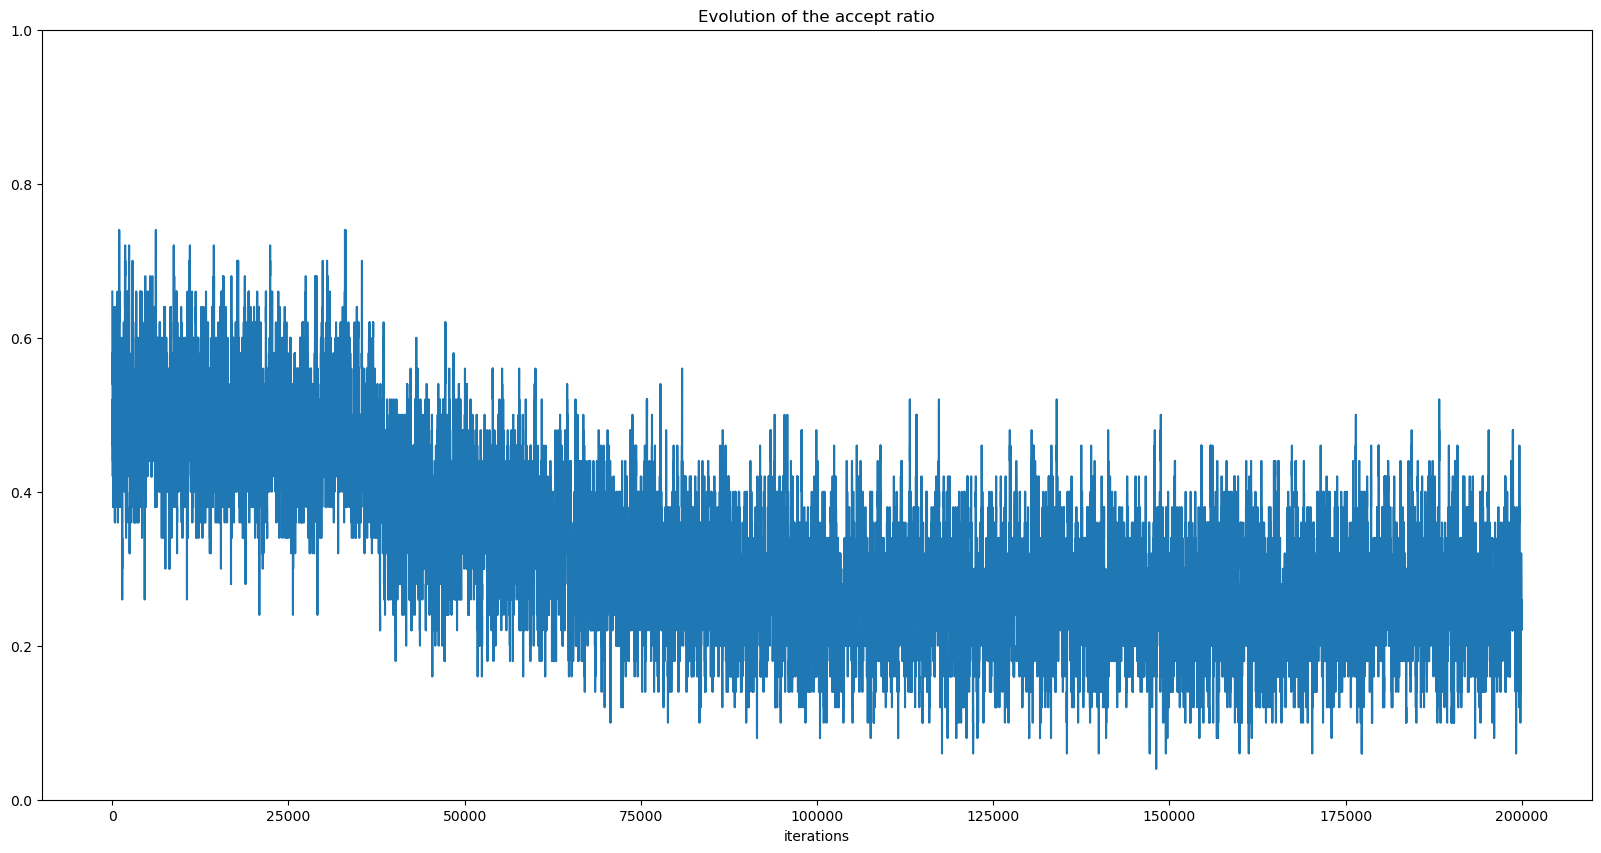

In [100]:
# Analysis of the acceptance probability:

print("Average acceptance probability: ", sum(accept_reject)/len(accept_reject))

# Plot moving average of the acceptance probability (should stabilise as iteration increase)

def moving_average(l, width=50):
    """
    Compute the moving average of list l
    
    Keyword arguments:
    l -- float list, list of which we want to compute the moving average
    width -- int, window size of the moving average
    
    Returns:
    list of moving averages
    """
    return np.convolve(l, np.ones(width), 'valid') / width


movingAverage = moving_average([int(e) for e in accept_reject])

plt.figure(figsize=(20,10))
plt.ylim(0,1)
plt.plot(movingAverage)
plt.title("Evolution of the accept ratio")
plt.xlabel('iterations')
plt.show()

### Likelihood

In [98]:
true_likelihood

Text(0.5, 1.0, 'Evolution of the likelihood')

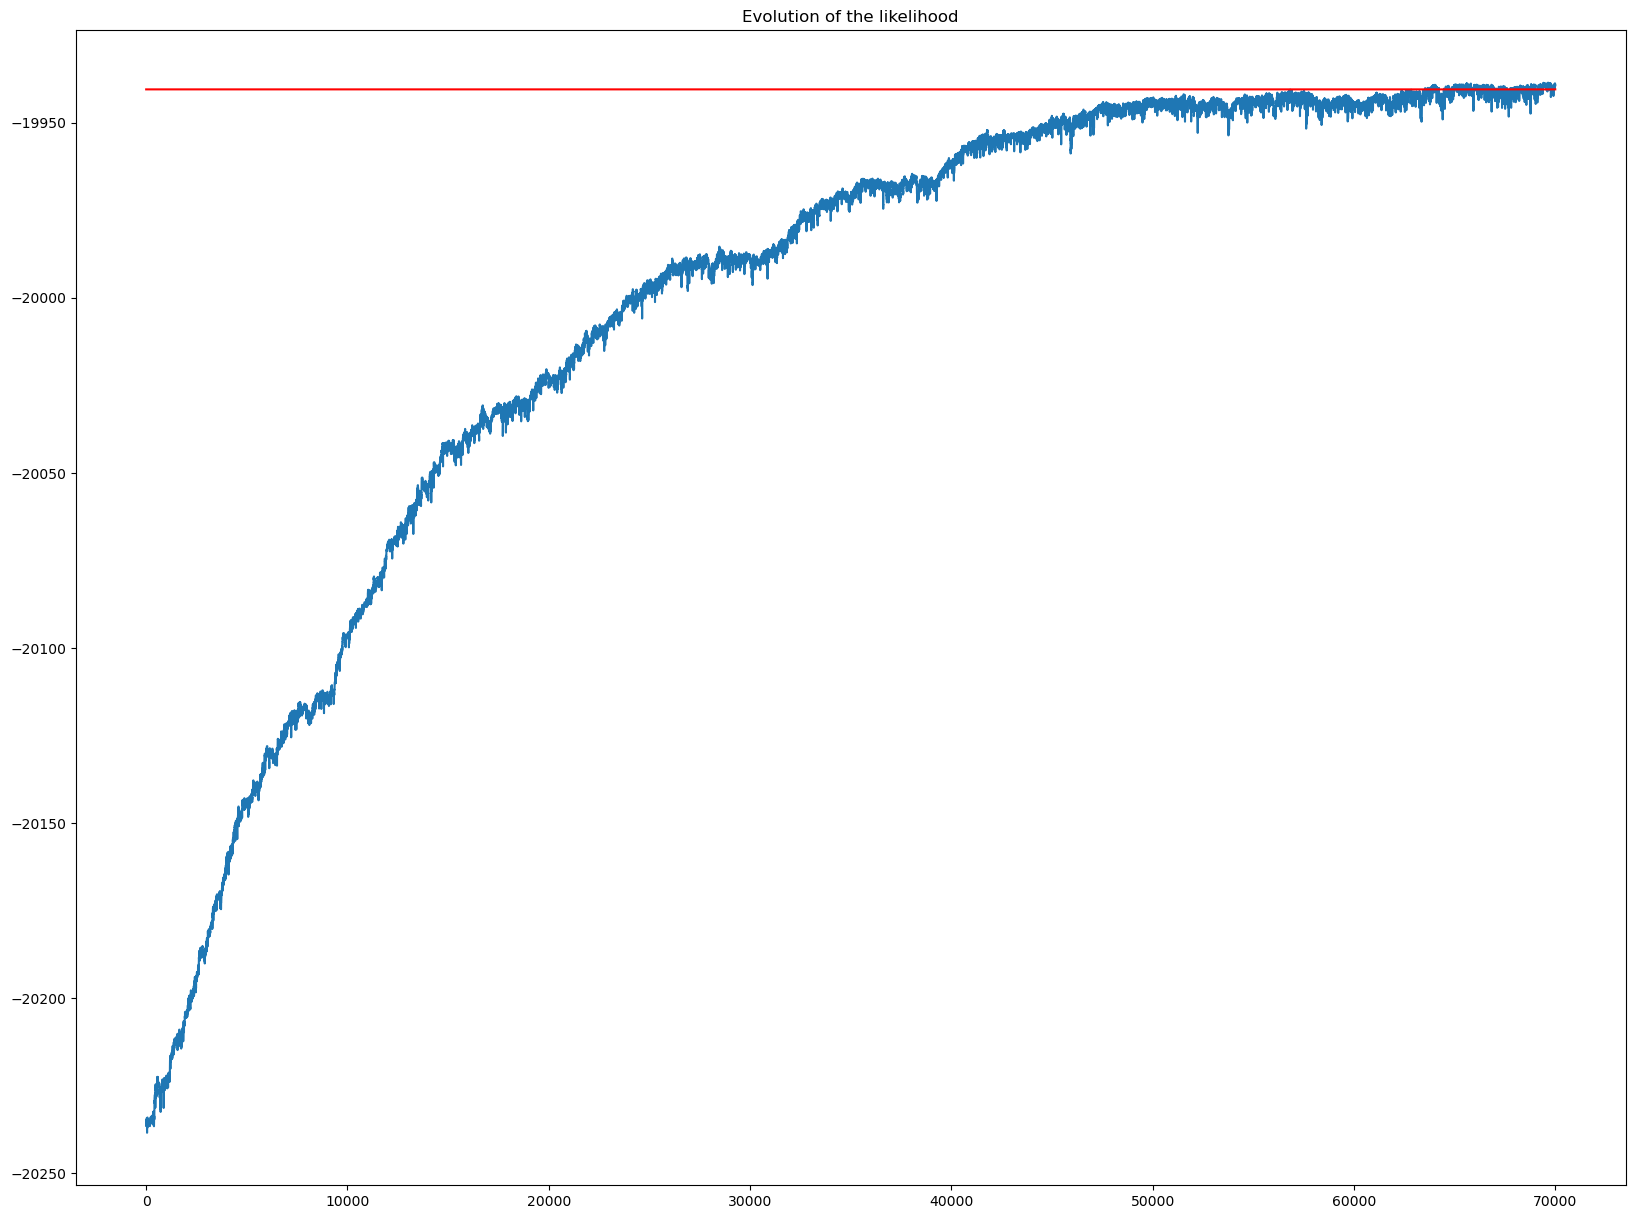

In [101]:
# Plot the evolution of the likelihood
plt.figure(figsize=(20,15))
plt.plot(likelihoods[burnin:])

# Plot the true likelihood for reference
true_likelihood = compute_loglikelihood(u_values_true, observations)
plt.plot([true_likelihood]*(n_iter-burnin), color = 'red')

plt.title("Evolution of the likelihood")

### Chain values

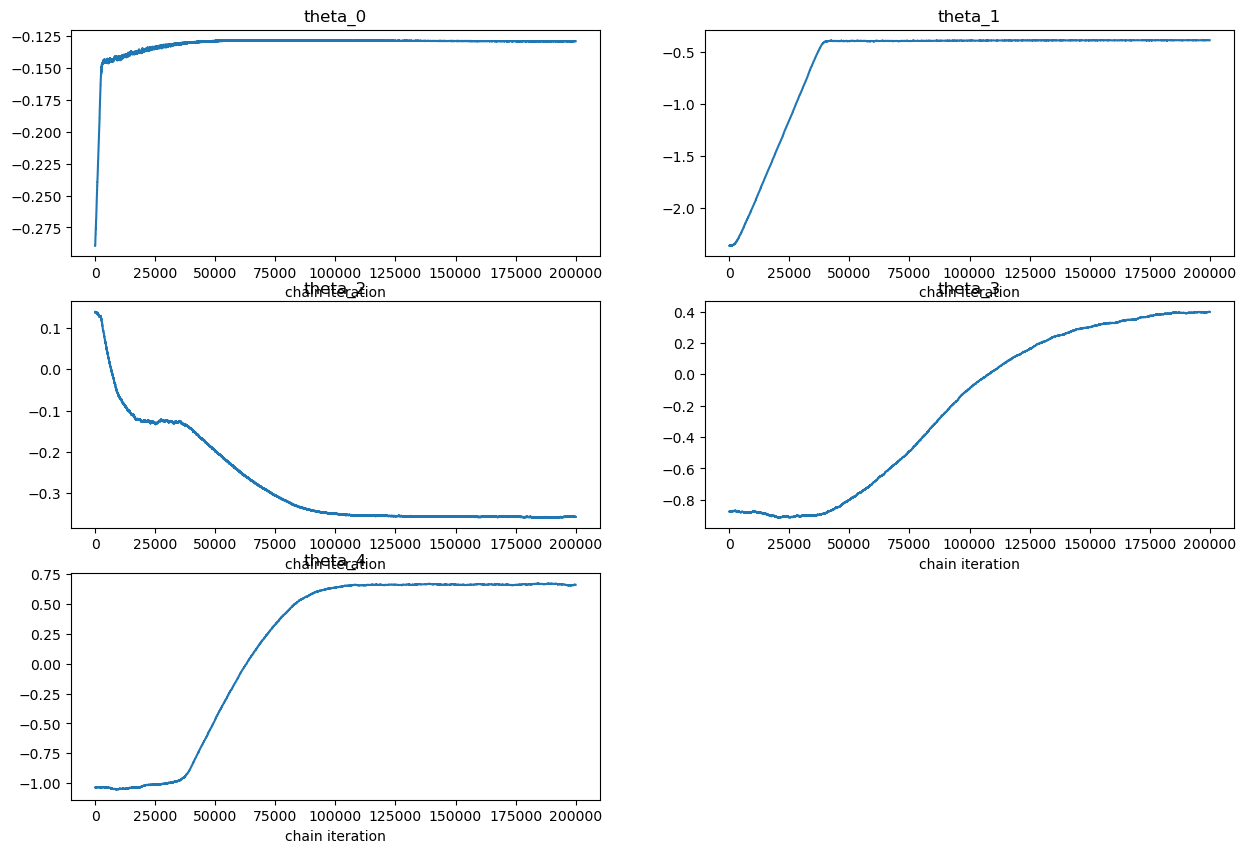

In [102]:
# Plot the chain so we can visually assess if converges

fig = plt.figure(figsize=(15,10))

plt.subplot(3, 2, 1)
plt.title('theta_0')
plt.xlabel('chain iteration')
plt.plot([theta[0] for theta in chain])
#plt.ylim(-10,10)

plt.subplot(3, 2, 2)
plt.title('theta_1')
plt.plot([theta[1] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 3)
plt.title('theta_2')
plt.plot([theta[2] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 4)
plt.title('theta_3')
plt.plot([theta[3] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 5)
plt.title('theta_4')
plt.plot([theta[4] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.show()

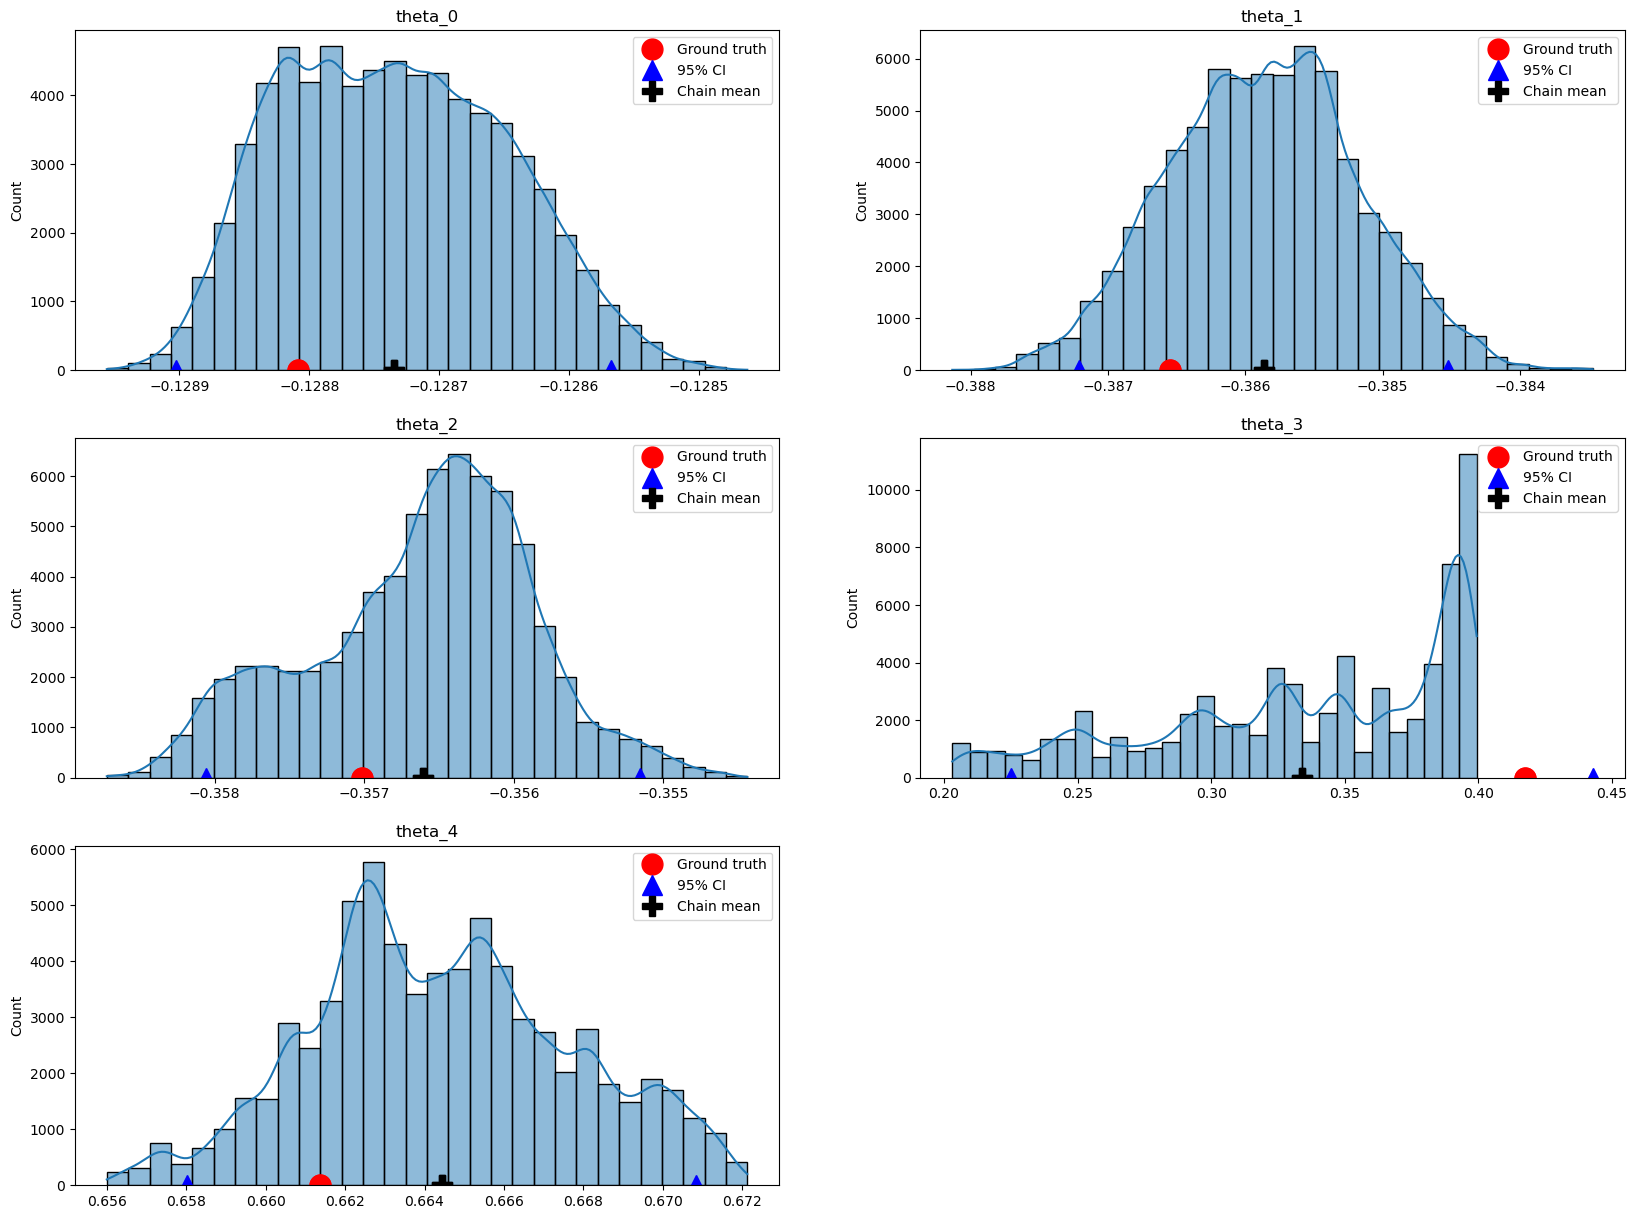

In [103]:
#  Plot histogram of chain, with mean + 95% confidence interval
import seaborn as sns
import scipy.stats as st

burnin = 130000
#burnin=0
#chain = chain[:30000]

# Compute stats
confidence_intervals=[]
means = []
for k in range(K):
    
    # Define sample data
    data = [theta[k] for theta in chain][burnin:]
    means.append(np.mean(data))
  
    # Create 95% confidence interval
    confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
    confidence_intervals.append(confidence_interval)


#---------------------------------Plot histograms----------------------------------------
fig = plt.figure(figsize=(20,15))

plt.subplot(3, 2, 1)
plt.title('theta_0')
sns.histplot([theta[0] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[0], theta_0[0]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[0][0], confidence_intervals[0][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[0], means[0]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()

plt.subplot(3, 2, 2)
plt.title('theta_1')
sns.histplot([theta[1] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[1], theta_0[1]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[1][0], confidence_intervals[1][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[1], means[1]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.subplot(3, 2, 3)
plt.title('theta_2')
sns.histplot([theta[2] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[2], theta_0[2]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[2][0], confidence_intervals[2][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[2], means[2]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.subplot(3, 2, 4)
plt.title('theta_3')
sns.histplot([theta[3] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[3], theta_0[3]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[3][0], confidence_intervals[3][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[3], means[3]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()

plt.subplot(3, 2, 5)
plt.title('theta_4')
sns.histplot([theta[4] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[4], theta_0[4]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[4][0], confidence_intervals[4][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[4], means[4]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.show()

In [104]:
# Retrieving some stats - mean and confidence interval for every theta

import scipy.stats as st

# Run the loop
for i in range(K):
    
    # Define sample data
    data = [theta[i] for theta in chain][burnin:]
  
    # Create 95% confidence interval
    confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
    
    print(f"True value of the coefficient: {theta_0[i]}")
    print(f"Confidence interval: {confidence_interval}")
    print(f"Within confidence interval? {confidence_interval[0] <= theta_0[i] and confidence_interval[1] >= theta_0[i]}\n")

True value of the coefficient: -0.12880843901864983
Confidence interval: (-0.12890290027755658, -0.12856720357211393)
Within confidence interval? True

True value of the coefficient: -0.38654988613700925
Confidence interval: (-0.38720836041528023, -0.38452238026124225)
Within confidence interval? True

True value of the coefficient: -0.35701199674571577
Confidence interval: (-0.3580603823014311, -0.3551573615740816)
Within confidence interval? True

True value of the coefficient: 0.417492574803424
Confidence interval: (0.22510916562971517, 0.4428638801562438)
Within confidence interval? True

True value of the coefficient: 0.6613801482829043
Confidence interval: (0.6580202559263632, 0.6708429546261429)
Within confidence interval? True



In [105]:
# Auxiliary function to determine whether the chain sample fits in the 95% confidence interval

def within_confidence_interval(sample, chain):
    """
    Determines whether the sample sits within the confidence interval - to exclude extreme betas in reconstructions
    
    Keyword arguments:
    sample -- K-dim list, values of coefficients, drawn from the chain
    chain -- the whole chain
    
    Returns:
    boolean - whether all K components of the chain sample are within the 95% confidence interval
    """
    
    
    # Run the loop over dimensions of the parameter
    for k in range(K):
        
        data=[theta[k] for theta in chain]
        #print(data)
    
        # Create 95% confidence interval
        confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
        
        #print(confidence_interval)
        within_interval = confidence_interval[0] <= sample[k] and confidence_interval[1] >= sample[k]
        
        if not within_interval:
            #print(k, confidence_interval[0], sample[k], confidence_interval[1] )
            return False
    
    return True

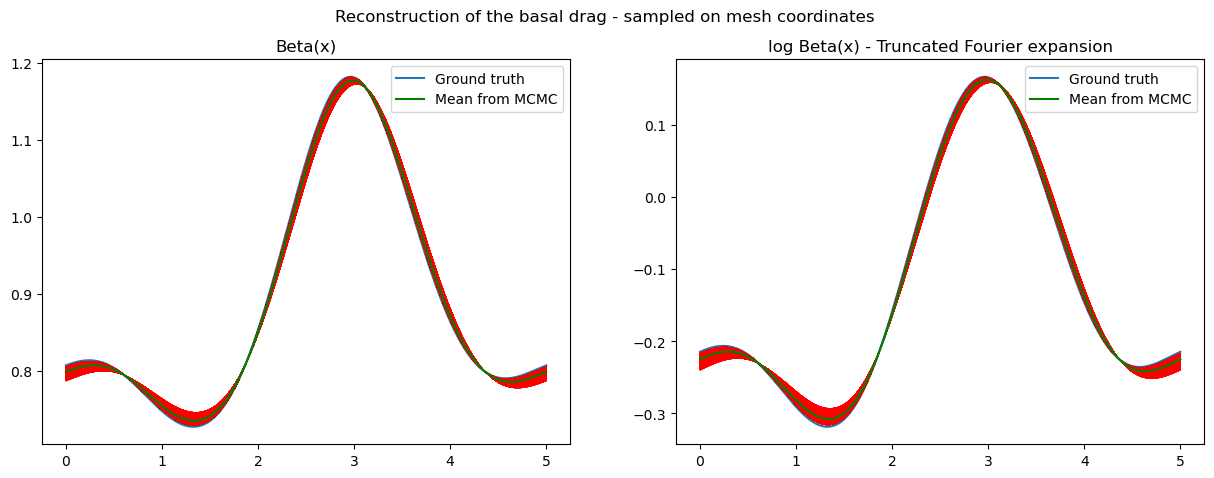

In [106]:
# Comparing true and simulated beta function. We plot the sinus expansion and the final beta function

import random

#-------------Start plotting with the true function-----------------------

# Build the true function
beta_0 = build_beta(theta_0)
interval = [(x,0) for x in np.linspace(0,5,size_msh_x)]

plt.figure(figsize=(15,5))
plt.suptitle("Reconstruction of the basal drag - sampled on mesh coordinates")

plt.subplot(1,2,1)
plt.title("Beta(x)")
plt.plot([x[0] for x in interval], [beta_0(x) for x in interval], label = "Ground truth")

plt.subplot(1,2,2)
plt.title("log Beta(x) - Truncated Fourier expansion")
plt.plot([x[0] for x in interval], [np.log(beta_0(x)) for x in interval], label = "Ground truth")


#-------------Add reconstruction from samples drawn from the chain---------------------------------

n_draws = 10000
all_betas = [0 for x in interval] # table to keep track of betas and compute mean at the end
all_log_betas = [0 for x in interval] # table to keep track of log betas and compute mean at the end
drawn = 0

while drawn < n_draws:

    draw = random.choice(chain)
    #print(drawn, draw)
    
    
    if within_confidence_interval(draw, chain[burnin:]):

        beta = build_beta(draw)
        beta_values = [beta(x) for x in interval]
        log_beta_values = [np.log(bv) for bv in beta_values]
        
        plt.subplot(1,2,1)
        plt.plot([x[0] for x in interval], beta_values, linewidth = 0.05, color='r')
        
        plt.subplot(1,2,2)
        plt.plot([x[0] for x in interval],log_beta_values, linewidth = 0.05, color='r')
        
        
        all_betas = [sum(x) for x in zip(all_betas, beta_values)] # update the list of all drawn betas
        all_log_betas = [sum(x) for x in zip(all_log_betas, log_beta_values)] # update the list of all drawn log betas
        
        drawn+=1 # update the count
        
        

# Add the empirical average to the plots

plt.subplot(121)
all_betas = [b/drawn for b in all_betas]
plt.plot([x[0] for x in interval], all_betas, color='g', label = "Mean from MCMC")
plt.legend()

plt.subplot(122)
all_log_betas = [b/drawn for b in all_log_betas]
plt.plot([x[0] for x in interval], all_log_betas, color='g', label = "Mean from MCMC")
plt.legend()

plt.show()

In [107]:
iter_samples = [k for k in range(0,n_iter,100)]
#print(iter_samples)

beta_anim = np.zeros((len(iter_samples), len(interval)))

for i in range(len(iter_samples)):
    draw = chain[iter_samples[i]]
    beta = build_beta(draw)
    beta_values = [beta(x) for x in interval]
    beta_anim[i,:]=beta_values
    
true_beta = [beta_0(x) for x in interval]

beta_anim

array([[0.27846184, 0.27750107, 0.27663693, ..., 0.28067264, 0.27951907,
        0.27846184],
       [0.28056986, 0.27960052, 0.27872852, ..., 0.28279993, 0.28163637,
        0.28056986],
       [0.28173787, 0.28076537, 0.2798906 , ..., 0.28397545, 0.28280794,
        0.28173787],
       ...,
       [0.80505557, 0.80565631, 0.80624096, ..., 0.80381327, 0.80444059,
        0.80505557],
       [0.80541302, 0.80601542, 0.80660161, ..., 0.80416708, 0.80479627,
        0.80541302],
       [0.8055633 , 0.80616111, 0.80674261, ..., 0.80432617, 0.80495102,
        0.8055633 ]])

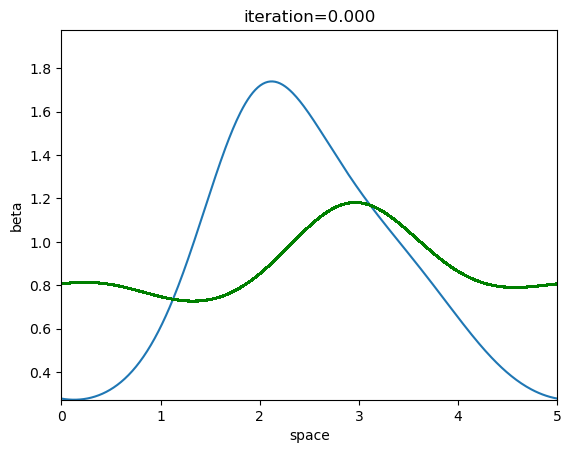

In [108]:
# Trying to plot a cool animation of evolution of beta with iterations
import functools
from matplotlib.animation import FuncAnimation

space = np.array([x[0] for x in interval])
time=np.array(iter_samples)
#time=np.array(range(len(iter_samples)))

fig, ax = plt.subplots()
ax.set_xlabel("space")
ax.set_xlim([space.min(), space.max()])

ax.set_ylabel("beta")
ax.set_ylim([beta_anim.min(), beta_anim.max()])


def update2d(frame, ax, line, xdata, ydata, tdata, anim=False):
    ax.plot(xdata,true_beta,'g')
    if line is None:
        line, = ax.plot(xdata, ydata[frame, :])
    line.set_data(xdata, ydata[frame, :])
    ax.set_title(f"iteration={tdata[frame]:.3f}")
    return line,


line, = update2d(0, ax, None, space, beta_anim, time, True)

update_anim = functools.partial(update2d, ax=ax, line=line, 
                                xdata=space, ydata=beta_anim, tdata=time, anim=True)

ani = FuncAnimation(fig, update_anim, frames=len(time), interval=20, blit=False)
ani.save(f'test_beta_N{N}.gif')